In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, LayerNormalization, Concatenate, ReLU, Dropout, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from tensorflow.keras.layers import Layer, Conv2D, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

import os
import glob

In [89]:
# network parameters
width = 128
height = 128
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(4*4*512)(latent_inputs)
#     x = LeakyReLU(0.2)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Reshape((4,4,512))(x)


    
    x = UpSampling2D()(x)
    x = Conv2D(256,3, strides=1, padding='same')(x)
#     x = LeakyReLU(0.2)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    

    x = UpSampling2D()(x)
    x = Conv2D(128,3, strides=1, padding='same')(x)    
#     x = LeakyReLU(0.2)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    
    
    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)    
#     x = LeakyReLU(0.2)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
#     x = LeakyReLU(0.2)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    
    x = UpSampling2D()(x)
    img_outputs = Conv2D(3,5, strides= 1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_45 (Dense)             (None, 8192)              827392    
_________________________________________________________________
re_lu_15 (ReLU)              (None, 8192)              0         
_________________________________________________________________
batch_normalization_116 (Bat (None, 8192)              32768     
_________________________________________________________________
reshape_22 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_116 (UpSamplin (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 8, 8, 256)         11

In [90]:
def build_discriminator():
    inputs = Input(shape=(width,height,3), name='discriminator_input')
    
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
       
    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
        
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='discriminator')
build_discriminator().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_214 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
layer_normalization_113 (Lay (None, 64, 64, 32)        64        
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_215 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
layer_normalization_114 (Lay (None, 32, 32, 64)      

In [5]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [8]:
training_data_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=False,
    dtype='float32',
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_directory(
    '../celeba/',
    target_size=(128, 128),
    subset='training',
    shuffle=True,
    batch_size=64,
    class_mode=None)

Found 162080 images belonging to 1 classes.


In [7]:
# load into memory (needs a substantial amount)
# batch if it doesn't fit
training_data = training_generator.next()

In [34]:
del training_data

In [19]:
training_data.shape

(32, 64, 64, 3)

In [91]:
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.0, beta_2=0.9)

In [92]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = discriminator(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_discriminator(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 20
    
    with tf.GradientTape() as disc_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_images = generated_images * alpha + images * (1 - alpha)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = discriminator(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        disc_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return loss_real, loss_fake, gp
    
        
        
        

In [93]:
tf.__version__

'2.1.0'

Iteration [26183/50000]......1.077(s) gen: 779.8845 - disc_fake: -781.1761 - disc_real: -766.2336 - neg_critic: 14.9425 - gp: 0.1672
Iteration [26184/50000]......1.045(s) gen: 778.7954 - disc_fake: -779.0054 - disc_real: -762.3294 - neg_critic: 16.6760 - gp: 0.2180
Iteration [26185/50000]......1.029(s) gen: 785.4958 - disc_fake: -782.0708 - disc_real: -767.7426 - neg_critic: 14.3282 - gp: 0.1131
Iteration [26186/50000]......1.025(s) gen: 787.5116 - disc_fake: -786.8412 - disc_real: -772.4750 - neg_critic: 14.3663 - gp: 0.1440
Iteration [26187/50000]......1.046(s) gen: 781.7952 - disc_fake: -783.8814 - disc_real: -768.5408 - neg_critic: 15.3406 - gp: 0.1748
Iteration [26188/50000]......1.036(s) gen: 779.6589 - disc_fake: -780.8174 - disc_real: -765.7547 - neg_critic: 15.0627 - gp: 0.1611
Iteration [26189/50000]......1.029(s) gen: 782.7422 - disc_fake: -781.7556 - disc_real: -767.0307 - neg_critic: 14.7249 - gp: 0.1725
Iteration [26190/50000]......1.037(s) gen: 780.6562 - disc_fake: -781

Iteration [26245/50000]......1.034(s) gen: 786.0576 - disc_fake: -783.7252 - disc_real: -769.4838 - neg_critic: 14.2415 - gp: 0.1774
Iteration [26246/50000]......1.049(s) gen: 780.7119 - disc_fake: -782.3407 - disc_real: -767.1408 - neg_critic: 15.1999 - gp: 0.1766
Iteration [26247/50000]......1.034(s) gen: 781.2947 - disc_fake: -781.8524 - disc_real: -765.8338 - neg_critic: 16.0186 - gp: 0.1753
Iteration [26248/50000]......1.033(s) gen: 769.8996 - disc_fake: -778.7490 - disc_real: -763.1762 - neg_critic: 15.5728 - gp: 0.1377
Iteration [26249/50000]......1.049(s) gen: 786.7268 - disc_fake: -777.1461 - disc_real: -762.7692 - neg_critic: 14.3768 - gp: 0.1850
Iteration [26250/50000]......1.034(s) gen: 787.5316 - disc_fake: -786.5348 - disc_real: -772.2974 - neg_critic: 14.2374 - gp: 0.1249
Iteration [26251/50000]......1.033(s) gen: 786.0557 - disc_fake: -783.3590 - disc_real: -768.7180 - neg_critic: 14.6410 - gp: 0.2056
Iteration [26252/50000]......1.049(s) gen: 782.6631 - disc_fake: -784

Iteration [26307/50000]......1.049(s) gen: 787.4372 - disc_fake: -786.7608 - disc_real: -772.5523 - neg_critic: 14.2085 - gp: 0.1004
Iteration [26308/50000]......1.034(s) gen: 793.1330 - disc_fake: -787.9464 - disc_real: -772.8122 - neg_critic: 15.1343 - gp: 0.1696
Iteration [26309/50000]......1.049(s) gen: 786.3912 - disc_fake: -786.8296 - disc_real: -772.7896 - neg_critic: 14.0400 - gp: 0.1735
Iteration [26310/50000]......1.050(s) gen: 782.7889 - disc_fake: -786.1912 - disc_real: -771.2820 - neg_critic: 14.9092 - gp: 0.1176
Iteration [26311/50000]......1.034(s) gen: 780.3499 - disc_fake: -780.1277 - disc_real: -762.8223 - neg_critic: 17.3054 - gp: 0.1707
Iteration [26312/50000]......1.049(s) gen: 786.9606 - disc_fake: -784.5735 - disc_real: -769.7315 - neg_critic: 14.8420 - gp: 0.2288
Iteration [26313/50000]......1.034(s) gen: 787.3204 - disc_fake: -787.9092 - disc_real: -774.1409 - neg_critic: 13.7682 - gp: 0.0997
Iteration [26314/50000]......1.049(s) gen: 785.0577 - disc_fake: -786

Iteration [26369/50000]......1.034(s) gen: 787.5784 - disc_fake: -787.9641 - disc_real: -773.9497 - neg_critic: 14.0145 - gp: 0.1759
Iteration [26370/50000]......1.049(s) gen: 784.5765 - disc_fake: -786.6071 - disc_real: -773.9423 - neg_critic: 12.6648 - gp: 0.1560
Iteration [26371/50000]......1.034(s) gen: 786.7101 - disc_fake: -783.7321 - disc_real: -772.0227 - neg_critic: 11.7094 - gp: 0.1200
Iteration [26372/50000]......1.049(s) gen: 781.1830 - disc_fake: -783.1698 - disc_real: -770.2350 - neg_critic: 12.9347 - gp: 0.1337
Iteration [26373/50000]......1.034(s) gen: 777.0929 - disc_fake: -775.8748 - disc_real: -759.5510 - neg_critic: 16.3239 - gp: 0.1745
Iteration [26374/50000]......1.049(s) gen: 787.9560 - disc_fake: -781.8815 - disc_real: -768.1143 - neg_critic: 13.7672 - gp: 0.1590
Iteration [26375/50000]......1.050(s) gen: 791.5229 - disc_fake: -785.2159 - disc_real: -771.8197 - neg_critic: 13.3962 - gp: 0.1497
Iteration [26376/50000]......1.034(s) gen: 785.5282 - disc_fake: -788

Iteration [26431/50000]......1.050(s) gen: 784.8236 - disc_fake: -783.5267 - disc_real: -767.9362 - neg_critic: 15.5906 - gp: 0.1724
Iteration [26432/50000]......1.034(s) gen: 778.3326 - disc_fake: -782.3687 - disc_real: -768.5457 - neg_critic: 13.8230 - gp: 0.1501
Iteration [26433/50000]......1.049(s) gen: 777.8649 - disc_fake: -778.3401 - disc_real: -763.5060 - neg_critic: 14.8340 - gp: 0.1901
Iteration [26434/50000]......1.034(s) gen: 778.9999 - disc_fake: -779.1263 - disc_real: -763.9156 - neg_critic: 15.2107 - gp: 0.1516
Iteration [26435/50000]......1.049(s) gen: 782.7731 - disc_fake: -780.4126 - disc_real: -765.4554 - neg_critic: 14.9572 - gp: 0.1607
Iteration [26436/50000]......1.034(s) gen: 781.0242 - disc_fake: -780.1207 - disc_real: -765.9378 - neg_critic: 14.1829 - gp: 0.1491
Iteration [26437/50000]......1.049(s) gen: 783.1512 - disc_fake: -782.3720 - disc_real: -768.3405 - neg_critic: 14.0315 - gp: 0.1558
Iteration [26438/50000]......1.034(s) gen: 780.9688 - disc_fake: -786

Iteration [26493/50000]......1.050(s) gen: 781.4753 - disc_fake: -781.8898 - disc_real: -766.5836 - neg_critic: 15.3062 - gp: 0.1739
Iteration [26494/50000]......1.049(s) gen: 780.0565 - disc_fake: -781.4856 - disc_real: -767.2246 - neg_critic: 14.2610 - gp: 0.1539
Iteration [26495/50000]......1.035(s) gen: 778.6758 - disc_fake: -778.2778 - disc_real: -762.8377 - neg_critic: 15.4401 - gp: 0.1783
Iteration [26496/50000]......1.044(s) gen: 775.9518 - disc_fake: -778.0232 - disc_real: -763.2957 - neg_critic: 14.7276 - gp: 0.1556
Iteration [26497/50000]......1.070(s) gen: 781.2768 - disc_fake: -782.2386 - disc_real: -765.9803 - neg_critic: 16.2583 - gp: 0.1580
Iteration [26498/50000]......1.036(s) gen: 783.0264 - disc_fake: -782.2067 - disc_real: -769.1286 - neg_critic: 13.0780 - gp: 0.1628
Iteration [26499/50000]......1.049(s) gen: 784.2697 - disc_fake: -782.6161 - disc_real: -770.3740 - neg_critic: 12.2421 - gp: 0.1466
Iteration [26500/50000]......1.050(s) gen: 783.3827 - disc_fake: -785

Iteration [26555/50000]......1.066(s) gen: 779.2638 - disc_fake: -780.6344 - disc_real: -766.1651 - neg_critic: 14.4692 - gp: 0.1545
Iteration [26556/50000]......1.035(s) gen: 777.0338 - disc_fake: -777.7824 - disc_real: -762.7650 - neg_critic: 15.0174 - gp: 0.1734
Iteration [26557/50000]......1.049(s) gen: 772.1335 - disc_fake: -773.7754 - disc_real: -757.4805 - neg_critic: 16.2949 - gp: 0.2300
Iteration [26558/50000]......1.034(s) gen: 780.5104 - disc_fake: -776.0418 - disc_real: -761.4184 - neg_critic: 14.6234 - gp: 0.1687
Iteration [26559/50000]......1.049(s) gen: 779.6000 - disc_fake: -778.8427 - disc_real: -764.7224 - neg_critic: 14.1203 - gp: 0.1381
Iteration [26560/50000]......1.050(s) gen: 785.0729 - disc_fake: -783.0352 - disc_real: -768.5246 - neg_critic: 14.5105 - gp: 0.1377
Iteration [26561/50000]......1.034(s) gen: 777.1393 - disc_fake: -780.0831 - disc_real: -762.5222 - neg_critic: 17.5608 - gp: 0.1742
Iteration [26562/50000]......1.049(s) gen: 791.5259 - disc_fake: -784

Iteration [26617/50000]......1.049(s) gen: 785.2367 - disc_fake: -786.1883 - disc_real: -770.1846 - neg_critic: 16.0037 - gp: 0.1726
Iteration [26618/50000]......1.050(s) gen: 774.7906 - disc_fake: -781.1681 - disc_real: -767.2646 - neg_critic: 13.9035 - gp: 0.1591
Iteration [26619/50000]......1.050(s) gen: 776.4276 - disc_fake: -779.4155 - disc_real: -764.5246 - neg_critic: 14.8910 - gp: 0.1423
Iteration [26620/50000]......1.034(s) gen: 779.0056 - disc_fake: -777.7582 - disc_real: -763.1945 - neg_critic: 14.5637 - gp: 0.1583
Iteration [26621/50000]......1.049(s) gen: 785.8550 - disc_fake: -781.8807 - disc_real: -765.6971 - neg_critic: 16.1837 - gp: 0.1669
Iteration [26622/50000]......1.050(s) gen: 784.1688 - disc_fake: -785.9177 - disc_real: -771.5074 - neg_critic: 14.4103 - gp: 0.1715
Iteration [26623/50000]......1.034(s) gen: 782.3839 - disc_fake: -779.0584 - disc_real: -764.3549 - neg_critic: 14.7035 - gp: 0.1426
Iteration [26624/50000]......1.049(s) gen: 783.3831 - disc_fake: -781

Iteration [26679/50000]......1.050(s) gen: 775.0328 - disc_fake: -776.0147 - disc_real: -760.7694 - neg_critic: 15.2453 - gp: 0.1791
Iteration [26680/50000]......1.034(s) gen: 775.3319 - disc_fake: -777.4286 - disc_real: -762.3479 - neg_critic: 15.0808 - gp: 0.1504
Iteration [26681/50000]......1.049(s) gen: 776.6226 - disc_fake: -776.0562 - disc_real: -762.0763 - neg_critic: 13.9799 - gp: 0.1566
Iteration [26682/50000]......1.034(s) gen: 782.5020 - disc_fake: -781.6026 - disc_real: -768.4592 - neg_critic: 13.1435 - gp: 0.1828
Iteration [26683/50000]......1.049(s) gen: 782.6398 - disc_fake: -782.8174 - disc_real: -768.7746 - neg_critic: 14.0428 - gp: 0.1319
Iteration [26684/50000]......1.050(s) gen: 772.2886 - disc_fake: -776.5509 - disc_real: -761.1718 - neg_critic: 15.3792 - gp: 0.1452
Iteration [26685/50000]......1.034(s) gen: 782.8958 - disc_fake: -777.7835 - disc_real: -763.5793 - neg_critic: 14.2042 - gp: 0.1670
Iteration [26686/50000]......1.049(s) gen: 773.0842 - disc_fake: -777

Iteration [26741/50000]......1.050(s) gen: 782.7529 - disc_fake: -782.6926 - disc_real: -768.3992 - neg_critic: 14.2934 - gp: 0.1732
Iteration [26742/50000]......1.034(s) gen: 780.9144 - disc_fake: -781.5649 - disc_real: -766.6321 - neg_critic: 14.9328 - gp: 0.1433
Iteration [26743/50000]......1.049(s) gen: 786.0499 - disc_fake: -782.9353 - disc_real: -768.8533 - neg_critic: 14.0820 - gp: 0.1593
Iteration [26744/50000]......1.034(s) gen: 778.8389 - disc_fake: -783.9197 - disc_real: -768.6106 - neg_critic: 15.3091 - gp: 0.1378
Iteration [26745/50000]......1.111(s) gen: 785.9537 - disc_fake: -781.3949 - disc_real: -766.3201 - neg_critic: 15.0749 - gp: 0.1920
Iteration [26746/50000]......1.084(s) gen: 788.7219 - disc_fake: -784.1053 - disc_real: -770.8954 - neg_critic: 13.2099 - gp: 0.1201
Iteration [26747/50000]......1.054(s) gen: 784.8865 - disc_fake: -785.0153 - disc_real: -770.1769 - neg_critic: 14.8384 - gp: 0.1377
Iteration [26748/50000]......1.050(s) gen: 785.1378 - disc_fake: -781

Iteration [26803/50000]......1.034(s) gen: 780.5563 - disc_fake: -780.7977 - disc_real: -766.4254 - neg_critic: 14.3723 - gp: 0.1704
Iteration [26804/50000]......1.049(s) gen: 785.8147 - disc_fake: -783.3055 - disc_real: -769.7658 - neg_critic: 13.5397 - gp: 0.1208
Iteration [26805/50000]......1.050(s) gen: 791.2709 - disc_fake: -786.9273 - disc_real: -773.2958 - neg_critic: 13.6314 - gp: 0.1644
Iteration [26806/50000]......1.034(s) gen: 787.7286 - disc_fake: -790.1368 - disc_real: -776.0005 - neg_critic: 14.1363 - gp: 0.1408
Iteration [26807/50000]......1.049(s) gen: 786.6278 - disc_fake: -785.7677 - disc_real: -770.0821 - neg_critic: 15.6856 - gp: 0.1464
Iteration [26808/50000]......1.050(s) gen: 786.8241 - disc_fake: -787.3098 - disc_real: -772.5481 - neg_critic: 14.7618 - gp: 0.1598
Iteration [26809/50000]......1.034(s) gen: 784.4592 - disc_fake: -783.1302 - disc_real: -768.1179 - neg_critic: 15.0123 - gp: 0.1478
Iteration [26810/50000]......1.049(s) gen: 779.0601 - disc_fake: -781

Iteration [26865/50000]......1.049(s) gen: 786.7950 - disc_fake: -785.1456 - disc_real: -769.9680 - neg_critic: 15.1776 - gp: 0.1695
Iteration [26866/50000]......1.050(s) gen: 787.9058 - disc_fake: -786.3611 - disc_real: -772.4201 - neg_critic: 13.9410 - gp: 0.1230
Iteration [26867/50000]......1.050(s) gen: 783.2390 - disc_fake: -785.2029 - disc_real: -771.3154 - neg_critic: 13.8876 - gp: 0.1958
Iteration [26868/50000]......1.034(s) gen: 785.2795 - disc_fake: -785.3901 - disc_real: -771.0427 - neg_critic: 14.3473 - gp: 0.1280
Iteration [26869/50000]......1.049(s) gen: 777.6603 - disc_fake: -784.4035 - disc_real: -768.1922 - neg_critic: 16.2113 - gp: 0.1863
Iteration [26870/50000]......1.034(s) gen: 785.9018 - disc_fake: -782.0974 - disc_real: -766.8932 - neg_critic: 15.2042 - gp: 0.1936
Iteration [26871/50000]......1.049(s) gen: 785.6929 - disc_fake: -785.6219 - disc_real: -772.8933 - neg_critic: 12.7286 - gp: 0.1518
Iteration [26872/50000]......1.050(s) gen: 787.5573 - disc_fake: -786

Iteration [26927/50000]......1.050(s) gen: 783.4058 - disc_fake: -786.8867 - disc_real: -770.7238 - neg_critic: 16.1629 - gp: 0.1830
Iteration [26928/50000]......1.034(s) gen: 789.4825 - disc_fake: -786.4494 - disc_real: -772.7821 - neg_critic: 13.6674 - gp: 0.1561
Iteration [26929/50000]......1.049(s) gen: 788.8012 - disc_fake: -788.3764 - disc_real: -775.9621 - neg_critic: 12.4143 - gp: 0.1085
Iteration [26930/50000]......1.034(s) gen: 787.5172 - disc_fake: -787.8579 - disc_real: -773.4417 - neg_critic: 14.4163 - gp: 0.1591
Iteration [26931/50000]......1.050(s) gen: 788.3455 - disc_fake: -787.4298 - disc_real: -771.7072 - neg_critic: 15.7226 - gp: 0.1745
Iteration [26932/50000]......1.049(s) gen: 791.9167 - disc_fake: -788.4258 - disc_real: -773.8762 - neg_critic: 14.5496 - gp: 0.1454
Iteration [26933/50000]......1.034(s) gen: 791.3160 - disc_fake: -791.1637 - disc_real: -776.9531 - neg_critic: 14.2106 - gp: 0.1224
Iteration [26934/50000]......1.049(s) gen: 787.4170 - disc_fake: -791

Iteration [26989/50000]......1.033(s) gen: 789.6151 - disc_fake: -789.4203 - disc_real: -774.5926 - neg_critic: 14.8277 - gp: 0.1706
Iteration [26990/50000]......1.049(s) gen: 783.2264 - disc_fake: -782.4437 - disc_real: -767.6958 - neg_critic: 14.7479 - gp: 0.1616
Iteration [26991/50000]......1.050(s) gen: 788.4025 - disc_fake: -784.9183 - disc_real: -769.7542 - neg_critic: 15.1641 - gp: 0.1816
Iteration [26992/50000]......1.034(s) gen: 789.7888 - disc_fake: -785.1635 - disc_real: -771.2422 - neg_critic: 13.9213 - gp: 0.1731
Iteration [26993/50000]......1.049(s) gen: 789.8619 - disc_fake: -787.4151 - disc_real: -772.8551 - neg_critic: 14.5600 - gp: 0.1373
Iteration [26994/50000]......1.050(s) gen: 784.8112 - disc_fake: -786.6785 - disc_real: -770.9018 - neg_critic: 15.7767 - gp: 0.2236
Iteration [26995/50000]......1.034(s) gen: 787.3547 - disc_fake: -786.8946 - disc_real: -772.7752 - neg_critic: 14.1194 - gp: 0.1458
Iteration [26996/50000]......1.049(s) gen: 786.5674 - disc_fake: -788

Iteration [27051/50000]......1.049(s) gen: 788.3690 - disc_fake: -790.7817 - disc_real: -775.5355 - neg_critic: 15.2463 - gp: 0.1458
Iteration [27052/50000]......1.050(s) gen: 787.5234 - disc_fake: -789.1762 - disc_real: -773.9559 - neg_critic: 15.2203 - gp: 0.1377
Iteration [27053/50000]......1.034(s) gen: 788.2916 - disc_fake: -786.8594 - disc_real: -771.0004 - neg_critic: 15.8590 - gp: 0.2013
Iteration [27054/50000]......1.049(s) gen: 784.2498 - disc_fake: -786.2746 - disc_real: -769.9060 - neg_critic: 16.3686 - gp: 0.1992
Iteration [27055/50000]......1.034(s) gen: 789.1388 - disc_fake: -786.8188 - disc_real: -772.3245 - neg_critic: 14.4943 - gp: 0.1503
Iteration [27056/50000]......1.049(s) gen: 791.0233 - disc_fake: -790.1412 - disc_real: -775.0041 - neg_critic: 15.1371 - gp: 0.1883
Iteration [27057/50000]......1.050(s) gen: 785.8729 - disc_fake: -789.5360 - disc_real: -775.0783 - neg_critic: 14.4577 - gp: 0.1394
Iteration [27058/50000]......1.066(s) gen: 783.9168 - disc_fake: -783

Iteration [27113/50000]......1.034(s) gen: 790.8699 - disc_fake: -789.4338 - disc_real: -774.6597 - neg_critic: 14.7741 - gp: 0.1598
Iteration [27114/50000]......1.049(s) gen: 782.6014 - disc_fake: -787.2344 - disc_real: -772.6477 - neg_critic: 14.5866 - gp: 0.1700
Iteration [27115/50000]......1.033(s) gen: 790.4374 - disc_fake: -786.9731 - disc_real: -772.0328 - neg_critic: 14.9403 - gp: 0.1953
Iteration [27116/50000]......1.049(s) gen: 793.2155 - disc_fake: -790.9307 - disc_real: -775.9713 - neg_critic: 14.9593 - gp: 0.1470
Iteration [27117/50000]......1.034(s) gen: 786.8561 - disc_fake: -788.8778 - disc_real: -775.0923 - neg_critic: 13.7854 - gp: 0.1218
Iteration [27118/50000]......1.049(s) gen: 789.3224 - disc_fake: -788.1460 - disc_real: -774.1548 - neg_critic: 13.9912 - gp: 0.1927
Iteration [27119/50000]......1.036(s) gen: 789.6637 - disc_fake: -792.8038 - disc_real: -779.2202 - neg_critic: 13.5836 - gp: 0.1163
Iteration [27120/50000]......1.048(s) gen: 790.8978 - disc_fake: -790

Iteration [27175/50000]......1.034(s) gen: 782.4660 - disc_fake: -785.9165 - disc_real: -771.3486 - neg_critic: 14.5679 - gp: 0.1742
Iteration [27176/50000]......1.049(s) gen: 783.3636 - disc_fake: -781.4116 - disc_real: -767.1079 - neg_critic: 14.3037 - gp: 0.1641
Iteration [27177/50000]......1.050(s) gen: 782.0913 - disc_fake: -784.2112 - disc_real: -769.8800 - neg_critic: 14.3312 - gp: 0.1341
Iteration [27178/50000]......1.034(s) gen: 789.1339 - disc_fake: -785.5068 - disc_real: -771.3698 - neg_critic: 14.1370 - gp: 0.1488
Iteration [27179/50000]......1.049(s) gen: 786.9216 - disc_fake: -787.7345 - disc_real: -773.6285 - neg_critic: 14.1060 - gp: 0.1571
Iteration [27180/50000]......1.066(s) gen: 790.1534 - disc_fake: -788.3782 - disc_real: -773.6882 - neg_critic: 14.6900 - gp: 0.1902
Iteration [27181/50000]......1.051(s) gen: 785.8755 - disc_fake: -786.5905 - disc_real: -772.7096 - neg_critic: 13.8810 - gp: 0.1268
Iteration [27182/50000]......1.050(s) gen: 787.3127 - disc_fake: -785

Iteration [27237/50000]......1.049(s) gen: 795.0468 - disc_fake: -792.5617 - disc_real: -779.1414 - neg_critic: 13.4203 - gp: 0.1248
Iteration [27238/50000]......1.034(s) gen: 786.6544 - disc_fake: -789.6158 - disc_real: -774.4267 - neg_critic: 15.1891 - gp: 0.1571
Iteration [27239/50000]......1.033(s) gen: 793.2285 - disc_fake: -791.2949 - disc_real: -776.2393 - neg_critic: 15.0556 - gp: 0.1557
Iteration [27240/50000]......1.049(s) gen: 791.1364 - disc_fake: -790.7992 - disc_real: -776.4284 - neg_critic: 14.3708 - gp: 0.1623
Iteration [27241/50000]......1.050(s) gen: 787.3355 - disc_fake: -789.0533 - disc_real: -775.9315 - neg_critic: 13.1218 - gp: 0.1509
Iteration [27242/50000]......1.034(s) gen: 785.7107 - disc_fake: -787.8964 - disc_real: -772.7359 - neg_critic: 15.1605 - gp: 0.1681
Iteration [27243/50000]......1.048(s) gen: 783.1555 - disc_fake: -785.3618 - disc_real: -770.7920 - neg_critic: 14.5698 - gp: 0.1397
Iteration [27244/50000]......1.036(s) gen: 785.5569 - disc_fake: -786

Iteration [27299/50000]......1.039(s) gen: 794.0394 - disc_fake: -792.2592 - disc_real: -778.8775 - neg_critic: 13.3817 - gp: 0.1183
Iteration [27300/50000]......1.045(s) gen: 789.4515 - disc_fake: -793.1028 - disc_real: -778.2097 - neg_critic: 14.8931 - gp: 0.1788
Iteration [27301/50000]......1.050(s) gen: 793.1985 - disc_fake: -788.6216 - disc_real: -772.4231 - neg_critic: 16.1985 - gp: 0.1595
Iteration [27302/50000]......1.049(s) gen: 784.1464 - disc_fake: -785.5922 - disc_real: -771.2864 - neg_critic: 14.3058 - gp: 0.1393
Iteration [27303/50000]......1.034(s) gen: 780.5142 - disc_fake: -782.9403 - disc_real: -767.6585 - neg_critic: 15.2818 - gp: 0.1759
Iteration [27304/50000]......1.049(s) gen: 790.1192 - disc_fake: -783.4480 - disc_real: -768.9847 - neg_critic: 14.4633 - gp: 0.1688
Iteration [27305/50000]......1.034(s) gen: 789.9749 - disc_fake: -786.8689 - disc_real: -771.9860 - neg_critic: 14.8830 - gp: 0.1408
Iteration [27306/50000]......1.033(s) gen: 790.7736 - disc_fake: -789

Iteration [27361/50000]......1.034(s) gen: 787.8761 - disc_fake: -787.8943 - disc_real: -772.5687 - neg_critic: 15.3257 - gp: 0.1841
Iteration [27362/50000]......1.033(s) gen: 781.4896 - disc_fake: -784.4034 - disc_real: -768.6622 - neg_critic: 15.7412 - gp: 0.1683
Iteration [27363/50000]......1.049(s) gen: 783.4553 - disc_fake: -781.9220 - disc_real: -766.8191 - neg_critic: 15.1030 - gp: 0.1280
Iteration [27364/50000]......1.034(s) gen: 787.6765 - disc_fake: -781.1893 - disc_real: -766.8740 - neg_critic: 14.3153 - gp: 0.1713
Iteration [27365/50000]......1.033(s) gen: 793.4505 - disc_fake: -790.6292 - disc_real: -777.5777 - neg_critic: 13.0515 - gp: 0.1300
Iteration [27366/50000]......1.048(s) gen: 791.3805 - disc_fake: -793.7882 - disc_real: -777.9251 - neg_critic: 15.8630 - gp: 0.1791
Iteration [27367/50000]......1.034(s) gen: 787.5844 - disc_fake: -787.1806 - disc_real: -772.3660 - neg_critic: 14.8146 - gp: 0.1542
Iteration [27368/50000]......1.049(s) gen: 786.2189 - disc_fake: -785

Iteration [27423/50000]......1.049(s) gen: 794.7538 - disc_fake: -790.7657 - disc_real: -777.1359 - neg_critic: 13.6298 - gp: 0.1626
Iteration [27424/50000]......1.034(s) gen: 790.3968 - disc_fake: -791.8357 - disc_real: -776.9548 - neg_critic: 14.8809 - gp: 0.1712
Iteration [27425/50000]......1.049(s) gen: 783.0405 - disc_fake: -788.8696 - disc_real: -774.4418 - neg_critic: 14.4277 - gp: 0.1232
Iteration [27426/50000]......1.036(s) gen: 789.0930 - disc_fake: -786.5909 - disc_real: -771.4495 - neg_critic: 15.1414 - gp: 0.1730
Iteration [27427/50000]......1.047(s) gen: 793.6406 - disc_fake: -790.7797 - disc_real: -777.0516 - neg_critic: 13.7281 - gp: 0.1546
Iteration [27428/50000]......1.034(s) gen: 792.7839 - disc_fake: -790.0152 - disc_real: -776.7833 - neg_critic: 13.2320 - gp: 0.1806
Iteration [27429/50000]......1.049(s) gen: 797.9078 - disc_fake: -795.8955 - disc_real: -780.6316 - neg_critic: 15.2639 - gp: 0.1469
Iteration [27430/50000]......1.034(s) gen: 790.6025 - disc_fake: -794

Iteration [27485/50000]......1.034(s) gen: 790.1245 - disc_fake: -791.6964 - disc_real: -778.6601 - neg_critic: 13.0364 - gp: 0.1159
Iteration [27486/50000]......1.049(s) gen: 797.7131 - disc_fake: -793.5021 - disc_real: -778.9590 - neg_critic: 14.5430 - gp: 0.1380
Iteration [27487/50000]......1.034(s) gen: 793.1014 - disc_fake: -791.9984 - disc_real: -776.7835 - neg_critic: 15.2149 - gp: 0.1673
Iteration [27488/50000]......1.049(s) gen: 790.8357 - disc_fake: -794.9653 - disc_real: -778.8344 - neg_critic: 16.1308 - gp: 0.1575
Iteration [27489/50000]......1.050(s) gen: 791.8457 - disc_fake: -791.8056 - disc_real: -778.0216 - neg_critic: 13.7839 - gp: 0.1683
Iteration [27490/50000]......1.034(s) gen: 790.0415 - disc_fake: -792.3042 - disc_real: -779.1191 - neg_critic: 13.1851 - gp: 0.1362
Iteration [27491/50000]......1.049(s) gen: 793.7342 - disc_fake: -790.5097 - disc_real: -776.0066 - neg_critic: 14.5030 - gp: 0.1940
Iteration [27492/50000]......1.034(s) gen: 793.8586 - disc_fake: -794

Iteration [27547/50000]......1.049(s) gen: 799.8148 - disc_fake: -794.5520 - disc_real: -779.5987 - neg_critic: 14.9532 - gp: 0.1554
Iteration [27548/50000]......1.034(s) gen: 797.0845 - disc_fake: -797.7441 - disc_real: -783.8296 - neg_critic: 13.9144 - gp: 0.1544
Iteration [27549/50000]......1.049(s) gen: 790.9685 - disc_fake: -796.2145 - disc_real: -780.3878 - neg_critic: 15.8267 - gp: 0.1355
Iteration [27550/50000]......1.034(s) gen: 789.1016 - disc_fake: -788.4702 - disc_real: -770.9357 - neg_critic: 17.5345 - gp: 0.1943
Iteration [27551/50000]......1.033(s) gen: 784.1748 - disc_fake: -788.8196 - disc_real: -771.1907 - neg_critic: 17.6289 - gp: 0.2241
Iteration [27552/50000]......1.049(s) gen: 789.4786 - disc_fake: -786.6645 - disc_real: -772.4370 - neg_critic: 14.2275 - gp: 0.1619
Iteration [27553/50000]......1.034(s) gen: 792.5502 - disc_fake: -787.8193 - disc_real: -770.8238 - neg_critic: 16.9955 - gp: 0.2066
Iteration [27554/50000]......1.049(s) gen: 803.2062 - disc_fake: -796

Iteration [27609/50000]......1.034(s) gen: 787.1318 - disc_fake: -791.2319 - disc_real: -775.6551 - neg_critic: 15.5768 - gp: 0.1521
Iteration [27610/50000]......1.049(s) gen: 799.3927 - disc_fake: -793.2238 - disc_real: -778.3177 - neg_critic: 14.9060 - gp: 0.2078
Iteration [27611/50000]......1.034(s) gen: 792.6746 - disc_fake: -795.2766 - disc_real: -781.9198 - neg_critic: 13.3568 - gp: 0.1210
Iteration [27612/50000]......1.049(s) gen: 797.2744 - disc_fake: -797.4880 - disc_real: -783.5478 - neg_critic: 13.9403 - gp: 0.1465
Iteration [27613/50000]......1.034(s) gen: 796.6399 - disc_fake: -798.3931 - disc_real: -783.8314 - neg_critic: 14.5617 - gp: 0.1369
Iteration [27614/50000]......1.048(s) gen: 795.7551 - disc_fake: -797.6007 - disc_real: -782.4614 - neg_critic: 15.1392 - gp: 0.1711
Iteration [27615/50000]......1.034(s) gen: 795.5182 - disc_fake: -794.3189 - disc_real: -779.0704 - neg_critic: 15.2485 - gp: 0.1813
Iteration [27616/50000]......1.049(s) gen: 799.8639 - disc_fake: -796

Iteration [27671/50000]......1.034(s) gen: 794.8553 - disc_fake: -790.1286 - disc_real: -777.0319 - neg_critic: 13.0966 - gp: 0.1380
Iteration [27672/50000]......1.049(s) gen: 793.0823 - disc_fake: -794.7481 - disc_real: -779.7597 - neg_critic: 14.9883 - gp: 0.1670
Iteration [27673/50000]......1.034(s) gen: 795.6888 - disc_fake: -792.6537 - disc_real: -778.0387 - neg_critic: 14.6149 - gp: 0.1615
Iteration [27674/50000]......1.049(s) gen: 800.4075 - disc_fake: -796.5467 - disc_real: -781.4668 - neg_critic: 15.0799 - gp: 0.1708
Iteration [27675/50000]......1.050(s) gen: 801.0698 - disc_fake: -797.0646 - disc_real: -783.1473 - neg_critic: 13.9172 - gp: 0.1610
Iteration [27676/50000]......1.050(s) gen: 794.8032 - disc_fake: -797.7048 - disc_real: -782.3637 - neg_critic: 15.3411 - gp: 0.1277
Iteration [27677/50000]......1.034(s) gen: 795.4550 - disc_fake: -794.8791 - disc_real: -778.0899 - neg_critic: 16.7891 - gp: 0.1818
Iteration [27678/50000]......1.049(s) gen: 788.2056 - disc_fake: -792

Iteration [27733/50000]......1.036(s) gen: 795.8380 - disc_fake: -790.8329 - disc_real: -777.0935 - neg_critic: 13.7394 - gp: 0.1512
Iteration [27734/50000]......1.047(s) gen: 794.9189 - disc_fake: -795.8147 - disc_real: -781.0943 - neg_critic: 14.7204 - gp: 0.1457
Iteration [27735/50000]......1.034(s) gen: 793.0392 - disc_fake: -796.2652 - disc_real: -780.2591 - neg_critic: 16.0061 - gp: 0.1527
Iteration [27736/50000]......1.049(s) gen: 793.1700 - disc_fake: -791.5772 - disc_real: -776.7442 - neg_critic: 14.8330 - gp: 0.2100
Iteration [27737/50000]......1.034(s) gen: 789.7789 - disc_fake: -791.1667 - disc_real: -775.8473 - neg_critic: 15.3194 - gp: 0.1018
Iteration [27738/50000]......1.049(s) gen: 792.1815 - disc_fake: -790.1328 - disc_real: -774.9154 - neg_critic: 15.2173 - gp: 0.1920
Iteration [27739/50000]......1.050(s) gen: 794.3523 - disc_fake: -794.5949 - disc_real: -780.0587 - neg_critic: 14.5362 - gp: 0.1319
Iteration [27740/50000]......1.034(s) gen: 799.1861 - disc_fake: -792

Iteration [27795/50000]......1.050(s) gen: 789.9512 - disc_fake: -789.7860 - disc_real: -774.8289 - neg_critic: 14.9572 - gp: 0.1671
Iteration [27796/50000]......1.034(s) gen: 797.2305 - disc_fake: -792.6340 - disc_real: -779.1036 - neg_critic: 13.5304 - gp: 0.1226
Iteration [27797/50000]......1.049(s) gen: 793.8937 - disc_fake: -795.4440 - disc_real: -780.1615 - neg_critic: 15.2825 - gp: 0.1811
Iteration [27798/50000]......1.050(s) gen: 801.2669 - disc_fake: -797.7968 - disc_real: -783.0921 - neg_critic: 14.7047 - gp: 0.1727
Iteration [27799/50000]......1.050(s) gen: 801.0276 - disc_fake: -800.1651 - disc_real: -783.7540 - neg_critic: 16.4111 - gp: 0.1709
Iteration [27800/50000]......1.034(s) gen: 796.9945 - disc_fake: -799.8389 - disc_real: -785.2753 - neg_critic: 14.5636 - gp: 0.1470
Iteration [27801/50000]......1.049(s) gen: 797.7631 - disc_fake: -797.4559 - disc_real: -783.4823 - neg_critic: 13.9736 - gp: 0.1420
Iteration [27802/50000]......1.034(s) gen: 795.5920 - disc_fake: -796

Iteration [27857/50000]......1.034(s) gen: 803.6736 - disc_fake: -796.8057 - disc_real: -783.5101 - neg_critic: 13.2956 - gp: 0.1336
Iteration [27858/50000]......1.049(s) gen: 791.5287 - disc_fake: -797.7503 - disc_real: -782.9823 - neg_critic: 14.7681 - gp: 0.1581
Iteration [27859/50000]......1.050(s) gen: 789.4388 - disc_fake: -789.8498 - disc_real: -774.5849 - neg_critic: 15.2648 - gp: 0.1436
Iteration [27860/50000]......1.034(s) gen: 800.0104 - disc_fake: -794.6452 - disc_real: -781.0716 - neg_critic: 13.5736 - gp: 0.1617
Iteration [27861/50000]......1.048(s) gen: 794.6198 - disc_fake: -797.4446 - disc_real: -783.7845 - neg_critic: 13.6601 - gp: 0.1633
Iteration [27862/50000]......1.034(s) gen: 799.5510 - disc_fake: -795.4856 - disc_real: -781.7258 - neg_critic: 13.7599 - gp: 0.1442
Iteration [27863/50000]......1.049(s) gen: 793.3407 - disc_fake: -795.2326 - disc_real: -779.4601 - neg_critic: 15.7725 - gp: 0.1620
Iteration [27864/50000]......1.050(s) gen: 795.5574 - disc_fake: -795

Iteration [27919/50000]......1.034(s) gen: 796.0478 - disc_fake: -799.8822 - disc_real: -785.6539 - neg_critic: 14.2283 - gp: 0.1255
Iteration [27920/50000]......1.049(s) gen: 797.3422 - disc_fake: -796.0584 - disc_real: -781.7582 - neg_critic: 14.3002 - gp: 0.1719
Iteration [27921/50000]......1.050(s) gen: 794.1698 - disc_fake: -794.8949 - disc_real: -780.4927 - neg_critic: 14.4022 - gp: 0.1473
Iteration [27922/50000]......1.034(s) gen: 797.2757 - disc_fake: -793.2423 - disc_real: -779.2910 - neg_critic: 13.9513 - gp: 0.1507
Iteration [27923/50000]......1.049(s) gen: 795.4995 - disc_fake: -796.2350 - disc_real: -782.0181 - neg_critic: 14.2169 - gp: 0.1056
Iteration [27924/50000]......1.034(s) gen: 789.1730 - disc_fake: -793.7145 - disc_real: -777.0774 - neg_critic: 16.6371 - gp: 0.1881
Iteration [27925/50000]......1.049(s) gen: 796.8885 - disc_fake: -794.0155 - disc_real: -779.3038 - neg_critic: 14.7116 - gp: 0.1610
Iteration [27926/50000]......1.034(s) gen: 798.8016 - disc_fake: -794

Iteration [27981/50000]......1.034(s) gen: 795.5922 - disc_fake: -796.0522 - disc_real: -782.1744 - neg_critic: 13.8778 - gp: 0.1401
Iteration [27982/50000]......1.049(s) gen: 795.7329 - disc_fake: -794.1024 - disc_real: -777.6212 - neg_critic: 16.4812 - gp: 0.1527
Iteration [27983/50000]......1.034(s) gen: 796.4951 - disc_fake: -794.7049 - disc_real: -779.8441 - neg_critic: 14.8609 - gp: 0.1473
Iteration [27984/50000]......1.049(s) gen: 796.6475 - disc_fake: -794.8901 - disc_real: -779.4829 - neg_critic: 15.4072 - gp: 0.1923
Iteration [27985/50000]......1.050(s) gen: 799.0143 - disc_fake: -798.4831 - disc_real: -784.0477 - neg_critic: 14.4354 - gp: 0.1578
Iteration [27986/50000]......1.034(s) gen: 802.4379 - disc_fake: -799.5679 - disc_real: -785.4611 - neg_critic: 14.1067 - gp: 0.1318
Iteration [27987/50000]......1.049(s) gen: 794.2047 - disc_fake: -797.2908 - disc_real: -781.6404 - neg_critic: 15.6505 - gp: 0.1605
Iteration [27988/50000]......1.050(s) gen: 800.4427 - disc_fake: -798

Iteration [28043/50000]......1.050(s) gen: 797.5670 - disc_fake: -800.1703 - disc_real: -784.1795 - neg_critic: 15.9908 - gp: 0.1921
Iteration [28044/50000]......1.049(s) gen: 798.9883 - disc_fake: -799.1727 - disc_real: -783.1673 - neg_critic: 16.0054 - gp: 0.1679
Iteration [28045/50000]......1.036(s) gen: 799.2745 - disc_fake: -799.7336 - disc_real: -783.5012 - neg_critic: 16.2324 - gp: 0.1377
Iteration [28046/50000]......1.047(s) gen: 805.3435 - disc_fake: -799.8807 - disc_real: -784.6399 - neg_critic: 15.2408 - gp: 0.1965
Iteration [28047/50000]......1.050(s) gen: 799.3624 - disc_fake: -800.8400 - disc_real: -786.5627 - neg_critic: 14.2774 - gp: 0.1561
Iteration [28048/50000]......1.034(s) gen: 792.2156 - disc_fake: -798.6360 - disc_real: -784.1704 - neg_critic: 14.4656 - gp: 0.1295
Iteration [28049/50000]......1.049(s) gen: 799.7556 - disc_fake: -796.4343 - disc_real: -781.9296 - neg_critic: 14.5047 - gp: 0.1561
Iteration [28050/50000]......1.034(s) gen: 792.5364 - disc_fake: -798

Iteration [28105/50000]......1.040(s) gen: 802.0720 - disc_fake: -801.7729 - disc_real: -787.4953 - neg_critic: 14.2776 - gp: 0.1613
Iteration [28106/50000]......1.054(s) gen: 790.2437 - disc_fake: -798.3823 - disc_real: -779.7685 - neg_critic: 18.6138 - gp: 0.1883
Iteration [28107/50000]......1.045(s) gen: 793.3369 - disc_fake: -793.3488 - disc_real: -774.7664 - neg_critic: 18.5824 - gp: 0.2104
Iteration [28108/50000]......1.034(s) gen: 799.8224 - disc_fake: -795.1086 - disc_real: -781.7880 - neg_critic: 13.3206 - gp: 0.1272
Iteration [28109/50000]......1.049(s) gen: 803.7629 - disc_fake: -798.7091 - disc_real: -783.2703 - neg_critic: 15.4388 - gp: 0.1621
Iteration [28110/50000]......1.050(s) gen: 802.3983 - disc_fake: -801.5711 - disc_real: -786.8099 - neg_critic: 14.7612 - gp: 0.1860
Iteration [28111/50000]......1.034(s) gen: 802.6107 - disc_fake: -801.7691 - disc_real: -786.8278 - neg_critic: 14.9413 - gp: 0.1924
Iteration [28112/50000]......1.049(s) gen: 802.5750 - disc_fake: -803

Iteration [28167/50000]......1.049(s) gen: 809.5517 - disc_fake: -800.3382 - disc_real: -786.2332 - neg_critic: 14.1051 - gp: 0.2009
Iteration [28168/50000]......1.034(s) gen: 808.1095 - disc_fake: -808.9866 - disc_real: -795.0572 - neg_critic: 13.9295 - gp: 0.1499
Iteration [28169/50000]......1.050(s) gen: 800.3326 - disc_fake: -803.2605 - disc_real: -789.4397 - neg_critic: 13.8208 - gp: 0.1248
Iteration [28170/50000]......1.049(s) gen: 798.6205 - disc_fake: -799.2553 - disc_real: -784.2560 - neg_critic: 14.9992 - gp: 0.1902
Iteration [28171/50000]......1.050(s) gen: 797.7137 - disc_fake: -797.6090 - disc_real: -783.4508 - neg_critic: 14.1582 - gp: 0.1403
Iteration [28172/50000]......1.034(s) gen: 801.0183 - disc_fake: -796.8796 - disc_real: -781.0426 - neg_critic: 15.8370 - gp: 0.1715
Iteration [28173/50000]......1.049(s) gen: 795.6317 - disc_fake: -799.0259 - disc_real: -784.1888 - neg_critic: 14.8371 - gp: 0.1694
Iteration [28174/50000]......1.050(s) gen: 796.0908 - disc_fake: -797

Iteration [28229/50000]......1.048(s) gen: 805.0277 - disc_fake: -805.4078 - disc_real: -791.8061 - neg_critic: 13.6018 - gp: 0.1263
Iteration [28230/50000]......1.050(s) gen: 809.7620 - disc_fake: -805.4804 - disc_real: -791.1669 - neg_critic: 14.3136 - gp: 0.1470
Iteration [28231/50000]......1.034(s) gen: 803.6544 - disc_fake: -805.7623 - disc_real: -793.6031 - neg_critic: 12.1592 - gp: 0.1386
Iteration [28232/50000]......1.049(s) gen: 797.7450 - disc_fake: -801.9570 - disc_real: -786.0280 - neg_critic: 15.9290 - gp: 0.1430
Iteration [28233/50000]......1.034(s) gen: 794.6643 - disc_fake: -798.8917 - disc_real: -782.2648 - neg_critic: 16.6269 - gp: 0.1875
Iteration [28234/50000]......1.049(s) gen: 811.2520 - disc_fake: -801.8863 - disc_real: -788.8228 - neg_critic: 13.0635 - gp: 0.1459
Iteration [28235/50000]......1.034(s) gen: 806.5875 - disc_fake: -806.9692 - disc_real: -793.8144 - neg_critic: 13.1548 - gp: 0.1523
Iteration [28236/50000]......1.050(s) gen: 803.1003 - disc_fake: -806

Iteration [28291/50000]......1.034(s) gen: 805.6616 - disc_fake: -806.1689 - disc_real: -793.5480 - neg_critic: 12.6209 - gp: 0.1420
Iteration [28292/50000]......1.049(s) gen: 811.0165 - disc_fake: -806.8202 - disc_real: -791.1021 - neg_critic: 15.7181 - gp: 0.1444
Iteration [28293/50000]......1.050(s) gen: 803.9678 - disc_fake: -805.8614 - disc_real: -790.6095 - neg_critic: 15.2519 - gp: 0.2006
Iteration [28294/50000]......1.034(s) gen: 804.7729 - disc_fake: -802.3479 - disc_real: -787.6890 - neg_critic: 14.6589 - gp: 0.1606
Iteration [28295/50000]......1.049(s) gen: 802.0699 - disc_fake: -802.0053 - disc_real: -788.2908 - neg_critic: 13.7145 - gp: 0.1353
Iteration [28296/50000]......1.034(s) gen: 799.6184 - disc_fake: -801.4671 - disc_real: -785.3649 - neg_critic: 16.1022 - gp: 0.1725
Iteration [28297/50000]......1.049(s) gen: 799.4200 - disc_fake: -798.7888 - disc_real: -784.1223 - neg_critic: 14.6665 - gp: 0.2101
Iteration [28298/50000]......1.049(s) gen: 800.4089 - disc_fake: -801

Iteration [28353/50000]......1.049(s) gen: 805.6657 - disc_fake: -805.3272 - disc_real: -790.4341 - neg_critic: 14.8931 - gp: 0.1354
Iteration [28354/50000]......1.034(s) gen: 807.1816 - disc_fake: -805.2161 - disc_real: -789.7948 - neg_critic: 15.4213 - gp: 0.1718
Iteration [28355/50000]......1.049(s) gen: 801.8166 - disc_fake: -804.9589 - disc_real: -790.1979 - neg_critic: 14.7609 - gp: 0.1682
Iteration [28356/50000]......1.050(s) gen: 798.3677 - disc_fake: -801.3351 - disc_real: -787.6085 - neg_critic: 13.7266 - gp: 0.1583
Iteration [28357/50000]......1.035(s) gen: 798.9417 - disc_fake: -797.7485 - disc_real: -783.6742 - neg_critic: 14.0743 - gp: 0.1668
Iteration [28358/50000]......1.048(s) gen: 801.3398 - disc_fake: -800.0835 - disc_real: -786.6182 - neg_critic: 13.4652 - gp: 0.1289
Iteration [28359/50000]......1.035(s) gen: 800.5862 - disc_fake: -801.0307 - disc_real: -785.1906 - neg_critic: 15.8401 - gp: 0.1518
Iteration [28360/50000]......1.048(s) gen: 807.2960 - disc_fake: -802

Iteration [28415/50000]......1.049(s) gen: 799.2599 - disc_fake: -803.4340 - disc_real: -788.1541 - neg_critic: 15.2800 - gp: 0.1391
Iteration [28416/50000]......1.050(s) gen: 801.4272 - disc_fake: -802.8543 - disc_real: -786.7378 - neg_critic: 16.1164 - gp: 0.1913
Iteration [28417/50000]......1.034(s) gen: 807.2512 - disc_fake: -805.8010 - disc_real: -792.3099 - neg_critic: 13.4911 - gp: 0.1344
Iteration [28418/50000]......1.049(s) gen: 809.9136 - disc_fake: -810.2183 - disc_real: -795.7957 - neg_critic: 14.4226 - gp: 0.1671
Iteration [28419/50000]......1.050(s) gen: 808.1098 - disc_fake: -811.3145 - disc_real: -797.1186 - neg_critic: 14.1960 - gp: 0.1378
Iteration [28420/50000]......1.034(s) gen: 804.1243 - disc_fake: -806.1008 - disc_real: -791.0690 - neg_critic: 15.0318 - gp: 0.1644
Iteration [28421/50000]......1.049(s) gen: 801.7682 - disc_fake: -802.5580 - disc_real: -787.0254 - neg_critic: 15.5326 - gp: 0.1827
Iteration [28422/50000]......1.034(s) gen: 803.5590 - disc_fake: -804

Iteration [28477/50000]......1.034(s) gen: 806.7059 - disc_fake: -804.3687 - disc_real: -789.9170 - neg_critic: 14.4517 - gp: 0.1747
Iteration [28478/50000]......1.048(s) gen: 801.1762 - disc_fake: -805.6284 - disc_real: -790.3589 - neg_critic: 15.2696 - gp: 0.1343
Iteration [28479/50000]......1.034(s) gen: 808.4530 - disc_fake: -807.4901 - disc_real: -794.9571 - neg_critic: 12.5330 - gp: 0.1308
Iteration [28480/50000]......1.033(s) gen: 809.5721 - disc_fake: -810.2025 - disc_real: -794.8932 - neg_critic: 15.3093 - gp: 0.1619
Iteration [28481/50000]......1.034(s) gen: 804.6406 - disc_fake: -807.0960 - disc_real: -793.5373 - neg_critic: 13.5587 - gp: 0.1467
Iteration [28482/50000]......1.049(s) gen: 798.6019 - disc_fake: -803.7604 - disc_real: -788.6834 - neg_critic: 15.0770 - gp: 0.1834
Iteration [28483/50000]......1.034(s) gen: 804.3401 - disc_fake: -802.1947 - disc_real: -787.3164 - neg_critic: 14.8783 - gp: 0.1624
Iteration [28484/50000]......1.049(s) gen: 802.3110 - disc_fake: -803

Iteration [28539/50000]......1.045(s) gen: 802.8476 - disc_fake: -800.0846 - disc_real: -786.5472 - neg_critic: 13.5374 - gp: 0.1520
Iteration [28540/50000]......1.034(s) gen: 801.5124 - disc_fake: -799.0414 - disc_real: -783.9583 - neg_critic: 15.0832 - gp: 0.1577
Iteration [28541/50000]......1.049(s) gen: 802.6232 - disc_fake: -800.4362 - disc_real: -785.9928 - neg_critic: 14.4434 - gp: 0.1610
Iteration [28542/50000]......1.034(s) gen: 802.4088 - disc_fake: -802.0179 - disc_real: -788.3568 - neg_critic: 13.6612 - gp: 0.1451
Iteration [28543/50000]......1.049(s) gen: 797.2200 - disc_fake: -801.0539 - disc_real: -787.0900 - neg_critic: 13.9639 - gp: 0.1105
Iteration [28544/50000]......0.863(s) gen: 803.8117 - disc_fake: -639.5013 - disc_real: -627.4773 - neg_critic: 12.0240 - gp: 0.1331
Iteration [28545/50000]......1.038(s) gen: 803.3853 - disc_fake: -806.0600 - disc_real: -791.0388 - neg_critic: 15.0213 - gp: 0.1662
Iteration [28546/50000]......1.049(s) gen: 807.4401 - disc_fake: -804

Iteration [28601/50000]......1.049(s) gen: 807.8795 - disc_fake: -809.2635 - disc_real: -795.3853 - neg_critic: 13.8782 - gp: 0.1277
Iteration [28602/50000]......1.049(s) gen: 807.6545 - disc_fake: -805.3885 - disc_real: -791.7567 - neg_critic: 13.6319 - gp: 0.1582
Iteration [28603/50000]......1.034(s) gen: 803.3043 - disc_fake: -809.3541 - disc_real: -793.1896 - neg_critic: 16.1644 - gp: 0.1520
Iteration [28604/50000]......1.049(s) gen: 802.5172 - disc_fake: -802.6931 - disc_real: -787.3987 - neg_critic: 15.2944 - gp: 0.1919
Iteration [28605/50000]......1.034(s) gen: 805.8841 - disc_fake: -801.8255 - disc_real: -786.5327 - neg_critic: 15.2928 - gp: 0.1493
Iteration [28606/50000]......1.049(s) gen: 807.3877 - disc_fake: -804.7047 - disc_real: -791.6792 - neg_critic: 13.0255 - gp: 0.1697
Iteration [28607/50000]......1.034(s) gen: 803.2908 - disc_fake: -805.7549 - disc_real: -790.5183 - neg_critic: 15.2366 - gp: 0.1782
Iteration [28608/50000]......1.052(s) gen: 801.6200 - disc_fake: -804

Iteration [28663/50000]......1.048(s) gen: 804.1388 - disc_fake: -804.0591 - disc_real: -790.0668 - neg_critic: 13.9922 - gp: 0.1686
Iteration [28664/50000]......1.050(s) gen: 796.0880 - disc_fake: -801.5232 - disc_real: -786.0947 - neg_critic: 15.4286 - gp: 0.1660
Iteration [28665/50000]......1.034(s) gen: 803.5081 - disc_fake: -796.9634 - disc_real: -783.3267 - neg_critic: 13.6367 - gp: 0.1883
Iteration [28666/50000]......1.049(s) gen: 803.3680 - disc_fake: -804.0920 - disc_real: -789.7240 - neg_critic: 14.3680 - gp: 0.1454
Iteration [28667/50000]......1.034(s) gen: 805.1002 - disc_fake: -802.0098 - disc_real: -788.0077 - neg_critic: 14.0021 - gp: 0.1468
Iteration [28668/50000]......1.049(s) gen: 805.1344 - disc_fake: -804.5594 - disc_real: -790.0614 - neg_critic: 14.4980 - gp: 0.1443
Iteration [28669/50000]......1.050(s) gen: 806.4926 - disc_fake: -806.6483 - disc_real: -793.0830 - neg_critic: 13.5653 - gp: 0.1402
Iteration [28670/50000]......1.034(s) gen: 807.7496 - disc_fake: -805

Iteration [28725/50000]......1.049(s) gen: 814.3860 - disc_fake: -809.5022 - disc_real: -795.3581 - neg_critic: 14.1441 - gp: 0.1581
Iteration [28726/50000]......1.034(s) gen: 807.5687 - disc_fake: -810.0998 - disc_real: -795.5702 - neg_critic: 14.5296 - gp: 0.1632
Iteration [28727/50000]......1.048(s) gen: 807.8723 - disc_fake: -806.1505 - disc_real: -790.2177 - neg_critic: 15.9328 - gp: 0.2012
Iteration [28728/50000]......1.034(s) gen: 806.1636 - disc_fake: -804.9365 - disc_real: -789.9281 - neg_critic: 15.0085 - gp: 0.1369
Iteration [28729/50000]......1.034(s) gen: 812.5569 - disc_fake: -810.4116 - disc_real: -795.8304 - neg_critic: 14.5813 - gp: 0.1675
Iteration [28730/50000]......1.050(s) gen: 811.4708 - disc_fake: -812.2136 - disc_real: -799.1095 - neg_critic: 13.1041 - gp: 0.1462
Iteration [28731/50000]......1.049(s) gen: 812.2679 - disc_fake: -813.1698 - disc_real: -799.6928 - neg_critic: 13.4771 - gp: 0.1163
Iteration [28732/50000]......1.034(s) gen: 815.6655 - disc_fake: -811

Iteration [28787/50000]......1.034(s) gen: 811.6096 - disc_fake: -810.5321 - disc_real: -796.3326 - neg_critic: 14.1995 - gp: 0.1327
Iteration [28788/50000]......1.049(s) gen: 804.2806 - disc_fake: -809.7025 - disc_real: -792.7489 - neg_critic: 16.9536 - gp: 0.1540
Iteration [28789/50000]......1.034(s) gen: 805.0751 - disc_fake: -806.0760 - disc_real: -790.3231 - neg_critic: 15.7529 - gp: 0.1702
Iteration [28790/50000]......1.049(s) gen: 805.8657 - disc_fake: -805.4965 - disc_real: -790.0242 - neg_critic: 15.4723 - gp: 0.1607
Iteration [28791/50000]......1.034(s) gen: 806.4121 - disc_fake: -802.8740 - disc_real: -788.6153 - neg_critic: 14.2587 - gp: 0.1428
Iteration [28792/50000]......1.049(s) gen: 804.7109 - disc_fake: -806.9254 - disc_real: -791.3031 - neg_critic: 15.6223 - gp: 0.1579
Iteration [28793/50000]......1.050(s) gen: 811.9125 - disc_fake: -805.8248 - disc_real: -792.1590 - neg_critic: 13.6658 - gp: 0.1830
Iteration [28794/50000]......1.053(s) gen: 806.2429 - disc_fake: -808

Iteration [28849/50000]......1.050(s) gen: 803.3656 - disc_fake: -807.5192 - disc_real: -791.9485 - neg_critic: 15.5707 - gp: 0.1523
Iteration [28850/50000]......1.034(s) gen: 818.6346 - disc_fake: -809.5547 - disc_real: -796.7975 - neg_critic: 12.7572 - gp: 0.1383
Iteration [28851/50000]......1.049(s) gen: 814.6534 - disc_fake: -813.9552 - disc_real: -800.1276 - neg_critic: 13.8276 - gp: 0.1542
Iteration [28852/50000]......1.034(s) gen: 817.0732 - disc_fake: -813.3824 - disc_real: -798.8404 - neg_critic: 14.5421 - gp: 0.1494
Iteration [28853/50000]......1.048(s) gen: 816.6505 - disc_fake: -815.1571 - disc_real: -800.2239 - neg_critic: 14.9333 - gp: 0.1739
Iteration [28854/50000]......1.050(s) gen: 809.6677 - disc_fake: -813.6901 - disc_real: -800.3527 - neg_critic: 13.3373 - gp: 0.1061
Iteration [28855/50000]......1.034(s) gen: 811.4697 - disc_fake: -808.7664 - disc_real: -792.3133 - neg_critic: 16.4531 - gp: 0.2032
Iteration [28856/50000]......1.050(s) gen: 810.7761 - disc_fake: -807

Iteration [28911/50000]......1.046(s) gen: 804.0781 - disc_fake: -810.0561 - disc_real: -796.2016 - neg_critic: 13.8545 - gp: 0.1030
Iteration [28912/50000]......1.037(s) gen: 808.1456 - disc_fake: -804.9225 - disc_real: -788.6612 - neg_critic: 16.2613 - gp: 0.1524
Iteration [28913/50000]......1.049(s) gen: 808.7201 - disc_fake: -809.2789 - disc_real: -795.2662 - neg_critic: 14.0127 - gp: 0.1338
Iteration [28914/50000]......1.036(s) gen: 813.6613 - disc_fake: -811.4315 - disc_real: -796.4245 - neg_critic: 15.0070 - gp: 0.2025
Iteration [28915/50000]......1.048(s) gen: 814.0488 - disc_fake: -809.8675 - disc_real: -797.9538 - neg_critic: 11.9136 - gp: 0.1117
Iteration [28916/50000]......1.050(s) gen: 816.3883 - disc_fake: -813.5991 - disc_real: -798.8254 - neg_critic: 14.7737 - gp: 0.1464
Iteration [28917/50000]......1.034(s) gen: 814.0596 - disc_fake: -812.5571 - disc_real: -798.2170 - neg_critic: 14.3401 - gp: 0.1907
Iteration [28918/50000]......1.049(s) gen: 811.4583 - disc_fake: -808

Iteration [28973/50000]......1.034(s) gen: 809.4814 - disc_fake: -810.3315 - disc_real: -796.8737 - neg_critic: 13.4578 - gp: 0.1618
Iteration [28974/50000]......1.049(s) gen: 816.2196 - disc_fake: -807.1824 - disc_real: -793.4758 - neg_critic: 13.7065 - gp: 0.1486
Iteration [28975/50000]......1.034(s) gen: 815.8905 - disc_fake: -813.7309 - disc_real: -799.8477 - neg_critic: 13.8832 - gp: 0.1633
Iteration [28976/50000]......1.049(s) gen: 812.4760 - disc_fake: -811.1377 - disc_real: -797.7835 - neg_critic: 13.3542 - gp: 0.1184
Iteration [28977/50000]......1.034(s) gen: 812.8270 - disc_fake: -813.0748 - disc_real: -798.2167 - neg_critic: 14.8582 - gp: 0.1456
Iteration [28978/50000]......1.049(s) gen: 813.0289 - disc_fake: -812.7612 - disc_real: -797.7292 - neg_critic: 15.0321 - gp: 0.1896
Iteration [28979/50000]......1.034(s) gen: 820.0057 - disc_fake: -815.4862 - disc_real: -802.5472 - neg_critic: 12.9389 - gp: 0.1322
Iteration [28980/50000]......1.049(s) gen: 817.2314 - disc_fake: -814

Iteration [29035/50000]......1.049(s) gen: 816.5240 - disc_fake: -815.1447 - disc_real: -799.7756 - neg_critic: 15.3691 - gp: 0.1759
Iteration [29036/50000]......1.050(s) gen: 810.3952 - disc_fake: -812.0557 - disc_real: -798.0349 - neg_critic: 14.0208 - gp: 0.1591
Iteration [29037/50000]......1.034(s) gen: 813.5585 - disc_fake: -809.8088 - disc_real: -796.2047 - neg_critic: 13.6041 - gp: 0.1388
Iteration [29038/50000]......1.049(s) gen: 809.8550 - disc_fake: -813.2527 - disc_real: -798.8193 - neg_critic: 14.4334 - gp: 0.1623
Iteration [29039/50000]......1.035(s) gen: 814.5143 - disc_fake: -813.9332 - disc_real: -800.9855 - neg_critic: 12.9477 - gp: 0.1306
Iteration [29040/50000]......1.048(s) gen: 814.2603 - disc_fake: -817.1268 - disc_real: -803.5863 - neg_critic: 13.5405 - gp: 0.1419
Iteration [29041/50000]......1.034(s) gen: 821.8698 - disc_fake: -818.8544 - disc_real: -804.2921 - neg_critic: 14.5623 - gp: 0.1689
Iteration [29042/50000]......1.049(s) gen: 822.5571 - disc_fake: -818

Iteration [29097/50000]......1.034(s) gen: 810.7295 - disc_fake: -814.0531 - disc_real: -799.1491 - neg_critic: 14.9040 - gp: 0.1439
Iteration [29098/50000]......1.034(s) gen: 814.1879 - disc_fake: -809.4907 - disc_real: -794.0971 - neg_critic: 15.3936 - gp: 0.1655
Iteration [29099/50000]......1.049(s) gen: 811.5186 - disc_fake: -812.6629 - disc_real: -798.0021 - neg_critic: 14.6608 - gp: 0.1577
Iteration [29100/50000]......1.034(s) gen: 810.8052 - disc_fake: -810.5135 - disc_real: -795.5596 - neg_critic: 14.9538 - gp: 0.1612
Iteration [29101/50000]......1.049(s) gen: 819.5272 - disc_fake: -813.7622 - disc_real: -800.6793 - neg_critic: 13.0828 - gp: 0.1443
Iteration [29102/50000]......1.034(s) gen: 807.9312 - disc_fake: -811.4366 - disc_real: -797.2713 - neg_critic: 14.1653 - gp: 0.1536
Iteration [29103/50000]......1.034(s) gen: 817.0359 - disc_fake: -812.8705 - disc_real: -797.4427 - neg_critic: 15.4278 - gp: 0.1642
Iteration [29104/50000]......1.049(s) gen: 809.4106 - disc_fake: -816

Iteration [29159/50000]......1.048(s) gen: 803.3943 - disc_fake: -808.4480 - disc_real: -793.5070 - neg_critic: 14.9411 - gp: 0.1572
Iteration [29160/50000]......1.051(s) gen: 806.4714 - disc_fake: -809.0323 - disc_real: -794.7827 - neg_critic: 14.2496 - gp: 0.1320
Iteration [29161/50000]......1.033(s) gen: 813.3872 - disc_fake: -810.5672 - disc_real: -795.0747 - neg_critic: 15.4926 - gp: 0.1242
Iteration [29162/50000]......1.049(s) gen: 806.8915 - disc_fake: -809.4691 - disc_real: -793.2284 - neg_critic: 16.2407 - gp: 0.1639
Iteration [29163/50000]......1.034(s) gen: 806.4682 - disc_fake: -806.9826 - disc_real: -791.2058 - neg_critic: 15.7767 - gp: 0.1893
Iteration [29164/50000]......1.050(s) gen: 809.5248 - disc_fake: -805.2795 - disc_real: -790.7783 - neg_critic: 14.5012 - gp: 0.1647
Iteration [29165/50000]......1.049(s) gen: 810.4792 - disc_fake: -807.7542 - disc_real: -793.2177 - neg_critic: 14.5365 - gp: 0.1546
Iteration [29166/50000]......1.034(s) gen: 812.1073 - disc_fake: -810

Iteration [29221/50000]......1.034(s) gen: 809.0244 - disc_fake: -809.0546 - disc_real: -794.1267 - neg_critic: 14.9279 - gp: 0.1563
Iteration [29222/50000]......1.050(s) gen: 806.7355 - disc_fake: -810.1972 - disc_real: -793.5343 - neg_critic: 16.6629 - gp: 0.1768
Iteration [29223/50000]......1.049(s) gen: 807.9629 - disc_fake: -805.9980 - disc_real: -791.3009 - neg_critic: 14.6971 - gp: 0.1898
Iteration [29224/50000]......1.036(s) gen: 812.0582 - disc_fake: -808.8591 - disc_real: -796.0749 - neg_critic: 12.7842 - gp: 0.1054
Iteration [29225/50000]......1.047(s) gen: 815.1626 - disc_fake: -811.9189 - disc_real: -796.3356 - neg_critic: 15.5833 - gp: 0.2305
Iteration [29226/50000]......1.050(s) gen: 813.3622 - disc_fake: -812.8980 - disc_real: -799.5798 - neg_critic: 13.3182 - gp: 0.1473
Iteration [29227/50000]......1.034(s) gen: 810.0172 - disc_fake: -810.6138 - disc_real: -796.3019 - neg_critic: 14.3119 - gp: 0.1351
Iteration [29228/50000]......1.049(s) gen: 811.7982 - disc_fake: -810

Iteration [29283/50000]......1.034(s) gen: 813.2834 - disc_fake: -812.9294 - disc_real: -796.4539 - neg_critic: 16.4755 - gp: 0.1920
Iteration [29284/50000]......1.049(s) gen: 816.9733 - disc_fake: -811.9797 - disc_real: -795.0580 - neg_critic: 16.9217 - gp: 0.1927
Iteration [29285/50000]......1.034(s) gen: 813.6432 - disc_fake: -816.6354 - disc_real: -801.6674 - neg_critic: 14.9680 - gp: 0.1597
Iteration [29286/50000]......1.049(s) gen: 814.6604 - disc_fake: -814.1785 - disc_real: -800.8281 - neg_critic: 13.3504 - gp: 0.1305
Iteration [29287/50000]......1.034(s) gen: 817.7021 - disc_fake: -814.0532 - disc_real: -800.4261 - neg_critic: 13.6271 - gp: 0.1716
Iteration [29288/50000]......1.048(s) gen: 814.2985 - disc_fake: -819.1681 - disc_real: -804.8101 - neg_critic: 14.3580 - gp: 0.1165
Iteration [29289/50000]......1.050(s) gen: 814.3568 - disc_fake: -815.0326 - disc_real: -798.6672 - neg_critic: 16.3654 - gp: 0.1791
Iteration [29290/50000]......1.034(s) gen: 813.3943 - disc_fake: -813

Iteration [29345/50000]......1.049(s) gen: 818.5637 - disc_fake: -816.5711 - disc_real: -802.4871 - neg_critic: 14.0840 - gp: 0.1461
Iteration [29346/50000]......1.034(s) gen: 816.7321 - disc_fake: -818.7942 - disc_real: -803.5927 - neg_critic: 15.2016 - gp: 0.1868
Iteration [29347/50000]......1.048(s) gen: 815.4895 - disc_fake: -817.9107 - disc_real: -803.6015 - neg_critic: 14.3092 - gp: 0.1548
Iteration [29348/50000]......1.034(s) gen: 818.7057 - disc_fake: -816.8429 - disc_real: -803.9642 - neg_critic: 12.8787 - gp: 0.1293
Iteration [29349/50000]......1.049(s) gen: 816.3714 - disc_fake: -817.8694 - disc_real: -801.9503 - neg_critic: 15.9192 - gp: 0.1535
Iteration [29350/50000]......1.034(s) gen: 825.4308 - disc_fake: -819.4421 - disc_real: -805.1096 - neg_critic: 14.3324 - gp: 0.1596
Iteration [29351/50000]......1.049(s) gen: 811.6342 - disc_fake: -818.1829 - disc_real: -803.7654 - neg_critic: 14.4176 - gp: 0.1525
Iteration [29352/50000]......1.034(s) gen: 813.5321 - disc_fake: -813

Iteration [29407/50000]......1.050(s) gen: 812.6891 - disc_fake: -814.4550 - disc_real: -799.0860 - neg_critic: 15.3690 - gp: 0.1761
Iteration [29408/50000]......1.034(s) gen: 808.9672 - disc_fake: -811.4083 - disc_real: -796.1092 - neg_critic: 15.2991 - gp: 0.1507
Iteration [29409/50000]......1.049(s) gen: 818.0778 - disc_fake: -813.8750 - disc_real: -799.3230 - neg_critic: 14.5520 - gp: 0.2136
Iteration [29410/50000]......1.050(s) gen: 814.8477 - disc_fake: -817.9610 - disc_real: -803.0967 - neg_critic: 14.8644 - gp: 0.1484
Iteration [29411/50000]......1.034(s) gen: 813.4427 - disc_fake: -812.7858 - disc_real: -798.7893 - neg_critic: 13.9965 - gp: 0.1178
Iteration [29412/50000]......1.049(s) gen: 809.5303 - disc_fake: -810.8061 - disc_real: -795.0175 - neg_critic: 15.7886 - gp: 0.2349
Iteration [29413/50000]......1.034(s) gen: 816.1808 - disc_fake: -811.9125 - disc_real: -798.8437 - neg_critic: 13.0688 - gp: 0.1039
Iteration [29414/50000]......1.049(s) gen: 823.3961 - disc_fake: -821

Iteration [29469/50000]......1.034(s) gen: 811.7787 - disc_fake: -816.5991 - disc_real: -799.9551 - neg_critic: 16.6440 - gp: 0.1755
Iteration [29470/50000]......1.049(s) gen: 820.7720 - disc_fake: -817.7888 - disc_real: -802.8598 - neg_critic: 14.9290 - gp: 0.1564
Iteration [29471/50000]......1.033(s) gen: 823.3793 - disc_fake: -822.6415 - disc_real: -806.8128 - neg_critic: 15.8287 - gp: 0.1636
Iteration [29472/50000]......1.049(s) gen: 822.4668 - disc_fake: -822.1711 - disc_real: -806.8514 - neg_critic: 15.3197 - gp: 0.1655
Iteration [29473/50000]......1.050(s) gen: 822.7194 - disc_fake: -822.2571 - disc_real: -807.6506 - neg_critic: 14.6065 - gp: 0.1795
Iteration [29474/50000]......1.034(s) gen: 819.6361 - disc_fake: -820.0757 - disc_real: -807.6382 - neg_critic: 12.4375 - gp: 0.1400
Iteration [29475/50000]......1.049(s) gen: 816.3470 - disc_fake: -817.0145 - disc_real: -802.5803 - neg_critic: 14.4342 - gp: 0.1374
Iteration [29476/50000]......1.050(s) gen: 814.1554 - disc_fake: -815

Iteration [29531/50000]......1.035(s) gen: 823.5976 - disc_fake: -824.3515 - disc_real: -810.4425 - neg_critic: 13.9090 - gp: 0.1394
Iteration [29532/50000]......1.048(s) gen: 820.2076 - disc_fake: -819.8937 - disc_real: -803.7297 - neg_critic: 16.1640 - gp: 0.1679
Iteration [29533/50000]......1.050(s) gen: 819.8332 - disc_fake: -818.4682 - disc_real: -805.3460 - neg_critic: 13.1222 - gp: 0.1747
Iteration [29534/50000]......1.034(s) gen: 824.3181 - disc_fake: -818.5134 - disc_real: -805.0532 - neg_critic: 13.4602 - gp: 0.1289
Iteration [29535/50000]......1.050(s) gen: 819.7806 - disc_fake: -821.5481 - disc_real: -806.9234 - neg_critic: 14.6246 - gp: 0.1515
Iteration [29536/50000]......1.049(s) gen: 812.4421 - disc_fake: -816.0524 - disc_real: -799.5780 - neg_critic: 16.4744 - gp: 0.1907
Iteration [29537/50000]......1.034(s) gen: 817.1423 - disc_fake: -815.4482 - disc_real: -802.3337 - neg_critic: 13.1144 - gp: 0.1394
Iteration [29538/50000]......1.049(s) gen: 823.2692 - disc_fake: -819

Iteration [29593/50000]......1.036(s) gen: 818.2357 - disc_fake: -813.7630 - disc_real: -799.1443 - neg_critic: 14.6187 - gp: 0.1532
Iteration [29594/50000]......1.047(s) gen: 817.3019 - disc_fake: -815.5676 - disc_real: -801.2727 - neg_critic: 14.2948 - gp: 0.1701
Iteration [29595/50000]......1.050(s) gen: 816.3631 - disc_fake: -817.3658 - disc_real: -802.2445 - neg_critic: 15.1213 - gp: 0.1480
Iteration [29596/50000]......1.050(s) gen: 821.2754 - disc_fake: -818.6854 - disc_real: -804.6189 - neg_critic: 14.0664 - gp: 0.1424
Iteration [29597/50000]......1.034(s) gen: 820.6571 - disc_fake: -817.8363 - disc_real: -804.0009 - neg_critic: 13.8354 - gp: 0.1454
Iteration [29598/50000]......1.049(s) gen: 820.7498 - disc_fake: -817.3931 - disc_real: -803.6749 - neg_critic: 13.7182 - gp: 0.1508
Iteration [29599/50000]......1.055(s) gen: 818.8268 - disc_fake: -819.6025 - disc_real: -804.0345 - neg_critic: 15.5680 - gp: 0.1659
Iteration [29600/50000]......1.030(s) gen: 821.4736 - disc_fake: -818

Iteration [29655/50000]......1.049(s) gen: 818.4733 - disc_fake: -817.0248 - disc_real: -803.2039 - neg_critic: 13.8210 - gp: 0.1559
Iteration [29656/50000]......1.034(s) gen: 810.9798 - disc_fake: -813.8853 - disc_real: -796.9439 - neg_critic: 16.9414 - gp: 0.1732
Iteration [29657/50000]......1.049(s) gen: 813.5983 - disc_fake: -814.0720 - disc_real: -799.0953 - neg_critic: 14.9767 - gp: 0.1714
Iteration [29658/50000]......1.050(s) gen: 824.7311 - disc_fake: -817.7147 - disc_real: -802.3421 - neg_critic: 15.3726 - gp: 0.1510
Iteration [29659/50000]......1.050(s) gen: 821.5333 - disc_fake: -822.0331 - disc_real: -805.9870 - neg_critic: 16.0461 - gp: 0.2052
Iteration [29660/50000]......1.034(s) gen: 817.9688 - disc_fake: -820.3136 - disc_real: -805.5969 - neg_critic: 14.7167 - gp: 0.1325
Iteration [29661/50000]......1.050(s) gen: 817.0778 - disc_fake: -820.2048 - disc_real: -802.8514 - neg_critic: 17.3533 - gp: 0.1868
Iteration [29662/50000]......1.048(s) gen: 816.7427 - disc_fake: -816

Iteration [29717/50000]......1.051(s) gen: 824.1256 - disc_fake: -823.1653 - disc_real: -809.1715 - neg_critic: 13.9938 - gp: 0.1463
Iteration [29718/50000]......1.033(s) gen: 823.4188 - disc_fake: -823.8889 - disc_real: -809.9995 - neg_critic: 13.8894 - gp: 0.1589
Iteration [29719/50000]......1.049(s) gen: 822.7789 - disc_fake: -818.8355 - disc_real: -802.4217 - neg_critic: 16.4139 - gp: 0.1387
Iteration [29720/50000]......1.034(s) gen: 821.0857 - disc_fake: -822.3937 - disc_real: -808.9573 - neg_critic: 13.4364 - gp: 0.1590
Iteration [29721/50000]......1.049(s) gen: 816.8682 - disc_fake: -819.9636 - disc_real: -806.4259 - neg_critic: 13.5378 - gp: 0.1429
Iteration [29722/50000]......1.034(s) gen: 810.1293 - disc_fake: -815.9570 - disc_real: -800.3330 - neg_critic: 15.6240 - gp: 0.1834
Iteration [29723/50000]......1.048(s) gen: 821.9020 - disc_fake: -815.7805 - disc_real: -803.3588 - neg_critic: 12.4217 - gp: 0.1636
Iteration [29724/50000]......1.050(s) gen: 820.9193 - disc_fake: -820

Iteration [29779/50000]......1.034(s) gen: 824.1990 - disc_fake: -824.5983 - disc_real: -808.8136 - neg_critic: 15.7847 - gp: 0.1578
Iteration [29780/50000]......1.049(s) gen: 824.2733 - disc_fake: -825.8988 - disc_real: -808.1329 - neg_critic: 17.7660 - gp: 0.1911
Iteration [29781/50000]......1.050(s) gen: 824.4161 - disc_fake: -823.7431 - disc_real: -810.6385 - neg_critic: 13.1045 - gp: 0.1328
Iteration [29782/50000]......1.034(s) gen: 822.1754 - disc_fake: -823.2413 - disc_real: -808.7718 - neg_critic: 14.4695 - gp: 0.1818
Iteration [29783/50000]......1.049(s) gen: 818.1799 - disc_fake: -821.0011 - disc_real: -805.8997 - neg_critic: 15.1014 - gp: 0.1132
Iteration [29784/50000]......1.034(s) gen: 819.6890 - disc_fake: -820.5790 - disc_real: -805.9844 - neg_critic: 14.5945 - gp: 0.1760
Iteration [29785/50000]......1.049(s) gen: 820.9280 - disc_fake: -820.3639 - disc_real: -806.5552 - neg_critic: 13.8087 - gp: 0.1516
Iteration [29786/50000]......1.050(s) gen: 821.5873 - disc_fake: -821

Iteration [29841/50000]......1.050(s) gen: 828.7133 - disc_fake: -822.6333 - disc_real: -806.4470 - neg_critic: 16.1863 - gp: 0.2208
Iteration [29842/50000]......1.033(s) gen: 823.9702 - disc_fake: -823.5985 - disc_real: -809.7437 - neg_critic: 13.8548 - gp: 0.1256
Iteration [29843/50000]......1.049(s) gen: 819.1133 - disc_fake: -819.6602 - disc_real: -805.7859 - neg_critic: 13.8743 - gp: 0.1414
Iteration [29844/50000]......1.050(s) gen: 819.2848 - disc_fake: -818.4267 - disc_real: -802.4576 - neg_critic: 15.9691 - gp: 0.1449
Iteration [29845/50000]......1.034(s) gen: 822.0178 - disc_fake: -816.9312 - disc_real: -802.8948 - neg_critic: 14.0364 - gp: 0.1771
Iteration [29846/50000]......1.048(s) gen: 816.4634 - disc_fake: -817.8696 - disc_real: -802.6798 - neg_critic: 15.1898 - gp: 0.1760
Iteration [29847/50000]......1.050(s) gen: 817.1522 - disc_fake: -816.0828 - disc_real: -801.7238 - neg_critic: 14.3590 - gp: 0.1420
Iteration [29848/50000]......1.034(s) gen: 822.1436 - disc_fake: -819

Iteration [29903/50000]......1.034(s) gen: 822.1331 - disc_fake: -819.7359 - disc_real: -805.6288 - neg_critic: 14.1071 - gp: 0.1574
Iteration [29904/50000]......1.049(s) gen: 817.5250 - disc_fake: -821.0783 - disc_real: -803.5020 - neg_critic: 17.5763 - gp: 0.1658
Iteration [29905/50000]......1.050(s) gen: 821.7985 - disc_fake: -819.8445 - disc_real: -807.9571 - neg_critic: 11.8873 - gp: 0.1165
Iteration [29906/50000]......1.034(s) gen: 825.7648 - disc_fake: -823.1265 - disc_real: -808.7726 - neg_critic: 14.3539 - gp: 0.1688
Iteration [29907/50000]......1.048(s) gen: 824.5630 - disc_fake: -823.7814 - disc_real: -808.5111 - neg_critic: 15.2703 - gp: 0.1441
Iteration [29908/50000]......1.034(s) gen: 821.3152 - disc_fake: -821.3789 - disc_real: -805.0833 - neg_critic: 16.2956 - gp: 0.1715
Iteration [29909/50000]......1.049(s) gen: 820.2842 - disc_fake: -818.9090 - disc_real: -801.9912 - neg_critic: 16.9178 - gp: 0.2131
Iteration [29910/50000]......1.050(s) gen: 820.9458 - disc_fake: -820

Iteration [29965/50000]......1.034(s) gen: 825.0988 - disc_fake: -819.1588 - disc_real: -806.4161 - neg_critic: 12.7426 - gp: 0.1326
Iteration [29966/50000]......1.049(s) gen: 816.9365 - disc_fake: -821.6084 - disc_real: -806.0949 - neg_critic: 15.5135 - gp: 0.1580
Iteration [29967/50000]......1.034(s) gen: 826.0845 - disc_fake: -820.1537 - disc_real: -805.4688 - neg_critic: 14.6849 - gp: 0.1751
Iteration [29968/50000]......1.048(s) gen: 824.9700 - disc_fake: -824.3432 - disc_real: -809.4987 - neg_critic: 14.8445 - gp: 0.1574
Iteration [29969/50000]......1.035(s) gen: 830.0995 - disc_fake: -824.5358 - disc_real: -810.4322 - neg_critic: 14.1036 - gp: 0.1343
Iteration [29970/50000]......1.049(s) gen: 821.9177 - disc_fake: -823.8803 - disc_real: -809.3573 - neg_critic: 14.5231 - gp: 0.1494
Iteration [29971/50000]......1.034(s) gen: 827.6799 - disc_fake: -826.0657 - disc_real: -810.8526 - neg_critic: 15.2131 - gp: 0.1716
Iteration [29972/50000]......1.049(s) gen: 828.0492 - disc_fake: -825

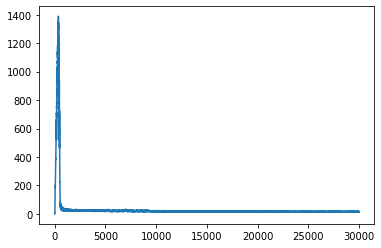

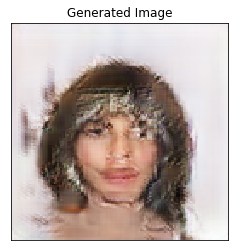

checkpointing at epoch: 30000
Iteration [30001/50000]......1.044(s) gen: 827.4625 - disc_fake: -824.9884 - disc_real: -811.8613 - neg_critic: 13.1271 - gp: 0.1401
Iteration [30002/50000]......1.041(s) gen: 823.6044 - disc_fake: -825.9264 - disc_real: -809.5982 - neg_critic: 16.3283 - gp: 0.1796
Iteration [30003/50000]......1.049(s) gen: 824.3004 - disc_fake: -823.4994 - disc_real: -808.3015 - neg_critic: 15.1979 - gp: 0.1681
Iteration [30004/50000]......1.051(s) gen: 826.0969 - disc_fake: -822.4732 - disc_real: -810.8597 - neg_critic: 11.6135 - gp: 0.1095
Iteration [30005/50000]......1.032(s) gen: 823.3507 - disc_fake: -825.1786 - disc_real: -811.4928 - neg_critic: 13.6858 - gp: 0.1450
Iteration [30006/50000]......1.049(s) gen: 824.1136 - disc_fake: -824.1574 - disc_real: -809.9696 - neg_critic: 14.1878 - gp: 0.1824
Iteration [30007/50000]......1.034(s) gen: 824.0270 - disc_fake: -823.8119 - disc_real: -808.5725 - neg_critic: 15.2395 - gp: 0.1450
Iteration [30008/50000]......1.049(s) g

Iteration [30063/50000]......0.863(s) gen: 831.3717 - disc_fake: -663.4132 - disc_real: -652.0901 - neg_critic: 11.3231 - gp: 0.1439
Iteration [30064/50000]......1.038(s) gen: 828.1195 - disc_fake: -828.7656 - disc_real: -813.4795 - neg_critic: 15.2862 - gp: 0.1700
Iteration [30065/50000]......1.049(s) gen: 822.7313 - disc_fake: -825.2575 - disc_real: -810.8345 - neg_critic: 14.4230 - gp: 0.1346
Iteration [30066/50000]......1.035(s) gen: 827.6213 - disc_fake: -824.8173 - disc_real: -810.3378 - neg_critic: 14.4796 - gp: 0.1736
Iteration [30067/50000]......1.049(s) gen: 826.2076 - disc_fake: -827.7159 - disc_real: -814.5963 - neg_critic: 13.1197 - gp: 0.1198
Iteration [30068/50000]......1.049(s) gen: 823.2926 - disc_fake: -824.8156 - disc_real: -810.2228 - neg_critic: 14.5928 - gp: 0.1262
Iteration [30069/50000]......1.034(s) gen: 821.5692 - disc_fake: -822.6390 - disc_real: -808.1252 - neg_critic: 14.5138 - gp: 0.1623
Iteration [30070/50000]......1.049(s) gen: 826.1405 - disc_fake: -824

Iteration [30125/50000]......1.034(s) gen: 822.5072 - disc_fake: -827.4221 - disc_real: -812.1589 - neg_critic: 15.2633 - gp: 0.1380
Iteration [30126/50000]......1.049(s) gen: 821.8372 - disc_fake: -823.3579 - disc_real: -807.1306 - neg_critic: 16.2273 - gp: 0.1883
Iteration [30127/50000]......1.034(s) gen: 827.2961 - disc_fake: -823.9355 - disc_real: -808.2966 - neg_critic: 15.6389 - gp: 0.1616
Iteration [30128/50000]......1.049(s) gen: 824.1277 - disc_fake: -826.5733 - disc_real: -812.2018 - neg_critic: 14.3715 - gp: 0.1773
Iteration [30129/50000]......1.050(s) gen: 822.2753 - disc_fake: -829.1272 - disc_real: -812.0673 - neg_critic: 17.0599 - gp: 0.1485
Iteration [30130/50000]......1.034(s) gen: 832.6458 - disc_fake: -829.8433 - disc_real: -815.9451 - neg_critic: 13.8982 - gp: 0.1836
Iteration [30131/50000]......1.049(s) gen: 830.0076 - disc_fake: -836.6794 - disc_real: -821.6342 - neg_critic: 15.0452 - gp: 0.1849
Iteration [30132/50000]......1.034(s) gen: 835.5508 - disc_fake: -833

Iteration [30187/50000]......1.034(s) gen: 826.9109 - disc_fake: -825.7597 - disc_real: -810.4245 - neg_critic: 15.3352 - gp: 0.1527
Iteration [30188/50000]......1.049(s) gen: 826.4834 - disc_fake: -827.1235 - disc_real: -813.1279 - neg_critic: 13.9956 - gp: 0.1423
Iteration [30189/50000]......1.050(s) gen: 828.6141 - disc_fake: -828.5086 - disc_real: -814.6871 - neg_critic: 13.8215 - gp: 0.1717
Iteration [30190/50000]......1.034(s) gen: 832.9250 - disc_fake: -828.9632 - disc_real: -815.8034 - neg_critic: 13.1598 - gp: 0.1244
Iteration [30191/50000]......1.049(s) gen: 832.0256 - disc_fake: -834.7660 - disc_real: -819.5852 - neg_critic: 15.1809 - gp: 0.1329
Iteration [30192/50000]......1.034(s) gen: 824.9045 - disc_fake: -825.3457 - disc_real: -811.1017 - neg_critic: 14.2440 - gp: 0.1494
Iteration [30193/50000]......1.049(s) gen: 825.3816 - disc_fake: -826.3621 - disc_real: -812.6259 - neg_critic: 13.7363 - gp: 0.1828
Iteration [30194/50000]......1.050(s) gen: 820.3297 - disc_fake: -822

Iteration [30249/50000]......1.035(s) gen: 828.0892 - disc_fake: -827.2659 - disc_real: -811.4624 - neg_critic: 15.8036 - gp: 0.2355
Iteration [30250/50000]......1.048(s) gen: 828.3325 - disc_fake: -828.6513 - disc_real: -813.4542 - neg_critic: 15.1971 - gp: 0.1406
Iteration [30251/50000]......1.034(s) gen: 823.5027 - disc_fake: -826.4016 - disc_real: -811.8060 - neg_critic: 14.5956 - gp: 0.1650
Iteration [30252/50000]......1.050(s) gen: 819.9366 - disc_fake: -822.5572 - disc_real: -807.7362 - neg_critic: 14.8210 - gp: 0.1752
Iteration [30253/50000]......1.033(s) gen: 821.7795 - disc_fake: -821.9904 - disc_real: -806.1228 - neg_critic: 15.8676 - gp: 0.1380
Iteration [30254/50000]......1.049(s) gen: 834.1885 - disc_fake: -827.8946 - disc_real: -814.3091 - neg_critic: 13.5855 - gp: 0.1648
Iteration [30255/50000]......1.050(s) gen: 825.4449 - disc_fake: -830.4213 - disc_real: -816.3999 - neg_critic: 14.0215 - gp: 0.1626
Iteration [30256/50000]......1.034(s) gen: 833.8941 - disc_fake: -830

Iteration [30311/50000]......1.049(s) gen: 825.8473 - disc_fake: -825.1130 - disc_real: -811.3899 - neg_critic: 13.7232 - gp: 0.1284
Iteration [30312/50000]......1.035(s) gen: 832.3177 - disc_fake: -828.2524 - disc_real: -814.0486 - neg_critic: 14.2038 - gp: 0.1308
Iteration [30313/50000]......1.048(s) gen: 824.7071 - disc_fake: -829.7496 - disc_real: -813.1267 - neg_critic: 16.6229 - gp: 0.1958
Iteration [30314/50000]......1.034(s) gen: 820.6016 - disc_fake: -823.8841 - disc_real: -809.7819 - neg_critic: 14.1022 - gp: 0.1663
Iteration [30315/50000]......1.049(s) gen: 829.7159 - disc_fake: -825.1301 - disc_real: -812.1884 - neg_critic: 12.9417 - gp: 0.1914
Iteration [30316/50000]......1.034(s) gen: 827.8311 - disc_fake: -828.4122 - disc_real: -814.3547 - neg_critic: 14.0575 - gp: 0.1315
Iteration [30317/50000]......1.049(s) gen: 824.8422 - disc_fake: -824.6458 - disc_real: -809.3298 - neg_critic: 15.3160 - gp: 0.1698
Iteration [30318/50000]......1.033(s) gen: 830.0961 - disc_fake: -824

Iteration [30373/50000]......1.049(s) gen: 828.4210 - disc_fake: -828.3112 - disc_real: -814.0645 - neg_critic: 14.2467 - gp: 0.1306
Iteration [30374/50000]......1.051(s) gen: 829.2706 - disc_fake: -827.3792 - disc_real: -811.8796 - neg_critic: 15.4996 - gp: 0.1855
Iteration [30375/50000]......1.033(s) gen: 826.7378 - disc_fake: -827.5380 - disc_real: -812.9620 - neg_critic: 14.5761 - gp: 0.1568
Iteration [30376/50000]......1.048(s) gen: 828.6543 - disc_fake: -826.2697 - disc_real: -811.2916 - neg_critic: 14.9781 - gp: 0.1449
Iteration [30377/50000]......1.050(s) gen: 826.5360 - disc_fake: -826.2873 - disc_real: -812.0052 - neg_critic: 14.2821 - gp: 0.1519
Iteration [30378/50000]......1.034(s) gen: 822.5795 - disc_fake: -824.0347 - disc_real: -808.0916 - neg_critic: 15.9431 - gp: 0.1802
Iteration [30379/50000]......1.049(s) gen: 829.5583 - disc_fake: -822.6931 - disc_real: -808.9835 - neg_critic: 13.7096 - gp: 0.1444
Iteration [30380/50000]......1.034(s) gen: 826.4299 - disc_fake: -826

Iteration [30435/50000]......1.049(s) gen: 828.8236 - disc_fake: -828.9167 - disc_real: -814.7590 - neg_critic: 14.1576 - gp: 0.1469
Iteration [30436/50000]......1.034(s) gen: 825.4417 - disc_fake: -825.7087 - disc_real: -811.2068 - neg_critic: 14.5020 - gp: 0.1318
Iteration [30437/50000]......1.049(s) gen: 821.4060 - disc_fake: -822.9738 - disc_real: -805.2365 - neg_critic: 17.7373 - gp: 0.2288
Iteration [30438/50000]......1.050(s) gen: 827.9800 - disc_fake: -824.3665 - disc_real: -808.8096 - neg_critic: 15.5569 - gp: 0.1808
Iteration [30439/50000]......1.034(s) gen: 829.0446 - disc_fake: -829.8240 - disc_real: -816.1062 - neg_critic: 13.7178 - gp: 0.1418
Iteration [30440/50000]......1.049(s) gen: 830.7254 - disc_fake: -830.2228 - disc_real: -817.8015 - neg_critic: 12.4213 - gp: 0.1301
Iteration [30441/50000]......1.034(s) gen: 831.3943 - disc_fake: -830.6919 - disc_real: -817.4411 - neg_critic: 13.2508 - gp: 0.1441
Iteration [30442/50000]......1.049(s) gen: 827.3580 - disc_fake: -829

Iteration [30497/50000]......1.049(s) gen: 829.0171 - disc_fake: -824.9167 - disc_real: -810.9001 - neg_critic: 14.0166 - gp: 0.1215
Iteration [30498/50000]......1.050(s) gen: 819.3699 - disc_fake: -823.9663 - disc_real: -809.2308 - neg_critic: 14.7355 - gp: 0.1786
Iteration [30499/50000]......1.034(s) gen: 822.8478 - disc_fake: -823.1158 - disc_real: -808.7335 - neg_critic: 14.3823 - gp: 0.1417
Iteration [30500/50000]......1.049(s) gen: 819.1545 - disc_fake: -820.4741 - disc_real: -805.5333 - neg_critic: 14.9408 - gp: 0.1676
Iteration [30501/50000]......1.034(s) gen: 828.3214 - disc_fake: -822.4964 - disc_real: -808.3888 - neg_critic: 14.1076 - gp: 0.1231
Iteration [30502/50000]......1.049(s) gen: 825.1268 - disc_fake: -825.6906 - disc_real: -809.8114 - neg_critic: 15.8792 - gp: 0.1920
Iteration [30503/50000]......1.034(s) gen: 829.1164 - disc_fake: -828.0681 - disc_real: -814.6871 - neg_critic: 13.3810 - gp: 0.1528
Iteration [30504/50000]......1.049(s) gen: 825.0786 - disc_fake: -827

Iteration [30559/50000]......1.049(s) gen: 832.9934 - disc_fake: -819.1597 - disc_real: -804.1399 - neg_critic: 15.0198 - gp: 0.1886
Iteration [30560/50000]......1.034(s) gen: 831.4565 - disc_fake: -831.4384 - disc_real: -818.3962 - neg_critic: 13.0422 - gp: 0.1234
Iteration [30561/50000]......1.046(s) gen: 833.7073 - disc_fake: -831.9468 - disc_real: -817.5729 - neg_critic: 14.3739 - gp: 0.1176
Iteration [30562/50000]......1.037(s) gen: 832.4491 - disc_fake: -831.8438 - disc_real: -815.9586 - neg_critic: 15.8852 - gp: 0.2180
Iteration [30563/50000]......1.049(s) gen: 835.8553 - disc_fake: -835.3935 - disc_real: -820.7807 - neg_critic: 14.6128 - gp: 0.1814
Iteration [30564/50000]......1.050(s) gen: 829.7025 - disc_fake: -830.4286 - disc_real: -815.7000 - neg_critic: 14.7286 - gp: 0.1172
Iteration [30565/50000]......1.034(s) gen: 834.2521 - disc_fake: -831.2081 - disc_real: -817.6905 - neg_critic: 13.5176 - gp: 0.1427
Iteration [30566/50000]......1.083(s) gen: 827.7904 - disc_fake: -831

Iteration [30621/50000]......1.049(s) gen: 826.9605 - disc_fake: -826.7015 - disc_real: -810.4707 - neg_critic: 16.2308 - gp: 0.1933
Iteration [30622/50000]......1.050(s) gen: 829.5034 - disc_fake: -825.9480 - disc_real: -811.1317 - neg_critic: 14.8164 - gp: 0.1776
Iteration [30623/50000]......1.034(s) gen: 829.9956 - disc_fake: -826.7334 - disc_real: -812.6627 - neg_critic: 14.0707 - gp: 0.1634
Iteration [30624/50000]......1.049(s) gen: 828.4597 - disc_fake: -829.1140 - disc_real: -815.3228 - neg_critic: 13.7912 - gp: 0.1305
Iteration [30625/50000]......1.034(s) gen: 822.8338 - disc_fake: -824.7924 - disc_real: -809.6779 - neg_critic: 15.1144 - gp: 0.1491
Iteration [30626/50000]......1.050(s) gen: 824.2222 - disc_fake: -823.4661 - disc_real: -809.7235 - neg_critic: 13.7426 - gp: 0.1496
Iteration [30627/50000]......1.048(s) gen: 826.6210 - disc_fake: -826.7168 - disc_real: -813.1997 - neg_critic: 13.5172 - gp: 0.1539
Iteration [30628/50000]......1.034(s) gen: 827.7275 - disc_fake: -827

Iteration [30683/50000]......1.048(s) gen: 830.5186 - disc_fake: -827.5303 - disc_real: -813.0910 - neg_critic: 14.4393 - gp: 0.1809
Iteration [30684/50000]......1.034(s) gen: 832.3138 - disc_fake: -829.4894 - disc_real: -814.3058 - neg_critic: 15.1836 - gp: 0.1605
Iteration [30685/50000]......1.049(s) gen: 824.1122 - disc_fake: -828.3673 - disc_real: -815.0179 - neg_critic: 13.3494 - gp: 0.1732
Iteration [30686/50000]......1.034(s) gen: 829.9179 - disc_fake: -824.3723 - disc_real: -809.6212 - neg_critic: 14.7511 - gp: 0.1353
Iteration [30687/50000]......1.049(s) gen: 824.6257 - disc_fake: -829.3218 - disc_real: -814.3497 - neg_critic: 14.9721 - gp: 0.1473
Iteration [30688/50000]......1.034(s) gen: 824.4541 - disc_fake: -822.4205 - disc_real: -806.9789 - neg_critic: 15.4415 - gp: 0.1529
Iteration [30689/50000]......1.049(s) gen: 819.6716 - disc_fake: -823.7063 - disc_real: -808.1204 - neg_critic: 15.5859 - gp: 0.1565
Iteration [30690/50000]......1.034(s) gen: 832.2631 - disc_fake: -824

Iteration [30745/50000]......1.034(s) gen: 828.2600 - disc_fake: -826.4060 - disc_real: -810.4862 - neg_critic: 15.9198 - gp: 0.1922
Iteration [30746/50000]......1.050(s) gen: 827.5757 - disc_fake: -826.3275 - disc_real: -811.4932 - neg_critic: 14.8343 - gp: 0.1569
Iteration [30747/50000]......1.049(s) gen: 825.3370 - disc_fake: -826.2761 - disc_real: -810.8994 - neg_critic: 15.3767 - gp: 0.1813
Iteration [30748/50000]......1.034(s) gen: 821.0947 - disc_fake: -823.8364 - disc_real: -808.9222 - neg_critic: 14.9142 - gp: 0.1445
Iteration [30749/50000]......1.051(s) gen: 823.0118 - disc_fake: -823.8728 - disc_real: -808.3329 - neg_critic: 15.5398 - gp: 0.1588
Iteration [30750/50000]......1.047(s) gen: 821.2896 - disc_fake: -821.5550 - disc_real: -806.7544 - neg_critic: 14.8005 - gp: 0.2499
Iteration [30751/50000]......1.047(s) gen: 825.3295 - disc_fake: -820.7151 - disc_real: -805.0657 - neg_critic: 15.6494 - gp: 0.1390
Iteration [30752/50000]......1.053(s) gen: 817.8359 - disc_fake: -825

Iteration [30807/50000]......1.050(s) gen: 833.4000 - disc_fake: -827.6251 - disc_real: -811.7914 - neg_critic: 15.8337 - gp: 0.1471
Iteration [30808/50000]......1.034(s) gen: 831.2835 - disc_fake: -830.7501 - disc_real: -815.3920 - neg_critic: 15.3580 - gp: 0.1864
Iteration [30809/50000]......1.049(s) gen: 830.0425 - disc_fake: -830.6612 - disc_real: -816.0877 - neg_critic: 14.5735 - gp: 0.1568
Iteration [30810/50000]......1.049(s) gen: 826.7977 - disc_fake: -825.5983 - disc_real: -810.3753 - neg_critic: 15.2230 - gp: 0.1683
Iteration [30811/50000]......1.034(s) gen: 827.9701 - disc_fake: -826.4210 - disc_real: -812.8220 - neg_critic: 13.5990 - gp: 0.1623
Iteration [30812/50000]......1.049(s) gen: 829.5322 - disc_fake: -825.5777 - disc_real: -812.6076 - neg_critic: 12.9701 - gp: 0.1438
Iteration [30813/50000]......1.034(s) gen: 828.3394 - disc_fake: -828.0829 - disc_real: -812.1678 - neg_critic: 15.9151 - gp: 0.1715
Iteration [30814/50000]......1.049(s) gen: 827.2524 - disc_fake: -826

Iteration [30869/50000]......1.033(s) gen: 829.6999 - disc_fake: -829.7129 - disc_real: -815.8712 - neg_critic: 13.8417 - gp: 0.1415
Iteration [30870/50000]......1.049(s) gen: 832.7666 - disc_fake: -831.0720 - disc_real: -817.2921 - neg_critic: 13.7799 - gp: 0.1373
Iteration [30871/50000]......1.034(s) gen: 834.1890 - disc_fake: -831.0541 - disc_real: -816.0446 - neg_critic: 15.0095 - gp: 0.1614
Iteration [30872/50000]......1.049(s) gen: 829.9321 - disc_fake: -833.6857 - disc_real: -818.8499 - neg_critic: 14.8357 - gp: 0.1601
Iteration [30873/50000]......1.034(s) gen: 832.2302 - disc_fake: -828.2075 - disc_real: -814.8463 - neg_critic: 13.3612 - gp: 0.1364
Iteration [30874/50000]......1.049(s) gen: 827.9673 - disc_fake: -829.2035 - disc_real: -814.2981 - neg_critic: 14.9054 - gp: 0.1704
Iteration [30875/50000]......1.050(s) gen: 825.9868 - disc_fake: -826.8913 - disc_real: -808.7858 - neg_critic: 18.1055 - gp: 0.2157
Iteration [30876/50000]......1.034(s) gen: 827.5101 - disc_fake: -826

Iteration [30931/50000]......1.034(s) gen: 831.4009 - disc_fake: -826.2964 - disc_real: -811.1164 - neg_critic: 15.1799 - gp: 0.1793
Iteration [30932/50000]......1.049(s) gen: 829.3301 - disc_fake: -828.9697 - disc_real: -813.6116 - neg_critic: 15.3581 - gp: 0.1831
Iteration [30933/50000]......1.034(s) gen: 833.5276 - disc_fake: -830.0781 - disc_real: -815.7132 - neg_critic: 14.3649 - gp: 0.1112
Iteration [30934/50000]......1.049(s) gen: 826.7905 - disc_fake: -832.8023 - disc_real: -814.8986 - neg_critic: 17.9037 - gp: 0.2064
Iteration [30935/50000]......1.034(s) gen: 828.8529 - disc_fake: -828.9661 - disc_real: -815.3865 - neg_critic: 13.5796 - gp: 0.1785
Iteration [30936/50000]......1.049(s) gen: 834.4396 - disc_fake: -830.2150 - disc_real: -815.8958 - neg_critic: 14.3192 - gp: 0.1329
Iteration [30937/50000]......1.050(s) gen: 829.3752 - disc_fake: -828.5858 - disc_real: -814.4296 - neg_critic: 14.1561 - gp: 0.1647
Iteration [30938/50000]......1.035(s) gen: 831.2478 - disc_fake: -828

Iteration [30993/50000]......1.051(s) gen: 825.5703 - disc_fake: -832.1216 - disc_real: -817.1238 - neg_critic: 14.9979 - gp: 0.1707
Iteration [30994/50000]......1.033(s) gen: 823.8743 - disc_fake: -826.7399 - disc_real: -811.1089 - neg_critic: 15.6310 - gp: 0.1868
Iteration [30995/50000]......1.049(s) gen: 834.3366 - disc_fake: -826.9128 - disc_real: -813.2342 - neg_critic: 13.6786 - gp: 0.1455
Iteration [30996/50000]......1.034(s) gen: 827.8494 - disc_fake: -831.9311 - disc_real: -817.8121 - neg_critic: 14.1190 - gp: 0.1474
Iteration [30997/50000]......1.049(s) gen: 834.1585 - disc_fake: -829.0606 - disc_real: -815.0798 - neg_critic: 13.9807 - gp: 0.1428
Iteration [30998/50000]......1.035(s) gen: 830.3639 - disc_fake: -830.8128 - disc_real: -816.2745 - neg_critic: 14.5383 - gp: 0.1816
Iteration [30999/50000]......1.048(s) gen: 830.8860 - disc_fake: -831.7652 - disc_real: -817.6861 - neg_critic: 14.0790 - gp: 0.1230
Iteration [31000/50000]......1.036(s) gen: 834.9794 - disc_fake: -833

Iteration [31055/50000]......1.034(s) gen: 832.9274 - disc_fake: -834.1078 - disc_real: -819.1709 - neg_critic: 14.9369 - gp: 0.1721
Iteration [31056/50000]......1.048(s) gen: 833.8055 - disc_fake: -833.3778 - disc_real: -818.4386 - neg_critic: 14.9392 - gp: 0.1529
Iteration [31057/50000]......1.034(s) gen: 834.1737 - disc_fake: -834.5437 - disc_real: -821.2089 - neg_critic: 13.3348 - gp: 0.1346
Iteration [31058/50000]......1.049(s) gen: 836.9637 - disc_fake: -834.5502 - disc_real: -820.6964 - neg_critic: 13.8538 - gp: 0.1330
Iteration [31059/50000]......1.034(s) gen: 833.6238 - disc_fake: -836.1866 - disc_real: -820.0833 - neg_critic: 16.1033 - gp: 0.1692
Iteration [31060/50000]......1.049(s) gen: 842.5572 - disc_fake: -836.3697 - disc_real: -822.0043 - neg_critic: 14.3654 - gp: 0.1698
Iteration [31061/50000]......1.034(s) gen: 836.6410 - disc_fake: -839.0958 - disc_real: -825.2936 - neg_critic: 13.8022 - gp: 0.1645
Iteration [31062/50000]......1.049(s) gen: 838.8204 - disc_fake: -836

Iteration [31117/50000]......1.049(s) gen: 834.9136 - disc_fake: -833.2744 - disc_real: -816.7707 - neg_critic: 16.5037 - gp: 0.1538
Iteration [31118/50000]......1.050(s) gen: 831.7156 - disc_fake: -834.3985 - disc_real: -818.1688 - neg_critic: 16.2298 - gp: 0.2092
Iteration [31119/50000]......1.034(s) gen: 834.6021 - disc_fake: -836.6816 - disc_real: -821.3344 - neg_critic: 15.3473 - gp: 0.1705
Iteration [31120/50000]......1.049(s) gen: 831.4413 - disc_fake: -834.4969 - disc_real: -820.0398 - neg_critic: 14.4571 - gp: 0.1575
Iteration [31121/50000]......1.034(s) gen: 836.7245 - disc_fake: -833.3194 - disc_real: -817.7853 - neg_critic: 15.5341 - gp: 0.1906
Iteration [31122/50000]......1.049(s) gen: 836.9938 - disc_fake: -834.4759 - disc_real: -819.4718 - neg_critic: 15.0041 - gp: 0.1224
Iteration [31123/50000]......1.036(s) gen: 833.4310 - disc_fake: -831.7145 - disc_real: -816.9531 - neg_critic: 14.7615 - gp: 0.1903
Iteration [31124/50000]......1.033(s) gen: 833.7150 - disc_fake: -832

Iteration [31179/50000]......1.050(s) gen: 834.9604 - disc_fake: -834.6464 - disc_real: -819.9452 - neg_critic: 14.7012 - gp: 0.1272
Iteration [31180/50000]......1.034(s) gen: 835.6262 - disc_fake: -835.8362 - disc_real: -820.5794 - neg_critic: 15.2568 - gp: 0.1661
Iteration [31181/50000]......1.049(s) gen: 837.7469 - disc_fake: -833.8104 - disc_real: -819.4596 - neg_critic: 14.3508 - gp: 0.1744
Iteration [31182/50000]......1.034(s) gen: 835.8304 - disc_fake: -836.1162 - disc_real: -821.6087 - neg_critic: 14.5075 - gp: 0.1540
Iteration [31183/50000]......1.048(s) gen: 831.9757 - disc_fake: -832.1725 - disc_real: -815.5907 - neg_critic: 16.5818 - gp: 0.1886
Iteration [31184/50000]......1.050(s) gen: 835.9780 - disc_fake: -833.5550 - disc_real: -818.8881 - neg_critic: 14.6669 - gp: 0.1659
Iteration [31185/50000]......1.034(s) gen: 826.7498 - disc_fake: -832.0007 - disc_real: -816.1345 - neg_critic: 15.8662 - gp: 0.1909
Iteration [31186/50000]......1.049(s) gen: 829.5593 - disc_fake: -830

Iteration [31241/50000]......1.049(s) gen: 840.9332 - disc_fake: -840.7514 - disc_real: -824.8157 - neg_critic: 15.9357 - gp: 0.1852
Iteration [31242/50000]......1.050(s) gen: 838.7600 - disc_fake: -837.8702 - disc_real: -824.1557 - neg_critic: 13.7145 - gp: 0.1374
Iteration [31243/50000]......1.034(s) gen: 839.4506 - disc_fake: -837.5362 - disc_real: -823.9032 - neg_critic: 13.6330 - gp: 0.1532
Iteration [31244/50000]......1.049(s) gen: 840.1848 - disc_fake: -836.9415 - disc_real: -822.5615 - neg_critic: 14.3799 - gp: 0.1506
Iteration [31245/50000]......1.050(s) gen: 836.1254 - disc_fake: -835.1253 - disc_real: -820.7574 - neg_critic: 14.3679 - gp: 0.1795
Iteration [31246/50000]......1.034(s) gen: 842.2101 - disc_fake: -837.9790 - disc_real: -823.7537 - neg_critic: 14.2253 - gp: 0.1261
Iteration [31247/50000]......1.049(s) gen: 838.2675 - disc_fake: -838.6625 - disc_real: -824.2526 - neg_critic: 14.4099 - gp: 0.1670
Iteration [31248/50000]......1.034(s) gen: 827.4838 - disc_fake: -834

Iteration [31303/50000]......1.034(s) gen: 842.0549 - disc_fake: -839.2719 - disc_real: -824.1506 - neg_critic: 15.1213 - gp: 0.1541
Iteration [31304/50000]......1.050(s) gen: 836.2012 - disc_fake: -840.1409 - disc_real: -825.3763 - neg_critic: 14.7646 - gp: 0.1321
Iteration [31305/50000]......1.033(s) gen: 839.1535 - disc_fake: -836.9298 - disc_real: -821.5143 - neg_critic: 15.4155 - gp: 0.2055
Iteration [31306/50000]......1.049(s) gen: 838.8809 - disc_fake: -839.1538 - disc_real: -826.0861 - neg_critic: 13.0677 - gp: 0.1495
Iteration [31307/50000]......1.050(s) gen: 843.6218 - disc_fake: -839.9480 - disc_real: -827.2084 - neg_critic: 12.7396 - gp: 0.1224
Iteration [31308/50000]......1.034(s) gen: 841.8928 - disc_fake: -841.1585 - disc_real: -827.6626 - neg_critic: 13.4959 - gp: 0.1416
Iteration [31309/50000]......1.048(s) gen: 842.4285 - disc_fake: -841.9117 - disc_real: -828.0533 - neg_critic: 13.8584 - gp: 0.1824
Iteration [31310/50000]......1.050(s) gen: 838.3804 - disc_fake: -840

Iteration [31365/50000]......1.049(s) gen: 835.2770 - disc_fake: -839.2951 - disc_real: -824.3861 - neg_critic: 14.9090 - gp: 0.1947
Iteration [31366/50000]......1.050(s) gen: 835.5929 - disc_fake: -835.2598 - disc_real: -821.1891 - neg_critic: 14.0707 - gp: 0.1413
Iteration [31367/50000]......1.034(s) gen: 840.4989 - disc_fake: -838.7859 - disc_real: -825.8737 - neg_critic: 12.9122 - gp: 0.1351
Iteration [31368/50000]......1.049(s) gen: 831.0947 - disc_fake: -838.7905 - disc_real: -822.1650 - neg_critic: 16.6255 - gp: 0.1721
Iteration [31369/50000]......1.050(s) gen: 844.5365 - disc_fake: -835.6271 - disc_real: -822.1622 - neg_critic: 13.4649 - gp: 0.1756
Iteration [31370/50000]......1.033(s) gen: 842.0659 - disc_fake: -841.9583 - disc_real: -827.8515 - neg_critic: 14.1068 - gp: 0.1533
Iteration [31371/50000]......1.049(s) gen: 839.4830 - disc_fake: -841.8285 - disc_real: -827.5357 - neg_critic: 14.2928 - gp: 0.1173
Iteration [31372/50000]......1.034(s) gen: 834.2286 - disc_fake: -836

Iteration [31427/50000]......1.034(s) gen: 842.5795 - disc_fake: -842.4138 - disc_real: -828.3621 - neg_critic: 14.0517 - gp: 0.1878
Iteration [31428/50000]......1.049(s) gen: 839.8903 - disc_fake: -840.1261 - disc_real: -827.2448 - neg_critic: 12.8814 - gp: 0.1165
Iteration [31429/50000]......1.034(s) gen: 835.9652 - disc_fake: -838.9811 - disc_real: -824.3433 - neg_critic: 14.6378 - gp: 0.1590
Iteration [31430/50000]......1.049(s) gen: 839.8429 - disc_fake: -837.1913 - disc_real: -822.1026 - neg_critic: 15.0887 - gp: 0.1647
Iteration [31431/50000]......1.034(s) gen: 836.5275 - disc_fake: -838.7015 - disc_real: -823.3402 - neg_critic: 15.3613 - gp: 0.1497
Iteration [31432/50000]......1.049(s) gen: 834.7623 - disc_fake: -837.2602 - disc_real: -822.5283 - neg_critic: 14.7319 - gp: 0.1723
Iteration [31433/50000]......1.033(s) gen: 836.9786 - disc_fake: -838.0632 - disc_real: -825.4014 - neg_critic: 12.6618 - gp: 0.1436
Iteration [31434/50000]......1.034(s) gen: 838.5211 - disc_fake: -837

Iteration [31489/50000]......1.034(s) gen: 840.5364 - disc_fake: -839.7964 - disc_real: -824.6848 - neg_critic: 15.1116 - gp: 0.1579
Iteration [31490/50000]......1.049(s) gen: 835.9257 - disc_fake: -838.6422 - disc_real: -825.3869 - neg_critic: 13.2553 - gp: 0.1598
Iteration [31491/50000]......1.034(s) gen: 841.9573 - disc_fake: -837.9190 - disc_real: -823.9553 - neg_critic: 13.9638 - gp: 0.1355
Iteration [31492/50000]......1.049(s) gen: 839.0474 - disc_fake: -842.8190 - disc_real: -827.7992 - neg_critic: 15.0198 - gp: 0.1983
Iteration [31493/50000]......1.034(s) gen: 835.4694 - disc_fake: -837.4406 - disc_real: -822.9973 - neg_critic: 14.4433 - gp: 0.1616
Iteration [31494/50000]......1.048(s) gen: 835.2866 - disc_fake: -837.6454 - disc_real: -824.4109 - neg_critic: 13.2345 - gp: 0.1159
Iteration [31495/50000]......1.034(s) gen: 836.4714 - disc_fake: -837.3122 - disc_real: -824.6052 - neg_critic: 12.7069 - gp: 0.1513
Iteration [31496/50000]......1.049(s) gen: 837.0303 - disc_fake: -837

Iteration [31551/50000]......1.034(s) gen: 841.8083 - disc_fake: -841.4601 - disc_real: -827.2868 - neg_critic: 14.1733 - gp: 0.1508
Iteration [31552/50000]......1.049(s) gen: 840.5428 - disc_fake: -840.1511 - disc_real: -824.3918 - neg_critic: 15.7594 - gp: 0.1486
Iteration [31553/50000]......1.050(s) gen: 836.1097 - disc_fake: -839.0834 - disc_real: -825.1625 - neg_critic: 13.9208 - gp: 0.1732
Iteration [31554/50000]......1.034(s) gen: 834.7930 - disc_fake: -836.4850 - disc_real: -821.4020 - neg_critic: 15.0830 - gp: 0.1622
Iteration [31555/50000]......1.056(s) gen: 824.7405 - disc_fake: -828.8776 - disc_real: -812.5114 - neg_critic: 16.3663 - gp: 0.1711
Iteration [31556/50000]......1.043(s) gen: 831.2748 - disc_fake: -828.4098 - disc_real: -813.4011 - neg_critic: 15.0087 - gp: 0.1652
Iteration [31557/50000]......1.051(s) gen: 832.1042 - disc_fake: -833.7019 - disc_real: -819.7689 - neg_critic: 13.9330 - gp: 0.1460
Iteration [31558/50000]......1.032(s) gen: 841.1879 - disc_fake: -835

Iteration [31613/50000]......1.049(s) gen: 840.8365 - disc_fake: -838.6058 - disc_real: -824.1324 - neg_critic: 14.4733 - gp: 0.1554
Iteration [31614/50000]......1.034(s) gen: 841.6017 - disc_fake: -843.0757 - disc_real: -828.8562 - neg_critic: 14.2195 - gp: 0.1564
Iteration [31615/50000]......1.048(s) gen: 841.7567 - disc_fake: -841.6003 - disc_real: -826.9930 - neg_critic: 14.6073 - gp: 0.1396
Iteration [31616/50000]......1.050(s) gen: 841.1913 - disc_fake: -842.3914 - disc_real: -827.1222 - neg_critic: 15.2692 - gp: 0.1389
Iteration [31617/50000]......1.036(s) gen: 839.8874 - disc_fake: -836.0529 - disc_real: -820.1727 - neg_critic: 15.8802 - gp: 0.2017
Iteration [31618/50000]......1.048(s) gen: 838.6851 - disc_fake: -837.0994 - disc_real: -819.9791 - neg_critic: 17.1203 - gp: 0.1705
Iteration [31619/50000]......1.034(s) gen: 837.3746 - disc_fake: -837.8937 - disc_real: -823.2501 - neg_critic: 14.6436 - gp: 0.1640
Iteration [31620/50000]......1.049(s) gen: 843.3560 - disc_fake: -840

Iteration [31675/50000]......1.048(s) gen: 846.0488 - disc_fake: -841.7633 - disc_real: -826.4628 - neg_critic: 15.3005 - gp: 0.1316
Iteration [31676/50000]......1.034(s) gen: 840.5850 - disc_fake: -842.4538 - disc_real: -827.8119 - neg_critic: 14.6420 - gp: 0.1881
Iteration [31677/50000]......1.048(s) gen: 844.5638 - disc_fake: -842.2696 - disc_real: -827.5408 - neg_critic: 14.7288 - gp: 0.1397
Iteration [31678/50000]......1.050(s) gen: 837.6429 - disc_fake: -841.1242 - disc_real: -825.1211 - neg_critic: 16.0031 - gp: 0.1586
Iteration [31679/50000]......1.034(s) gen: 837.0494 - disc_fake: -838.6828 - disc_real: -824.2295 - neg_critic: 14.4532 - gp: 0.1666
Iteration [31680/50000]......1.049(s) gen: 843.6810 - disc_fake: -840.2221 - disc_real: -826.7073 - neg_critic: 13.5148 - gp: 0.1416
Iteration [31681/50000]......1.050(s) gen: 845.4343 - disc_fake: -844.6834 - disc_real: -829.9136 - neg_critic: 14.7699 - gp: 0.1730
Iteration [31682/50000]......1.034(s) gen: 840.9354 - disc_fake: -841

Iteration [31737/50000]......1.049(s) gen: 842.6007 - disc_fake: -840.9354 - disc_real: -825.6958 - neg_critic: 15.2396 - gp: 0.1472
Iteration [31738/50000]......1.034(s) gen: 844.8461 - disc_fake: -841.6475 - disc_real: -827.3220 - neg_critic: 14.3255 - gp: 0.1434
Iteration [31739/50000]......1.049(s) gen: 845.9409 - disc_fake: -844.3721 - disc_real: -830.7434 - neg_critic: 13.6287 - gp: 0.1844
Iteration [31740/50000]......1.034(s) gen: 846.8428 - disc_fake: -845.8874 - disc_real: -831.3006 - neg_critic: 14.5868 - gp: 0.1261
Iteration [31741/50000]......1.049(s) gen: 846.9506 - disc_fake: -844.4863 - disc_real: -829.0409 - neg_critic: 15.4454 - gp: 0.1847
Iteration [31742/50000]......1.033(s) gen: 840.3918 - disc_fake: -840.9489 - disc_real: -826.2786 - neg_critic: 14.6704 - gp: 0.1699
Iteration [31743/50000]......1.049(s) gen: 841.8401 - disc_fake: -839.7352 - disc_real: -824.7181 - neg_critic: 15.0170 - gp: 0.1673
Iteration [31744/50000]......1.034(s) gen: 839.6482 - disc_fake: -839

Iteration [31799/50000]......1.049(s) gen: 836.7638 - disc_fake: -839.8498 - disc_real: -823.3347 - neg_critic: 16.5151 - gp: 0.1516
Iteration [31800/50000]......1.050(s) gen: 841.6906 - disc_fake: -838.4443 - disc_real: -823.6529 - neg_critic: 14.7914 - gp: 0.1856
Iteration [31801/50000]......1.034(s) gen: 843.7369 - disc_fake: -840.6489 - disc_real: -826.4585 - neg_critic: 14.1904 - gp: 0.1678
Iteration [31802/50000]......1.048(s) gen: 842.7289 - disc_fake: -845.7649 - disc_real: -831.3372 - neg_critic: 14.4277 - gp: 0.1556
Iteration [31803/50000]......1.034(s) gen: 851.4482 - disc_fake: -846.5232 - disc_real: -833.2011 - neg_critic: 13.3221 - gp: 0.1242
Iteration [31804/50000]......1.050(s) gen: 850.9213 - disc_fake: -848.2858 - disc_real: -834.6682 - neg_critic: 13.6176 - gp: 0.1499
Iteration [31805/50000]......1.033(s) gen: 842.3734 - disc_fake: -847.5606 - disc_real: -834.0210 - neg_critic: 13.5396 - gp: 0.1710
Iteration [31806/50000]......1.049(s) gen: 836.7535 - disc_fake: -842

Iteration [31861/50000]......1.034(s) gen: 842.8786 - disc_fake: -843.8965 - disc_real: -829.2839 - neg_critic: 14.6126 - gp: 0.1512
Iteration [31862/50000]......1.049(s) gen: 845.3891 - disc_fake: -844.7130 - disc_real: -830.5388 - neg_critic: 14.1741 - gp: 0.1764
Iteration [31863/50000]......1.034(s) gen: 850.1952 - disc_fake: -847.7954 - disc_real: -833.1215 - neg_critic: 14.6739 - gp: 0.1324
Iteration [31864/50000]......1.050(s) gen: 847.3102 - disc_fake: -847.5324 - disc_real: -834.7417 - neg_critic: 12.7908 - gp: 0.1656
Iteration [31865/50000]......1.049(s) gen: 845.2656 - disc_fake: -845.6107 - disc_real: -831.0738 - neg_critic: 14.5369 - gp: 0.1237
Iteration [31866/50000]......1.034(s) gen: 837.6938 - disc_fake: -842.3922 - disc_real: -827.5127 - neg_critic: 14.8795 - gp: 0.1555
Iteration [31867/50000]......1.049(s) gen: 840.6632 - disc_fake: -839.2192 - disc_real: -824.2152 - neg_critic: 15.0040 - gp: 0.1652
Iteration [31868/50000]......1.050(s) gen: 842.1614 - disc_fake: -842

Iteration [31923/50000]......1.034(s) gen: 847.3083 - disc_fake: -845.9568 - disc_real: -831.3573 - neg_critic: 14.5994 - gp: 0.1770
Iteration [31924/50000]......1.049(s) gen: 846.8834 - disc_fake: -847.3100 - disc_real: -833.6891 - neg_critic: 13.6210 - gp: 0.1094
Iteration [31925/50000]......1.049(s) gen: 847.6188 - disc_fake: -845.8115 - disc_real: -830.6500 - neg_critic: 15.1615 - gp: 0.2286
Iteration [31926/50000]......1.034(s) gen: 844.2571 - disc_fake: -847.1981 - disc_real: -833.7156 - neg_critic: 13.4824 - gp: 0.1310
Iteration [31927/50000]......1.049(s) gen: 846.2560 - disc_fake: -844.6312 - disc_real: -829.9574 - neg_critic: 14.6739 - gp: 0.1669
Iteration [31928/50000]......1.034(s) gen: 848.5167 - disc_fake: -848.4471 - disc_real: -833.2335 - neg_critic: 15.2135 - gp: 0.1476
Iteration [31929/50000]......1.049(s) gen: 855.5198 - disc_fake: -852.1250 - disc_real: -836.7405 - neg_critic: 15.3846 - gp: 0.1419
Iteration [31930/50000]......1.034(s) gen: 853.6134 - disc_fake: -853

Iteration [31985/50000]......1.049(s) gen: 851.9235 - disc_fake: -851.2942 - disc_real: -837.0598 - neg_critic: 14.2344 - gp: 0.1733
Iteration [31986/50000]......1.050(s) gen: 850.6766 - disc_fake: -849.5180 - disc_real: -833.9639 - neg_critic: 15.5541 - gp: 0.1419
Iteration [31987/50000]......1.034(s) gen: 847.8386 - disc_fake: -850.1760 - disc_real: -834.0542 - neg_critic: 16.1217 - gp: 0.1853
Iteration [31988/50000]......1.048(s) gen: 849.6036 - disc_fake: -848.0590 - disc_real: -834.0675 - neg_critic: 13.9915 - gp: 0.1530
Iteration [31989/50000]......1.052(s) gen: 845.2087 - disc_fake: -847.8677 - disc_real: -833.4793 - neg_critic: 14.3884 - gp: 0.1528
Iteration [31990/50000]......1.032(s) gen: 843.9476 - disc_fake: -846.7544 - disc_real: -830.1810 - neg_critic: 16.5734 - gp: 0.1827
Iteration [31991/50000]......1.049(s) gen: 848.9698 - disc_fake: -844.6243 - disc_real: -829.5227 - neg_critic: 15.1016 - gp: 0.1522
Iteration [31992/50000]......1.050(s) gen: 849.6357 - disc_fake: -848

Iteration [32047/50000]......1.034(s) gen: 849.5862 - disc_fake: -848.0781 - disc_real: -833.0174 - neg_critic: 15.0608 - gp: 0.1620
Iteration [32048/50000]......1.049(s) gen: 845.7051 - disc_fake: -848.1606 - disc_real: -832.9448 - neg_critic: 15.2158 - gp: 0.1642
Iteration [32049/50000]......1.050(s) gen: 844.2358 - disc_fake: -845.6354 - disc_real: -832.3213 - neg_critic: 13.3141 - gp: 0.1658
Iteration [32050/50000]......1.034(s) gen: 848.3273 - disc_fake: -846.1061 - disc_real: -831.2130 - neg_critic: 14.8931 - gp: 0.1799
Iteration [32051/50000]......1.049(s) gen: 846.0966 - disc_fake: -847.2028 - disc_real: -832.9717 - neg_critic: 14.2311 - gp: 0.1647
Iteration [32052/50000]......1.036(s) gen: 849.5771 - disc_fake: -847.8931 - disc_real: -834.6170 - neg_critic: 13.2761 - gp: 0.1255
Iteration [32053/50000]......1.048(s) gen: 849.0690 - disc_fake: -847.7404 - disc_real: -833.6346 - neg_critic: 14.1058 - gp: 0.1718
Iteration [32054/50000]......1.034(s) gen: 852.4519 - disc_fake: -851

Iteration [32109/50000]......1.048(s) gen: 851.4670 - disc_fake: -850.2194 - disc_real: -836.0718 - neg_critic: 14.1476 - gp: 0.1366
Iteration [32110/50000]......1.034(s) gen: 847.8757 - disc_fake: -847.9645 - disc_real: -832.5024 - neg_critic: 15.4621 - gp: 0.1988
Iteration [32111/50000]......1.049(s) gen: 844.1851 - disc_fake: -844.7257 - disc_real: -830.5343 - neg_critic: 14.1914 - gp: 0.1489
Iteration [32112/50000]......1.034(s) gen: 845.9167 - disc_fake: -843.9333 - disc_real: -829.7749 - neg_critic: 14.1583 - gp: 0.1467
Iteration [32113/50000]......1.049(s) gen: 845.9393 - disc_fake: -845.7689 - disc_real: -830.8313 - neg_critic: 14.9375 - gp: 0.1237
Iteration [32114/50000]......1.034(s) gen: 846.4601 - disc_fake: -846.0847 - disc_real: -830.3408 - neg_critic: 15.7439 - gp: 0.1879
Iteration [32115/50000]......1.033(s) gen: 849.4122 - disc_fake: -846.4145 - disc_real: -832.1991 - neg_critic: 14.2153 - gp: 0.1708
Iteration [32116/50000]......1.049(s) gen: 853.8028 - disc_fake: -850

Iteration [32171/50000]......1.049(s) gen: 850.1699 - disc_fake: -847.1812 - disc_real: -831.7203 - neg_critic: 15.4609 - gp: 0.1719
Iteration [32172/50000]......1.034(s) gen: 847.9307 - disc_fake: -849.1366 - disc_real: -834.9272 - neg_critic: 14.2095 - gp: 0.1616
Iteration [32173/50000]......1.049(s) gen: 852.2432 - disc_fake: -850.6911 - disc_real: -837.3411 - neg_critic: 13.3500 - gp: 0.1488
Iteration [32174/50000]......1.034(s) gen: 850.1708 - disc_fake: -850.9918 - disc_real: -837.0089 - neg_critic: 13.9829 - gp: 0.1377
Iteration [32175/50000]......1.049(s) gen: 838.6710 - disc_fake: -846.1638 - disc_real: -829.8174 - neg_critic: 16.3464 - gp: 0.1936
Iteration [32176/50000]......1.034(s) gen: 852.4493 - disc_fake: -844.2740 - disc_real: -829.9168 - neg_critic: 14.3573 - gp: 0.1704
Iteration [32177/50000]......1.049(s) gen: 842.7463 - disc_fake: -848.3268 - disc_real: -834.8970 - neg_critic: 13.4298 - gp: 0.1343
Iteration [32178/50000]......1.034(s) gen: 844.9535 - disc_fake: -845

Iteration [32233/50000]......1.034(s) gen: 845.6864 - disc_fake: -846.8354 - disc_real: -831.9351 - neg_critic: 14.9002 - gp: 0.1312
Iteration [32234/50000]......1.049(s) gen: 847.7211 - disc_fake: -846.7228 - disc_real: -831.8345 - neg_critic: 14.8883 - gp: 0.1909
Iteration [32235/50000]......1.050(s) gen: 850.4213 - disc_fake: -845.8772 - disc_real: -831.3413 - neg_critic: 14.5358 - gp: 0.1509
Iteration [32236/50000]......1.034(s) gen: 847.3365 - disc_fake: -849.5715 - disc_real: -836.6312 - neg_critic: 12.9403 - gp: 0.1543
Iteration [32237/50000]......1.048(s) gen: 848.7292 - disc_fake: -847.5123 - disc_real: -831.0295 - neg_critic: 16.4828 - gp: 0.1977
Iteration [32238/50000]......1.034(s) gen: 847.9523 - disc_fake: -848.1198 - disc_real: -833.8036 - neg_critic: 14.3163 - gp: 0.1237
Iteration [32239/50000]......1.050(s) gen: 848.1990 - disc_fake: -846.9930 - disc_real: -831.1128 - neg_critic: 15.8802 - gp: 0.1785
Iteration [32240/50000]......1.033(s) gen: 843.6554 - disc_fake: -845

Iteration [32295/50000]......1.034(s) gen: 846.6973 - disc_fake: -847.7097 - disc_real: -833.5086 - neg_critic: 14.2011 - gp: 0.1306
Iteration [32296/50000]......1.049(s) gen: 846.0970 - disc_fake: -845.5163 - disc_real: -831.5658 - neg_critic: 13.9505 - gp: 0.1405
Iteration [32297/50000]......1.034(s) gen: 849.3653 - disc_fake: -847.0307 - disc_real: -831.6985 - neg_critic: 15.3322 - gp: 0.1639
Iteration [32298/50000]......1.049(s) gen: 849.9563 - disc_fake: -849.4017 - disc_real: -835.1481 - neg_critic: 14.2536 - gp: 0.1566
Iteration [32299/50000]......1.034(s) gen: 851.2902 - disc_fake: -851.1590 - disc_real: -836.1013 - neg_critic: 15.0577 - gp: 0.1850
Iteration [32300/50000]......1.049(s) gen: 854.8926 - disc_fake: -851.5721 - disc_real: -837.2333 - neg_critic: 14.3388 - gp: 0.1700
Iteration [32301/50000]......1.034(s) gen: 849.0178 - disc_fake: -850.9835 - disc_real: -834.7912 - neg_critic: 16.1923 - gp: 0.1472
Iteration [32302/50000]......1.049(s) gen: 852.1007 - disc_fake: -851

Iteration [32357/50000]......1.034(s) gen: 848.5145 - disc_fake: -850.2669 - disc_real: -835.1900 - neg_critic: 15.0769 - gp: 0.1884
Iteration [32358/50000]......1.049(s) gen: 848.7379 - disc_fake: -848.8619 - disc_real: -832.7323 - neg_critic: 16.1296 - gp: 0.2042
Iteration [32359/50000]......1.034(s) gen: 844.9221 - disc_fake: -848.3847 - disc_real: -832.5709 - neg_critic: 15.8138 - gp: 0.1602
Iteration [32360/50000]......1.049(s) gen: 851.1368 - disc_fake: -847.7306 - disc_real: -833.9047 - neg_critic: 13.8259 - gp: 0.1639
Iteration [32361/50000]......1.034(s) gen: 850.5271 - disc_fake: -850.3096 - disc_real: -837.2089 - neg_critic: 13.1007 - gp: 0.1305
Iteration [32362/50000]......1.053(s) gen: 850.3854 - disc_fake: -853.5278 - disc_real: -839.1345 - neg_critic: 14.3932 - gp: 0.1512
Iteration [32363/50000]......1.047(s) gen: 852.1002 - disc_fake: -852.2126 - disc_real: -839.3240 - neg_critic: 12.8886 - gp: 0.1284
Iteration [32364/50000]......1.033(s) gen: 852.1245 - disc_fake: -854

Iteration [32419/50000]......1.049(s) gen: 851.0372 - disc_fake: -850.7521 - disc_real: -836.2250 - neg_critic: 14.5271 - gp: 0.1553
Iteration [32420/50000]......1.034(s) gen: 854.7870 - disc_fake: -854.0373 - disc_real: -839.5104 - neg_critic: 14.5270 - gp: 0.1426
Iteration [32421/50000]......1.050(s) gen: 854.8117 - disc_fake: -855.0608 - disc_real: -839.7545 - neg_critic: 15.3063 - gp: 0.1609
Iteration [32422/50000]......1.049(s) gen: 849.0872 - disc_fake: -850.1553 - disc_real: -834.9022 - neg_critic: 15.2531 - gp: 0.1963
Iteration [32423/50000]......1.050(s) gen: 850.9807 - disc_fake: -851.1935 - disc_real: -836.7334 - neg_critic: 14.4601 - gp: 0.1379
Iteration [32424/50000]......1.034(s) gen: 851.4718 - disc_fake: -849.5638 - disc_real: -835.7914 - neg_critic: 13.7724 - gp: 0.1602
Iteration [32425/50000]......1.033(s) gen: 853.1158 - disc_fake: -852.5476 - disc_real: -839.7190 - neg_critic: 12.8286 - gp: 0.1527
Iteration [32426/50000]......1.049(s) gen: 854.9813 - disc_fake: -853

Iteration [32481/50000]......1.033(s) gen: 858.0479 - disc_fake: -853.2369 - disc_real: -840.2764 - neg_critic: 12.9606 - gp: 0.1507
Iteration [32482/50000]......1.048(s) gen: 855.6614 - disc_fake: -857.8838 - disc_real: -842.9003 - neg_critic: 14.9836 - gp: 0.1403
Iteration [32483/50000]......1.050(s) gen: 850.9023 - disc_fake: -855.8260 - disc_real: -841.5644 - neg_critic: 14.2617 - gp: 0.1435
Iteration [32484/50000]......1.034(s) gen: 853.4401 - disc_fake: -853.8291 - disc_real: -838.9839 - neg_critic: 14.8452 - gp: 0.1233
Iteration [32485/50000]......1.033(s) gen: 858.4954 - disc_fake: -854.0243 - disc_real: -840.0502 - neg_critic: 13.9741 - gp: 0.1615
Iteration [32486/50000]......1.049(s) gen: 858.7061 - disc_fake: -857.3345 - disc_real: -844.3494 - neg_critic: 12.9851 - gp: 0.1265
Iteration [32487/50000]......1.050(s) gen: 855.2822 - disc_fake: -856.0201 - disc_real: -841.6749 - neg_critic: 14.3453 - gp: 0.1222
Iteration [32488/50000]......1.034(s) gen: 847.7341 - disc_fake: -851

Iteration [32543/50000]......1.034(s) gen: 854.8356 - disc_fake: -852.1366 - disc_real: -835.9607 - neg_critic: 16.1759 - gp: 0.2470
Iteration [32544/50000]......1.049(s) gen: 847.2932 - disc_fake: -852.9495 - disc_real: -838.3952 - neg_critic: 14.5542 - gp: 0.1158
Iteration [32545/50000]......1.034(s) gen: 854.5145 - disc_fake: -851.1852 - disc_real: -838.0484 - neg_critic: 13.1368 - gp: 0.1693
Iteration [32546/50000]......1.049(s) gen: 851.2000 - disc_fake: -854.4547 - disc_real: -840.3007 - neg_critic: 14.1540 - gp: 0.1485
Iteration [32547/50000]......1.034(s) gen: 855.0679 - disc_fake: -852.5997 - disc_real: -837.7626 - neg_critic: 14.8371 - gp: 0.1548
Iteration [32548/50000]......1.049(s) gen: 849.7061 - disc_fake: -854.9474 - disc_real: -840.1230 - neg_critic: 14.8245 - gp: 0.1596
Iteration [32549/50000]......1.050(s) gen: 854.2575 - disc_fake: -854.0810 - disc_real: -839.2728 - neg_critic: 14.8082 - gp: 0.1621
Iteration [32550/50000]......1.034(s) gen: 854.7039 - disc_fake: -851

Iteration [32605/50000]......1.034(s) gen: 857.4602 - disc_fake: -852.9622 - disc_real: -840.4870 - neg_critic: 12.4752 - gp: 0.1125
Iteration [32606/50000]......1.049(s) gen: 853.0271 - disc_fake: -857.3386 - disc_real: -842.2229 - neg_critic: 15.1157 - gp: 0.1585
Iteration [32607/50000]......1.034(s) gen: 859.1571 - disc_fake: -854.7072 - disc_real: -842.0149 - neg_critic: 12.6923 - gp: 0.1803
Iteration [32608/50000]......1.050(s) gen: 853.9191 - disc_fake: -858.4666 - disc_real: -843.4757 - neg_critic: 14.9909 - gp: 0.1544
Iteration [32609/50000]......1.032(s) gen: 857.3163 - disc_fake: -855.3408 - disc_real: -840.7469 - neg_critic: 14.5939 - gp: 0.1668
Iteration [32610/50000]......1.049(s) gen: 854.7265 - disc_fake: -854.4467 - disc_real: -838.8622 - neg_critic: 15.5845 - gp: 0.1378
Iteration [32611/50000]......1.050(s) gen: 851.5042 - disc_fake: -850.4826 - disc_real: -834.8444 - neg_critic: 15.6382 - gp: 0.2077
Iteration [32612/50000]......1.034(s) gen: 848.9537 - disc_fake: -851

Iteration [32667/50000]......1.034(s) gen: 855.3639 - disc_fake: -856.3748 - disc_real: -841.5407 - neg_critic: 14.8341 - gp: 0.1245
Iteration [32668/50000]......1.049(s) gen: 853.9893 - disc_fake: -856.4595 - disc_real: -841.6328 - neg_critic: 14.8266 - gp: 0.1891
Iteration [32669/50000]......1.050(s) gen: 859.3928 - disc_fake: -855.0446 - disc_real: -840.4477 - neg_critic: 14.5969 - gp: 0.1910
Iteration [32670/50000]......1.034(s) gen: 860.8656 - disc_fake: -859.2553 - disc_real: -846.3595 - neg_critic: 12.8958 - gp: 0.1472
Iteration [32671/50000]......1.048(s) gen: 856.4137 - disc_fake: -858.2932 - disc_real: -843.5189 - neg_critic: 14.7743 - gp: 0.1738
Iteration [32672/50000]......1.034(s) gen: 854.4547 - disc_fake: -855.1201 - disc_real: -839.3961 - neg_critic: 15.7240 - gp: 0.1637
Iteration [32673/50000]......1.049(s) gen: 854.8278 - disc_fake: -854.3873 - disc_real: -839.5909 - neg_critic: 14.7964 - gp: 0.1444
Iteration [32674/50000]......1.050(s) gen: 855.0707 - disc_fake: -854

Iteration [32729/50000]......1.034(s) gen: 862.0880 - disc_fake: -859.2260 - disc_real: -843.4331 - neg_critic: 15.7929 - gp: 0.1695
Iteration [32730/50000]......1.047(s) gen: 858.7268 - disc_fake: -857.2527 - disc_real: -844.2295 - neg_critic: 13.0232 - gp: 0.1569
Iteration [32731/50000]......1.034(s) gen: 847.8843 - disc_fake: -857.9260 - disc_real: -843.0721 - neg_critic: 14.8540 - gp: 0.1303
Iteration [32732/50000]......1.049(s) gen: 859.9139 - disc_fake: -852.7576 - disc_real: -839.8374 - neg_critic: 12.9202 - gp: 0.1511
Iteration [32733/50000]......1.034(s) gen: 857.6219 - disc_fake: -859.0617 - disc_real: -844.8283 - neg_critic: 14.2334 - gp: 0.1417
Iteration [32734/50000]......1.049(s) gen: 856.7416 - disc_fake: -857.7905 - disc_real: -843.4750 - neg_critic: 14.3155 - gp: 0.1710
Iteration [32735/50000]......1.034(s) gen: 860.5903 - disc_fake: -856.7604 - disc_real: -842.4713 - neg_critic: 14.2891 - gp: 0.1497
Iteration [32736/50000]......1.050(s) gen: 856.8311 - disc_fake: -856

Iteration [32791/50000]......1.034(s) gen: 856.1155 - disc_fake: -857.6667 - disc_real: -840.9506 - neg_critic: 16.7161 - gp: 0.2047
Iteration [32792/50000]......1.049(s) gen: 857.4182 - disc_fake: -855.5916 - disc_real: -841.0455 - neg_critic: 14.5461 - gp: 0.1490
Iteration [32793/50000]......1.050(s) gen: 853.1774 - disc_fake: -855.2232 - disc_real: -841.2339 - neg_critic: 13.9893 - gp: 0.1886
Iteration [32794/50000]......1.034(s) gen: 853.0035 - disc_fake: -853.4365 - disc_real: -837.2303 - neg_critic: 16.2062 - gp: 0.1473
Iteration [32795/50000]......1.049(s) gen: 856.5497 - disc_fake: -853.6935 - disc_real: -839.4125 - neg_critic: 14.2810 - gp: 0.1492
Iteration [32796/50000]......1.034(s) gen: 854.1305 - disc_fake: -852.3907 - disc_real: -837.2951 - neg_critic: 15.0956 - gp: 0.1754
Iteration [32797/50000]......1.049(s) gen: 850.2412 - disc_fake: -852.8850 - disc_real: -838.1693 - neg_critic: 14.7157 - gp: 0.1220
Iteration [32798/50000]......1.034(s) gen: 849.4468 - disc_fake: -850

Iteration [32853/50000]......1.055(s) gen: 855.5928 - disc_fake: -856.4404 - disc_real: -841.1191 - neg_critic: 15.3212 - gp: 0.1362
Iteration [32854/50000]......1.046(s) gen: 857.3216 - disc_fake: -855.9672 - disc_real: -841.9152 - neg_critic: 14.0520 - gp: 0.1693
Iteration [32855/50000]......1.033(s) gen: 860.1932 - disc_fake: -858.1866 - disc_real: -844.5703 - neg_critic: 13.6163 - gp: 0.1089
Iteration [32856/50000]......1.049(s) gen: 854.8204 - disc_fake: -856.5584 - disc_real: -840.5264 - neg_critic: 16.0320 - gp: 0.1765
Iteration [32857/50000]......1.034(s) gen: 858.2170 - disc_fake: -856.8431 - disc_real: -841.2247 - neg_critic: 15.6183 - gp: 0.1702
Iteration [32858/50000]......1.049(s) gen: 859.1324 - disc_fake: -855.4562 - disc_real: -840.9892 - neg_critic: 14.4670 - gp: 0.1562
Iteration [32859/50000]......1.034(s) gen: 859.4802 - disc_fake: -856.9077 - disc_real: -842.0345 - neg_critic: 14.8732 - gp: 0.1552
Iteration [32860/50000]......1.049(s) gen: 862.3564 - disc_fake: -860

Iteration [32915/50000]......1.049(s) gen: 859.4203 - disc_fake: -862.2743 - disc_real: -848.1026 - neg_critic: 14.1718 - gp: 0.1532
Iteration [32916/50000]......1.034(s) gen: 862.2001 - disc_fake: -862.1054 - disc_real: -845.7073 - neg_critic: 16.3981 - gp: 0.1634
Iteration [32917/50000]......1.050(s) gen: 859.3301 - disc_fake: -861.0832 - disc_real: -846.7834 - neg_critic: 14.2998 - gp: 0.1874
Iteration [32918/50000]......1.049(s) gen: 861.6324 - disc_fake: -860.8905 - disc_real: -846.5814 - neg_critic: 14.3091 - gp: 0.1279
Iteration [32919/50000]......1.033(s) gen: 860.2434 - disc_fake: -858.6416 - disc_real: -846.1275 - neg_critic: 12.5141 - gp: 0.1445
Iteration [32920/50000]......1.049(s) gen: 855.8203 - disc_fake: -858.9272 - disc_real: -846.7287 - neg_critic: 12.1985 - gp: 0.1416
Iteration [32921/50000]......1.034(s) gen: 858.2983 - disc_fake: -857.0498 - disc_real: -842.0843 - neg_critic: 14.9655 - gp: 0.1460
Iteration [32922/50000]......1.049(s) gen: 852.7615 - disc_fake: -856

Iteration [32977/50000]......1.049(s) gen: 864.6049 - disc_fake: -858.2096 - disc_real: -844.2640 - neg_critic: 13.9456 - gp: 0.1382
Iteration [32978/50000]......1.050(s) gen: 858.8620 - disc_fake: -862.1681 - disc_real: -846.1225 - neg_critic: 16.0456 - gp: 0.1648
Iteration [32979/50000]......1.034(s) gen: 861.7399 - disc_fake: -860.0425 - disc_real: -844.4605 - neg_critic: 15.5820 - gp: 0.1725
Iteration [32980/50000]......1.049(s) gen: 861.0109 - disc_fake: -860.9548 - disc_real: -845.1055 - neg_critic: 15.8493 - gp: 0.1811
Iteration [32981/50000]......1.034(s) gen: 860.7685 - disc_fake: -859.5747 - disc_real: -845.8133 - neg_critic: 13.7613 - gp: 0.1439
Iteration [32982/50000]......1.049(s) gen: 865.3616 - disc_fake: -861.5932 - disc_real: -847.2385 - neg_critic: 14.3547 - gp: 0.1627
Iteration [32983/50000]......1.034(s) gen: 861.5496 - disc_fake: -862.3417 - disc_real: -848.2052 - neg_critic: 14.1365 - gp: 0.1670
Iteration [32984/50000]......1.049(s) gen: 859.5699 - disc_fake: -859

Iteration [33039/50000]......1.034(s) gen: 865.8900 - disc_fake: -863.9956 - disc_real: -848.9699 - neg_critic: 15.0257 - gp: 0.2014
Iteration [33040/50000]......1.049(s) gen: 861.6755 - disc_fake: -862.3087 - disc_real: -849.7301 - neg_critic: 12.5786 - gp: 0.1135
Iteration [33041/50000]......1.034(s) gen: 862.3368 - disc_fake: -863.7251 - disc_real: -849.8539 - neg_critic: 13.8712 - gp: 0.1251
Iteration [33042/50000]......1.049(s) gen: 858.2026 - disc_fake: -861.5571 - disc_real: -845.8197 - neg_critic: 15.7375 - gp: 0.2075
Iteration [33043/50000]......1.034(s) gen: 861.6393 - disc_fake: -860.6648 - disc_real: -846.4995 - neg_critic: 14.1653 - gp: 0.1519
Iteration [33044/50000]......1.034(s) gen: 859.8916 - disc_fake: -860.2375 - disc_real: -845.3266 - neg_critic: 14.9109 - gp: 0.1541
Iteration [33045/50000]......1.049(s) gen: 863.7963 - disc_fake: -862.5476 - disc_real: -848.4101 - neg_critic: 14.1376 - gp: 0.1636
Iteration [33046/50000]......1.050(s) gen: 868.6644 - disc_fake: -865

Iteration [33101/50000]......1.049(s) gen: 863.8937 - disc_fake: -862.9406 - disc_real: -848.2074 - neg_critic: 14.7332 - gp: 0.1473
Iteration [33102/50000]......1.050(s) gen: 863.0708 - disc_fake: -862.9115 - disc_real: -848.6765 - neg_critic: 14.2350 - gp: 0.1482
Iteration [33103/50000]......0.863(s) gen: 865.8195 - disc_fake: -690.0327 - disc_real: -679.3213 - neg_critic: 10.7114 - gp: 0.1274
Iteration [33104/50000]......1.054(s) gen: 860.8086 - disc_fake: -862.0388 - disc_real: -846.7417 - neg_critic: 15.2971 - gp: 0.1458
Iteration [33105/50000]......1.034(s) gen: 861.0766 - disc_fake: -862.9604 - disc_real: -848.0213 - neg_critic: 14.9391 - gp: 0.1568
Iteration [33106/50000]......1.033(s) gen: 862.3683 - disc_fake: -861.5046 - disc_real: -846.5631 - neg_critic: 14.9415 - gp: 0.1522
Iteration [33107/50000]......1.049(s) gen: 862.1077 - disc_fake: -863.8803 - disc_real: -849.8946 - neg_critic: 13.9858 - gp: 0.1613
Iteration [33108/50000]......1.049(s) gen: 869.8407 - disc_fake: -865

Iteration [33163/50000]......1.034(s) gen: 869.4848 - disc_fake: -864.9205 - disc_real: -850.7852 - neg_critic: 14.1353 - gp: 0.1429
Iteration [33164/50000]......1.033(s) gen: 867.4885 - disc_fake: -866.9615 - disc_real: -852.2664 - neg_critic: 14.6951 - gp: 0.1798
Iteration [33165/50000]......1.049(s) gen: 864.6983 - disc_fake: -864.3201 - disc_real: -848.8564 - neg_critic: 15.4637 - gp: 0.1718
Iteration [33166/50000]......1.055(s) gen: 868.6594 - disc_fake: -864.7316 - disc_real: -850.5067 - neg_critic: 14.2249 - gp: 0.1772
Iteration [33167/50000]......1.032(s) gen: 867.2485 - disc_fake: -866.3345 - disc_real: -851.6736 - neg_critic: 14.6609 - gp: 0.1435
Iteration [33168/50000]......1.057(s) gen: 862.2471 - disc_fake: -865.6016 - disc_real: -848.7520 - neg_critic: 16.8496 - gp: 0.1856
Iteration [33169/50000]......1.040(s) gen: 868.7663 - disc_fake: -863.7837 - disc_real: -848.7299 - neg_critic: 15.0538 - gp: 0.2157
Iteration [33170/50000]......1.049(s) gen: 864.7696 - disc_fake: -865

Iteration [33225/50000]......1.033(s) gen: 866.8962 - disc_fake: -865.0567 - disc_real: -853.3688 - neg_critic: 11.6879 - gp: 0.1028
Iteration [33226/50000]......1.049(s) gen: 861.5518 - disc_fake: -864.3793 - disc_real: -849.6477 - neg_critic: 14.7317 - gp: 0.1759
Iteration [33227/50000]......1.050(s) gen: 860.9424 - disc_fake: -861.2443 - disc_real: -846.0359 - neg_critic: 15.2084 - gp: 0.1412
Iteration [33228/50000]......1.034(s) gen: 867.1678 - disc_fake: -862.6187 - disc_real: -848.3875 - neg_critic: 14.2312 - gp: 0.1612
Iteration [33229/50000]......1.049(s) gen: 863.8638 - disc_fake: -864.4125 - disc_real: -849.6603 - neg_critic: 14.7522 - gp: 0.1436
Iteration [33230/50000]......1.034(s) gen: 867.1443 - disc_fake: -862.4815 - disc_real: -847.9430 - neg_critic: 14.5385 - gp: 0.1571
Iteration [33231/50000]......1.049(s) gen: 866.5924 - disc_fake: -865.6927 - disc_real: -850.4613 - neg_critic: 15.2314 - gp: 0.1768
Iteration [33232/50000]......1.034(s) gen: 863.5842 - disc_fake: -864

Iteration [33287/50000]......1.049(s) gen: 870.8503 - disc_fake: -868.8477 - disc_real: -854.6729 - neg_critic: 14.1749 - gp: 0.1438
Iteration [33288/50000]......1.034(s) gen: 862.1912 - disc_fake: -866.1472 - disc_real: -849.6424 - neg_critic: 16.5048 - gp: 0.2112
Iteration [33289/50000]......1.049(s) gen: 869.2822 - disc_fake: -865.8061 - disc_real: -852.2732 - neg_critic: 13.5329 - gp: 0.1321
Iteration [33290/50000]......1.034(s) gen: 868.7062 - disc_fake: -868.2251 - disc_real: -851.0119 - neg_critic: 17.2131 - gp: 0.2001
Iteration [33291/50000]......1.049(s) gen: 867.6592 - disc_fake: -868.7709 - disc_real: -855.2781 - neg_critic: 13.4927 - gp: 0.1066
Iteration [33292/50000]......1.034(s) gen: 866.0499 - disc_fake: -867.6991 - disc_real: -854.3318 - neg_critic: 13.3674 - gp: 0.1544
Iteration [33293/50000]......1.049(s) gen: 869.9458 - disc_fake: -868.2407 - disc_real: -855.0142 - neg_critic: 13.2266 - gp: 0.1575
Iteration [33294/50000]......1.034(s) gen: 861.8188 - disc_fake: -867

Iteration [33349/50000]......1.034(s) gen: 871.9064 - disc_fake: -871.3681 - disc_real: -857.4224 - neg_critic: 13.9457 - gp: 0.1344
Iteration [33350/50000]......1.059(s) gen: 867.2207 - disc_fake: -869.4370 - disc_real: -855.9264 - neg_critic: 13.5106 - gp: 0.1493
Iteration [33351/50000]......1.041(s) gen: 867.9080 - disc_fake: -869.0398 - disc_real: -855.2435 - neg_critic: 13.7963 - gp: 0.1265
Iteration [33352/50000]......1.033(s) gen: 876.8895 - disc_fake: -872.0240 - disc_real: -857.9312 - neg_critic: 14.0928 - gp: 0.1440
Iteration [33353/50000]......1.049(s) gen: 869.2070 - disc_fake: -872.0381 - disc_real: -856.2524 - neg_critic: 15.7858 - gp: 0.1821
Iteration [33354/50000]......1.050(s) gen: 863.7511 - disc_fake: -870.5174 - disc_real: -855.4489 - neg_critic: 15.0685 - gp: 0.1599
Iteration [33355/50000]......1.034(s) gen: 861.6977 - disc_fake: -861.7972 - disc_real: -849.4849 - neg_critic: 12.3124 - gp: 0.1665
Iteration [33356/50000]......1.049(s) gen: 861.7621 - disc_fake: -862

Iteration [33411/50000]......1.034(s) gen: 874.5728 - disc_fake: -873.1498 - disc_real: -858.1211 - neg_critic: 15.0287 - gp: 0.1744
Iteration [33412/50000]......1.049(s) gen: 868.3135 - disc_fake: -870.1950 - disc_real: -856.2784 - neg_critic: 13.9166 - gp: 0.1597
Iteration [33413/50000]......1.036(s) gen: 868.7223 - disc_fake: -868.5701 - disc_real: -853.9483 - neg_critic: 14.6218 - gp: 0.1718
Iteration [33414/50000]......1.047(s) gen: 873.5197 - disc_fake: -869.6196 - disc_real: -855.3581 - neg_critic: 14.2615 - gp: 0.1582
Iteration [33415/50000]......1.050(s) gen: 868.2112 - disc_fake: -870.5819 - disc_real: -856.9264 - neg_critic: 13.6555 - gp: 0.1575
Iteration [33416/50000]......1.034(s) gen: 871.1840 - disc_fake: -870.3301 - disc_real: -855.8195 - neg_critic: 14.5106 - gp: 0.1571
Iteration [33417/50000]......1.049(s) gen: 873.0427 - disc_fake: -869.7907 - disc_real: -854.4585 - neg_critic: 15.3322 - gp: 0.1692
Iteration [33418/50000]......1.050(s) gen: 868.1937 - disc_fake: -870

Iteration [33473/50000]......1.034(s) gen: 866.8644 - disc_fake: -869.2529 - disc_real: -854.5258 - neg_critic: 14.7271 - gp: 0.1616
Iteration [33474/50000]......1.049(s) gen: 872.5427 - disc_fake: -869.3266 - disc_real: -855.4886 - neg_critic: 13.8380 - gp: 0.1574
Iteration [33475/50000]......1.050(s) gen: 870.0338 - disc_fake: -870.1598 - disc_real: -855.4046 - neg_critic: 14.7552 - gp: 0.1425
Iteration [33476/50000]......1.034(s) gen: 872.2263 - disc_fake: -870.7264 - disc_real: -857.7906 - neg_critic: 12.9358 - gp: 0.1334
Iteration [33477/50000]......1.049(s) gen: 864.8263 - disc_fake: -867.5122 - disc_real: -850.8511 - neg_critic: 16.6611 - gp: 0.1962
Iteration [33478/50000]......1.034(s) gen: 868.0569 - disc_fake: -867.9769 - disc_real: -853.4625 - neg_critic: 14.5144 - gp: 0.1576
Iteration [33479/50000]......1.049(s) gen: 871.5166 - disc_fake: -868.3167 - disc_real: -854.2960 - neg_critic: 14.0207 - gp: 0.1584
Iteration [33480/50000]......1.034(s) gen: 869.6698 - disc_fake: -868

Iteration [33535/50000]......1.049(s) gen: 874.3682 - disc_fake: -872.3703 - disc_real: -858.5501 - neg_critic: 13.8202 - gp: 0.1549
Iteration [33536/50000]......1.035(s) gen: 870.4934 - disc_fake: -871.5809 - disc_real: -857.3002 - neg_critic: 14.2807 - gp: 0.2035
Iteration [33537/50000]......1.033(s) gen: 870.5414 - disc_fake: -868.6214 - disc_real: -853.0595 - neg_critic: 15.5620 - gp: 0.1449
Iteration [33538/50000]......1.049(s) gen: 869.2768 - disc_fake: -867.9941 - disc_real: -853.4370 - neg_critic: 14.5571 - gp: 0.1642
Iteration [33539/50000]......1.034(s) gen: 868.2317 - disc_fake: -870.5575 - disc_real: -855.9167 - neg_critic: 14.6408 - gp: 0.1844
Iteration [33540/50000]......1.049(s) gen: 875.9827 - disc_fake: -871.5097 - disc_real: -857.5263 - neg_critic: 13.9833 - gp: 0.1912
Iteration [33541/50000]......1.036(s) gen: 870.6311 - disc_fake: -873.0783 - disc_real: -858.9483 - neg_critic: 14.1300 - gp: 0.1379
Iteration [33542/50000]......1.048(s) gen: 872.1445 - disc_fake: -873

Iteration [33597/50000]......1.034(s) gen: 870.0263 - disc_fake: -867.4249 - disc_real: -851.4385 - neg_critic: 15.9864 - gp: 0.1601
Iteration [33598/50000]......1.033(s) gen: 869.3633 - disc_fake: -868.0363 - disc_real: -853.4885 - neg_critic: 14.5479 - gp: 0.1622
Iteration [33599/50000]......1.050(s) gen: 867.7550 - disc_fake: -866.5128 - disc_real: -851.5095 - neg_critic: 15.0033 - gp: 0.2391
Iteration [33600/50000]......1.034(s) gen: 869.4249 - disc_fake: -868.1359 - disc_real: -855.1858 - neg_critic: 12.9501 - gp: 0.0830
Iteration [33601/50000]......1.049(s) gen: 871.2721 - disc_fake: -868.0781 - disc_real: -852.3408 - neg_critic: 15.7374 - gp: 0.1953
Iteration [33602/50000]......1.034(s) gen: 867.5621 - disc_fake: -869.4126 - disc_real: -855.5026 - neg_critic: 13.9100 - gp: 0.1348
Iteration [33603/50000]......1.050(s) gen: 864.0776 - disc_fake: -864.6672 - disc_real: -847.8559 - neg_critic: 16.8113 - gp: 0.2397
Iteration [33604/50000]......1.049(s) gen: 864.6946 - disc_fake: -865

Iteration [33659/50000]......1.034(s) gen: 873.7739 - disc_fake: -873.5512 - disc_real: -857.6964 - neg_critic: 15.8548 - gp: 0.1915
Iteration [33660/50000]......1.049(s) gen: 868.0057 - disc_fake: -871.6826 - disc_real: -856.3845 - neg_critic: 15.2980 - gp: 0.1319
Iteration [33661/50000]......1.050(s) gen: 873.7622 - disc_fake: -870.2678 - disc_real: -854.2474 - neg_critic: 16.0203 - gp: 0.2085
Iteration [33662/50000]......1.034(s) gen: 874.8729 - disc_fake: -873.3471 - disc_real: -859.5068 - neg_critic: 13.8403 - gp: 0.1715
Iteration [33663/50000]......1.049(s) gen: 872.8787 - disc_fake: -872.1749 - disc_real: -858.5629 - neg_critic: 13.6120 - gp: 0.1409
Iteration [33664/50000]......1.034(s) gen: 869.9415 - disc_fake: -870.6533 - disc_real: -855.4707 - neg_critic: 15.1826 - gp: 0.1535
Iteration [33665/50000]......1.049(s) gen: 875.5354 - disc_fake: -872.4684 - disc_real: -859.1153 - neg_critic: 13.3531 - gp: 0.1498
Iteration [33666/50000]......1.050(s) gen: 875.0792 - disc_fake: -874

Iteration [33721/50000]......1.048(s) gen: 869.9436 - disc_fake: -866.2218 - disc_real: -852.2376 - neg_critic: 13.9841 - gp: 0.1648
Iteration [33722/50000]......1.034(s) gen: 867.3860 - disc_fake: -868.3613 - disc_real: -853.9903 - neg_critic: 14.3709 - gp: 0.1638
Iteration [33723/50000]......1.049(s) gen: 871.2241 - disc_fake: -869.2612 - disc_real: -854.6890 - neg_critic: 14.5722 - gp: 0.1458
Iteration [33724/50000]......1.034(s) gen: 871.3209 - disc_fake: -870.8569 - disc_real: -854.9067 - neg_critic: 15.9502 - gp: 0.1538
Iteration [33725/50000]......1.049(s) gen: 871.2410 - disc_fake: -870.4395 - disc_real: -855.4196 - neg_critic: 15.0199 - gp: 0.1720
Iteration [33726/50000]......1.034(s) gen: 871.5114 - disc_fake: -873.8531 - disc_real: -859.3252 - neg_critic: 14.5279 - gp: 0.1628
Iteration [33727/50000]......1.049(s) gen: 873.9446 - disc_fake: -869.6300 - disc_real: -854.9681 - neg_critic: 14.6620 - gp: 0.1539
Iteration [33728/50000]......1.049(s) gen: 868.2418 - disc_fake: -870

Iteration [33783/50000]......1.034(s) gen: 869.1802 - disc_fake: -869.5227 - disc_real: -855.1103 - neg_critic: 14.4125 - gp: 0.1433
Iteration [33784/50000]......1.049(s) gen: 872.3743 - disc_fake: -871.1235 - disc_real: -855.4543 - neg_critic: 15.6692 - gp: 0.1775
Iteration [33785/50000]......1.034(s) gen: 864.3711 - disc_fake: -867.4445 - disc_real: -850.9405 - neg_critic: 16.5041 - gp: 0.2067
Iteration [33786/50000]......1.049(s) gen: 869.0051 - disc_fake: -864.3896 - disc_real: -848.9106 - neg_critic: 15.4790 - gp: 0.1707
Iteration [33787/50000]......1.034(s) gen: 871.4679 - disc_fake: -870.0956 - disc_real: -853.4993 - neg_critic: 16.5963 - gp: 0.1485
Iteration [33788/50000]......1.048(s) gen: 867.4155 - disc_fake: -870.3456 - disc_real: -855.7682 - neg_critic: 14.5774 - gp: 0.1590
Iteration [33789/50000]......1.034(s) gen: 870.2085 - disc_fake: -870.9664 - disc_real: -856.5684 - neg_critic: 14.3979 - gp: 0.1703
Iteration [33790/50000]......1.049(s) gen: 868.6013 - disc_fake: -869

Iteration [33845/50000]......1.034(s) gen: 872.3574 - disc_fake: -873.2270 - disc_real: -857.8247 - neg_critic: 15.4023 - gp: 0.1602
Iteration [33846/50000]......1.033(s) gen: 869.4799 - disc_fake: -871.6563 - disc_real: -857.2826 - neg_critic: 14.3737 - gp: 0.1596
Iteration [33847/50000]......1.050(s) gen: 872.6055 - disc_fake: -871.4563 - disc_real: -857.7500 - neg_critic: 13.7063 - gp: 0.1458
Iteration [33848/50000]......1.033(s) gen: 872.0526 - disc_fake: -873.2453 - disc_real: -858.0356 - neg_critic: 15.2096 - gp: 0.1508
Iteration [33849/50000]......1.049(s) gen: 867.7275 - disc_fake: -869.9289 - disc_real: -854.0064 - neg_critic: 15.9225 - gp: 0.2217
Iteration [33850/50000]......1.034(s) gen: 872.1744 - disc_fake: -869.5436 - disc_real: -855.6634 - neg_critic: 13.8802 - gp: 0.1639
Iteration [33851/50000]......1.049(s) gen: 872.7606 - disc_fake: -872.5070 - disc_real: -858.5038 - neg_critic: 14.0032 - gp: 0.1636
Iteration [33852/50000]......1.034(s) gen: 876.1117 - disc_fake: -873

Iteration [33907/50000]......1.049(s) gen: 869.5396 - disc_fake: -869.8265 - disc_real: -856.4517 - neg_critic: 13.3748 - gp: 0.1411
Iteration [33908/50000]......1.034(s) gen: 874.0742 - disc_fake: -872.8660 - disc_real: -859.6374 - neg_critic: 13.2286 - gp: 0.1506
Iteration [33909/50000]......1.050(s) gen: 866.7291 - disc_fake: -870.1803 - disc_real: -856.9905 - neg_critic: 13.1898 - gp: 0.1744
Iteration [33910/50000]......1.033(s) gen: 867.9390 - disc_fake: -870.2202 - disc_real: -856.1419 - neg_critic: 14.0782 - gp: 0.1488
Iteration [33911/50000]......1.049(s) gen: 872.2843 - disc_fake: -870.6138 - disc_real: -855.9648 - neg_critic: 14.6490 - gp: 0.1425
Iteration [33912/50000]......1.034(s) gen: 870.7671 - disc_fake: -871.1736 - disc_real: -856.8634 - neg_critic: 14.3103 - gp: 0.1498
Iteration [33913/50000]......1.048(s) gen: 875.0130 - disc_fake: -870.2770 - disc_real: -855.9084 - neg_critic: 14.3685 - gp: 0.1472
Iteration [33914/50000]......1.050(s) gen: 869.2372 - disc_fake: -870

Iteration [33969/50000]......1.036(s) gen: 869.8934 - disc_fake: -873.8579 - disc_real: -860.9082 - neg_critic: 12.9497 - gp: 0.1397
Iteration [33970/50000]......1.047(s) gen: 865.5388 - disc_fake: -870.9369 - disc_real: -854.7909 - neg_critic: 16.1459 - gp: 0.1599
Iteration [33971/50000]......1.033(s) gen: 869.2855 - disc_fake: -867.6078 - disc_real: -853.5499 - neg_critic: 14.0579 - gp: 0.1510
Iteration [33972/50000]......1.055(s) gen: 865.6863 - disc_fake: -869.2807 - disc_real: -854.1883 - neg_critic: 15.0923 - gp: 0.1932
Iteration [33973/50000]......1.045(s) gen: 872.9318 - disc_fake: -868.8737 - disc_real: -855.7210 - neg_critic: 13.1527 - gp: 0.1044
Iteration [33974/50000]......1.047(s) gen: 874.6931 - disc_fake: -872.7965 - disc_real: -858.9368 - neg_critic: 13.8597 - gp: 0.1847
Iteration [33975/50000]......1.052(s) gen: 872.9200 - disc_fake: -872.1628 - disc_real: -857.9892 - neg_critic: 14.1736 - gp: 0.1402
Iteration [33976/50000]......1.034(s) gen: 868.9009 - disc_fake: -870

Iteration [34031/50000]......1.034(s) gen: 873.8419 - disc_fake: -870.9849 - disc_real: -857.0755 - neg_critic: 13.9095 - gp: 0.1653
Iteration [34032/50000]......1.049(s) gen: 872.6302 - disc_fake: -874.2647 - disc_real: -858.8544 - neg_critic: 15.4103 - gp: 0.1326
Iteration [34033/50000]......1.034(s) gen: 869.1952 - disc_fake: -869.3557 - disc_real: -855.2565 - neg_critic: 14.0991 - gp: 0.1896
Iteration [34034/50000]......1.049(s) gen: 871.3550 - disc_fake: -869.0511 - disc_real: -853.9748 - neg_critic: 15.0763 - gp: 0.1789
Iteration [34035/50000]......1.034(s) gen: 872.8196 - disc_fake: -872.8038 - disc_real: -857.7510 - neg_critic: 15.0528 - gp: 0.1563
Iteration [34036/50000]......1.050(s) gen: 877.0581 - disc_fake: -872.3166 - disc_real: -857.5692 - neg_critic: 14.7474 - gp: 0.1751
Iteration [34037/50000]......1.048(s) gen: 872.1877 - disc_fake: -875.5820 - disc_real: -860.6307 - neg_critic: 14.9513 - gp: 0.1386
Iteration [34038/50000]......1.036(s) gen: 874.6516 - disc_fake: -872

Iteration [34093/50000]......1.034(s) gen: 873.1550 - disc_fake: -872.7959 - disc_real: -859.0179 - neg_critic: 13.7779 - gp: 0.1565
Iteration [34094/50000]......1.033(s) gen: 876.0348 - disc_fake: -874.2545 - disc_real: -860.5758 - neg_critic: 13.6787 - gp: 0.1668
Iteration [34095/50000]......1.050(s) gen: 873.3989 - disc_fake: -873.7176 - disc_real: -859.4506 - neg_critic: 14.2669 - gp: 0.1333
Iteration [34096/50000]......1.033(s) gen: 867.2721 - disc_fake: -871.6729 - disc_real: -855.5398 - neg_critic: 16.1330 - gp: 0.2256
Iteration [34097/50000]......1.049(s) gen: 871.1223 - disc_fake: -866.7405 - disc_real: -851.7102 - neg_critic: 15.0303 - gp: 0.1383
Iteration [34098/50000]......1.034(s) gen: 873.0477 - disc_fake: -871.2789 - disc_real: -855.5612 - neg_critic: 15.7177 - gp: 0.1528
Iteration [34099/50000]......1.050(s) gen: 876.1464 - disc_fake: -872.4578 - disc_real: -857.1617 - neg_critic: 15.2961 - gp: 0.1985
Iteration [34100/50000]......1.049(s) gen: 872.9073 - disc_fake: -873

Iteration [34155/50000]......1.034(s) gen: 873.9200 - disc_fake: -875.5372 - disc_real: -860.2621 - neg_critic: 15.2750 - gp: 0.1506
Iteration [34156/50000]......1.049(s) gen: 875.3700 - disc_fake: -874.7470 - disc_real: -859.9026 - neg_critic: 14.8444 - gp: 0.1623
Iteration [34157/50000]......1.034(s) gen: 874.8630 - disc_fake: -872.3833 - disc_real: -857.4490 - neg_critic: 14.9343 - gp: 0.1452
Iteration [34158/50000]......1.049(s) gen: 875.9114 - disc_fake: -875.5943 - disc_real: -859.5479 - neg_critic: 16.0464 - gp: 0.1588
Iteration [34159/50000]......1.034(s) gen: 868.8907 - disc_fake: -871.7178 - disc_real: -855.5199 - neg_critic: 16.1979 - gp: 0.2021
Iteration [34160/50000]......1.048(s) gen: 867.8223 - disc_fake: -871.1972 - disc_real: -856.0878 - neg_critic: 15.1094 - gp: 0.1464
Iteration [34161/50000]......1.034(s) gen: 881.3036 - disc_fake: -873.0865 - disc_real: -858.7489 - neg_critic: 14.3376 - gp: 0.1613
Iteration [34162/50000]......1.034(s) gen: 876.0278 - disc_fake: -878

Iteration [34217/50000]......1.048(s) gen: 878.8441 - disc_fake: -875.0030 - disc_real: -859.7647 - neg_critic: 15.2383 - gp: 0.1688
Iteration [34218/50000]......1.050(s) gen: 873.3947 - disc_fake: -874.6632 - disc_real: -861.5668 - neg_critic: 13.0964 - gp: 0.1494
Iteration [34219/50000]......1.034(s) gen: 875.2003 - disc_fake: -875.7779 - disc_real: -860.9359 - neg_critic: 14.8421 - gp: 0.1447
Iteration [34220/50000]......1.049(s) gen: 876.7445 - disc_fake: -875.4923 - disc_real: -858.6020 - neg_critic: 16.8902 - gp: 0.1623
Iteration [34221/50000]......1.034(s) gen: 875.1008 - disc_fake: -872.7391 - disc_real: -857.6723 - neg_critic: 15.0668 - gp: 0.1387
Iteration [34222/50000]......1.049(s) gen: 870.4203 - disc_fake: -872.5091 - disc_real: -858.2821 - neg_critic: 14.2271 - gp: 0.1758
Iteration [34223/50000]......1.050(s) gen: 871.4791 - disc_fake: -870.3559 - disc_real: -856.0107 - neg_critic: 14.3452 - gp: 0.1560
Iteration [34224/50000]......1.034(s) gen: 868.0544 - disc_fake: -872

Iteration [34279/50000]......1.049(s) gen: 865.4033 - disc_fake: -868.9937 - disc_real: -855.3575 - neg_critic: 13.6362 - gp: 0.1448
Iteration [34280/50000]......1.034(s) gen: 866.9381 - disc_fake: -865.8676 - disc_real: -849.9793 - neg_critic: 15.8883 - gp: 0.1588
Iteration [34281/50000]......1.049(s) gen: 869.4862 - disc_fake: -865.4233 - disc_real: -849.3689 - neg_critic: 16.0544 - gp: 0.1737
Iteration [34282/50000]......1.034(s) gen: 864.5793 - disc_fake: -867.5332 - disc_real: -852.3728 - neg_critic: 15.1604 - gp: 0.1606
Iteration [34283/50000]......1.049(s) gen: 871.9680 - disc_fake: -866.8633 - disc_real: -850.7668 - neg_critic: 16.0965 - gp: 0.1896
Iteration [34284/50000]......1.034(s) gen: 873.3782 - disc_fake: -870.7353 - disc_real: -855.8537 - neg_critic: 14.8815 - gp: 0.1556
Iteration [34285/50000]......1.034(s) gen: 877.4581 - disc_fake: -873.9584 - disc_real: -859.8461 - neg_critic: 14.1124 - gp: 0.1459
Iteration [34286/50000]......1.049(s) gen: 862.4225 - disc_fake: -871

Iteration [34341/50000]......1.048(s) gen: 870.1508 - disc_fake: -868.6913 - disc_real: -855.8057 - neg_critic: 12.8856 - gp: 0.1221
Iteration [34342/50000]......1.035(s) gen: 868.2612 - disc_fake: -868.2682 - disc_real: -854.7943 - neg_critic: 13.4739 - gp: 0.1497
Iteration [34343/50000]......1.049(s) gen: 869.6837 - disc_fake: -867.8449 - disc_real: -853.4482 - neg_critic: 14.3967 - gp: 0.1433
Iteration [34344/50000]......1.034(s) gen: 868.3031 - disc_fake: -867.7250 - disc_real: -852.4804 - neg_critic: 15.2446 - gp: 0.1702
Iteration [34345/50000]......1.034(s) gen: 875.7908 - disc_fake: -869.3743 - disc_real: -856.0706 - neg_critic: 13.3037 - gp: 0.1427
Iteration [34346/50000]......1.049(s) gen: 871.7529 - disc_fake: -873.5900 - disc_real: -860.1498 - neg_critic: 13.4401 - gp: 0.1377
Iteration [34347/50000]......1.036(s) gen: 866.9198 - disc_fake: -869.5192 - disc_real: -854.7887 - neg_critic: 14.7305 - gp: 0.1451
Iteration [34348/50000]......1.047(s) gen: 870.6074 - disc_fake: -867

Iteration [34403/50000]......1.034(s) gen: 868.1707 - disc_fake: -867.7850 - disc_real: -852.4637 - neg_critic: 15.3213 - gp: 0.1510
Iteration [34404/50000]......1.049(s) gen: 862.7553 - disc_fake: -863.5744 - disc_real: -846.9817 - neg_critic: 16.5927 - gp: 0.2147
Iteration [34405/50000]......1.050(s) gen: 871.6884 - disc_fake: -866.2706 - disc_real: -852.6396 - neg_critic: 13.6310 - gp: 0.1427
Iteration [34406/50000]......1.035(s) gen: 870.3638 - disc_fake: -868.8216 - disc_real: -854.3081 - neg_critic: 14.5135 - gp: 0.1672
Iteration [34407/50000]......1.048(s) gen: 866.1142 - disc_fake: -868.4888 - disc_real: -854.2459 - neg_critic: 14.2429 - gp: 0.1841
Iteration [34408/50000]......1.050(s) gen: 863.5661 - disc_fake: -865.7683 - disc_real: -851.9816 - neg_critic: 13.7867 - gp: 0.1185
Iteration [34409/50000]......1.034(s) gen: 865.9458 - disc_fake: -864.2273 - disc_real: -849.5252 - neg_critic: 14.7021 - gp: 0.1641
Iteration [34410/50000]......1.049(s) gen: 864.6583 - disc_fake: -866

Iteration [34465/50000]......1.050(s) gen: 871.4740 - disc_fake: -868.4874 - disc_real: -853.4626 - neg_critic: 15.0248 - gp: 0.1187
Iteration [34466/50000]......1.034(s) gen: 874.5426 - disc_fake: -874.1932 - disc_real: -860.0652 - neg_critic: 14.1280 - gp: 0.1551
Iteration [34467/50000]......1.049(s) gen: 877.0737 - disc_fake: -874.8615 - disc_real: -860.3547 - neg_critic: 14.5068 - gp: 0.1944
Iteration [34468/50000]......1.034(s) gen: 864.7956 - disc_fake: -872.3286 - disc_real: -858.3822 - neg_critic: 13.9464 - gp: 0.1222
Iteration [34469/50000]......1.049(s) gen: 869.4566 - disc_fake: -867.2437 - disc_real: -852.5241 - neg_critic: 14.7196 - gp: 0.1945
Iteration [34470/50000]......1.050(s) gen: 870.4056 - disc_fake: -869.6138 - disc_real: -854.3892 - neg_critic: 15.2245 - gp: 0.1398
Iteration [34471/50000]......1.033(s) gen: 872.3312 - disc_fake: -870.8318 - disc_real: -854.9143 - neg_critic: 15.9174 - gp: 0.2124
Iteration [34472/50000]......1.049(s) gen: 873.6234 - disc_fake: -872

Iteration [34527/50000]......1.049(s) gen: 866.7974 - disc_fake: -866.3349 - disc_real: -852.3370 - neg_critic: 13.9979 - gp: 0.1492
Iteration [34528/50000]......1.034(s) gen: 868.1233 - disc_fake: -864.7088 - disc_real: -850.9285 - neg_critic: 13.7803 - gp: 0.1630
Iteration [34529/50000]......1.049(s) gen: 868.0667 - disc_fake: -868.1447 - disc_real: -854.7653 - neg_critic: 13.3795 - gp: 0.1728
Iteration [34530/50000]......1.034(s) gen: 871.0551 - disc_fake: -867.8601 - disc_real: -853.5314 - neg_critic: 14.3287 - gp: 0.1313
Iteration [34531/50000]......1.049(s) gen: 870.8976 - disc_fake: -871.3188 - disc_real: -857.3485 - neg_critic: 13.9703 - gp: 0.1430
Iteration [34532/50000]......1.034(s) gen: 871.6481 - disc_fake: -872.4579 - disc_real: -858.9632 - neg_critic: 13.4947 - gp: 0.1469
Iteration [34533/50000]......1.049(s) gen: 871.6656 - disc_fake: -870.0805 - disc_real: -854.9034 - neg_critic: 15.1771 - gp: 0.1467
Iteration [34534/50000]......1.049(s) gen: 874.3463 - disc_fake: -871

Iteration [34589/50000]......1.049(s) gen: 870.4298 - disc_fake: -871.0013 - disc_real: -855.7448 - neg_critic: 15.2565 - gp: 0.1570
Iteration [34590/50000]......1.034(s) gen: 871.5343 - disc_fake: -870.6168 - disc_real: -857.5626 - neg_critic: 13.0543 - gp: 0.1896
Iteration [34591/50000]......1.049(s) gen: 872.4796 - disc_fake: -870.1182 - disc_real: -856.5590 - neg_critic: 13.5592 - gp: 0.1255
Iteration [34592/50000]......1.034(s) gen: 874.5728 - disc_fake: -873.4478 - disc_real: -859.4291 - neg_critic: 14.0187 - gp: 0.1380
Iteration [34593/50000]......1.049(s) gen: 873.3052 - disc_fake: -875.2433 - disc_real: -860.0524 - neg_critic: 15.1909 - gp: 0.1832
Iteration [34594/50000]......1.035(s) gen: 872.5397 - disc_fake: -872.6227 - disc_real: -858.2210 - neg_critic: 14.4017 - gp: 0.1690
Iteration [34595/50000]......1.048(s) gen: 867.1605 - disc_fake: -870.2646 - disc_real: -855.0391 - neg_critic: 15.2255 - gp: 0.1700
Iteration [34596/50000]......1.033(s) gen: 866.9124 - disc_fake: -866

Iteration [34651/50000]......1.049(s) gen: 876.1600 - disc_fake: -875.8754 - disc_real: -861.1527 - neg_critic: 14.7227 - gp: 0.1392
Iteration [34652/50000]......1.034(s) gen: 880.4456 - disc_fake: -875.7685 - disc_real: -860.5481 - neg_critic: 15.2204 - gp: 0.1583
Iteration [34653/50000]......1.049(s) gen: 873.2818 - disc_fake: -874.5266 - disc_real: -860.0389 - neg_critic: 14.4877 - gp: 0.1848
Iteration [34654/50000]......1.034(s) gen: 880.9149 - disc_fake: -876.3105 - disc_real: -861.1344 - neg_critic: 15.1760 - gp: 0.1227
Iteration [34655/50000]......1.045(s) gen: 874.5204 - disc_fake: -875.8749 - disc_real: -859.9313 - neg_critic: 15.9436 - gp: 0.1887
Iteration [34656/50000]......1.037(s) gen: 872.2121 - disc_fake: -872.0735 - disc_real: -858.2715 - neg_critic: 13.8020 - gp: 0.1732
Iteration [34657/50000]......1.049(s) gen: 873.4847 - disc_fake: -870.6687 - disc_real: -856.5638 - neg_critic: 14.1049 - gp: 0.1803
Iteration [34658/50000]......1.050(s) gen: 864.7160 - disc_fake: -870

Iteration [34713/50000]......1.034(s) gen: 876.6957 - disc_fake: -870.2445 - disc_real: -855.2672 - neg_critic: 14.9772 - gp: 0.1527
Iteration [34714/50000]......1.049(s) gen: 876.0005 - disc_fake: -873.1719 - disc_real: -859.6393 - neg_critic: 13.5326 - gp: 0.1603
Iteration [34715/50000]......1.050(s) gen: 873.3545 - disc_fake: -873.9166 - disc_real: -859.3136 - neg_critic: 14.6030 - gp: 0.1520
Iteration [34716/50000]......1.034(s) gen: 868.0210 - disc_fake: -869.7803 - disc_real: -855.8168 - neg_critic: 13.9635 - gp: 0.1189
Iteration [34717/50000]......1.049(s) gen: 872.9947 - disc_fake: -869.7604 - disc_real: -855.8233 - neg_critic: 13.9371 - gp: 0.1762
Iteration [34718/50000]......1.034(s) gen: 876.6199 - disc_fake: -873.7957 - disc_real: -859.4514 - neg_critic: 14.3442 - gp: 0.1558
Iteration [34719/50000]......1.049(s) gen: 868.0562 - disc_fake: -871.2566 - disc_real: -857.0033 - neg_critic: 14.2533 - gp: 0.1683
Iteration [34720/50000]......1.036(s) gen: 866.3623 - disc_fake: -868

Iteration [34775/50000]......1.049(s) gen: 866.9236 - disc_fake: -869.8913 - disc_real: -855.1181 - neg_critic: 14.7732 - gp: 0.1673
Iteration [34776/50000]......1.034(s) gen: 873.7931 - disc_fake: -868.3459 - disc_real: -855.5598 - neg_critic: 12.7860 - gp: 0.1254
Iteration [34777/50000]......1.049(s) gen: 873.3017 - disc_fake: -873.9273 - disc_real: -857.6375 - neg_critic: 16.2898 - gp: 0.1481
Iteration [34778/50000]......1.043(s) gen: 873.3763 - disc_fake: -873.4210 - disc_real: -858.7723 - neg_critic: 14.6487 - gp: 0.1681
Iteration [34779/50000]......1.041(s) gen: 873.2363 - disc_fake: -872.9089 - disc_real: -858.8324 - neg_critic: 14.0765 - gp: 0.1456
Iteration [34780/50000]......1.056(s) gen: 874.7191 - disc_fake: -873.2012 - disc_real: -858.6891 - neg_critic: 14.5121 - gp: 0.1595
Iteration [34781/50000]......1.044(s) gen: 869.3388 - disc_fake: -872.0114 - disc_real: -857.2820 - neg_critic: 14.7294 - gp: 0.1658
Iteration [34782/50000]......1.049(s) gen: 870.3536 - disc_fake: -869

Iteration [34837/50000]......1.049(s) gen: 870.3964 - disc_fake: -869.8808 - disc_real: -855.0120 - neg_critic: 14.8688 - gp: 0.1939
Iteration [34838/50000]......1.034(s) gen: 872.8565 - disc_fake: -871.4377 - disc_real: -856.7389 - neg_critic: 14.6988 - gp: 0.1770
Iteration [34839/50000]......1.049(s) gen: 874.6535 - disc_fake: -874.5735 - disc_real: -861.7664 - neg_critic: 12.8071 - gp: 0.1491
Iteration [34840/50000]......1.034(s) gen: 877.3464 - disc_fake: -875.3601 - disc_real: -861.2389 - neg_critic: 14.1212 - gp: 0.1541
Iteration [34841/50000]......1.049(s) gen: 877.6598 - disc_fake: -877.3433 - disc_real: -863.2834 - neg_critic: 14.0599 - gp: 0.1592
Iteration [34842/50000]......1.035(s) gen: 869.6531 - disc_fake: -871.8622 - disc_real: -856.3666 - neg_critic: 15.4956 - gp: 0.1586
Iteration [34843/50000]......1.048(s) gen: 875.2751 - disc_fake: -870.9930 - disc_real: -857.2126 - neg_critic: 13.7804 - gp: 0.1445
Iteration [34844/50000]......1.050(s) gen: 871.3479 - disc_fake: -874

Iteration [34899/50000]......1.049(s) gen: 870.2978 - disc_fake: -870.7143 - disc_real: -857.8516 - neg_critic: 12.8627 - gp: 0.1218
Iteration [34900/50000]......1.034(s) gen: 868.2268 - disc_fake: -867.7403 - disc_real: -853.2996 - neg_critic: 14.4407 - gp: 0.1635
Iteration [34901/50000]......1.049(s) gen: 867.5404 - disc_fake: -870.0975 - disc_real: -855.0272 - neg_critic: 15.0703 - gp: 0.1566
Iteration [34902/50000]......1.034(s) gen: 870.9053 - disc_fake: -866.3128 - disc_real: -852.3017 - neg_critic: 14.0111 - gp: 0.1702
Iteration [34903/50000]......1.049(s) gen: 871.1819 - disc_fake: -870.9482 - disc_real: -855.4254 - neg_critic: 15.5228 - gp: 0.1428
Iteration [34904/50000]......1.049(s) gen: 873.1407 - disc_fake: -871.9536 - disc_real: -857.4468 - neg_critic: 14.5068 - gp: 0.1336
Iteration [34905/50000]......1.034(s) gen: 869.6774 - disc_fake: -871.3208 - disc_real: -858.7960 - neg_critic: 12.5249 - gp: 0.1677
Iteration [34906/50000]......1.049(s) gen: 873.4229 - disc_fake: -871

Iteration [34961/50000]......1.049(s) gen: 860.9920 - disc_fake: -866.0459 - disc_real: -850.3542 - neg_critic: 15.6917 - gp: 0.1663
Iteration [34962/50000]......1.034(s) gen: 865.7269 - disc_fake: -862.4163 - disc_real: -846.9900 - neg_critic: 15.4263 - gp: 0.1851
Iteration [34963/50000]......1.048(s) gen: 871.8262 - disc_fake: -867.4767 - disc_real: -854.3658 - neg_critic: 13.1109 - gp: 0.1422
Iteration [34964/50000]......1.050(s) gen: 871.3105 - disc_fake: -870.7719 - disc_real: -856.7272 - neg_critic: 14.0448 - gp: 0.1324
Iteration [34965/50000]......1.034(s) gen: 869.3468 - disc_fake: -868.9218 - disc_real: -854.0832 - neg_critic: 14.8385 - gp: 0.1477
Iteration [34966/50000]......1.033(s) gen: 869.1831 - disc_fake: -867.2112 - disc_real: -852.7932 - neg_critic: 14.4180 - gp: 0.2029
Iteration [34967/50000]......1.033(s) gen: 874.7126 - disc_fake: -871.8946 - disc_real: -858.9247 - neg_critic: 12.9699 - gp: 0.1239
Iteration [34968/50000]......1.034(s) gen: 869.5921 - disc_fake: -871

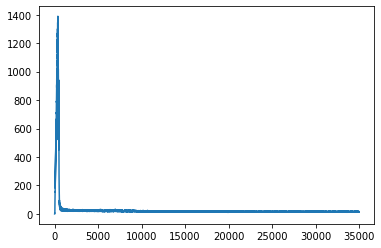

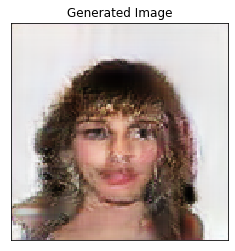

Iteration [35001/50000]......1.047(s) gen: 875.1691 - disc_fake: -874.9908 - disc_real: -861.0614 - neg_critic: 13.9294 - gp: 0.1392
Iteration [35002/50000]......1.049(s) gen: 872.4354 - disc_fake: -872.6560 - disc_real: -857.7783 - neg_critic: 14.8776 - gp: 0.1580
Iteration [35003/50000]......1.051(s) gen: 868.1507 - disc_fake: -871.2765 - disc_real: -856.5842 - neg_critic: 14.6923 - gp: 0.1310
Iteration [35004/50000]......1.033(s) gen: 868.5241 - disc_fake: -865.8247 - disc_real: -850.1696 - neg_critic: 15.6551 - gp: 0.1867
Iteration [35005/50000]......1.049(s) gen: 866.8169 - disc_fake: -866.1041 - disc_real: -851.5024 - neg_critic: 14.6017 - gp: 0.1526
Iteration [35006/50000]......1.034(s) gen: 872.4849 - disc_fake: -867.9084 - disc_real: -852.0488 - neg_critic: 15.8596 - gp: 0.1648
Iteration [35007/50000]......1.049(s) gen: 869.3895 - disc_fake: -871.2991 - disc_real: -857.9341 - neg_critic: 13.3651 - gp: 0.2033
Iteration [35008/50000]......1.044(s) gen: 868.7820 - disc_fake: -866

Iteration [35063/50000]......1.034(s) gen: 869.4416 - disc_fake: -870.8648 - disc_real: -857.1010 - neg_critic: 13.7638 - gp: 0.1343
Iteration [35064/50000]......1.050(s) gen: 874.0316 - disc_fake: -870.2750 - disc_real: -855.6399 - neg_critic: 14.6351 - gp: 0.1360
Iteration [35065/50000]......1.049(s) gen: 868.8839 - disc_fake: -873.1128 - disc_real: -858.2995 - neg_critic: 14.8133 - gp: 0.1807
Iteration [35066/50000]......1.034(s) gen: 873.4822 - disc_fake: -872.3492 - disc_real: -859.0687 - neg_critic: 13.2805 - gp: 0.1303
Iteration [35067/50000]......1.049(s) gen: 879.3331 - disc_fake: -875.8508 - disc_real: -862.5734 - neg_critic: 13.2774 - gp: 0.1494
Iteration [35068/50000]......1.050(s) gen: 873.2100 - disc_fake: -877.3766 - disc_real: -862.8356 - neg_critic: 14.5410 - gp: 0.1652
Iteration [35069/50000]......1.050(s) gen: 875.2614 - disc_fake: -875.2702 - disc_real: -860.5382 - neg_critic: 14.7320 - gp: 0.1584
Iteration [35070/50000]......1.033(s) gen: 879.6647 - disc_fake: -876

Iteration [35125/50000]......1.053(s) gen: 873.0333 - disc_fake: -868.8880 - disc_real: -854.6563 - neg_critic: 14.2317 - gp: 0.1596
Iteration [35126/50000]......1.047(s) gen: 869.1484 - disc_fake: -869.4562 - disc_real: -854.9791 - neg_critic: 14.4771 - gp: 0.1593
Iteration [35127/50000]......1.033(s) gen: 871.2227 - disc_fake: -869.8548 - disc_real: -855.2932 - neg_critic: 14.5617 - gp: 0.1429
Iteration [35128/50000]......1.049(s) gen: 870.8772 - disc_fake: -869.7556 - disc_real: -854.6688 - neg_critic: 15.0868 - gp: 0.1633
Iteration [35129/50000]......0.863(s) gen: 866.6573 - disc_fake: -694.8691 - disc_real: -682.4035 - neg_critic: 12.4656 - gp: 0.0989
Iteration [35130/50000]......1.053(s) gen: 872.2769 - disc_fake: -867.0097 - disc_real: -852.4976 - neg_critic: 14.5120 - gp: 0.1700
Iteration [35131/50000]......1.050(s) gen: 874.3481 - disc_fake: -870.8412 - disc_real: -856.5099 - neg_critic: 14.3314 - gp: 0.1794
Iteration [35132/50000]......1.034(s) gen: 871.3396 - disc_fake: -873

Iteration [35187/50000]......1.050(s) gen: 872.7375 - disc_fake: -873.6065 - disc_real: -861.0483 - neg_critic: 12.5582 - gp: 0.1485
Iteration [35188/50000]......1.034(s) gen: 871.0142 - disc_fake: -870.7314 - disc_real: -857.0745 - neg_critic: 13.6569 - gp: 0.1339
Iteration [35189/50000]......1.049(s) gen: 874.2881 - disc_fake: -875.2783 - disc_real: -861.6187 - neg_critic: 13.6595 - gp: 0.1476
Iteration [35190/50000]......1.034(s) gen: 873.9169 - disc_fake: -870.7112 - disc_real: -854.9576 - neg_critic: 15.7536 - gp: 0.1972
Iteration [35191/50000]......1.049(s) gen: 878.2065 - disc_fake: -874.2419 - disc_real: -861.9119 - neg_critic: 12.3300 - gp: 0.1330
Iteration [35192/50000]......1.050(s) gen: 874.6214 - disc_fake: -876.9783 - disc_real: -863.3291 - neg_critic: 13.6492 - gp: 0.1395
Iteration [35193/50000]......1.034(s) gen: 875.8333 - disc_fake: -873.7713 - disc_real: -858.0168 - neg_critic: 15.7545 - gp: 0.1514
Iteration [35194/50000]......1.049(s) gen: 876.1936 - disc_fake: -875

Iteration [35249/50000]......1.050(s) gen: 875.5786 - disc_fake: -874.7672 - disc_real: -859.3147 - neg_critic: 15.4525 - gp: 0.1739
Iteration [35250/50000]......1.034(s) gen: 871.1360 - disc_fake: -873.0972 - disc_real: -857.2256 - neg_critic: 15.8716 - gp: 0.1621
Iteration [35251/50000]......1.049(s) gen: 872.0959 - disc_fake: -870.6310 - disc_real: -856.4447 - neg_critic: 14.1863 - gp: 0.1476
Iteration [35252/50000]......1.034(s) gen: 877.6310 - disc_fake: -874.5658 - disc_real: -859.9757 - neg_critic: 14.5901 - gp: 0.1843
Iteration [35253/50000]......1.048(s) gen: 876.5507 - disc_fake: -876.5063 - disc_real: -862.4052 - neg_critic: 14.1011 - gp: 0.1217
Iteration [35254/50000]......1.034(s) gen: 879.3233 - disc_fake: -875.5033 - disc_real: -861.4742 - neg_critic: 14.0291 - gp: 0.1651
Iteration [35255/50000]......1.049(s) gen: 882.2701 - disc_fake: -877.1444 - disc_real: -863.3659 - neg_critic: 13.7785 - gp: 0.1213
Iteration [35256/50000]......1.050(s) gen: 873.9475 - disc_fake: -875

Iteration [35311/50000]......1.049(s) gen: 878.0050 - disc_fake: -874.2225 - disc_real: -858.6866 - neg_critic: 15.5359 - gp: 0.1772
Iteration [35312/50000]......1.050(s) gen: 876.1921 - disc_fake: -875.8742 - disc_real: -861.4714 - neg_critic: 14.4028 - gp: 0.1612
Iteration [35313/50000]......1.036(s) gen: 875.8697 - disc_fake: -876.6040 - disc_real: -863.2099 - neg_critic: 13.3941 - gp: 0.1273
Iteration [35314/50000]......1.047(s) gen: 877.5199 - disc_fake: -875.1703 - disc_real: -861.0983 - neg_critic: 14.0720 - gp: 0.1591
Iteration [35315/50000]......1.050(s) gen: 871.3807 - disc_fake: -876.2882 - disc_real: -860.8673 - neg_critic: 15.4209 - gp: 0.1668
Iteration [35316/50000]......1.034(s) gen: 871.0990 - disc_fake: -873.2202 - disc_real: -858.2131 - neg_critic: 15.0070 - gp: 0.1787
Iteration [35317/50000]......1.034(s) gen: 871.5143 - disc_fake: -872.9531 - disc_real: -858.2739 - neg_critic: 14.6792 - gp: 0.1701
Iteration [35318/50000]......1.049(s) gen: 874.2360 - disc_fake: -873

Iteration [35373/50000]......1.036(s) gen: 869.2645 - disc_fake: -876.7748 - disc_real: -860.3654 - neg_critic: 16.4094 - gp: 0.1422
Iteration [35374/50000]......1.049(s) gen: 876.2193 - disc_fake: -873.5138 - disc_real: -859.5647 - neg_critic: 13.9491 - gp: 0.1673
Iteration [35375/50000]......1.048(s) gen: 879.7050 - disc_fake: -878.8562 - disc_real: -864.3300 - neg_critic: 14.5263 - gp: 0.1429
Iteration [35376/50000]......1.036(s) gen: 878.9344 - disc_fake: -877.1536 - disc_real: -862.8083 - neg_critic: 14.3453 - gp: 0.1469
Iteration [35377/50000]......1.048(s) gen: 872.5005 - disc_fake: -875.5380 - disc_real: -860.2155 - neg_critic: 15.3224 - gp: 0.1650
Iteration [35378/50000]......1.034(s) gen: 877.0656 - disc_fake: -874.6526 - disc_real: -859.1143 - neg_critic: 15.5383 - gp: 0.1903
Iteration [35379/50000]......1.049(s) gen: 879.9984 - disc_fake: -877.0036 - disc_real: -863.6812 - neg_critic: 13.3224 - gp: 0.1302
Iteration [35380/50000]......1.034(s) gen: 867.9866 - disc_fake: -872

Iteration [35435/50000]......1.050(s) gen: 885.2976 - disc_fake: -879.5504 - disc_real: -866.6808 - neg_critic: 12.8696 - gp: 0.1684
Iteration [35436/50000]......1.034(s) gen: 878.1289 - disc_fake: -879.9347 - disc_real: -867.5530 - neg_critic: 12.3817 - gp: 0.1231
Iteration [35437/50000]......1.049(s) gen: 876.6985 - disc_fake: -875.3035 - disc_real: -860.2703 - neg_critic: 15.0333 - gp: 0.1743
Iteration [35438/50000]......1.034(s) gen: 874.6161 - disc_fake: -874.6562 - disc_real: -860.4435 - neg_critic: 14.2127 - gp: 0.1226
Iteration [35439/50000]......1.050(s) gen: 873.2511 - disc_fake: -873.4190 - disc_real: -857.7793 - neg_critic: 15.6397 - gp: 0.1910
Iteration [35440/50000]......1.049(s) gen: 874.0491 - disc_fake: -872.3750 - disc_real: -859.1705 - neg_critic: 13.2045 - gp: 0.1421
Iteration [35441/50000]......1.034(s) gen: 874.3516 - disc_fake: -872.6075 - disc_real: -857.3985 - neg_critic: 15.2090 - gp: 0.1875
Iteration [35442/50000]......1.056(s) gen: 879.3151 - disc_fake: -875

Iteration [35497/50000]......1.049(s) gen: 879.1733 - disc_fake: -878.1861 - disc_real: -864.8550 - neg_critic: 13.3310 - gp: 0.1336
Iteration [35498/50000]......1.034(s) gen: 877.7377 - disc_fake: -878.8979 - disc_real: -864.6751 - neg_critic: 14.2229 - gp: 0.1259
Iteration [35499/50000]......1.050(s) gen: 881.3540 - disc_fake: -879.4939 - disc_real: -866.4910 - neg_critic: 13.0029 - gp: 0.1684
Iteration [35500/50000]......1.049(s) gen: 879.8384 - disc_fake: -881.5953 - disc_real: -868.4683 - neg_critic: 13.1270 - gp: 0.1275
Iteration [35501/50000]......1.034(s) gen: 878.7361 - disc_fake: -880.0112 - disc_real: -865.7841 - neg_critic: 14.2271 - gp: 0.1531
Iteration [35502/50000]......1.049(s) gen: 878.1377 - disc_fake: -878.1802 - disc_real: -862.9702 - neg_critic: 15.2100 - gp: 0.1399
Iteration [35503/50000]......1.050(s) gen: 878.5574 - disc_fake: -877.1442 - disc_real: -864.1385 - neg_critic: 13.0057 - gp: 0.1610
Iteration [35504/50000]......1.034(s) gen: 879.2137 - disc_fake: -876

Iteration [35559/50000]......1.049(s) gen: 882.0121 - disc_fake: -879.0216 - disc_real: -862.6219 - neg_critic: 16.3996 - gp: 0.1578
Iteration [35560/50000]......1.050(s) gen: 880.3832 - disc_fake: -880.5081 - disc_real: -865.2225 - neg_critic: 15.2856 - gp: 0.1769
Iteration [35561/50000]......1.034(s) gen: 878.3925 - disc_fake: -878.7275 - disc_real: -865.3006 - neg_critic: 13.4269 - gp: 0.1556
Iteration [35562/50000]......1.049(s) gen: 880.8322 - disc_fake: -878.3873 - disc_real: -863.5126 - neg_critic: 14.8747 - gp: 0.1571
Iteration [35563/50000]......1.034(s) gen: 871.5631 - disc_fake: -879.0913 - disc_real: -864.1986 - neg_critic: 14.8927 - gp: 0.1477
Iteration [35564/50000]......1.050(s) gen: 880.3580 - disc_fake: -875.3523 - disc_real: -858.8194 - neg_critic: 16.5329 - gp: 0.2231
Iteration [35565/50000]......1.048(s) gen: 875.7048 - disc_fake: -879.5096 - disc_real: -864.5500 - neg_critic: 14.9596 - gp: 0.1312
Iteration [35566/50000]......1.050(s) gen: 887.4919 - disc_fake: -881

Iteration [35621/50000]......1.049(s) gen: 881.5258 - disc_fake: -880.9475 - disc_real: -865.7763 - neg_critic: 15.1712 - gp: 0.1808
Iteration [35622/50000]......1.050(s) gen: 878.3458 - disc_fake: -878.7780 - disc_real: -864.1652 - neg_critic: 14.6128 - gp: 0.1416
Iteration [35623/50000]......1.033(s) gen: 874.6252 - disc_fake: -878.1199 - disc_real: -862.5400 - neg_critic: 15.5800 - gp: 0.1643
Iteration [35624/50000]......1.049(s) gen: 876.4686 - disc_fake: -873.1215 - disc_real: -858.2681 - neg_critic: 14.8534 - gp: 0.1756
Iteration [35625/50000]......1.050(s) gen: 877.7277 - disc_fake: -876.4656 - disc_real: -863.2392 - neg_critic: 13.2263 - gp: 0.1277
Iteration [35626/50000]......1.034(s) gen: 881.5613 - disc_fake: -877.5842 - disc_real: -863.4675 - neg_critic: 14.1167 - gp: 0.1395
Iteration [35627/50000]......1.049(s) gen: 875.4496 - disc_fake: -878.6623 - disc_real: -864.0237 - neg_critic: 14.6386 - gp: 0.1864
Iteration [35628/50000]......1.050(s) gen: 880.5574 - disc_fake: -876

Iteration [35683/50000]......1.034(s) gen: 877.7261 - disc_fake: -877.0216 - disc_real: -863.3211 - neg_critic: 13.7005 - gp: 0.1098
Iteration [35684/50000]......1.034(s) gen: 880.9443 - disc_fake: -878.4612 - disc_real: -863.1766 - neg_critic: 15.2846 - gp: 0.1517
Iteration [35685/50000]......1.049(s) gen: 887.4622 - disc_fake: -883.3191 - disc_real: -867.6218 - neg_critic: 15.6973 - gp: 0.1956
Iteration [35686/50000]......1.050(s) gen: 878.5328 - disc_fake: -883.7193 - disc_real: -870.2291 - neg_critic: 13.4902 - gp: 0.1606
Iteration [35687/50000]......1.034(s) gen: 878.1084 - disc_fake: -877.6866 - disc_real: -862.7730 - neg_critic: 14.9136 - gp: 0.1536
Iteration [35688/50000]......1.049(s) gen: 874.6091 - disc_fake: -876.1313 - disc_real: -861.4286 - neg_critic: 14.7027 - gp: 0.1709
Iteration [35689/50000]......1.034(s) gen: 875.0089 - disc_fake: -874.7702 - disc_real: -861.2457 - neg_critic: 13.5245 - gp: 0.1371
Iteration [35690/50000]......1.049(s) gen: 877.8922 - disc_fake: -876

Iteration [35745/50000]......1.036(s) gen: 880.5952 - disc_fake: -880.3248 - disc_real: -865.8018 - neg_critic: 14.5230 - gp: 0.1445
Iteration [35746/50000]......1.048(s) gen: 875.4386 - disc_fake: -878.1615 - disc_real: -862.7476 - neg_critic: 15.4139 - gp: 0.1835
Iteration [35747/50000]......1.034(s) gen: 876.9005 - disc_fake: -877.1874 - disc_real: -860.7321 - neg_critic: 16.4553 - gp: 0.1838
Iteration [35748/50000]......1.049(s) gen: 870.4744 - disc_fake: -877.5081 - disc_real: -861.9311 - neg_critic: 15.5770 - gp: 0.1575
Iteration [35749/50000]......1.040(s) gen: 876.9453 - disc_fake: -875.5591 - disc_real: -860.9862 - neg_critic: 14.5729 - gp: 0.1447
Iteration [35750/50000]......1.043(s) gen: 881.0797 - disc_fake: -879.5737 - disc_real: -864.2436 - neg_critic: 15.3301 - gp: 0.1638
Iteration [35751/50000]......1.049(s) gen: 881.5313 - disc_fake: -882.5769 - disc_real: -867.4594 - neg_critic: 15.1175 - gp: 0.1619
Iteration [35752/50000]......1.035(s) gen: 877.7948 - disc_fake: -881

Iteration [35807/50000]......1.034(s) gen: 881.4958 - disc_fake: -880.6059 - disc_real: -864.7608 - neg_critic: 15.8450 - gp: 0.1786
Iteration [35808/50000]......1.049(s) gen: 881.5482 - disc_fake: -877.6062 - disc_real: -861.9962 - neg_critic: 15.6100 - gp: 0.1774
Iteration [35809/50000]......1.034(s) gen: 888.0938 - disc_fake: -884.6439 - disc_real: -871.3635 - neg_critic: 13.2803 - gp: 0.1542
Iteration [35810/50000]......1.049(s) gen: 885.5581 - disc_fake: -888.0610 - disc_real: -873.2048 - neg_critic: 14.8562 - gp: 0.1477
Iteration [35811/50000]......1.036(s) gen: 884.1733 - disc_fake: -885.0982 - disc_real: -870.8313 - neg_critic: 14.2669 - gp: 0.1438
Iteration [35812/50000]......1.050(s) gen: 888.5277 - disc_fake: -886.3474 - disc_real: -872.2859 - neg_critic: 14.0615 - gp: 0.1797
Iteration [35813/50000]......1.045(s) gen: 881.8115 - disc_fake: -884.0348 - disc_real: -871.2706 - neg_critic: 12.7643 - gp: 0.1511
Iteration [35814/50000]......1.042(s) gen: 882.1597 - disc_fake: -883

Iteration [35869/50000]......1.034(s) gen: 876.1335 - disc_fake: -879.7653 - disc_real: -865.2361 - neg_critic: 14.5292 - gp: 0.1717
Iteration [35870/50000]......1.049(s) gen: 879.0363 - disc_fake: -878.2421 - disc_real: -864.4332 - neg_critic: 13.8089 - gp: 0.1530
Iteration [35871/50000]......1.034(s) gen: 881.6737 - disc_fake: -882.0918 - disc_real: -868.5714 - neg_critic: 13.5205 - gp: 0.1736
Iteration [35872/50000]......1.049(s) gen: 885.3523 - disc_fake: -884.4093 - disc_real: -869.7003 - neg_critic: 14.7089 - gp: 0.1103
Iteration [35873/50000]......1.034(s) gen: 880.1583 - disc_fake: -882.8013 - disc_real: -867.5058 - neg_critic: 15.2955 - gp: 0.1559
Iteration [35874/50000]......1.049(s) gen: 883.0159 - disc_fake: -880.5430 - disc_real: -866.2868 - neg_critic: 14.2562 - gp: 0.1756
Iteration [35875/50000]......1.034(s) gen: 881.3504 - disc_fake: -881.6858 - disc_real: -866.4071 - neg_critic: 15.2787 - gp: 0.1323
Iteration [35876/50000]......1.049(s) gen: 886.1565 - disc_fake: -881

Iteration [35931/50000]......1.038(s) gen: 882.8766 - disc_fake: -880.2429 - disc_real: -865.4321 - neg_critic: 14.8108 - gp: 0.1880
Iteration [35932/50000]......1.050(s) gen: 880.6426 - disc_fake: -884.0267 - disc_real: -870.4017 - neg_critic: 13.6250 - gp: 0.1215
Iteration [35933/50000]......1.032(s) gen: 889.6837 - disc_fake: -885.2432 - disc_real: -871.6557 - neg_critic: 13.5875 - gp: 0.1586
Iteration [35934/50000]......1.049(s) gen: 887.7062 - disc_fake: -887.1737 - disc_real: -872.9214 - neg_critic: 14.2524 - gp: 0.1645
Iteration [35935/50000]......1.034(s) gen: 886.0476 - disc_fake: -886.8053 - disc_real: -871.8315 - neg_critic: 14.9738 - gp: 0.1389
Iteration [35936/50000]......1.049(s) gen: 888.0250 - disc_fake: -884.7013 - disc_real: -869.8379 - neg_critic: 14.8633 - gp: 0.2103
Iteration [35937/50000]......1.034(s) gen: 884.6224 - disc_fake: -886.2205 - disc_real: -871.8094 - neg_critic: 14.4111 - gp: 0.1412
Iteration [35938/50000]......1.049(s) gen: 883.7500 - disc_fake: -882

Iteration [35993/50000]......1.034(s) gen: 884.7177 - disc_fake: -880.5531 - disc_real: -866.2505 - neg_critic: 14.3026 - gp: 0.1915
Iteration [35994/50000]......1.049(s) gen: 878.8076 - disc_fake: -880.1744 - disc_real: -866.9290 - neg_critic: 13.2454 - gp: 0.1502
Iteration [35995/50000]......1.050(s) gen: 879.9957 - disc_fake: -879.4075 - disc_real: -864.3909 - neg_critic: 15.0166 - gp: 0.2048
Iteration [35996/50000]......1.034(s) gen: 884.1318 - disc_fake: -881.3221 - disc_real: -867.7985 - neg_critic: 13.5237 - gp: 0.1313
Iteration [35997/50000]......1.049(s) gen: 882.5964 - disc_fake: -882.3922 - disc_real: -867.5556 - neg_critic: 14.8366 - gp: 0.1544
Iteration [35998/50000]......1.034(s) gen: 880.8804 - disc_fake: -881.5809 - disc_real: -867.3423 - neg_critic: 14.2386 - gp: 0.1936
Iteration [35999/50000]......1.049(s) gen: 882.2211 - disc_fake: -881.8447 - disc_real: -868.1734 - neg_critic: 13.6713 - gp: 0.1279
Iteration [36000/50000]......1.034(s) gen: 881.1155 - disc_fake: -882

Iteration [36055/50000]......1.035(s) gen: 891.0881 - disc_fake: -891.1207 - disc_real: -876.9308 - neg_critic: 14.1898 - gp: 0.1458
Iteration [36056/50000]......1.048(s) gen: 891.9063 - disc_fake: -893.2886 - disc_real: -879.1927 - neg_critic: 14.0959 - gp: 0.1251
Iteration [36057/50000]......1.034(s) gen: 894.2648 - disc_fake: -891.8572 - disc_real: -876.7379 - neg_critic: 15.1193 - gp: 0.1801
Iteration [36058/50000]......1.049(s) gen: 890.8329 - disc_fake: -891.0410 - disc_real: -875.8264 - neg_critic: 15.2146 - gp: 0.1595
Iteration [36059/50000]......1.034(s) gen: 891.5722 - disc_fake: -892.0210 - disc_real: -877.4977 - neg_critic: 14.5234 - gp: 0.1700
Iteration [36060/50000]......1.049(s) gen: 894.0419 - disc_fake: -891.9642 - disc_real: -877.3967 - neg_critic: 14.5675 - gp: 0.1327
Iteration [36061/50000]......1.034(s) gen: 882.2028 - disc_fake: -891.0724 - disc_real: -874.7136 - neg_critic: 16.3588 - gp: 0.1794
Iteration [36062/50000]......1.033(s) gen: 888.8971 - disc_fake: -887

Iteration [36117/50000]......1.050(s) gen: 886.8749 - disc_fake: -885.4826 - disc_real: -871.2469 - neg_critic: 14.2357 - gp: 0.1429
Iteration [36118/50000]......1.049(s) gen: 894.1646 - disc_fake: -889.1722 - disc_real: -875.5175 - neg_critic: 13.6547 - gp: 0.1678
Iteration [36119/50000]......1.033(s) gen: 889.2921 - disc_fake: -891.5689 - disc_real: -877.5044 - neg_critic: 14.0645 - gp: 0.1333
Iteration [36120/50000]......1.033(s) gen: 886.5114 - disc_fake: -884.8541 - disc_real: -871.2414 - neg_critic: 13.6127 - gp: 0.1615
Iteration [36121/50000]......1.050(s) gen: 887.8004 - disc_fake: -886.6140 - disc_real: -873.0704 - neg_critic: 13.5436 - gp: 0.1561
Iteration [36122/50000]......1.033(s) gen: 892.7687 - disc_fake: -887.9096 - disc_real: -873.8670 - neg_critic: 14.0426 - gp: 0.1382
Iteration [36123/50000]......1.049(s) gen: 884.6295 - disc_fake: -888.1468 - disc_real: -874.3929 - neg_critic: 13.7539 - gp: 0.1342
Iteration [36124/50000]......1.034(s) gen: 883.6166 - disc_fake: -882

Iteration [36179/50000]......1.034(s) gen: 890.5256 - disc_fake: -890.1734 - disc_real: -875.2873 - neg_critic: 14.8861 - gp: 0.1648
Iteration [36180/50000]......1.049(s) gen: 888.8901 - disc_fake: -890.1222 - disc_real: -875.7241 - neg_critic: 14.3981 - gp: 0.1576
Iteration [36181/50000]......1.033(s) gen: 887.4509 - disc_fake: -888.2255 - disc_real: -872.3517 - neg_critic: 15.8737 - gp: 0.1684
Iteration [36182/50000]......1.050(s) gen: 888.0266 - disc_fake: -885.5466 - disc_real: -869.1052 - neg_critic: 16.4413 - gp: 0.1960
Iteration [36183/50000]......1.034(s) gen: 886.3090 - disc_fake: -886.4354 - disc_real: -872.1016 - neg_critic: 14.3337 - gp: 0.1517
Iteration [36184/50000]......1.049(s) gen: 876.5203 - disc_fake: -885.6543 - disc_real: -869.4942 - neg_critic: 16.1601 - gp: 0.1644
Iteration [36185/50000]......1.034(s) gen: 889.3361 - disc_fake: -885.9432 - disc_real: -871.8073 - neg_critic: 14.1359 - gp: 0.1968
Iteration [36186/50000]......1.049(s) gen: 883.5209 - disc_fake: -890

Iteration [36241/50000]......1.034(s) gen: 886.8328 - disc_fake: -886.1775 - disc_real: -871.9464 - neg_critic: 14.2312 - gp: 0.1399
Iteration [36242/50000]......1.049(s) gen: 887.6734 - disc_fake: -887.9194 - disc_real: -872.9569 - neg_critic: 14.9625 - gp: 0.1851
Iteration [36243/50000]......1.034(s) gen: 882.9960 - disc_fake: -887.1509 - disc_real: -870.0878 - neg_critic: 17.0632 - gp: 0.1665
Iteration [36244/50000]......1.049(s) gen: 892.3247 - disc_fake: -887.1352 - disc_real: -872.9549 - neg_critic: 14.1802 - gp: 0.1560
Iteration [36245/50000]......1.050(s) gen: 885.2996 - disc_fake: -889.0009 - disc_real: -872.0843 - neg_critic: 16.9167 - gp: 0.2182
Iteration [36246/50000]......1.034(s) gen: 890.3947 - disc_fake: -887.1955 - disc_real: -874.9956 - neg_critic: 12.1999 - gp: 0.1121
Iteration [36247/50000]......1.033(s) gen: 890.6855 - disc_fake: -889.0423 - disc_real: -874.4219 - neg_critic: 14.6204 - gp: 0.1341
Iteration [36248/50000]......1.049(s) gen: 891.2130 - disc_fake: -888

Iteration [36303/50000]......1.034(s) gen: 888.4852 - disc_fake: -889.1714 - disc_real: -874.5921 - neg_critic: 14.5793 - gp: 0.1450
Iteration [36304/50000]......1.033(s) gen: 886.4510 - disc_fake: -889.9022 - disc_real: -873.8969 - neg_critic: 16.0053 - gp: 0.1632
Iteration [36305/50000]......1.060(s) gen: 882.1207 - disc_fake: -883.7979 - disc_real: -869.2128 - neg_critic: 14.5851 - gp: 0.1680
Iteration [36306/50000]......1.047(s) gen: 888.5067 - disc_fake: -884.3430 - disc_real: -870.3101 - neg_critic: 14.0328 - gp: 0.1983
Iteration [36307/50000]......1.042(s) gen: 886.4954 - disc_fake: -887.0568 - disc_real: -874.1262 - neg_critic: 12.9307 - gp: 0.1406
Iteration [36308/50000]......1.034(s) gen: 889.8839 - disc_fake: -887.4099 - disc_real: -873.8460 - neg_critic: 13.5639 - gp: 0.1713
Iteration [36309/50000]......1.033(s) gen: 889.1028 - disc_fake: -887.4836 - disc_real: -873.7555 - neg_critic: 13.7281 - gp: 0.1328
Iteration [36310/50000]......1.051(s) gen: 887.7535 - disc_fake: -886

Iteration [36365/50000]......1.049(s) gen: 886.9812 - disc_fake: -893.4023 - disc_real: -878.2734 - neg_critic: 15.1289 - gp: 0.1597
Iteration [36366/50000]......1.034(s) gen: 894.9592 - disc_fake: -890.4332 - disc_real: -876.8804 - neg_critic: 13.5528 - gp: 0.1580
Iteration [36367/50000]......1.049(s) gen: 894.0037 - disc_fake: -894.9849 - disc_real: -880.0534 - neg_critic: 14.9314 - gp: 0.1306
Iteration [36368/50000]......1.034(s) gen: 891.1267 - disc_fake: -893.3450 - disc_real: -877.9322 - neg_critic: 15.4128 - gp: 0.1591
Iteration [36369/50000]......1.049(s) gen: 888.2765 - disc_fake: -890.8773 - disc_real: -876.1777 - neg_critic: 14.6996 - gp: 0.2296
Iteration [36370/50000]......1.034(s) gen: 892.4054 - disc_fake: -888.6464 - disc_real: -874.0060 - neg_critic: 14.6404 - gp: 0.1339
Iteration [36371/50000]......1.033(s) gen: 895.4248 - disc_fake: -891.0012 - disc_real: -877.6296 - neg_critic: 13.3716 - gp: 0.1307
Iteration [36372/50000]......1.049(s) gen: 892.2301 - disc_fake: -895

Iteration [36427/50000]......1.049(s) gen: 889.1099 - disc_fake: -891.9498 - disc_real: -878.8820 - neg_critic: 13.0678 - gp: 0.1491
Iteration [36428/50000]......1.034(s) gen: 886.9286 - disc_fake: -889.0589 - disc_real: -872.6836 - neg_critic: 16.3753 - gp: 0.2021
Iteration [36429/50000]......1.048(s) gen: 888.0829 - disc_fake: -887.8319 - disc_real: -872.9902 - neg_critic: 14.8417 - gp: 0.1376
Iteration [36430/50000]......1.034(s) gen: 892.7639 - disc_fake: -889.8761 - disc_real: -875.9471 - neg_critic: 13.9290 - gp: 0.1375
Iteration [36431/50000]......1.033(s) gen: 888.8453 - disc_fake: -892.7019 - disc_real: -878.0424 - neg_critic: 14.6595 - gp: 0.1603
Iteration [36432/50000]......1.049(s) gen: 892.9100 - disc_fake: -888.0829 - disc_real: -873.4990 - neg_critic: 14.5840 - gp: 0.1744
Iteration [36433/50000]......1.034(s) gen: 889.7643 - disc_fake: -893.2744 - disc_real: -878.7587 - neg_critic: 14.5157 - gp: 0.1306
Iteration [36434/50000]......1.049(s) gen: 896.4702 - disc_fake: -893

Iteration [36489/50000]......1.034(s) gen: 887.9019 - disc_fake: -888.0819 - disc_real: -872.7683 - neg_critic: 15.3137 - gp: 0.1525
Iteration [36490/50000]......1.049(s) gen: 894.7765 - disc_fake: -889.2315 - disc_real: -873.4662 - neg_critic: 15.7653 - gp: 0.1806
Iteration [36491/50000]......1.049(s) gen: 892.4164 - disc_fake: -892.0773 - disc_real: -879.9843 - neg_critic: 12.0930 - gp: 0.1309
Iteration [36492/50000]......1.034(s) gen: 888.8892 - disc_fake: -890.7149 - disc_real: -875.0882 - neg_critic: 15.6266 - gp: 0.1621
Iteration [36493/50000]......1.047(s) gen: 889.4489 - disc_fake: -890.8002 - disc_real: -875.8903 - neg_critic: 14.9099 - gp: 0.1620
Iteration [36494/50000]......1.036(s) gen: 897.3341 - disc_fake: -892.5976 - disc_real: -878.0293 - neg_critic: 14.5684 - gp: 0.1826
Iteration [36495/50000]......1.049(s) gen: 898.3531 - disc_fake: -898.7222 - disc_real: -883.9561 - neg_critic: 14.7661 - gp: 0.0998
Iteration [36496/50000]......1.034(s) gen: 895.8336 - disc_fake: -897

Iteration [36551/50000]......1.034(s) gen: 889.9705 - disc_fake: -888.9710 - disc_real: -874.4029 - neg_critic: 14.5681 - gp: 0.1693
Iteration [36552/50000]......1.049(s) gen: 893.1906 - disc_fake: -889.2411 - disc_real: -874.5897 - neg_critic: 14.6514 - gp: 0.1358
Iteration [36553/50000]......1.050(s) gen: 886.2205 - disc_fake: -889.0587 - disc_real: -874.2827 - neg_critic: 14.7760 - gp: 0.1770
Iteration [36554/50000]......1.034(s) gen: 890.1331 - disc_fake: -887.9776 - disc_real: -872.9587 - neg_critic: 15.0189 - gp: 0.1302
Iteration [36555/50000]......1.033(s) gen: 891.9877 - disc_fake: -890.3725 - disc_real: -877.0623 - neg_critic: 13.3103 - gp: 0.1660
Iteration [36556/50000]......1.049(s) gen: 889.3480 - disc_fake: -893.1063 - disc_real: -878.6300 - neg_critic: 14.4763 - gp: 0.1710
Iteration [36557/50000]......1.034(s) gen: 889.2801 - disc_fake: -889.5979 - disc_real: -875.1158 - neg_critic: 14.4821 - gp: 0.1432
Iteration [36558/50000]......1.049(s) gen: 895.6574 - disc_fake: -892

Iteration [36613/50000]......1.033(s) gen: 891.7350 - disc_fake: -891.2716 - disc_real: -879.4382 - neg_critic: 11.8334 - gp: 0.1306
Iteration [36614/50000]......1.048(s) gen: 893.5440 - disc_fake: -890.4107 - disc_real: -876.6377 - neg_critic: 13.7730 - gp: 0.1358
Iteration [36615/50000]......1.050(s) gen: 893.7846 - disc_fake: -893.2879 - disc_real: -879.0454 - neg_critic: 14.2425 - gp: 0.1677
Iteration [36616/50000]......1.034(s) gen: 889.9030 - disc_fake: -890.8181 - disc_real: -873.9238 - neg_critic: 16.8944 - gp: 0.1535
Iteration [36617/50000]......1.033(s) gen: 893.8950 - disc_fake: -892.4712 - disc_real: -877.9801 - neg_critic: 14.4910 - gp: 0.1660
Iteration [36618/50000]......1.049(s) gen: 897.2504 - disc_fake: -894.5869 - disc_real: -880.3295 - neg_critic: 14.2574 - gp: 0.1719
Iteration [36619/50000]......1.040(s) gen: 894.4288 - disc_fake: -895.0901 - disc_real: -879.9200 - neg_critic: 15.1701 - gp: 0.1630
Iteration [36620/50000]......1.044(s) gen: 891.5694 - disc_fake: -893

Iteration [36675/50000]......1.049(s) gen: 896.3557 - disc_fake: -893.1113 - disc_real: -878.1251 - neg_critic: 14.9862 - gp: 0.1747
Iteration [36676/50000]......1.034(s) gen: 896.0956 - disc_fake: -895.2311 - disc_real: -881.3308 - neg_critic: 13.9003 - gp: 0.1462
Iteration [36677/50000]......1.033(s) gen: 886.0793 - disc_fake: -892.9163 - disc_real: -877.5698 - neg_critic: 15.3465 - gp: 0.1491
Iteration [36678/50000]......1.048(s) gen: 892.3612 - disc_fake: -891.2274 - disc_real: -875.5583 - neg_critic: 15.6691 - gp: 0.2133
Iteration [36679/50000]......1.050(s) gen: 893.1051 - disc_fake: -892.9553 - disc_real: -877.7125 - neg_critic: 15.2428 - gp: 0.1469
Iteration [36680/50000]......1.036(s) gen: 888.9525 - disc_fake: -890.8196 - disc_real: -876.6622 - neg_critic: 14.1573 - gp: 0.1532
Iteration [36681/50000]......1.048(s) gen: 887.3130 - disc_fake: -888.5226 - disc_real: -873.3465 - neg_critic: 15.1761 - gp: 0.1694
Iteration [36682/50000]......1.034(s) gen: 890.9742 - disc_fake: -889

Iteration [36737/50000]......1.037(s) gen: 894.7051 - disc_fake: -893.4480 - disc_real: -879.3273 - neg_critic: 14.1206 - gp: 0.1584
Iteration [36738/50000]......1.049(s) gen: 898.7139 - disc_fake: -897.5682 - disc_real: -882.7215 - neg_critic: 14.8468 - gp: 0.1419
Iteration [36739/50000]......1.033(s) gen: 901.7562 - disc_fake: -899.6493 - disc_real: -887.6113 - neg_critic: 12.0380 - gp: 0.1391
Iteration [36740/50000]......1.049(s) gen: 899.0776 - disc_fake: -901.6688 - disc_real: -885.3067 - neg_critic: 16.3620 - gp: 0.1811
Iteration [36741/50000]......1.049(s) gen: 893.2347 - disc_fake: -893.2875 - disc_real: -878.3171 - neg_critic: 14.9704 - gp: 0.1555
Iteration [36742/50000]......1.034(s) gen: 890.9512 - disc_fake: -892.2216 - disc_real: -877.5200 - neg_critic: 14.7016 - gp: 0.1913
Iteration [36743/50000]......1.049(s) gen: 889.4375 - disc_fake: -888.6755 - disc_real: -875.5361 - neg_critic: 13.1393 - gp: 0.1234
Iteration [36744/50000]......1.034(s) gen: 891.7025 - disc_fake: -889

Iteration [36799/50000]......1.034(s) gen: 898.1393 - disc_fake: -894.7539 - disc_real: -881.8037 - neg_critic: 12.9501 - gp: 0.1404
Iteration [36800/50000]......1.049(s) gen: 899.7122 - disc_fake: -896.5037 - disc_real: -882.6765 - neg_critic: 13.8273 - gp: 0.1540
Iteration [36801/50000]......1.034(s) gen: 894.6218 - disc_fake: -897.2661 - disc_real: -881.7615 - neg_critic: 15.5046 - gp: 0.1672
Iteration [36802/50000]......1.033(s) gen: 893.6088 - disc_fake: -891.8891 - disc_real: -877.3676 - neg_critic: 14.5215 - gp: 0.1375
Iteration [36803/50000]......1.050(s) gen: 898.3904 - disc_fake: -896.6797 - disc_real: -881.1140 - neg_critic: 15.5657 - gp: 0.1546
Iteration [36804/50000]......1.033(s) gen: 898.8023 - disc_fake: -897.2247 - disc_real: -882.4001 - neg_critic: 14.8246 - gp: 0.1660
Iteration [36805/50000]......1.049(s) gen: 896.5817 - disc_fake: -899.0894 - disc_real: -883.6045 - neg_critic: 15.4850 - gp: 0.1666
Iteration [36806/50000]......1.034(s) gen: 896.7957 - disc_fake: -896

Iteration [36861/50000]......1.033(s) gen: 890.4348 - disc_fake: -895.7020 - disc_real: -880.5446 - neg_critic: 15.1575 - gp: 0.1361
Iteration [36862/50000]......1.049(s) gen: 898.5566 - disc_fake: -894.9708 - disc_real: -880.3626 - neg_critic: 14.6082 - gp: 0.1503
Iteration [36863/50000]......1.034(s) gen: 896.0199 - disc_fake: -896.8772 - disc_real: -882.7931 - neg_critic: 14.0841 - gp: 0.1915
Iteration [36864/50000]......1.049(s) gen: 898.4176 - disc_fake: -898.9858 - disc_real: -885.6571 - neg_critic: 13.3287 - gp: 0.1228
Iteration [36865/50000]......1.034(s) gen: 906.8986 - disc_fake: -902.3252 - disc_real: -888.3002 - neg_critic: 14.0250 - gp: 0.1899
Iteration [36866/50000]......1.050(s) gen: 898.0575 - disc_fake: -903.4220 - disc_real: -890.1799 - neg_critic: 13.2421 - gp: 0.1159
Iteration [36867/50000]......1.033(s) gen: 901.5242 - disc_fake: -899.6838 - disc_real: -885.5867 - neg_critic: 14.0971 - gp: 0.1917
Iteration [36868/50000]......1.048(s) gen: 896.3840 - disc_fake: -898

Iteration [36923/50000]......1.049(s) gen: 894.8529 - disc_fake: -896.1207 - disc_real: -880.4720 - neg_critic: 15.6486 - gp: 0.1577
Iteration [36924/50000]......1.050(s) gen: 897.9131 - disc_fake: -894.2428 - disc_real: -880.8076 - neg_critic: 13.4352 - gp: 0.1864
Iteration [36925/50000]......1.034(s) gen: 895.3126 - disc_fake: -895.8315 - disc_real: -883.2179 - neg_critic: 12.6136 - gp: 0.1262
Iteration [36926/50000]......1.049(s) gen: 895.7180 - disc_fake: -895.0193 - disc_real: -880.8723 - neg_critic: 14.1470 - gp: 0.1720
Iteration [36927/50000]......1.034(s) gen: 895.8845 - disc_fake: -893.1123 - disc_real: -879.1630 - neg_critic: 13.9493 - gp: 0.1316
Iteration [36928/50000]......1.033(s) gen: 897.6881 - disc_fake: -895.6072 - disc_real: -881.8822 - neg_critic: 13.7250 - gp: 0.1267
Iteration [36929/50000]......1.048(s) gen: 900.9576 - disc_fake: -900.4217 - disc_real: -886.0870 - neg_critic: 14.3348 - gp: 0.1618
Iteration [36930/50000]......1.034(s) gen: 902.6526 - disc_fake: -899

Iteration [36985/50000]......1.049(s) gen: 898.5100 - disc_fake: -899.2602 - disc_real: -883.9890 - neg_critic: 15.2713 - gp: 0.1461
Iteration [36986/50000]......1.034(s) gen: 900.2407 - disc_fake: -897.3427 - disc_real: -882.2575 - neg_critic: 15.0852 - gp: 0.1650
Iteration [36987/50000]......1.049(s) gen: 898.1743 - disc_fake: -896.7355 - disc_real: -881.0660 - neg_critic: 15.6695 - gp: 0.1876
Iteration [36988/50000]......1.034(s) gen: 898.8385 - disc_fake: -897.2161 - disc_real: -883.7242 - neg_critic: 13.4919 - gp: 0.1440
Iteration [36989/50000]......1.049(s) gen: 898.8384 - disc_fake: -897.2634 - disc_real: -882.5242 - neg_critic: 14.7392 - gp: 0.2111
Iteration [36990/50000]......1.034(s) gen: 898.6593 - disc_fake: -899.2891 - disc_real: -886.9712 - neg_critic: 12.3179 - gp: 0.1236
Iteration [36991/50000]......1.033(s) gen: 900.2360 - disc_fake: -899.6562 - disc_real: -885.4939 - neg_critic: 14.1623 - gp: 0.1516
Iteration [36992/50000]......1.049(s) gen: 899.3015 - disc_fake: -899

Iteration [37047/50000]......1.049(s) gen: 896.0225 - disc_fake: -895.5667 - disc_real: -881.1333 - neg_critic: 14.4334 - gp: 0.1400
Iteration [37048/50000]......1.034(s) gen: 897.4317 - disc_fake: -898.6496 - disc_real: -880.9933 - neg_critic: 17.6563 - gp: 0.1880
Iteration [37049/50000]......1.049(s) gen: 903.6089 - disc_fake: -901.7747 - disc_real: -889.7249 - neg_critic: 12.0499 - gp: 0.1244
Iteration [37050/50000]......1.034(s) gen: 900.4101 - disc_fake: -902.8082 - disc_real: -886.6172 - neg_critic: 16.1910 - gp: 0.1558
Iteration [37051/50000]......1.050(s) gen: 904.7386 - disc_fake: -903.1432 - disc_real: -888.5873 - neg_critic: 14.5559 - gp: 0.1680
Iteration [37052/50000]......1.033(s) gen: 904.8748 - disc_fake: -903.2995 - disc_real: -888.8235 - neg_critic: 14.4760 - gp: 0.1575
Iteration [37053/50000]......1.048(s) gen: 904.6131 - disc_fake: -905.9054 - disc_real: -891.5112 - neg_critic: 14.3942 - gp: 0.1510
Iteration [37054/50000]......1.034(s) gen: 902.1575 - disc_fake: -905

Iteration [37109/50000]......1.034(s) gen: 900.0507 - disc_fake: -897.4839 - disc_real: -883.2142 - neg_critic: 14.2697 - gp: 0.1526
Iteration [37110/50000]......1.048(s) gen: 900.8952 - disc_fake: -900.5130 - disc_real: -884.2852 - neg_critic: 16.2279 - gp: 0.1758
Iteration [37111/50000]......1.034(s) gen: 898.8732 - disc_fake: -900.2567 - disc_real: -885.1024 - neg_critic: 15.1542 - gp: 0.2006
Iteration [37112/50000]......1.049(s) gen: 898.8334 - disc_fake: -897.6241 - disc_real: -882.4849 - neg_critic: 15.1391 - gp: 0.1359
Iteration [37113/50000]......1.034(s) gen: 900.5589 - disc_fake: -901.2851 - disc_real: -886.7125 - neg_critic: 14.5727 - gp: 0.1759
Iteration [37114/50000]......1.049(s) gen: 904.2006 - disc_fake: -901.8434 - disc_real: -888.3637 - neg_critic: 13.4797 - gp: 0.1447
Iteration [37115/50000]......1.034(s) gen: 899.6279 - disc_fake: -900.7916 - disc_real: -884.7774 - neg_critic: 16.0142 - gp: 0.2149
Iteration [37116/50000]......1.049(s) gen: 900.1567 - disc_fake: -900

Iteration [37171/50000]......1.048(s) gen: 902.6270 - disc_fake: -901.8664 - disc_real: -889.2159 - neg_critic: 12.6505 - gp: 0.1426
Iteration [37172/50000]......1.034(s) gen: 897.5831 - disc_fake: -901.4095 - disc_real: -883.5224 - neg_critic: 17.8871 - gp: 0.1770
Iteration [37173/50000]......1.049(s) gen: 890.3156 - disc_fake: -900.1874 - disc_real: -882.2399 - neg_critic: 17.9475 - gp: 0.2256
Iteration [37174/50000]......1.034(s) gen: 902.9941 - disc_fake: -897.9660 - disc_real: -884.7249 - neg_critic: 13.2411 - gp: 0.1264
Iteration [37175/50000]......1.049(s) gen: 900.8173 - disc_fake: -902.1786 - disc_real: -888.6405 - neg_critic: 13.5380 - gp: 0.1575
Iteration [37176/50000]......1.034(s) gen: 908.2152 - disc_fake: -904.5404 - disc_real: -889.7645 - neg_critic: 14.7760 - gp: 0.1518
Iteration [37177/50000]......1.049(s) gen: 906.1444 - disc_fake: -904.1287 - disc_real: -890.4424 - neg_critic: 13.6863 - gp: 0.1482
Iteration [37178/50000]......1.034(s) gen: 894.2034 - disc_fake: -899

Iteration [37233/50000]......1.033(s) gen: 906.2861 - disc_fake: -901.7147 - disc_real: -884.8524 - neg_critic: 16.8624 - gp: 0.1681
Iteration [37234/50000]......1.048(s) gen: 903.7695 - disc_fake: -902.4319 - disc_real: -887.5851 - neg_critic: 14.8468 - gp: 0.2127
Iteration [37235/50000]......1.034(s) gen: 899.8024 - disc_fake: -902.1622 - disc_real: -885.6592 - neg_critic: 16.5030 - gp: 0.2089
Iteration [37236/50000]......1.049(s) gen: 899.7397 - disc_fake: -901.2984 - disc_real: -888.3150 - neg_critic: 12.9834 - gp: 0.1163
Iteration [37237/50000]......1.034(s) gen: 903.0011 - disc_fake: -901.1424 - disc_real: -887.7907 - neg_critic: 13.3517 - gp: 0.1713
Iteration [37238/50000]......1.049(s) gen: 899.1443 - disc_fake: -903.0074 - disc_real: -889.1731 - neg_critic: 13.8342 - gp: 0.1343
Iteration [37239/50000]......1.034(s) gen: 894.6263 - disc_fake: -897.4885 - disc_real: -881.8787 - neg_critic: 15.6098 - gp: 0.1854
Iteration [37240/50000]......1.049(s) gen: 893.9570 - disc_fake: -893

Iteration [37295/50000]......1.049(s) gen: 908.1804 - disc_fake: -905.7696 - disc_real: -889.6536 - neg_critic: 16.1161 - gp: 0.1862
Iteration [37296/50000]......1.033(s) gen: 899.3341 - disc_fake: -903.1870 - disc_real: -887.9099 - neg_critic: 15.2771 - gp: 0.1452
Iteration [37297/50000]......1.049(s) gen: 903.2927 - disc_fake: -901.8326 - disc_real: -888.0385 - neg_critic: 13.7941 - gp: 0.1797
Iteration [37298/50000]......1.034(s) gen: 909.2304 - disc_fake: -905.4477 - disc_real: -890.8030 - neg_critic: 14.6448 - gp: 0.1382
Iteration [37299/50000]......1.049(s) gen: 905.0989 - disc_fake: -905.4719 - disc_real: -890.0278 - neg_critic: 15.4441 - gp: 0.1452
Iteration [37300/50000]......1.034(s) gen: 906.1364 - disc_fake: -906.3880 - disc_real: -891.7130 - neg_critic: 14.6749 - gp: 0.1868
Iteration [37301/50000]......1.049(s) gen: 904.8975 - disc_fake: -907.3531 - disc_real: -891.9852 - neg_critic: 15.3679 - gp: 0.1437
Iteration [37302/50000]......1.034(s) gen: 911.2361 - disc_fake: -907

Iteration [37357/50000]......1.050(s) gen: 901.2088 - disc_fake: -903.0617 - disc_real: -887.3644 - neg_critic: 15.6973 - gp: 0.1708
Iteration [37358/50000]......1.034(s) gen: 900.4423 - disc_fake: -901.4497 - disc_real: -884.7706 - neg_critic: 16.6790 - gp: 0.1993
Iteration [37359/50000]......1.048(s) gen: 903.8101 - disc_fake: -904.0005 - disc_real: -888.1354 - neg_critic: 15.8652 - gp: 0.1350
Iteration [37360/50000]......1.034(s) gen: 903.3017 - disc_fake: -903.7505 - disc_real: -888.4806 - neg_critic: 15.2699 - gp: 0.1962
Iteration [37361/50000]......1.049(s) gen: 899.0726 - disc_fake: -903.5408 - disc_real: -889.0609 - neg_critic: 14.4799 - gp: 0.1223
Iteration [37362/50000]......1.034(s) gen: 901.9392 - disc_fake: -902.4351 - disc_real: -887.5348 - neg_critic: 14.9003 - gp: 0.1703
Iteration [37363/50000]......1.049(s) gen: 903.9620 - disc_fake: -904.5819 - disc_real: -889.6741 - neg_critic: 14.9078 - gp: 0.1699
Iteration [37364/50000]......1.034(s) gen: 897.5964 - disc_fake: -901

Iteration [37419/50000]......1.049(s) gen: 906.1226 - disc_fake: -904.2243 - disc_real: -887.5936 - neg_critic: 16.6306 - gp: 0.2055
Iteration [37420/50000]......1.034(s) gen: 904.2003 - disc_fake: -904.1274 - disc_real: -890.0291 - neg_critic: 14.0983 - gp: 0.1819
Iteration [37421/50000]......1.049(s) gen: 906.5353 - disc_fake: -904.7441 - disc_real: -890.2485 - neg_critic: 14.4956 - gp: 0.1556
Iteration [37422/50000]......1.034(s) gen: 902.8214 - disc_fake: -903.9784 - disc_real: -890.5748 - neg_critic: 13.4036 - gp: 0.1985
Iteration [37423/50000]......1.049(s) gen: 899.4297 - disc_fake: -903.2297 - disc_real: -887.4893 - neg_critic: 15.7404 - gp: 0.1567
Iteration [37424/50000]......1.034(s) gen: 903.1283 - disc_fake: -901.4802 - disc_real: -886.1550 - neg_critic: 15.3252 - gp: 0.1691
Iteration [37425/50000]......1.050(s) gen: 906.1887 - disc_fake: -901.7705 - disc_real: -888.8576 - neg_critic: 12.9129 - gp: 0.1562
Iteration [37426/50000]......1.050(s) gen: 907.6321 - disc_fake: -907

Iteration [37481/50000]......1.036(s) gen: 906.4952 - disc_fake: -908.1828 - disc_real: -893.3077 - neg_critic: 14.8751 - gp: 0.1380
Iteration [37482/50000]......1.047(s) gen: 911.5970 - disc_fake: -912.8851 - disc_real: -897.9612 - neg_critic: 14.9238 - gp: 0.2032
Iteration [37483/50000]......1.034(s) gen: 906.9953 - disc_fake: -910.6511 - disc_real: -896.2635 - neg_critic: 14.3876 - gp: 0.1290
Iteration [37484/50000]......1.049(s) gen: 911.0579 - disc_fake: -909.3933 - disc_real: -893.2006 - neg_critic: 16.1926 - gp: 0.1961
Iteration [37485/50000]......1.034(s) gen: 907.9239 - disc_fake: -910.8741 - disc_real: -896.3408 - neg_critic: 14.5333 - gp: 0.1213
Iteration [37486/50000]......1.051(s) gen: 908.0638 - disc_fake: -907.4260 - disc_real: -893.0269 - neg_critic: 14.3991 - gp: 0.1592
Iteration [37487/50000]......1.048(s) gen: 911.5042 - disc_fake: -909.5306 - disc_real: -894.9880 - neg_critic: 14.5426 - gp: 0.1608
Iteration [37488/50000]......1.034(s) gen: 908.4733 - disc_fake: -909

Iteration [37543/50000]......1.053(s) gen: 913.1106 - disc_fake: -909.3464 - disc_real: -894.1945 - neg_critic: 15.1519 - gp: 0.1497
Iteration [37544/50000]......1.045(s) gen: 907.8232 - disc_fake: -910.9285 - disc_real: -896.4881 - neg_critic: 14.4404 - gp: 0.1559
Iteration [37545/50000]......1.033(s) gen: 910.3337 - disc_fake: -908.0255 - disc_real: -895.5710 - neg_critic: 12.4545 - gp: 0.1125
Iteration [37546/50000]......1.049(s) gen: 910.0530 - disc_fake: -907.1938 - disc_real: -893.0592 - neg_critic: 14.1346 - gp: 0.1777
Iteration [37547/50000]......1.034(s) gen: 909.7117 - disc_fake: -905.7181 - disc_real: -890.8019 - neg_critic: 14.9162 - gp: 0.1568
Iteration [37548/50000]......1.049(s) gen: 905.3145 - disc_fake: -905.5930 - disc_real: -891.0086 - neg_critic: 14.5845 - gp: 0.1238
Iteration [37549/50000]......1.034(s) gen: 911.9602 - disc_fake: -909.2778 - disc_real: -895.3175 - neg_critic: 13.9602 - gp: 0.1703
Iteration [37550/50000]......1.049(s) gen: 911.3257 - disc_fake: -910

Iteration [37605/50000]......1.034(s) gen: 903.1641 - disc_fake: -905.0294 - disc_real: -890.4525 - neg_critic: 14.5769 - gp: 0.1259
Iteration [37606/50000]......1.049(s) gen: 900.3033 - disc_fake: -900.6833 - disc_real: -883.7011 - neg_critic: 16.9822 - gp: 0.2466
Iteration [37607/50000]......1.034(s) gen: 902.0696 - disc_fake: -902.4987 - disc_real: -888.0766 - neg_critic: 14.4220 - gp: 0.1427
Iteration [37608/50000]......1.049(s) gen: 911.1255 - disc_fake: -903.3948 - disc_real: -889.7304 - neg_critic: 13.6643 - gp: 0.1661
Iteration [37609/50000]......1.034(s) gen: 909.8119 - disc_fake: -907.5021 - disc_real: -893.6566 - neg_critic: 13.8455 - gp: 0.1719
Iteration [37610/50000]......1.049(s) gen: 907.4888 - disc_fake: -906.6243 - disc_real: -892.8036 - neg_critic: 13.8207 - gp: 0.1248
Iteration [37611/50000]......1.034(s) gen: 902.9427 - disc_fake: -902.8881 - disc_real: -889.3282 - neg_critic: 13.5599 - gp: 0.1607
Iteration [37612/50000]......1.033(s) gen: 910.6849 - disc_fake: -905

Iteration [37667/50000]......1.034(s) gen: 909.0592 - disc_fake: -907.2035 - disc_real: -890.0361 - neg_critic: 17.1674 - gp: 0.1767
Iteration [37668/50000]......1.049(s) gen: 895.1729 - disc_fake: -905.9189 - disc_real: -888.9558 - neg_critic: 16.9632 - gp: 0.2164
Iteration [37669/50000]......1.034(s) gen: 909.6842 - disc_fake: -904.8999 - disc_real: -888.7925 - neg_critic: 16.1074 - gp: 0.2046
Iteration [37670/50000]......1.049(s) gen: 910.6008 - disc_fake: -911.3709 - disc_real: -896.6713 - neg_critic: 14.6995 - gp: 0.1440
Iteration [37671/50000]......1.034(s) gen: 906.2947 - disc_fake: -906.5127 - disc_real: -891.6428 - neg_critic: 14.8699 - gp: 0.1724
Iteration [37672/50000]......1.049(s) gen: 909.3390 - disc_fake: -907.0000 - disc_real: -891.7215 - neg_critic: 15.2785 - gp: 0.1627
Iteration [37673/50000]......1.034(s) gen: 905.9942 - disc_fake: -908.1669 - disc_real: -893.1800 - neg_critic: 14.9869 - gp: 0.1475
Iteration [37674/50000]......1.033(s) gen: 907.9679 - disc_fake: -905

Iteration [37729/50000]......1.049(s) gen: 908.2551 - disc_fake: -908.4807 - disc_real: -893.7838 - neg_critic: 14.6969 - gp: 0.1785
Iteration [37730/50000]......1.034(s) gen: 908.7590 - disc_fake: -907.1475 - disc_real: -892.8217 - neg_critic: 14.3259 - gp: 0.1602
Iteration [37731/50000]......1.049(s) gen: 909.4786 - disc_fake: -908.8025 - disc_real: -894.2984 - neg_critic: 14.5041 - gp: 0.1661
Iteration [37732/50000]......1.033(s) gen: 910.4716 - disc_fake: -910.0040 - disc_real: -895.9415 - neg_critic: 14.0625 - gp: 0.1161
Iteration [37733/50000]......1.049(s) gen: 904.0875 - disc_fake: -909.4405 - disc_real: -894.7589 - neg_critic: 14.6817 - gp: 0.1648
Iteration [37734/50000]......1.034(s) gen: 910.7673 - disc_fake: -908.1569 - disc_real: -894.2576 - neg_critic: 13.8993 - gp: 0.1662
Iteration [37735/50000]......1.049(s) gen: 909.8108 - disc_fake: -907.5373 - disc_real: -891.6613 - neg_critic: 15.8760 - gp: 0.1740
Iteration [37736/50000]......1.034(s) gen: 913.2944 - disc_fake: -909

Iteration [37791/50000]......1.034(s) gen: 911.8062 - disc_fake: -910.5435 - disc_real: -895.7325 - neg_critic: 14.8110 - gp: 0.1613
Iteration [37792/50000]......1.048(s) gen: 915.2213 - disc_fake: -912.8968 - disc_real: -899.0870 - neg_critic: 13.8098 - gp: 0.1667
Iteration [37793/50000]......1.036(s) gen: 913.7629 - disc_fake: -913.3616 - disc_real: -899.8756 - neg_critic: 13.4860 - gp: 0.1290
Iteration [37794/50000]......1.048(s) gen: 906.6545 - disc_fake: -910.5082 - disc_real: -894.4516 - neg_critic: 16.0566 - gp: 0.1539
Iteration [37795/50000]......1.033(s) gen: 908.8171 - disc_fake: -908.0312 - disc_real: -892.8077 - neg_critic: 15.2235 - gp: 0.1869
Iteration [37796/50000]......1.049(s) gen: 911.3107 - disc_fake: -909.4186 - disc_real: -893.4442 - neg_critic: 15.9744 - gp: 0.2155
Iteration [37797/50000]......1.034(s) gen: 915.7095 - disc_fake: -911.1256 - disc_real: -898.8786 - neg_critic: 12.2470 - gp: 0.1225
Iteration [37798/50000]......1.049(s) gen: 908.3241 - disc_fake: -911

Iteration [37853/50000]......1.034(s) gen: 910.3566 - disc_fake: -909.2588 - disc_real: -894.8784 - neg_critic: 14.3804 - gp: 0.1399
Iteration [37854/50000]......1.049(s) gen: 905.7034 - disc_fake: -909.7004 - disc_real: -893.3069 - neg_critic: 16.3934 - gp: 0.1717
Iteration [37855/50000]......1.034(s) gen: 909.7933 - disc_fake: -907.9198 - disc_real: -893.8907 - neg_critic: 14.0291 - gp: 0.1674
Iteration [37856/50000]......1.050(s) gen: 913.1097 - disc_fake: -912.0144 - disc_real: -897.2047 - neg_critic: 14.8097 - gp: 0.1551
Iteration [37857/50000]......1.033(s) gen: 913.7305 - disc_fake: -913.8865 - disc_real: -898.9675 - neg_critic: 14.9189 - gp: 0.1500
Iteration [37858/50000]......1.049(s) gen: 904.5460 - disc_fake: -911.1843 - disc_real: -897.6044 - neg_critic: 13.5799 - gp: 0.1483
Iteration [37859/50000]......1.034(s) gen: 910.2048 - disc_fake: -907.9909 - disc_real: -893.9715 - neg_critic: 14.0194 - gp: 0.1722
Iteration [37860/50000]......1.048(s) gen: 909.0400 - disc_fake: -906

Iteration [37915/50000]......1.034(s) gen: 911.0121 - disc_fake: -909.2718 - disc_real: -896.3849 - neg_critic: 12.8869 - gp: 0.1271
Iteration [37916/50000]......1.049(s) gen: 918.6910 - disc_fake: -912.7462 - disc_real: -899.2724 - neg_critic: 13.4738 - gp: 0.1292
Iteration [37917/50000]......1.034(s) gen: 906.3860 - disc_fake: -911.9696 - disc_real: -895.2692 - neg_critic: 16.7005 - gp: 0.1766
Iteration [37918/50000]......1.049(s) gen: 911.5814 - disc_fake: -908.7655 - disc_real: -892.4838 - neg_critic: 16.2816 - gp: 0.1903
Iteration [37919/50000]......1.034(s) gen: 912.9384 - disc_fake: -913.3797 - disc_real: -899.0483 - neg_critic: 14.3313 - gp: 0.1559
Iteration [37920/50000]......1.048(s) gen: 912.3094 - disc_fake: -911.9396 - disc_real: -898.5724 - neg_critic: 13.3672 - gp: 0.1482
Iteration [37921/50000]......1.034(s) gen: 912.9760 - disc_fake: -912.2113 - disc_real: -897.3518 - neg_critic: 14.8595 - gp: 0.1321
Iteration [37922/50000]......1.049(s) gen: 906.4769 - disc_fake: -908

Iteration [37977/50000]......1.049(s) gen: 909.2366 - disc_fake: -912.1695 - disc_real: -899.2210 - neg_critic: 12.9485 - gp: 0.1353
Iteration [37978/50000]......1.034(s) gen: 908.2360 - disc_fake: -911.8740 - disc_real: -897.6414 - neg_critic: 14.2326 - gp: 0.1458
Iteration [37979/50000]......1.049(s) gen: 905.8026 - disc_fake: -908.7328 - disc_real: -893.0978 - neg_critic: 15.6350 - gp: 0.1515
Iteration [37980/50000]......1.034(s) gen: 909.7136 - disc_fake: -908.8498 - disc_real: -894.3294 - neg_critic: 14.5204 - gp: 0.2008
Iteration [37981/50000]......1.049(s) gen: 910.6213 - disc_fake: -910.9594 - disc_real: -897.7603 - neg_critic: 13.1991 - gp: 0.1476
Iteration [37982/50000]......1.034(s) gen: 903.8739 - disc_fake: -909.5289 - disc_real: -894.1382 - neg_critic: 15.3907 - gp: 0.1770
Iteration [37983/50000]......1.049(s) gen: 914.7924 - disc_fake: -910.5952 - disc_real: -896.3138 - neg_critic: 14.2815 - gp: 0.1616
Iteration [37984/50000]......1.034(s) gen: 910.6727 - disc_fake: -913

Iteration [38039/50000]......1.033(s) gen: 911.1309 - disc_fake: -910.7441 - disc_real: -894.9521 - neg_critic: 15.7920 - gp: 0.1584
Iteration [38040/50000]......1.049(s) gen: 914.1548 - disc_fake: -913.6897 - disc_real: -898.7833 - neg_critic: 14.9064 - gp: 0.1228
Iteration [38041/50000]......1.034(s) gen: 921.7437 - disc_fake: -916.2853 - disc_real: -903.1617 - neg_critic: 13.1237 - gp: 0.1920
Iteration [38042/50000]......1.049(s) gen: 919.3888 - disc_fake: -920.0702 - disc_real: -906.1650 - neg_critic: 13.9052 - gp: 0.1128
Iteration [38043/50000]......1.036(s) gen: 909.6194 - disc_fake: -914.5305 - disc_real: -899.1798 - neg_critic: 15.3507 - gp: 0.2058
Iteration [38044/50000]......1.048(s) gen: 908.5439 - disc_fake: -913.0029 - disc_real: -897.0331 - neg_critic: 15.9698 - gp: 0.1457
Iteration [38045/50000]......1.034(s) gen: 916.0773 - disc_fake: -911.0995 - disc_real: -896.2788 - neg_critic: 14.8207 - gp: 0.2124
Iteration [38046/50000]......1.049(s) gen: 917.0951 - disc_fake: -915

Iteration [38101/50000]......1.034(s) gen: 914.9608 - disc_fake: -916.3788 - disc_real: -901.5245 - neg_critic: 14.8543 - gp: 0.1479
Iteration [38102/50000]......1.049(s) gen: 920.5656 - disc_fake: -915.5163 - disc_real: -900.4010 - neg_critic: 15.1153 - gp: 0.1833
Iteration [38103/50000]......1.034(s) gen: 919.9995 - disc_fake: -915.7491 - disc_real: -902.3157 - neg_critic: 13.4334 - gp: 0.1639
Iteration [38104/50000]......1.049(s) gen: 917.0123 - disc_fake: -918.9066 - disc_real: -903.5268 - neg_critic: 15.3797 - gp: 0.1624
Iteration [38105/50000]......1.050(s) gen: 920.3176 - disc_fake: -918.0872 - disc_real: -904.8030 - neg_critic: 13.2842 - gp: 0.1287
Iteration [38106/50000]......1.034(s) gen: 911.2228 - disc_fake: -919.3964 - disc_real: -905.6396 - neg_critic: 13.7567 - gp: 0.1511
Iteration [38107/50000]......1.049(s) gen: 918.5273 - disc_fake: -915.8846 - disc_real: -902.7036 - neg_critic: 13.1810 - gp: 0.1538
Iteration [38108/50000]......1.034(s) gen: 912.1576 - disc_fake: -914

Iteration [38163/50000]......1.049(s) gen: 914.8748 - disc_fake: -919.4113 - disc_real: -906.6215 - neg_critic: 12.7897 - gp: 0.1649
Iteration [38164/50000]......1.034(s) gen: 917.7654 - disc_fake: -917.1347 - disc_real: -902.2849 - neg_critic: 14.8497 - gp: 0.1447
Iteration [38165/50000]......1.050(s) gen: 909.4767 - disc_fake: -915.6786 - disc_real: -898.7337 - neg_critic: 16.9448 - gp: 0.1647
Iteration [38166/50000]......1.033(s) gen: 917.6187 - disc_fake: -911.7846 - disc_real: -898.0134 - neg_critic: 13.7713 - gp: 0.1707
Iteration [38167/50000]......1.049(s) gen: 919.9697 - disc_fake: -920.4668 - disc_real: -906.1031 - neg_critic: 14.3638 - gp: 0.1323
Iteration [38168/50000]......1.034(s) gen: 919.6556 - disc_fake: -920.6398 - disc_real: -906.5891 - neg_critic: 14.0507 - gp: 0.1419
Iteration [38169/50000]......0.877(s) gen: 920.6498 - disc_fake: -735.1612 - disc_real: -722.6083 - neg_critic: 12.5529 - gp: 0.1350
Iteration [38170/50000]......1.039(s) gen: 921.0938 - disc_fake: -916

Iteration [38225/50000]......1.033(s) gen: 921.4604 - disc_fake: -913.7564 - disc_real: -900.7387 - neg_critic: 13.0177 - gp: 0.1116
Iteration [38226/50000]......1.049(s) gen: 919.2687 - disc_fake: -919.4931 - disc_real: -903.9386 - neg_critic: 15.5544 - gp: 0.1534
Iteration [38227/50000]......1.034(s) gen: 918.3443 - disc_fake: -916.9293 - disc_real: -900.8555 - neg_critic: 16.0738 - gp: 0.1741
Iteration [38228/50000]......1.049(s) gen: 914.8643 - disc_fake: -918.2669 - disc_real: -903.1103 - neg_critic: 15.1566 - gp: 0.1371
Iteration [38229/50000]......1.034(s) gen: 913.2023 - disc_fake: -915.3981 - disc_real: -899.4102 - neg_critic: 15.9880 - gp: 0.1762
Iteration [38230/50000]......1.049(s) gen: 917.1497 - disc_fake: -915.4249 - disc_real: -902.4891 - neg_critic: 12.9358 - gp: 0.1518
Iteration [38231/50000]......1.034(s) gen: 914.4697 - disc_fake: -916.6562 - disc_real: -901.2529 - neg_critic: 15.4032 - gp: 0.1581
Iteration [38232/50000]......1.062(s) gen: 920.8405 - disc_fake: -917

Iteration [38287/50000]......1.048(s) gen: 916.2848 - disc_fake: -917.6600 - disc_real: -901.4047 - neg_critic: 16.2552 - gp: 0.2217
Iteration [38288/50000]......1.034(s) gen: 915.3128 - disc_fake: -916.2103 - disc_real: -899.9556 - neg_critic: 16.2547 - gp: 0.1816
Iteration [38289/50000]......1.049(s) gen: 914.0566 - disc_fake: -915.0793 - disc_real: -901.0381 - neg_critic: 14.0412 - gp: 0.1717
Iteration [38290/50000]......1.034(s) gen: 923.9785 - disc_fake: -917.3865 - disc_real: -903.7540 - neg_critic: 13.6325 - gp: 0.1290
Iteration [38291/50000]......1.049(s) gen: 918.8927 - disc_fake: -921.2542 - disc_real: -906.1117 - neg_critic: 15.1426 - gp: 0.1877
Iteration [38292/50000]......1.034(s) gen: 915.2048 - disc_fake: -917.7485 - disc_real: -904.3578 - neg_critic: 13.3907 - gp: 0.1185
Iteration [38293/50000]......1.049(s) gen: 914.9821 - disc_fake: -915.9012 - disc_real: -898.6329 - neg_critic: 17.2683 - gp: 0.1633
Iteration [38294/50000]......1.034(s) gen: 917.0094 - disc_fake: -915

Iteration [38349/50000]......1.031(s) gen: 922.7639 - disc_fake: -921.5108 - disc_real: -908.2579 - neg_critic: 13.2529 - gp: 0.1164
Iteration [38350/50000]......1.048(s) gen: 921.5917 - disc_fake: -922.0314 - disc_real: -906.0902 - neg_critic: 15.9413 - gp: 0.1637
Iteration [38351/50000]......1.050(s) gen: 921.6702 - disc_fake: -920.3896 - disc_real: -905.9743 - neg_critic: 14.4153 - gp: 0.1868
Iteration [38352/50000]......1.050(s) gen: 918.9312 - disc_fake: -922.3166 - disc_real: -907.6467 - neg_critic: 14.6699 - gp: 0.1443
Iteration [38353/50000]......1.034(s) gen: 916.9316 - disc_fake: -918.6407 - disc_real: -903.8221 - neg_critic: 14.8186 - gp: 0.1968
Iteration [38354/50000]......1.033(s) gen: 923.7364 - disc_fake: -920.1281 - disc_real: -906.3181 - neg_critic: 13.8100 - gp: 0.1534
Iteration [38355/50000]......1.049(s) gen: 917.8524 - disc_fake: -922.9648 - disc_real: -908.3646 - neg_critic: 14.6002 - gp: 0.1257
Iteration [38356/50000]......1.034(s) gen: 918.8368 - disc_fake: -918

Iteration [38411/50000]......1.049(s) gen: 919.5768 - disc_fake: -921.9943 - disc_real: -907.4655 - neg_critic: 14.5288 - gp: 0.1619
Iteration [38412/50000]......1.034(s) gen: 917.0359 - disc_fake: -920.9344 - disc_real: -905.2575 - neg_critic: 15.6769 - gp: 0.1779
Iteration [38413/50000]......1.049(s) gen: 914.0562 - disc_fake: -919.0012 - disc_real: -903.1728 - neg_critic: 15.8285 - gp: 0.1883
Iteration [38414/50000]......1.034(s) gen: 917.4342 - disc_fake: -916.4344 - disc_real: -903.8549 - neg_critic: 12.5794 - gp: 0.1223
Iteration [38415/50000]......1.049(s) gen: 921.2062 - disc_fake: -920.7394 - disc_real: -906.6675 - neg_critic: 14.0719 - gp: 0.1491
Iteration [38416/50000]......1.034(s) gen: 920.9924 - disc_fake: -921.9183 - disc_real: -906.8201 - neg_critic: 15.0981 - gp: 0.1483
Iteration [38417/50000]......1.032(s) gen: 919.0409 - disc_fake: -920.9778 - disc_real: -907.1100 - neg_critic: 13.8679 - gp: 0.1392
Iteration [38418/50000]......1.049(s) gen: 917.7984 - disc_fake: -921

Iteration [38473/50000]......1.049(s) gen: 923.4922 - disc_fake: -922.9523 - disc_real: -908.1669 - neg_critic: 14.7854 - gp: 0.2025
Iteration [38474/50000]......1.033(s) gen: 923.2651 - disc_fake: -923.3336 - disc_real: -909.0081 - neg_critic: 14.3255 - gp: 0.1802
Iteration [38475/50000]......1.049(s) gen: 920.7727 - disc_fake: -919.9380 - disc_real: -906.9179 - neg_critic: 13.0201 - gp: 0.1279
Iteration [38476/50000]......1.050(s) gen: 916.2272 - disc_fake: -919.8326 - disc_real: -904.5281 - neg_critic: 15.3045 - gp: 0.1332
Iteration [38477/50000]......1.034(s) gen: 921.1736 - disc_fake: -917.4173 - disc_real: -902.3428 - neg_critic: 15.0745 - gp: 0.1973
Iteration [38478/50000]......1.033(s) gen: 920.3174 - disc_fake: -919.4373 - disc_real: -904.8036 - neg_critic: 14.6337 - gp: 0.1656
Iteration [38479/50000]......1.049(s) gen: 919.5467 - disc_fake: -921.7847 - disc_real: -907.7254 - neg_critic: 14.0593 - gp: 0.1492
Iteration [38480/50000]......1.034(s) gen: 917.6544 - disc_fake: -920

Iteration [38535/50000]......1.048(s) gen: 914.1982 - disc_fake: -918.5769 - disc_real: -900.8545 - neg_critic: 17.7225 - gp: 0.1881
Iteration [38536/50000]......1.050(s) gen: 918.6350 - disc_fake: -916.1576 - disc_real: -901.5048 - neg_critic: 14.6528 - gp: 0.1561
Iteration [38537/50000]......1.035(s) gen: 924.1412 - disc_fake: -921.1926 - disc_real: -907.2482 - neg_critic: 13.9445 - gp: 0.1706
Iteration [38538/50000]......1.048(s) gen: 923.4369 - disc_fake: -924.8894 - disc_real: -910.4528 - neg_critic: 14.4366 - gp: 0.1459
Iteration [38539/50000]......1.033(s) gen: 921.2478 - disc_fake: -923.3003 - disc_real: -907.9588 - neg_critic: 15.3416 - gp: 0.1469
Iteration [38540/50000]......1.034(s) gen: 929.8855 - disc_fake: -923.6891 - disc_real: -907.7153 - neg_critic: 15.9737 - gp: 0.1692
Iteration [38541/50000]......1.033(s) gen: 925.8208 - disc_fake: -926.3091 - disc_real: -911.1387 - neg_critic: 15.1703 - gp: 0.1400
Iteration [38542/50000]......1.049(s) gen: 919.9003 - disc_fake: -923

Iteration [38597/50000]......1.049(s) gen: 918.1091 - disc_fake: -919.4569 - disc_real: -905.2784 - neg_critic: 14.1784 - gp: 0.1395
Iteration [38598/50000]......1.034(s) gen: 919.2422 - disc_fake: -917.3851 - disc_real: -902.0746 - neg_critic: 15.3105 - gp: 0.1552
Iteration [38599/50000]......1.048(s) gen: 925.9477 - disc_fake: -922.8189 - disc_real: -907.6033 - neg_critic: 15.2156 - gp: 0.1483
Iteration [38600/50000]......1.034(s) gen: 925.9623 - disc_fake: -921.6684 - disc_real: -908.7439 - neg_critic: 12.9245 - gp: 0.1507
Iteration [38601/50000]......1.049(s) gen: 924.0206 - disc_fake: -923.1219 - disc_real: -908.9628 - neg_critic: 14.1591 - gp: 0.1501
Iteration [38602/50000]......1.034(s) gen: 920.9493 - disc_fake: -923.3745 - disc_real: -909.1879 - neg_critic: 14.1866 - gp: 0.1410
Iteration [38603/50000]......1.049(s) gen: 926.8270 - disc_fake: -922.8740 - disc_real: -909.1131 - neg_critic: 13.7609 - gp: 0.1742
Iteration [38604/50000]......1.034(s) gen: 926.5935 - disc_fake: -926

Iteration [38659/50000]......1.036(s) gen: 935.0651 - disc_fake: -924.3378 - disc_real: -909.5775 - neg_critic: 14.7604 - gp: 0.1532
Iteration [38660/50000]......1.034(s) gen: 921.1520 - disc_fake: -929.0569 - disc_real: -915.5838 - neg_critic: 13.4731 - gp: 0.1373
Iteration [38661/50000]......1.047(s) gen: 925.8873 - disc_fake: -924.7150 - disc_real: -911.3506 - neg_critic: 13.3644 - gp: 0.1710
Iteration [38662/50000]......1.050(s) gen: 923.8203 - disc_fake: -925.9881 - disc_real: -911.1535 - neg_critic: 14.8347 - gp: 0.1520
Iteration [38663/50000]......1.034(s) gen: 924.4512 - disc_fake: -922.3873 - disc_real: -908.1728 - neg_critic: 14.2144 - gp: 0.1696
Iteration [38664/50000]......1.049(s) gen: 919.0100 - disc_fake: -919.1282 - disc_real: -904.7417 - neg_critic: 14.3865 - gp: 0.1566
Iteration [38665/50000]......1.034(s) gen: 926.5488 - disc_fake: -923.5530 - disc_real: -910.1607 - neg_critic: 13.3923 - gp: 0.1302
Iteration [38666/50000]......1.049(s) gen: 927.2134 - disc_fake: -927

Iteration [38721/50000]......1.049(s) gen: 924.3423 - disc_fake: -922.4428 - disc_real: -908.6987 - neg_critic: 13.7441 - gp: 0.1384
Iteration [38722/50000]......1.034(s) gen: 924.5621 - disc_fake: -922.7922 - disc_real: -908.0347 - neg_critic: 14.7576 - gp: 0.1616
Iteration [38723/50000]......1.048(s) gen: 914.6039 - disc_fake: -921.6958 - disc_real: -905.1173 - neg_critic: 16.5785 - gp: 0.1334
Iteration [38724/50000]......1.034(s) gen: 927.8383 - disc_fake: -919.9962 - disc_real: -904.5084 - neg_critic: 15.4878 - gp: 0.1860
Iteration [38725/50000]......1.049(s) gen: 926.3707 - disc_fake: -926.2044 - disc_real: -912.8389 - neg_critic: 13.3655 - gp: 0.1549
Iteration [38726/50000]......1.034(s) gen: 924.5800 - disc_fake: -924.9424 - disc_real: -908.2739 - neg_critic: 16.6685 - gp: 0.1474
Iteration [38727/50000]......1.049(s) gen: 920.6587 - disc_fake: -923.7422 - disc_real: -907.2613 - neg_critic: 16.4809 - gp: 0.2932
Iteration [38728/50000]......1.034(s) gen: 927.7802 - disc_fake: -922

Iteration [38783/50000]......1.049(s) gen: 928.4297 - disc_fake: -929.4209 - disc_real: -915.9931 - neg_critic: 13.4278 - gp: 0.1176
Iteration [38784/50000]......1.050(s) gen: 923.5880 - disc_fake: -929.0467 - disc_real: -913.5336 - neg_critic: 15.5130 - gp: 0.1716
Iteration [38785/50000]......1.034(s) gen: 924.9019 - disc_fake: -923.4585 - disc_real: -908.6472 - neg_critic: 14.8113 - gp: 0.1887
Iteration [38786/50000]......1.049(s) gen: 924.2169 - disc_fake: -925.9599 - disc_real: -911.8099 - neg_critic: 14.1500 - gp: 0.1582
Iteration [38787/50000]......1.034(s) gen: 932.6684 - disc_fake: -927.5924 - disc_real: -914.0812 - neg_critic: 13.5112 - gp: 0.1314
Iteration [38788/50000]......1.033(s) gen: 928.0118 - disc_fake: -930.9076 - disc_real: -916.6998 - neg_critic: 14.2078 - gp: 0.1703
Iteration [38789/50000]......1.034(s) gen: 927.8367 - disc_fake: -928.8374 - disc_real: -914.7995 - neg_critic: 14.0380 - gp: 0.1515
Iteration [38790/50000]......1.032(s) gen: 924.8599 - disc_fake: -926

Iteration [38845/50000]......1.050(s) gen: 926.4810 - disc_fake: -931.9994 - disc_real: -917.8814 - neg_critic: 14.1180 - gp: 0.1721
Iteration [38846/50000]......1.034(s) gen: 927.5771 - disc_fake: -927.3873 - disc_real: -914.3557 - neg_critic: 13.0316 - gp: 0.1333
Iteration [38847/50000]......1.049(s) gen: 926.7217 - disc_fake: -924.8841 - disc_real: -911.1715 - neg_critic: 13.7126 - gp: 0.1659
Iteration [38848/50000]......1.034(s) gen: 929.5198 - disc_fake: -924.7644 - disc_real: -910.7959 - neg_critic: 13.9684 - gp: 0.1239
Iteration [38849/50000]......1.048(s) gen: 923.9039 - disc_fake: -923.6679 - disc_real: -907.5594 - neg_critic: 16.1085 - gp: 0.2295
Iteration [38850/50000]......1.034(s) gen: 923.8890 - disc_fake: -923.5586 - disc_real: -909.2862 - neg_critic: 14.2725 - gp: 0.1266
Iteration [38851/50000]......1.035(s) gen: 926.1313 - disc_fake: -922.0118 - disc_real: -905.8866 - neg_critic: 16.1252 - gp: 0.1758
Iteration [38852/50000]......1.049(s) gen: 920.1804 - disc_fake: -923

Iteration [38907/50000]......1.033(s) gen: 922.4553 - disc_fake: -924.7986 - disc_real: -910.9770 - neg_critic: 13.8216 - gp: 0.1646
Iteration [38908/50000]......1.048(s) gen: 918.3442 - disc_fake: -920.8965 - disc_real: -906.3928 - neg_critic: 14.5038 - gp: 0.1728
Iteration [38909/50000]......1.034(s) gen: 919.0110 - disc_fake: -919.8151 - disc_real: -904.7097 - neg_critic: 15.1054 - gp: 0.1322
Iteration [38910/50000]......1.049(s) gen: 924.7050 - disc_fake: -920.4677 - disc_real: -905.0651 - neg_critic: 15.4026 - gp: 0.1684
Iteration [38911/50000]......1.034(s) gen: 925.7758 - disc_fake: -925.6622 - disc_real: -911.1161 - neg_critic: 14.5460 - gp: 0.1727
Iteration [38912/50000]......1.049(s) gen: 929.2023 - disc_fake: -926.9630 - disc_real: -910.8466 - neg_critic: 16.1164 - gp: 0.1844
Iteration [38913/50000]......1.050(s) gen: 928.8403 - disc_fake: -927.3065 - disc_real: -912.5987 - neg_critic: 14.7078 - gp: 0.1697
Iteration [38914/50000]......1.034(s) gen: 931.7750 - disc_fake: -927

Iteration [38969/50000]......1.033(s) gen: 917.6174 - disc_fake: -920.7622 - disc_real: -904.7026 - neg_critic: 16.0597 - gp: 0.2178
Iteration [38970/50000]......1.049(s) gen: 916.5898 - disc_fake: -919.9614 - disc_real: -903.0834 - neg_critic: 16.8780 - gp: 0.1973
Iteration [38971/50000]......1.034(s) gen: 921.8934 - disc_fake: -920.2286 - disc_real: -905.7901 - neg_critic: 14.4386 - gp: 0.1401
Iteration [38972/50000]......1.050(s) gen: 926.1084 - disc_fake: -926.5141 - disc_real: -911.4716 - neg_critic: 15.0425 - gp: 0.1802
Iteration [38973/50000]......1.033(s) gen: 929.9333 - disc_fake: -931.5806 - disc_real: -917.6124 - neg_critic: 13.9682 - gp: 0.1188
Iteration [38974/50000]......1.049(s) gen: 929.6866 - disc_fake: -931.5132 - disc_real: -919.0993 - neg_critic: 12.4139 - gp: 0.1304
Iteration [38975/50000]......1.034(s) gen: 933.9355 - disc_fake: -934.8099 - disc_real: -918.8377 - neg_critic: 15.9722 - gp: 0.1779
Iteration [38976/50000]......1.049(s) gen: 933.4756 - disc_fake: -935

Iteration [39031/50000]......1.042(s) gen: 925.5441 - disc_fake: -927.1263 - disc_real: -913.6168 - neg_critic: 13.5094 - gp: 0.1580
Iteration [39032/50000]......1.042(s) gen: 931.3378 - disc_fake: -928.7666 - disc_real: -913.7206 - neg_critic: 15.0460 - gp: 0.1502
Iteration [39033/50000]......1.033(s) gen: 932.2671 - disc_fake: -929.9383 - disc_real: -914.0889 - neg_critic: 15.8494 - gp: 0.1614
Iteration [39034/50000]......1.048(s) gen: 931.7185 - disc_fake: -932.4263 - disc_real: -915.5268 - neg_critic: 16.8995 - gp: 0.2283
Iteration [39035/50000]......1.034(s) gen: 935.4592 - disc_fake: -932.7391 - disc_real: -919.8593 - neg_critic: 12.8798 - gp: 0.1285
Iteration [39036/50000]......1.050(s) gen: 933.2457 - disc_fake: -933.4918 - disc_real: -919.8899 - neg_critic: 13.6019 - gp: 0.1428
Iteration [39037/50000]......1.033(s) gen: 927.4583 - disc_fake: -932.4741 - disc_real: -918.2300 - neg_critic: 14.2441 - gp: 0.1971
Iteration [39038/50000]......1.033(s) gen: 926.2581 - disc_fake: -929

Iteration [39093/50000]......1.049(s) gen: 935.1423 - disc_fake: -933.9162 - disc_real: -920.9667 - neg_critic: 12.9495 - gp: 0.1061
Iteration [39094/50000]......1.034(s) gen: 932.6519 - disc_fake: -931.3498 - disc_real: -916.1274 - neg_critic: 15.2225 - gp: 0.2200
Iteration [39095/50000]......1.049(s) gen: 930.8377 - disc_fake: -931.5014 - disc_real: -917.4089 - neg_critic: 14.0925 - gp: 0.1393
Iteration [39096/50000]......1.034(s) gen: 929.0179 - disc_fake: -928.6090 - disc_real: -914.5490 - neg_critic: 14.0600 - gp: 0.1360
Iteration [39097/50000]......1.049(s) gen: 932.7356 - disc_fake: -931.0561 - disc_real: -916.9674 - neg_critic: 14.0887 - gp: 0.1499
Iteration [39098/50000]......1.034(s) gen: 929.9377 - disc_fake: -932.1474 - disc_real: -917.9542 - neg_critic: 14.1932 - gp: 0.1617
Iteration [39099/50000]......1.049(s) gen: 934.0646 - disc_fake: -931.2744 - disc_real: -916.0407 - neg_critic: 15.2337 - gp: 0.1535
Iteration [39100/50000]......1.050(s) gen: 930.5175 - disc_fake: -929

Iteration [39155/50000]......1.030(s) gen: 928.7358 - disc_fake: -928.4157 - disc_real: -915.0308 - neg_critic: 13.3849 - gp: 0.1479
Iteration [39156/50000]......1.052(s) gen: 934.5378 - disc_fake: -932.1438 - disc_real: -917.5912 - neg_critic: 14.5525 - gp: 0.1603
Iteration [39157/50000]......1.046(s) gen: 929.8032 - disc_fake: -933.4760 - disc_real: -918.4677 - neg_critic: 15.0083 - gp: 0.1437
Iteration [39158/50000]......1.034(s) gen: 933.3229 - disc_fake: -929.7508 - disc_real: -914.9393 - neg_critic: 14.8116 - gp: 0.1712
Iteration [39159/50000]......1.048(s) gen: 933.4944 - disc_fake: -930.7319 - disc_real: -917.4255 - neg_critic: 13.3063 - gp: 0.1491
Iteration [39160/50000]......1.034(s) gen: 931.4503 - disc_fake: -933.8940 - disc_real: -918.5292 - neg_critic: 15.3648 - gp: 0.2063
Iteration [39161/50000]......1.049(s) gen: 934.8685 - disc_fake: -934.3056 - disc_real: -920.1995 - neg_critic: 14.1061 - gp: 0.1587
Iteration [39162/50000]......1.034(s) gen: 932.1177 - disc_fake: -932

Iteration [39217/50000]......1.049(s) gen: 931.4854 - disc_fake: -934.9458 - disc_real: -918.6910 - neg_critic: 16.2548 - gp: 0.1909
Iteration [39218/50000]......1.034(s) gen: 930.3829 - disc_fake: -933.6980 - disc_real: -918.1489 - neg_critic: 15.5491 - gp: 0.1506
Iteration [39219/50000]......1.049(s) gen: 938.4795 - disc_fake: -933.6568 - disc_real: -918.0889 - neg_critic: 15.5678 - gp: 0.1565
Iteration [39220/50000]......1.034(s) gen: 935.6687 - disc_fake: -934.4466 - disc_real: -918.9260 - neg_critic: 15.5206 - gp: 0.1518
Iteration [39221/50000]......1.049(s) gen: 929.4274 - disc_fake: -933.4593 - disc_real: -916.6757 - neg_critic: 16.7836 - gp: 0.1846
Iteration [39222/50000]......1.034(s) gen: 932.3435 - disc_fake: -932.6717 - disc_real: -918.4284 - neg_critic: 14.2432 - gp: 0.1795
Iteration [39223/50000]......1.049(s) gen: 934.3199 - disc_fake: -934.2075 - disc_real: -921.2427 - neg_critic: 12.9649 - gp: 0.1245
Iteration [39224/50000]......1.034(s) gen: 936.6077 - disc_fake: -932

Iteration [39279/50000]......1.036(s) gen: 931.8405 - disc_fake: -930.1701 - disc_real: -913.7714 - neg_critic: 16.3987 - gp: 0.1818
Iteration [39280/50000]......1.048(s) gen: 935.6290 - disc_fake: -934.6224 - disc_real: -920.6836 - neg_critic: 13.9388 - gp: 0.1335
Iteration [39281/50000]......1.033(s) gen: 937.6145 - disc_fake: -936.5655 - disc_real: -921.9462 - neg_critic: 14.6193 - gp: 0.1757
Iteration [39282/50000]......1.034(s) gen: 933.9463 - disc_fake: -938.1014 - disc_real: -922.1675 - neg_critic: 15.9338 - gp: 0.1869
Iteration [39283/50000]......1.033(s) gen: 935.9413 - disc_fake: -934.5915 - disc_real: -919.9508 - neg_critic: 14.6408 - gp: 0.1658
Iteration [39284/50000]......1.049(s) gen: 935.3185 - disc_fake: -935.1518 - disc_real: -920.3888 - neg_critic: 14.7630 - gp: 0.1430
Iteration [39285/50000]......1.034(s) gen: 934.9113 - disc_fake: -933.7165 - disc_real: -920.5604 - neg_critic: 13.1561 - gp: 0.1536
Iteration [39286/50000]......1.049(s) gen: 928.5402 - disc_fake: -929

Iteration [39341/50000]......1.033(s) gen: 933.6671 - disc_fake: -937.1920 - disc_real: -924.0771 - neg_critic: 13.1149 - gp: 0.1487
Iteration [39342/50000]......1.049(s) gen: 938.8776 - disc_fake: -936.8436 - disc_real: -921.2667 - neg_critic: 15.5769 - gp: 0.1610
Iteration [39343/50000]......1.050(s) gen: 934.2324 - disc_fake: -936.9798 - disc_real: -922.2690 - neg_critic: 14.7109 - gp: 0.1822
Iteration [39344/50000]......1.034(s) gen: 937.2692 - disc_fake: -936.2185 - disc_real: -924.1753 - neg_critic: 12.0432 - gp: 0.1130
Iteration [39345/50000]......1.033(s) gen: 934.8121 - disc_fake: -938.2276 - disc_real: -922.7178 - neg_critic: 15.5098 - gp: 0.1760
Iteration [39346/50000]......1.049(s) gen: 937.2207 - disc_fake: -937.3615 - disc_real: -924.1332 - neg_critic: 13.2282 - gp: 0.1454
Iteration [39347/50000]......1.050(s) gen: 935.4450 - disc_fake: -934.0249 - disc_real: -920.2155 - neg_critic: 13.8094 - gp: 0.1795
Iteration [39348/50000]......1.034(s) gen: 931.8092 - disc_fake: -934

Iteration [39403/50000]......1.049(s) gen: 936.5555 - disc_fake: -937.6524 - disc_real: -922.1333 - neg_critic: 15.5191 - gp: 0.1496
Iteration [39404/50000]......1.034(s) gen: 934.4422 - disc_fake: -934.3207 - disc_real: -919.8776 - neg_critic: 14.4431 - gp: 0.1852
Iteration [39405/50000]......1.049(s) gen: 937.5253 - disc_fake: -935.9440 - disc_real: -921.7738 - neg_critic: 14.1702 - gp: 0.1688
Iteration [39406/50000]......1.034(s) gen: 937.4363 - disc_fake: -935.3719 - disc_real: -920.5727 - neg_critic: 14.7991 - gp: 0.1880
Iteration [39407/50000]......1.049(s) gen: 941.4097 - disc_fake: -936.8975 - disc_real: -923.3160 - neg_critic: 13.5815 - gp: 0.1284
Iteration [39408/50000]......1.034(s) gen: 934.3141 - disc_fake: -937.6649 - disc_real: -922.5834 - neg_critic: 15.0815 - gp: 0.1377
Iteration [39409/50000]......1.049(s) gen: 935.3040 - disc_fake: -935.5991 - disc_real: -919.5521 - neg_critic: 16.0471 - gp: 0.2001
Iteration [39410/50000]......1.033(s) gen: 937.4322 - disc_fake: -936

Iteration [39465/50000]......1.048(s) gen: 934.5267 - disc_fake: -934.7228 - disc_real: -917.8232 - neg_critic: 16.8996 - gp: 0.1929
Iteration [39466/50000]......1.036(s) gen: 938.8556 - disc_fake: -937.6413 - disc_real: -923.9296 - neg_critic: 13.7117 - gp: 0.1635
Iteration [39467/50000]......1.048(s) gen: 936.5034 - disc_fake: -938.1515 - disc_real: -922.7528 - neg_critic: 15.3987 - gp: 0.1624
Iteration [39468/50000]......1.034(s) gen: 937.8761 - disc_fake: -937.0530 - disc_real: -923.2357 - neg_critic: 13.8173 - gp: 0.1527
Iteration [39469/50000]......1.049(s) gen: 941.0417 - disc_fake: -939.0057 - disc_real: -926.2170 - neg_critic: 12.7887 - gp: 0.1549
Iteration [39470/50000]......1.034(s) gen: 937.8481 - disc_fake: -939.4667 - disc_real: -923.2051 - neg_critic: 16.2616 - gp: 0.1661
Iteration [39471/50000]......1.049(s) gen: 931.9556 - disc_fake: -935.0660 - disc_real: -919.3093 - neg_critic: 15.7567 - gp: 0.1764
Iteration [39472/50000]......1.034(s) gen: 939.9739 - disc_fake: -934

Iteration [39527/50000]......1.049(s) gen: 936.9489 - disc_fake: -937.2740 - disc_real: -921.4478 - neg_critic: 15.8263 - gp: 0.1954
Iteration [39528/50000]......1.034(s) gen: 936.9468 - disc_fake: -937.7126 - disc_real: -923.2259 - neg_critic: 14.4867 - gp: 0.1549
Iteration [39529/50000]......1.049(s) gen: 940.0270 - disc_fake: -939.4199 - disc_real: -924.7087 - neg_critic: 14.7112 - gp: 0.1491
Iteration [39530/50000]......1.034(s) gen: 937.0142 - disc_fake: -938.5846 - disc_real: -924.5792 - neg_critic: 14.0054 - gp: 0.1598
Iteration [39531/50000]......1.049(s) gen: 940.2004 - disc_fake: -938.6750 - disc_real: -923.3898 - neg_critic: 15.2852 - gp: 0.1481
Iteration [39532/50000]......1.034(s) gen: 938.1824 - disc_fake: -939.6957 - disc_real: -924.1723 - neg_critic: 15.5234 - gp: 0.1967
Iteration [39533/50000]......1.049(s) gen: 942.9872 - disc_fake: -939.6803 - disc_real: -926.3226 - neg_critic: 13.3577 - gp: 0.0998
Iteration [39534/50000]......1.034(s) gen: 942.0742 - disc_fake: -941

Iteration [39589/50000]......1.034(s) gen: 944.9474 - disc_fake: -940.0591 - disc_real: -926.3829 - neg_critic: 13.6762 - gp: 0.1172
Iteration [39590/50000]......1.032(s) gen: 934.7076 - disc_fake: -940.0688 - disc_real: -925.5803 - neg_critic: 14.4884 - gp: 0.1713
Iteration [39591/50000]......1.049(s) gen: 940.3988 - disc_fake: -938.3464 - disc_real: -924.9377 - neg_critic: 13.4086 - gp: 0.1632
Iteration [39592/50000]......1.034(s) gen: 942.8577 - disc_fake: -941.8592 - disc_real: -926.9638 - neg_critic: 14.8954 - gp: 0.1668
Iteration [39593/50000]......1.034(s) gen: 941.4492 - disc_fake: -941.9193 - disc_real: -928.6440 - neg_critic: 13.2753 - gp: 0.1542
Iteration [39594/50000]......1.049(s) gen: 942.1464 - disc_fake: -940.4926 - disc_real: -927.0615 - neg_critic: 13.4312 - gp: 0.1420
Iteration [39595/50000]......1.034(s) gen: 941.8433 - disc_fake: -939.6675 - disc_real: -924.1262 - neg_critic: 15.5413 - gp: 0.1677
Iteration [39596/50000]......1.033(s) gen: 939.1860 - disc_fake: -938

Iteration [39651/50000]......1.049(s) gen: 939.5027 - disc_fake: -939.4619 - disc_real: -922.6103 - neg_critic: 16.8515 - gp: 0.2095
Iteration [39652/50000]......1.034(s) gen: 935.6067 - disc_fake: -938.0467 - disc_real: -922.7456 - neg_critic: 15.3012 - gp: 0.1732
Iteration [39653/50000]......1.049(s) gen: 933.0201 - disc_fake: -935.1406 - disc_real: -918.4126 - neg_critic: 16.7279 - gp: 0.1847
Iteration [39654/50000]......1.033(s) gen: 940.8348 - disc_fake: -936.1015 - disc_real: -921.8680 - neg_critic: 14.2334 - gp: 0.1892
Iteration [39655/50000]......1.049(s) gen: 942.3320 - disc_fake: -939.9794 - disc_real: -925.5691 - neg_critic: 14.4102 - gp: 0.1272
Iteration [39656/50000]......1.034(s) gen: 947.2284 - disc_fake: -942.7931 - disc_real: -928.5112 - neg_critic: 14.2819 - gp: 0.1396
Iteration [39657/50000]......1.049(s) gen: 943.9255 - disc_fake: -944.8473 - disc_real: -930.0508 - neg_critic: 14.7966 - gp: 0.1962
Iteration [39658/50000]......1.034(s) gen: 942.0433 - disc_fake: -942

Iteration [39713/50000]......1.049(s) gen: 942.4122 - disc_fake: -939.6232 - disc_real: -925.6413 - neg_critic: 13.9819 - gp: 0.1652
Iteration [39714/50000]......1.034(s) gen: 940.8317 - disc_fake: -939.0909 - disc_real: -924.2693 - neg_critic: 14.8216 - gp: 0.1920
Iteration [39715/50000]......1.048(s) gen: 938.4492 - disc_fake: -938.8658 - disc_real: -925.2183 - neg_critic: 13.6475 - gp: 0.1299
Iteration [39716/50000]......1.034(s) gen: 936.8361 - disc_fake: -937.3345 - disc_real: -922.9853 - neg_critic: 14.3492 - gp: 0.1573
Iteration [39717/50000]......1.033(s) gen: 940.2150 - disc_fake: -938.2301 - disc_real: -924.7392 - neg_critic: 13.4908 - gp: 0.1614
Iteration [39718/50000]......1.049(s) gen: 941.9272 - disc_fake: -941.0074 - disc_real: -926.5182 - neg_critic: 14.4892 - gp: 0.1396
Iteration [39719/50000]......1.034(s) gen: 939.2734 - disc_fake: -941.3789 - disc_real: -926.2896 - neg_critic: 15.0894 - gp: 0.1449
Iteration [39720/50000]......1.049(s) gen: 936.8796 - disc_fake: -938

Iteration [39775/50000]......1.049(s) gen: 940.4703 - disc_fake: -941.9319 - disc_real: -926.9055 - neg_critic: 15.0264 - gp: 0.1768
Iteration [39776/50000]......1.034(s) gen: 937.8392 - disc_fake: -939.0060 - disc_real: -923.2354 - neg_critic: 15.7707 - gp: 0.1608
Iteration [39777/50000]......1.049(s) gen: 938.1709 - disc_fake: -939.4395 - disc_real: -923.8246 - neg_critic: 15.6149 - gp: 0.1820
Iteration [39778/50000]......1.050(s) gen: 932.1654 - disc_fake: -938.8868 - disc_real: -922.4213 - neg_critic: 16.4655 - gp: 0.1442
Iteration [39779/50000]......1.034(s) gen: 942.8285 - disc_fake: -938.4133 - disc_real: -924.2469 - neg_critic: 14.1664 - gp: 0.2575
Iteration [39780/50000]......1.049(s) gen: 939.8926 - disc_fake: -941.7380 - disc_real: -926.8235 - neg_critic: 14.9146 - gp: 0.1662
Iteration [39781/50000]......1.034(s) gen: 943.8573 - disc_fake: -941.7458 - disc_real: -927.4634 - neg_critic: 14.2824 - gp: 0.1485
Iteration [39782/50000]......1.033(s) gen: 939.5380 - disc_fake: -941

Iteration [39837/50000]......1.034(s) gen: 941.1078 - disc_fake: -941.6176 - disc_real: -926.2250 - neg_critic: 15.3926 - gp: 0.2415
Iteration [39838/50000]......1.049(s) gen: 941.6421 - disc_fake: -944.4674 - disc_real: -931.8044 - neg_critic: 12.6630 - gp: 0.1141
Iteration [39839/50000]......1.033(s) gen: 944.0593 - disc_fake: -943.8482 - disc_real: -927.2365 - neg_critic: 16.6117 - gp: 0.1289
Iteration [39840/50000]......1.033(s) gen: 944.5115 - disc_fake: -947.1036 - disc_real: -932.7967 - neg_critic: 14.3069 - gp: 0.1803
Iteration [39841/50000]......1.049(s) gen: 942.7553 - disc_fake: -945.3606 - disc_real: -930.7522 - neg_critic: 14.6083 - gp: 0.1583
Iteration [39842/50000]......1.034(s) gen: 939.4636 - disc_fake: -940.6804 - disc_real: -923.2685 - neg_critic: 17.4119 - gp: 0.1746
Iteration [39843/50000]......1.049(s) gen: 945.4935 - disc_fake: -939.5072 - disc_real: -923.3260 - neg_critic: 16.1811 - gp: 0.1987
Iteration [39844/50000]......1.049(s) gen: 944.3256 - disc_fake: -943

Iteration [39899/50000]......1.036(s) gen: 938.9711 - disc_fake: -937.7147 - disc_real: -922.8666 - neg_critic: 14.8481 - gp: 0.1321
Iteration [39900/50000]......1.049(s) gen: 943.0684 - disc_fake: -942.0344 - disc_real: -926.5150 - neg_critic: 15.5194 - gp: 0.1620
Iteration [39901/50000]......1.033(s) gen: 945.0733 - disc_fake: -943.2637 - disc_real: -927.9735 - neg_critic: 15.2902 - gp: 0.1674
Iteration [39902/50000]......1.048(s) gen: 942.7332 - disc_fake: -942.6771 - disc_real: -925.3190 - neg_critic: 17.3581 - gp: 0.2270
Iteration [39903/50000]......1.034(s) gen: 947.0615 - disc_fake: -945.2959 - disc_real: -931.7413 - neg_critic: 13.5546 - gp: 0.1412
Iteration [39904/50000]......1.049(s) gen: 949.4664 - disc_fake: -949.3223 - disc_real: -933.2215 - neg_critic: 16.1009 - gp: 0.1610
Iteration [39905/50000]......1.050(s) gen: 946.6266 - disc_fake: -946.1687 - disc_real: -932.1818 - neg_critic: 13.9869 - gp: 0.1684
Iteration [39906/50000]......1.034(s) gen: 943.7960 - disc_fake: -943

Iteration [39961/50000]......1.049(s) gen: 942.2032 - disc_fake: -944.2192 - disc_real: -929.1806 - neg_critic: 15.0385 - gp: 0.1613
Iteration [39962/50000]......1.035(s) gen: 944.2416 - disc_fake: -940.6557 - disc_real: -925.9186 - neg_critic: 14.7371 - gp: 0.2017
Iteration [39963/50000]......1.043(s) gen: 938.0021 - disc_fake: -940.8846 - disc_real: -925.5250 - neg_critic: 15.3596 - gp: 0.1535
Iteration [39964/50000]......1.039(s) gen: 942.5455 - disc_fake: -940.6542 - disc_real: -926.4550 - neg_critic: 14.1992 - gp: 0.1752
Iteration [39965/50000]......1.049(s) gen: 951.0530 - disc_fake: -945.0483 - disc_real: -929.0101 - neg_critic: 16.0382 - gp: 0.1366
Iteration [39966/50000]......1.034(s) gen: 950.8311 - disc_fake: -947.1171 - disc_real: -932.9139 - neg_critic: 14.2033 - gp: 0.1557
Iteration [39967/50000]......1.049(s) gen: 948.4441 - disc_fake: -948.3760 - disc_real: -932.8848 - neg_critic: 15.4912 - gp: 0.1794
Iteration [39968/50000]......1.034(s) gen: 947.2401 - disc_fake: -947

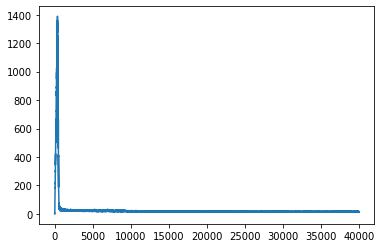

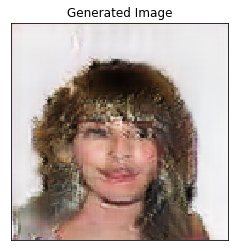

checkpointing at epoch: 40000
Iteration [40001/50000]......1.044(s) gen: 943.3967 - disc_fake: -943.5563 - disc_real: -927.9093 - neg_critic: 15.6470 - gp: 0.1654
Iteration [40002/50000]......1.041(s) gen: 943.0961 - disc_fake: -943.2647 - disc_real: -928.5996 - neg_critic: 14.6651 - gp: 0.1507
Iteration [40003/50000]......1.049(s) gen: 944.2479 - disc_fake: -944.4354 - disc_real: -928.9597 - neg_critic: 15.4757 - gp: 0.1528
Iteration [40004/50000]......1.034(s) gen: 940.9109 - disc_fake: -942.2904 - disc_real: -927.3951 - neg_critic: 14.8953 - gp: 0.1593
Iteration [40005/50000]......1.049(s) gen: 940.5215 - disc_fake: -944.3239 - disc_real: -928.6252 - neg_critic: 15.6987 - gp: 0.1864
Iteration [40006/50000]......1.034(s) gen: 946.3409 - disc_fake: -944.1892 - disc_real: -929.5653 - neg_critic: 14.6239 - gp: 0.1528
Iteration [40007/50000]......1.049(s) gen: 943.5058 - disc_fake: -945.1627 - disc_real: -930.2445 - neg_critic: 14.9182 - gp: 0.1430
Iteration [40008/50000]......1.050(s) g

Iteration [40063/50000]......1.049(s) gen: 946.5772 - disc_fake: -943.3705 - disc_real: -930.5179 - neg_critic: 12.8526 - gp: 0.1559
Iteration [40064/50000]......1.050(s) gen: 945.5165 - disc_fake: -946.4020 - disc_real: -931.8776 - neg_critic: 14.5244 - gp: 0.1769
Iteration [40065/50000]......1.034(s) gen: 946.2656 - disc_fake: -941.6499 - disc_real: -929.0241 - neg_critic: 12.6258 - gp: 0.1228
Iteration [40066/50000]......1.034(s) gen: 945.2880 - disc_fake: -944.4736 - disc_real: -929.7721 - neg_critic: 14.7015 - gp: 0.1494
Iteration [40067/50000]......1.048(s) gen: 940.7682 - disc_fake: -941.9235 - disc_real: -927.4712 - neg_critic: 14.4524 - gp: 0.1715
Iteration [40068/50000]......1.034(s) gen: 942.3765 - disc_fake: -941.0979 - disc_real: -926.8597 - neg_critic: 14.2382 - gp: 0.1575
Iteration [40069/50000]......1.049(s) gen: 943.1214 - disc_fake: -944.1540 - disc_real: -929.2844 - neg_critic: 14.8696 - gp: 0.2009
Iteration [40070/50000]......1.051(s) gen: 941.9355 - disc_fake: -942

Iteration [40125/50000]......1.049(s) gen: 940.8792 - disc_fake: -949.3120 - disc_real: -935.0947 - neg_critic: 14.2174 - gp: 0.1504
Iteration [40126/50000]......1.050(s) gen: 950.1425 - disc_fake: -944.0990 - disc_real: -930.3625 - neg_critic: 13.7365 - gp: 0.1418
Iteration [40127/50000]......1.034(s) gen: 944.9226 - disc_fake: -946.9202 - disc_real: -933.0003 - neg_critic: 13.9199 - gp: 0.1431
Iteration [40128/50000]......1.049(s) gen: 944.0309 - disc_fake: -944.3200 - disc_real: -931.0085 - neg_critic: 13.3115 - gp: 0.1947
Iteration [40129/50000]......1.034(s) gen: 942.0380 - disc_fake: -944.5035 - disc_real: -930.0055 - neg_critic: 14.4980 - gp: 0.1148
Iteration [40130/50000]......1.049(s) gen: 947.1230 - disc_fake: -945.7099 - disc_real: -931.5825 - neg_critic: 14.1274 - gp: 0.1652
Iteration [40131/50000]......1.034(s) gen: 949.2097 - disc_fake: -948.2074 - disc_real: -935.3363 - neg_critic: 12.8712 - gp: 0.1469
Iteration [40132/50000]......1.048(s) gen: 949.8056 - disc_fake: -947

Iteration [40187/50000]......1.034(s) gen: 949.7911 - disc_fake: -948.7917 - disc_real: -935.4340 - neg_critic: 13.3577 - gp: 0.1883
Iteration [40188/50000]......1.049(s) gen: 946.2611 - disc_fake: -947.8932 - disc_real: -933.9766 - neg_critic: 13.9166 - gp: 0.1545
Iteration [40189/50000]......1.034(s) gen: 947.4017 - disc_fake: -946.3136 - disc_real: -930.6030 - neg_critic: 15.7106 - gp: 0.1919
Iteration [40190/50000]......1.048(s) gen: 946.8595 - disc_fake: -945.7163 - disc_real: -932.8362 - neg_critic: 12.8801 - gp: 0.1392
Iteration [40191/50000]......1.045(s) gen: 941.9484 - disc_fake: -945.5119 - disc_real: -932.8926 - neg_critic: 12.6193 - gp: 0.1162
Iteration [40192/50000]......1.039(s) gen: 946.1769 - disc_fake: -943.5539 - disc_real: -928.6329 - neg_critic: 14.9210 - gp: 0.1760
Iteration [40193/50000]......1.053(s) gen: 944.7938 - disc_fake: -944.2223 - disc_real: -930.3542 - neg_critic: 13.8681 - gp: 0.1456
Iteration [40194/50000]......1.046(s) gen: 942.7145 - disc_fake: -943

Iteration [40249/50000]......1.049(s) gen: 945.3101 - disc_fake: -945.8055 - disc_real: -930.9666 - neg_critic: 14.8389 - gp: 0.1729
Iteration [40250/50000]......1.034(s) gen: 942.9175 - disc_fake: -945.0122 - disc_real: -930.0522 - neg_critic: 14.9600 - gp: 0.1768
Iteration [40251/50000]......1.049(s) gen: 944.8969 - disc_fake: -942.8033 - disc_real: -927.6275 - neg_critic: 15.1758 - gp: 0.1446
Iteration [40252/50000]......1.034(s) gen: 947.3743 - disc_fake: -944.6174 - disc_real: -929.4923 - neg_critic: 15.1251 - gp: 0.1306
Iteration [40253/50000]......1.049(s) gen: 945.7112 - disc_fake: -945.9353 - disc_real: -928.5781 - neg_critic: 17.3571 - gp: 0.2095
Iteration [40254/50000]......1.034(s) gen: 952.9901 - disc_fake: -946.3025 - disc_real: -932.0154 - neg_critic: 14.2872 - gp: 0.1834
Iteration [40255/50000]......1.033(s) gen: 945.9080 - disc_fake: -950.6323 - disc_real: -934.6583 - neg_critic: 15.9740 - gp: 0.1318
Iteration [40256/50000]......1.033(s) gen: 948.8247 - disc_fake: -946

Iteration [40311/50000]......1.034(s) gen: 947.4043 - disc_fake: -945.9867 - disc_real: -930.8097 - neg_critic: 15.1770 - gp: 0.1681
Iteration [40312/50000]......1.049(s) gen: 948.6741 - disc_fake: -947.8080 - disc_real: -932.8850 - neg_critic: 14.9230 - gp: 0.1790
Iteration [40313/50000]......1.034(s) gen: 948.9986 - disc_fake: -947.6663 - disc_real: -932.3145 - neg_critic: 15.3518 - gp: 0.1297
Iteration [40314/50000]......1.049(s) gen: 943.4290 - disc_fake: -944.0344 - disc_real: -929.0323 - neg_critic: 15.0021 - gp: 0.1623
Iteration [40315/50000]......1.034(s) gen: 945.2585 - disc_fake: -943.0362 - disc_real: -927.3867 - neg_critic: 15.6496 - gp: 0.1663
Iteration [40316/50000]......1.048(s) gen: 944.9202 - disc_fake: -944.6598 - disc_real: -930.4263 - neg_critic: 14.2335 - gp: 0.1734
Iteration [40317/50000]......1.034(s) gen: 945.9891 - disc_fake: -945.2773 - disc_real: -930.9522 - neg_critic: 14.3251 - gp: 0.1325
Iteration [40318/50000]......1.049(s) gen: 949.3004 - disc_fake: -947

Iteration [40373/50000]......1.049(s) gen: 947.0695 - disc_fake: -945.3313 - disc_real: -930.7245 - neg_critic: 14.6068 - gp: 0.2040
Iteration [40374/50000]......1.034(s) gen: 947.0441 - disc_fake: -945.6495 - disc_real: -929.9539 - neg_critic: 15.6955 - gp: 0.1975
Iteration [40375/50000]......1.049(s) gen: 951.9855 - disc_fake: -948.7334 - disc_real: -935.4170 - neg_critic: 13.3164 - gp: 0.1277
Iteration [40376/50000]......1.034(s) gen: 946.3817 - disc_fake: -950.1145 - disc_real: -934.1236 - neg_critic: 15.9909 - gp: 0.1371
Iteration [40377/50000]......1.049(s) gen: 948.4061 - disc_fake: -945.9626 - disc_real: -930.7568 - neg_critic: 15.2058 - gp: 0.1690
Iteration [40378/50000]......1.034(s) gen: 946.7443 - disc_fake: -946.3243 - disc_real: -929.9401 - neg_critic: 16.3842 - gp: 0.1624
Iteration [40379/50000]......1.049(s) gen: 949.8937 - disc_fake: -949.3852 - disc_real: -933.2397 - neg_critic: 16.1455 - gp: 0.2176
Iteration [40380/50000]......1.034(s) gen: 946.2894 - disc_fake: -950

Iteration [40435/50000]......1.034(s) gen: 955.0222 - disc_fake: -951.8032 - disc_real: -937.7008 - neg_critic: 14.1024 - gp: 0.1567
Iteration [40436/50000]......1.049(s) gen: 948.7913 - disc_fake: -951.9814 - disc_real: -936.8585 - neg_critic: 15.1229 - gp: 0.1886
Iteration [40437/50000]......1.034(s) gen: 952.7852 - disc_fake: -950.9965 - disc_real: -936.4843 - neg_critic: 14.5122 - gp: 0.1562
Iteration [40438/50000]......1.049(s) gen: 950.7626 - disc_fake: -952.5864 - disc_real: -937.5638 - neg_critic: 15.0226 - gp: 0.1431
Iteration [40439/50000]......1.034(s) gen: 953.1649 - disc_fake: -951.4169 - disc_real: -937.4221 - neg_critic: 13.9948 - gp: 0.1650
Iteration [40440/50000]......1.049(s) gen: 950.1899 - disc_fake: -950.9937 - disc_real: -936.7371 - neg_critic: 14.2566 - gp: 0.1318
Iteration [40441/50000]......1.033(s) gen: 945.7419 - disc_fake: -948.6874 - disc_real: -932.3635 - neg_critic: 16.3239 - gp: 0.1857
Iteration [40442/50000]......1.049(s) gen: 947.3335 - disc_fake: -947

Iteration [40497/50000]......1.034(s) gen: 948.8577 - disc_fake: -952.5782 - disc_real: -938.1569 - neg_critic: 14.4213 - gp: 0.1769
Iteration [40498/50000]......1.049(s) gen: 950.2332 - disc_fake: -950.5814 - disc_real: -935.7970 - neg_critic: 14.7844 - gp: 0.1604
Iteration [40499/50000]......1.033(s) gen: 952.4740 - disc_fake: -951.0582 - disc_real: -936.0859 - neg_critic: 14.9724 - gp: 0.1506
Iteration [40500/50000]......1.049(s) gen: 955.2896 - disc_fake: -953.1300 - disc_real: -937.6348 - neg_critic: 15.4953 - gp: 0.1824
Iteration [40501/50000]......1.034(s) gen: 949.4028 - disc_fake: -953.0099 - disc_real: -938.5323 - neg_critic: 14.4776 - gp: 0.1804
Iteration [40502/50000]......1.049(s) gen: 955.1483 - disc_fake: -951.6652 - disc_real: -938.1714 - neg_critic: 13.4938 - gp: 0.1326
Iteration [40503/50000]......1.034(s) gen: 951.4879 - disc_fake: -951.0647 - disc_real: -938.4013 - neg_critic: 12.6634 - gp: 0.1392
Iteration [40504/50000]......1.049(s) gen: 947.6431 - disc_fake: -949

Iteration [40559/50000]......1.035(s) gen: 949.4027 - disc_fake: -950.3282 - disc_real: -933.7823 - neg_critic: 16.5459 - gp: 0.1826
Iteration [40560/50000]......1.048(s) gen: 954.4713 - disc_fake: -950.2577 - disc_real: -937.6661 - neg_critic: 12.5917 - gp: 0.1508
Iteration [40561/50000]......1.033(s) gen: 956.7026 - disc_fake: -955.1241 - disc_real: -941.6651 - neg_critic: 13.4590 - gp: 0.1209
Iteration [40562/50000]......1.049(s) gen: 951.8638 - disc_fake: -952.6226 - disc_real: -937.0258 - neg_critic: 15.5968 - gp: 0.1698
Iteration [40563/50000]......1.034(s) gen: 953.5064 - disc_fake: -951.2666 - disc_real: -936.2436 - neg_critic: 15.0230 - gp: 0.1408
Iteration [40564/50000]......1.049(s) gen: 948.3147 - disc_fake: -951.0815 - disc_real: -937.1378 - neg_critic: 13.9437 - gp: 0.1693
Iteration [40565/50000]......1.034(s) gen: 949.9644 - disc_fake: -950.1456 - disc_real: -935.2281 - neg_critic: 14.9175 - gp: 0.1700
Iteration [40566/50000]......1.049(s) gen: 957.5817 - disc_fake: -952

Iteration [40621/50000]......1.048(s) gen: 946.2509 - disc_fake: -950.0218 - disc_real: -934.3592 - neg_critic: 15.6626 - gp: 0.1887
Iteration [40622/50000]......1.049(s) gen: 955.7990 - disc_fake: -952.0922 - disc_real: -938.1814 - neg_critic: 13.9108 - gp: 0.1552
Iteration [40623/50000]......1.033(s) gen: 948.9940 - disc_fake: -952.1403 - disc_real: -937.3506 - neg_critic: 14.7896 - gp: 0.1442
Iteration [40624/50000]......1.033(s) gen: 951.0430 - disc_fake: -950.5530 - disc_real: -935.6457 - neg_critic: 14.9073 - gp: 0.2244
Iteration [40625/50000]......1.057(s) gen: 951.0803 - disc_fake: -953.8936 - disc_real: -937.6076 - neg_critic: 16.2860 - gp: 0.1491
Iteration [40626/50000]......1.043(s) gen: 951.9113 - disc_fake: -950.6349 - disc_real: -935.0453 - neg_critic: 15.5895 - gp: 0.1630
Iteration [40627/50000]......1.048(s) gen: 950.9388 - disc_fake: -949.8284 - disc_real: -935.8318 - neg_critic: 13.9966 - gp: 0.1556
Iteration [40628/50000]......1.034(s) gen: 955.1394 - disc_fake: -953

Iteration [40683/50000]......1.049(s) gen: 953.8683 - disc_fake: -953.4635 - disc_real: -938.2924 - neg_critic: 15.1710 - gp: 0.1534
Iteration [40684/50000]......1.034(s) gen: 948.2927 - disc_fake: -951.0764 - disc_real: -936.9034 - neg_critic: 14.1730 - gp: 0.1558
Iteration [40685/50000]......1.049(s) gen: 949.5663 - disc_fake: -947.4284 - disc_real: -933.4929 - neg_critic: 13.9355 - gp: 0.1664
Iteration [40686/50000]......1.034(s) gen: 949.2509 - disc_fake: -949.4251 - disc_real: -935.8402 - neg_critic: 13.5849 - gp: 0.1449
Iteration [40687/50000]......1.049(s) gen: 952.7793 - disc_fake: -950.1478 - disc_real: -936.3444 - neg_critic: 13.8034 - gp: 0.1390
Iteration [40688/50000]......1.034(s) gen: 952.9176 - disc_fake: -952.1493 - disc_real: -936.7264 - neg_critic: 15.4230 - gp: 0.1560
Iteration [40689/50000]......1.049(s) gen: 954.0889 - disc_fake: -951.0541 - disc_real: -936.9287 - neg_critic: 14.1255 - gp: 0.1451
Iteration [40690/50000]......1.050(s) gen: 950.2391 - disc_fake: -952

Iteration [40745/50000]......1.049(s) gen: 954.8567 - disc_fake: -953.9268 - disc_real: -939.3661 - neg_critic: 14.5607 - gp: 0.1304
Iteration [40746/50000]......1.034(s) gen: 955.8109 - disc_fake: -952.5022 - disc_real: -938.7332 - neg_critic: 13.7690 - gp: 0.1727
Iteration [40747/50000]......1.049(s) gen: 956.7197 - disc_fake: -956.8418 - disc_real: -940.5173 - neg_critic: 16.3245 - gp: 0.2143
Iteration [40748/50000]......1.034(s) gen: 952.1753 - disc_fake: -953.2944 - disc_real: -938.5924 - neg_critic: 14.7020 - gp: 0.1265
Iteration [40749/50000]......1.049(s) gen: 948.8977 - disc_fake: -950.6338 - disc_real: -933.3172 - neg_critic: 17.3166 - gp: 0.1688
Iteration [40750/50000]......1.034(s) gen: 958.1837 - disc_fake: -952.4061 - disc_real: -936.3439 - neg_critic: 16.0622 - gp: 0.1795
Iteration [40751/50000]......1.049(s) gen: 949.9485 - disc_fake: -955.1227 - disc_real: -939.4612 - neg_critic: 15.6615 - gp: 0.1737
Iteration [40752/50000]......1.034(s) gen: 948.2669 - disc_fake: -949

Iteration [40807/50000]......1.049(s) gen: 957.9001 - disc_fake: -955.6029 - disc_real: -941.7660 - neg_critic: 13.8369 - gp: 0.1513
Iteration [40808/50000]......1.034(s) gen: 957.6624 - disc_fake: -956.4784 - disc_real: -940.7079 - neg_critic: 15.7705 - gp: 0.1678
Iteration [40809/50000]......1.049(s) gen: 957.5708 - disc_fake: -957.5770 - disc_real: -942.1008 - neg_critic: 15.4763 - gp: 0.1853
Iteration [40810/50000]......1.033(s) gen: 956.0568 - disc_fake: -954.8289 - disc_real: -940.5673 - neg_critic: 14.2616 - gp: 0.1689
Iteration [40811/50000]......1.049(s) gen: 956.2299 - disc_fake: -955.7521 - disc_real: -940.9564 - neg_critic: 14.7957 - gp: 0.1847
Iteration [40812/50000]......1.050(s) gen: 960.7815 - disc_fake: -958.0388 - disc_real: -944.0970 - neg_critic: 13.9418 - gp: 0.1898
Iteration [40813/50000]......1.034(s) gen: 955.9019 - disc_fake: -957.4290 - disc_real: -943.0151 - neg_critic: 14.4139 - gp: 0.1372
Iteration [40814/50000]......1.049(s) gen: 957.8027 - disc_fake: -955

Iteration [40869/50000]......1.034(s) gen: 951.3906 - disc_fake: -952.7267 - disc_real: -938.1153 - neg_critic: 14.6115 - gp: 0.1762
Iteration [40870/50000]......1.049(s) gen: 951.7100 - disc_fake: -953.1192 - disc_real: -938.3621 - neg_critic: 14.7570 - gp: 0.1736
Iteration [40871/50000]......1.034(s) gen: 965.3272 - disc_fake: -956.3855 - disc_real: -942.5962 - neg_critic: 13.7893 - gp: 0.1098
Iteration [40872/50000]......1.049(s) gen: 958.0409 - disc_fake: -960.5195 - disc_real: -945.1186 - neg_critic: 15.4009 - gp: 0.2107
Iteration [40873/50000]......1.034(s) gen: 955.3785 - disc_fake: -954.8614 - disc_real: -939.7901 - neg_critic: 15.0713 - gp: 0.1583
Iteration [40874/50000]......1.049(s) gen: 952.2839 - disc_fake: -956.7617 - disc_real: -943.1567 - neg_critic: 13.6050 - gp: 0.1430
Iteration [40875/50000]......1.034(s) gen: 954.7458 - disc_fake: -952.8872 - disc_real: -938.8133 - neg_critic: 14.0740 - gp: 0.1325
Iteration [40876/50000]......1.049(s) gen: 945.8624 - disc_fake: -951

Iteration [40931/50000]......1.034(s) gen: 955.3066 - disc_fake: -953.4303 - disc_real: -939.3632 - neg_critic: 14.0671 - gp: 0.1646
Iteration [40932/50000]......1.050(s) gen: 951.7355 - disc_fake: -954.7351 - disc_real: -940.5280 - neg_critic: 14.2072 - gp: 0.1709
Iteration [40933/50000]......1.033(s) gen: 956.1617 - disc_fake: -953.8566 - disc_real: -938.7416 - neg_critic: 15.1151 - gp: 0.1663
Iteration [40934/50000]......1.050(s) gen: 958.2399 - disc_fake: -957.7608 - disc_real: -943.1094 - neg_critic: 14.6514 - gp: 0.1790
Iteration [40935/50000]......1.032(s) gen: 956.3485 - disc_fake: -956.6428 - disc_real: -941.3326 - neg_critic: 15.3102 - gp: 0.1384
Iteration [40936/50000]......1.049(s) gen: 953.1929 - disc_fake: -957.0623 - disc_real: -940.1966 - neg_critic: 16.8657 - gp: 0.1739
Iteration [40937/50000]......1.034(s) gen: 956.7696 - disc_fake: -955.5316 - disc_real: -941.8689 - neg_critic: 13.6628 - gp: 0.2187
Iteration [40938/50000]......1.049(s) gen: 956.6199 - disc_fake: -958

Iteration [40993/50000]......1.048(s) gen: 954.8625 - disc_fake: -952.6725 - disc_real: -938.3075 - neg_critic: 14.3650 - gp: 0.1428
Iteration [40994/50000]......1.034(s) gen: 953.1968 - disc_fake: -953.3962 - disc_real: -938.1745 - neg_critic: 15.2217 - gp: 0.1485
Iteration [40995/50000]......1.049(s) gen: 958.3501 - disc_fake: -954.5721 - disc_real: -941.2025 - neg_critic: 13.3696 - gp: 0.1384
Iteration [40996/50000]......1.034(s) gen: 955.0621 - disc_fake: -954.8173 - disc_real: -939.4073 - neg_critic: 15.4100 - gp: 0.1511
Iteration [40997/50000]......1.056(s) gen: 956.6743 - disc_fake: -957.4252 - disc_real: -943.5490 - neg_critic: 13.8762 - gp: 0.1312
Iteration [40998/50000]......1.028(s) gen: 958.2416 - disc_fake: -956.3485 - disc_real: -941.0904 - neg_critic: 15.2581 - gp: 0.1721
Iteration [40999/50000]......1.052(s) gen: 958.1643 - disc_fake: -957.0532 - disc_real: -943.4717 - neg_critic: 13.5816 - gp: 0.1539
Iteration [41000/50000]......1.047(s) gen: 957.8698 - disc_fake: -955

Iteration [41055/50000]......1.034(s) gen: 958.8745 - disc_fake: -960.0144 - disc_real: -946.4414 - neg_critic: 13.5730 - gp: 0.1365
Iteration [41056/50000]......1.050(s) gen: 954.5379 - disc_fake: -954.5888 - disc_real: -940.0928 - neg_critic: 14.4959 - gp: 0.1872
Iteration [41057/50000]......1.032(s) gen: 952.3811 - disc_fake: -952.3478 - disc_real: -938.5885 - neg_critic: 13.7594 - gp: 0.1455
Iteration [41058/50000]......1.049(s) gen: 947.5869 - disc_fake: -950.6170 - disc_real: -937.5667 - neg_critic: 13.0503 - gp: 0.1478
Iteration [41059/50000]......1.034(s) gen: 954.3535 - disc_fake: -953.0579 - disc_real: -938.8651 - neg_critic: 14.1928 - gp: 0.1891
Iteration [41060/50000]......1.049(s) gen: 956.4738 - disc_fake: -954.8392 - disc_real: -942.4925 - neg_critic: 12.3467 - gp: 0.1439
Iteration [41061/50000]......1.034(s) gen: 954.9344 - disc_fake: -954.2326 - disc_real: -939.5595 - neg_critic: 14.6731 - gp: 0.1740
Iteration [41062/50000]......1.049(s) gen: 956.1514 - disc_fake: -956

Iteration [41117/50000]......1.049(s) gen: 965.3790 - disc_fake: -961.3229 - disc_real: -946.6494 - neg_critic: 14.6736 - gp: 0.1627
Iteration [41118/50000]......1.034(s) gen: 958.4167 - disc_fake: -965.2989 - disc_real: -951.8019 - neg_critic: 13.4969 - gp: 0.1269
Iteration [41119/50000]......1.034(s) gen: 955.9320 - disc_fake: -956.9665 - disc_real: -941.9368 - neg_critic: 15.0296 - gp: 0.1913
Iteration [41120/50000]......1.049(s) gen: 952.8054 - disc_fake: -957.2092 - disc_real: -940.7132 - neg_critic: 16.4960 - gp: 0.1646
Iteration [41121/50000]......1.034(s) gen: 963.9486 - disc_fake: -961.1901 - disc_real: -945.7593 - neg_critic: 15.4308 - gp: 0.1555
Iteration [41122/50000]......1.048(s) gen: 964.4778 - disc_fake: -962.3339 - disc_real: -947.7353 - neg_critic: 14.5986 - gp: 0.1699
Iteration [41123/50000]......1.034(s) gen: 964.6198 - disc_fake: -962.8205 - disc_real: -947.5426 - neg_critic: 15.2780 - gp: 0.1649
Iteration [41124/50000]......1.049(s) gen: 962.6548 - disc_fake: -961

Iteration [41179/50000]......1.049(s) gen: 960.2355 - disc_fake: -958.6675 - disc_real: -943.3688 - neg_critic: 15.2986 - gp: 0.1490
Iteration [41180/50000]......1.034(s) gen: 963.1566 - disc_fake: -961.0819 - disc_real: -946.7496 - neg_critic: 14.3323 - gp: 0.1405
Iteration [41181/50000]......1.049(s) gen: 960.4185 - disc_fake: -959.6214 - disc_real: -945.1099 - neg_critic: 14.5114 - gp: 0.1493
Iteration [41182/50000]......1.034(s) gen: 956.7007 - disc_fake: -957.7304 - disc_real: -942.8654 - neg_critic: 14.8650 - gp: 0.1807
Iteration [41183/50000]......1.049(s) gen: 956.1432 - disc_fake: -954.1128 - disc_real: -939.6524 - neg_critic: 14.4605 - gp: 0.1510
Iteration [41184/50000]......1.050(s) gen: 952.6324 - disc_fake: -953.4296 - disc_real: -938.8498 - neg_critic: 14.5798 - gp: 0.1643
Iteration [41185/50000]......1.034(s) gen: 963.6760 - disc_fake: -954.7302 - disc_real: -941.2422 - neg_critic: 13.4881 - gp: 0.1630
Iteration [41186/50000]......1.049(s) gen: 965.1891 - disc_fake: -962

Iteration [41241/50000]......1.048(s) gen: 964.9567 - disc_fake: -961.2021 - disc_real: -947.5289 - neg_critic: 13.6732 - gp: 0.1491
Iteration [41242/50000]......1.050(s) gen: 962.4053 - disc_fake: -963.0097 - disc_real: -947.8676 - neg_critic: 15.1420 - gp: 0.1624
Iteration [41243/50000]......1.033(s) gen: 962.5936 - disc_fake: -963.0425 - disc_real: -948.3427 - neg_critic: 14.6998 - gp: 0.1468
Iteration [41244/50000]......1.048(s) gen: 959.9165 - disc_fake: -962.4470 - disc_real: -947.6700 - neg_critic: 14.7770 - gp: 0.1694
Iteration [41245/50000]......1.036(s) gen: 958.9426 - disc_fake: -961.7891 - disc_real: -946.8766 - neg_critic: 14.9125 - gp: 0.1518
Iteration [41246/50000]......1.049(s) gen: 960.3888 - disc_fake: -961.2851 - disc_real: -947.4112 - neg_critic: 13.8739 - gp: 0.1425
Iteration [41247/50000]......1.033(s) gen: 960.3952 - disc_fake: -958.0996 - disc_real: -942.6969 - neg_critic: 15.4026 - gp: 0.1763
Iteration [41248/50000]......1.048(s) gen: 964.7821 - disc_fake: -962

Iteration [41303/50000]......1.034(s) gen: 960.1841 - disc_fake: -959.3852 - disc_real: -943.4988 - neg_critic: 15.8864 - gp: 0.2394
Iteration [41304/50000]......1.049(s) gen: 960.4858 - disc_fake: -960.2974 - disc_real: -944.8496 - neg_critic: 15.4478 - gp: 0.1429
Iteration [41305/50000]......1.033(s) gen: 965.2211 - disc_fake: -963.9016 - disc_real: -949.2733 - neg_critic: 14.6282 - gp: 0.1633
Iteration [41306/50000]......1.049(s) gen: 967.9034 - disc_fake: -966.6574 - disc_real: -952.7977 - neg_critic: 13.8597 - gp: 0.1473
Iteration [41307/50000]......1.034(s) gen: 962.2576 - disc_fake: -964.2347 - disc_real: -948.9846 - neg_critic: 15.2501 - gp: 0.1607
Iteration [41308/50000]......1.049(s) gen: 963.4329 - disc_fake: -963.0822 - disc_real: -948.1601 - neg_critic: 14.9220 - gp: 0.1613
Iteration [41309/50000]......1.036(s) gen: 959.5713 - disc_fake: -961.2700 - disc_real: -946.4363 - neg_critic: 14.8337 - gp: 0.1447
Iteration [41310/50000]......1.047(s) gen: 961.7413 - disc_fake: -960

Iteration [41365/50000]......1.049(s) gen: 966.9427 - disc_fake: -962.6710 - disc_real: -948.5235 - neg_critic: 14.1475 - gp: 0.1717
Iteration [41366/50000]......1.033(s) gen: 965.7972 - disc_fake: -965.4885 - disc_real: -950.9255 - neg_critic: 14.5630 - gp: 0.1382
Iteration [41367/50000]......1.050(s) gen: 960.0100 - disc_fake: -963.6080 - disc_real: -948.5552 - neg_critic: 15.0528 - gp: 0.1427
Iteration [41368/50000]......1.034(s) gen: 965.1864 - disc_fake: -962.4239 - disc_real: -948.2572 - neg_critic: 14.1667 - gp: 0.1593
Iteration [41369/50000]......1.049(s) gen: 962.9191 - disc_fake: -962.7330 - disc_real: -948.4248 - neg_critic: 14.3082 - gp: 0.1696
Iteration [41370/50000]......1.034(s) gen: 960.3903 - disc_fake: -961.0215 - disc_real: -945.8167 - neg_critic: 15.2048 - gp: 0.1553
Iteration [41371/50000]......1.049(s) gen: 963.0731 - disc_fake: -961.3479 - disc_real: -946.3431 - neg_critic: 15.0048 - gp: 0.1805
Iteration [41372/50000]......1.034(s) gen: 961.0034 - disc_fake: -962

Iteration [41427/50000]......1.049(s) gen: 960.7247 - disc_fake: -960.9122 - disc_real: -947.1072 - neg_critic: 13.8049 - gp: 0.1419
Iteration [41428/50000]......1.050(s) gen: 963.6106 - disc_fake: -961.3711 - disc_real: -947.4132 - neg_critic: 13.9579 - gp: 0.1665
Iteration [41429/50000]......1.034(s) gen: 963.3289 - disc_fake: -961.7415 - disc_real: -946.9628 - neg_critic: 14.7787 - gp: 0.1432
Iteration [41430/50000]......1.049(s) gen: 962.7649 - disc_fake: -963.9515 - disc_real: -949.9508 - neg_critic: 14.0007 - gp: 0.1331
Iteration [41431/50000]......1.034(s) gen: 964.2777 - disc_fake: -963.2175 - disc_real: -949.1183 - neg_critic: 14.0991 - gp: 0.1644
Iteration [41432/50000]......1.049(s) gen: 958.7126 - disc_fake: -963.1309 - disc_real: -948.5087 - neg_critic: 14.6222 - gp: 0.1533
Iteration [41433/50000]......1.034(s) gen: 959.9975 - disc_fake: -957.6478 - disc_real: -942.8346 - neg_critic: 14.8132 - gp: 0.1357
Iteration [41434/50000]......1.049(s) gen: 959.5895 - disc_fake: -959

Iteration [41489/50000]......1.051(s) gen: 966.9565 - disc_fake: -963.1227 - disc_real: -948.4514 - neg_critic: 14.6713 - gp: 0.1553
Iteration [41490/50000]......1.048(s) gen: 964.9449 - disc_fake: -964.6132 - disc_real: -952.2062 - neg_critic: 12.4070 - gp: 0.1507
Iteration [41491/50000]......1.035(s) gen: 965.3542 - disc_fake: -964.3090 - disc_real: -950.3054 - neg_critic: 14.0036 - gp: 0.1176
Iteration [41492/50000]......1.048(s) gen: 966.1798 - disc_fake: -966.0305 - disc_real: -951.5159 - neg_critic: 14.5146 - gp: 0.1528
Iteration [41493/50000]......1.034(s) gen: 966.7082 - disc_fake: -965.7742 - disc_real: -950.3616 - neg_critic: 15.4127 - gp: 0.1884
Iteration [41494/50000]......1.049(s) gen: 966.3789 - disc_fake: -966.0348 - disc_real: -952.9405 - neg_critic: 13.0943 - gp: 0.1616
Iteration [41495/50000]......1.050(s) gen: 962.5797 - disc_fake: -966.3696 - disc_real: -951.3103 - neg_critic: 15.0594 - gp: 0.1195
Iteration [41496/50000]......1.034(s) gen: 963.8148 - disc_fake: -962

Iteration [41551/50000]......1.049(s) gen: 959.6052 - disc_fake: -963.1939 - disc_real: -947.4097 - neg_critic: 15.7842 - gp: 0.1496
Iteration [41552/50000]......1.050(s) gen: 967.6991 - disc_fake: -964.3716 - disc_real: -951.1729 - neg_critic: 13.1986 - gp: 0.1684
Iteration [41553/50000]......1.034(s) gen: 963.5769 - disc_fake: -966.4655 - disc_real: -950.6768 - neg_critic: 15.7887 - gp: 0.1927
Iteration [41554/50000]......1.049(s) gen: 957.4009 - disc_fake: -962.7180 - disc_real: -946.6626 - neg_critic: 16.0554 - gp: 0.1612
Iteration [41555/50000]......1.034(s) gen: 966.8295 - disc_fake: -964.4699 - disc_real: -948.7306 - neg_critic: 15.7393 - gp: 0.1732
Iteration [41556/50000]......1.049(s) gen: 968.0881 - disc_fake: -967.7892 - disc_real: -952.1866 - neg_critic: 15.6026 - gp: 0.1708
Iteration [41557/50000]......1.034(s) gen: 969.6743 - disc_fake: -968.5407 - disc_real: -954.6021 - neg_critic: 13.9386 - gp: 0.1442
Iteration [41558/50000]......1.049(s) gen: 967.3049 - disc_fake: -968

Iteration [41613/50000]......1.034(s) gen: 973.1475 - disc_fake: -969.8795 - disc_real: -955.4644 - neg_critic: 14.4152 - gp: 0.1938
Iteration [41614/50000]......1.049(s) gen: 971.4420 - disc_fake: -969.8229 - disc_real: -956.1729 - neg_critic: 13.6500 - gp: 0.1451
Iteration [41615/50000]......1.034(s) gen: 965.2445 - disc_fake: -969.7409 - disc_real: -954.5105 - neg_critic: 15.2304 - gp: 0.1603
Iteration [41616/50000]......1.049(s) gen: 963.8729 - disc_fake: -962.4111 - disc_real: -946.6974 - neg_critic: 15.7137 - gp: 0.1871
Iteration [41617/50000]......1.034(s) gen: 963.2344 - disc_fake: -964.0885 - disc_real: -947.6253 - neg_critic: 16.4633 - gp: 0.1651
Iteration [41618/50000]......1.049(s) gen: 963.9640 - disc_fake: -962.4528 - disc_real: -948.0366 - neg_critic: 14.4162 - gp: 0.1864
Iteration [41619/50000]......1.034(s) gen: 968.4476 - disc_fake: -966.7070 - disc_real: -952.2947 - neg_critic: 14.4123 - gp: 0.1541
Iteration [41620/50000]......1.049(s) gen: 970.3842 - disc_fake: -968

Iteration [41675/50000]......1.048(s) gen: 974.0085 - disc_fake: -971.1859 - disc_real: -955.9854 - neg_critic: 15.2006 - gp: 0.1735
Iteration [41676/50000]......1.033(s) gen: 971.9961 - disc_fake: -971.7843 - disc_real: -957.9340 - neg_critic: 13.8503 - gp: 0.1954
Iteration [41677/50000]......1.049(s) gen: 972.4520 - disc_fake: -972.5694 - disc_real: -958.2175 - neg_critic: 14.3520 - gp: 0.1692
Iteration [41678/50000]......1.034(s) gen: 967.0385 - disc_fake: -969.0855 - disc_real: -955.0831 - neg_critic: 14.0023 - gp: 0.1354
Iteration [41679/50000]......1.049(s) gen: 969.3870 - disc_fake: -968.3331 - disc_real: -952.6697 - neg_critic: 15.6635 - gp: 0.1702
Iteration [41680/50000]......1.034(s) gen: 970.7137 - disc_fake: -969.0638 - disc_real: -954.5483 - neg_critic: 14.5154 - gp: 0.1672
Iteration [41681/50000]......1.049(s) gen: 968.4978 - disc_fake: -968.3801 - disc_real: -954.6524 - neg_critic: 13.7277 - gp: 0.1195
Iteration [41682/50000]......1.034(s) gen: 971.0964 - disc_fake: -970

Iteration [41737/50000]......1.050(s) gen: 965.7412 - disc_fake: -967.4052 - disc_real: -953.1547 - neg_critic: 14.2505 - gp: 0.1547
Iteration [41738/50000]......1.034(s) gen: 969.0132 - disc_fake: -966.1702 - disc_real: -951.1650 - neg_critic: 15.0052 - gp: 0.1644
Iteration [41739/50000]......1.049(s) gen: 968.9918 - disc_fake: -969.0271 - disc_real: -952.9022 - neg_critic: 16.1248 - gp: 0.1501
Iteration [41740/50000]......1.034(s) gen: 973.3694 - disc_fake: -968.8063 - disc_real: -955.5312 - neg_critic: 13.2751 - gp: 0.1541
Iteration [41741/50000]......1.049(s) gen: 971.3400 - disc_fake: -968.5490 - disc_real: -951.5953 - neg_critic: 16.9536 - gp: 0.1780
Iteration [41742/50000]......1.034(s) gen: 969.3077 - disc_fake: -970.7706 - disc_real: -955.2921 - neg_critic: 15.4786 - gp: 0.1808
Iteration [41743/50000]......1.049(s) gen: 970.1941 - disc_fake: -967.6035 - disc_real: -953.2508 - neg_critic: 14.3527 - gp: 0.2224
Iteration [41744/50000]......1.034(s) gen: 972.2487 - disc_fake: -970

Iteration [41799/50000]......1.048(s) gen: 972.8636 - disc_fake: -974.6046 - disc_real: -959.4965 - neg_critic: 15.1081 - gp: 0.1738
Iteration [41800/50000]......1.034(s) gen: 972.0093 - disc_fake: -972.1808 - disc_real: -956.0706 - neg_critic: 16.1103 - gp: 0.1846
Iteration [41801/50000]......1.049(s) gen: 967.3607 - disc_fake: -968.8858 - disc_real: -954.5734 - neg_critic: 14.3124 - gp: 0.1732
Iteration [41802/50000]......1.034(s) gen: 969.0378 - disc_fake: -968.6621 - disc_real: -953.7169 - neg_critic: 14.9452 - gp: 0.1617
Iteration [41803/50000]......1.049(s) gen: 969.5061 - disc_fake: -969.7687 - disc_real: -955.1843 - neg_critic: 14.5843 - gp: 0.1305
Iteration [41804/50000]......1.034(s) gen: 970.9250 - disc_fake: -971.0948 - disc_real: -955.9234 - neg_critic: 15.1714 - gp: 0.1911
Iteration [41805/50000]......1.059(s) gen: 970.1227 - disc_fake: -970.1937 - disc_real: -953.0318 - neg_critic: 17.1619 - gp: 0.1828
Iteration [41806/50000]......1.041(s) gen: 974.6235 - disc_fake: -972

Iteration [41861/50000]......1.050(s) gen: 969.6050 - disc_fake: -968.6012 - disc_real: -952.3899 - neg_critic: 16.2113 - gp: 0.1808
Iteration [41862/50000]......1.033(s) gen: 970.0637 - disc_fake: -970.6701 - disc_real: -956.9736 - neg_critic: 13.6965 - gp: 0.1262
Iteration [41863/50000]......1.049(s) gen: 972.2009 - disc_fake: -972.2595 - disc_real: -956.4972 - neg_critic: 15.7623 - gp: 0.1782
Iteration [41864/50000]......1.034(s) gen: 970.9821 - disc_fake: -972.0866 - disc_real: -958.3397 - neg_critic: 13.7468 - gp: 0.1652
Iteration [41865/50000]......1.048(s) gen: 971.6641 - disc_fake: -972.4298 - disc_real: -959.0223 - neg_critic: 13.4075 - gp: 0.1384
Iteration [41866/50000]......1.034(s) gen: 967.1718 - disc_fake: -971.0002 - disc_real: -955.4626 - neg_critic: 15.5376 - gp: 0.1309
Iteration [41867/50000]......1.049(s) gen: 968.2271 - disc_fake: -968.0457 - disc_real: -952.1395 - neg_critic: 15.9062 - gp: 0.1808
Iteration [41868/50000]......1.034(s) gen: 968.5349 - disc_fake: -970

Iteration [41923/50000]......1.049(s) gen: 971.0035 - disc_fake: -973.0687 - disc_real: -959.6082 - neg_critic: 13.4605 - gp: 0.1168
Iteration [41924/50000]......1.034(s) gen: 971.8174 - disc_fake: -970.3795 - disc_real: -956.0337 - neg_critic: 14.3458 - gp: 0.1669
Iteration [41925/50000]......1.049(s) gen: 971.6565 - disc_fake: -973.0769 - disc_real: -958.2877 - neg_critic: 14.7892 - gp: 0.1295
Iteration [41926/50000]......1.034(s) gen: 973.4942 - disc_fake: -971.7636 - disc_real: -957.4499 - neg_critic: 14.3137 - gp: 0.1744
Iteration [41927/50000]......1.049(s) gen: 972.9726 - disc_fake: -974.7657 - disc_real: -961.7509 - neg_critic: 13.0148 - gp: 0.1035
Iteration [41928/50000]......1.034(s) gen: 971.1851 - disc_fake: -974.6486 - disc_real: -959.5473 - neg_critic: 15.1013 - gp: 0.1630
Iteration [41929/50000]......1.049(s) gen: 973.6145 - disc_fake: -972.5348 - disc_real: -959.0800 - neg_critic: 13.4548 - gp: 0.1286
Iteration [41930/50000]......1.034(s) gen: 975.8649 - disc_fake: -974

Iteration [41985/50000]......1.034(s) gen: 975.1973 - disc_fake: -974.2373 - disc_real: -960.1663 - neg_critic: 14.0709 - gp: 0.1195
Iteration [41986/50000]......1.049(s) gen: 969.3596 - disc_fake: -972.7487 - disc_real: -955.3658 - neg_critic: 17.3829 - gp: 0.1843
Iteration [41987/50000]......1.034(s) gen: 970.7706 - disc_fake: -971.2119 - disc_real: -956.4392 - neg_critic: 14.7727 - gp: 0.1896
Iteration [41988/50000]......1.033(s) gen: 967.5412 - disc_fake: -971.3238 - disc_real: -955.3572 - neg_critic: 15.9666 - gp: 0.2203
Iteration [41989/50000]......1.034(s) gen: 979.5199 - disc_fake: -973.2881 - disc_real: -960.2416 - neg_critic: 13.0465 - gp: 0.1359
Iteration [41990/50000]......1.049(s) gen: 976.4480 - disc_fake: -976.2575 - disc_real: -962.3212 - neg_critic: 13.9363 - gp: 0.1511
Iteration [41991/50000]......1.050(s) gen: 973.6234 - disc_fake: -975.5536 - disc_real: -960.2402 - neg_critic: 15.3134 - gp: 0.1581
Iteration [41992/50000]......1.036(s) gen: 977.6201 - disc_fake: -976

Iteration [42047/50000]......1.050(s) gen: 973.1209 - disc_fake: -970.1159 - disc_real: -956.2478 - neg_critic: 13.8680 - gp: 0.1449
Iteration [42048/50000]......1.034(s) gen: 974.0862 - disc_fake: -973.8933 - disc_real: -958.0173 - neg_critic: 15.8760 - gp: 0.1482
Iteration [42049/50000]......1.049(s) gen: 967.6404 - disc_fake: -970.0431 - disc_real: -956.0433 - neg_critic: 13.9998 - gp: 0.2077
Iteration [42050/50000]......1.034(s) gen: 971.3527 - disc_fake: -969.5293 - disc_real: -953.5011 - neg_critic: 16.0282 - gp: 0.1592
Iteration [42051/50000]......1.049(s) gen: 971.1456 - disc_fake: -969.4950 - disc_real: -953.9141 - neg_critic: 15.5809 - gp: 0.1598
Iteration [42052/50000]......1.034(s) gen: 969.0154 - disc_fake: -967.4190 - disc_real: -951.2541 - neg_critic: 16.1650 - gp: 0.2377
Iteration [42053/50000]......1.049(s) gen: 971.3492 - disc_fake: -970.0370 - disc_real: -955.5968 - neg_critic: 14.4402 - gp: 0.1272
Iteration [42054/50000]......1.033(s) gen: 972.4271 - disc_fake: -972

Iteration [42109/50000]......1.049(s) gen: 972.7363 - disc_fake: -974.0569 - disc_real: -961.1647 - neg_critic: 12.8922 - gp: 0.1039
Iteration [42110/50000]......1.034(s) gen: 970.2872 - disc_fake: -971.8928 - disc_real: -955.8226 - neg_critic: 16.0703 - gp: 0.1969
Iteration [42111/50000]......1.049(s) gen: 970.8158 - disc_fake: -970.5213 - disc_real: -954.8973 - neg_critic: 15.6240 - gp: 0.1390
Iteration [42112/50000]......1.034(s) gen: 971.1931 - disc_fake: -971.1749 - disc_real: -955.0248 - neg_critic: 16.1500 - gp: 0.1942
Iteration [42113/50000]......1.049(s) gen: 975.8609 - disc_fake: -973.4284 - disc_real: -960.2264 - neg_critic: 13.2020 - gp: 0.1416
Iteration [42114/50000]......1.034(s) gen: 975.8644 - disc_fake: -974.3090 - disc_real: -960.2963 - neg_critic: 14.0126 - gp: 0.1476
Iteration [42115/50000]......1.049(s) gen: 970.7356 - disc_fake: -970.8713 - disc_real: -955.7478 - neg_critic: 15.1235 - gp: 0.1978
Iteration [42116/50000]......1.050(s) gen: 970.5071 - disc_fake: -969

Iteration [42171/50000]......1.034(s) gen: 979.3458 - disc_fake: -976.1766 - disc_real: -961.2208 - neg_critic: 14.9558 - gp: 0.1689
Iteration [42172/50000]......1.049(s) gen: 980.0403 - disc_fake: -977.6693 - disc_real: -962.7450 - neg_critic: 14.9243 - gp: 0.1670
Iteration [42173/50000]......1.032(s) gen: 977.0658 - disc_fake: -978.0440 - disc_real: -965.1399 - neg_critic: 12.9041 - gp: 0.1902
Iteration [42174/50000]......1.050(s) gen: 973.7312 - disc_fake: -975.0610 - disc_real: -958.3762 - neg_critic: 16.6847 - gp: 0.1697
Iteration [42175/50000]......1.051(s) gen: 979.5132 - disc_fake: -974.0045 - disc_real: -959.6890 - neg_critic: 14.3155 - gp: 0.2385
Iteration [42176/50000]......1.033(s) gen: 983.6300 - disc_fake: -979.1607 - disc_real: -965.8930 - neg_critic: 13.2677 - gp: 0.1050
Iteration [42177/50000]......1.049(s) gen: 973.5562 - disc_fake: -977.2340 - disc_real: -962.1244 - neg_critic: 15.1097 - gp: 0.1759
Iteration [42178/50000]......1.034(s) gen: 970.2829 - disc_fake: -970

Iteration [42233/50000]......1.048(s) gen: 968.8146 - disc_fake: -971.6683 - disc_real: -956.0567 - neg_critic: 15.6116 - gp: 0.1538
Iteration [42234/50000]......1.050(s) gen: 972.7391 - disc_fake: -972.7592 - disc_real: -959.0802 - neg_critic: 13.6790 - gp: 0.1441
Iteration [42235/50000]......1.034(s) gen: 970.5638 - disc_fake: -972.4605 - disc_real: -956.9703 - neg_critic: 15.4902 - gp: 0.2069
Iteration [42236/50000]......1.049(s) gen: 976.5893 - disc_fake: -974.1331 - disc_real: -960.1529 - neg_critic: 13.9802 - gp: 0.1633
Iteration [42237/50000]......1.034(s) gen: 975.5939 - disc_fake: -975.6957 - disc_real: -961.2061 - neg_critic: 14.4896 - gp: 0.1405
Iteration [42238/50000]......1.049(s) gen: 976.1409 - disc_fake: -974.0533 - disc_real: -960.3646 - neg_critic: 13.6887 - gp: 0.1782
Iteration [42239/50000]......1.034(s) gen: 974.0128 - disc_fake: -973.3738 - disc_real: -958.5739 - neg_critic: 14.8000 - gp: 0.1278
Iteration [42240/50000]......1.049(s) gen: 968.2512 - disc_fake: -970

Iteration [42295/50000]......1.049(s) gen: 970.9948 - disc_fake: -972.4365 - disc_real: -955.8695 - neg_critic: 16.5670 - gp: 0.1618
Iteration [42296/50000]......1.050(s) gen: 976.4073 - disc_fake: -972.7240 - disc_real: -958.9428 - neg_critic: 13.7812 - gp: 0.1670
Iteration [42297/50000]......1.034(s) gen: 977.0121 - disc_fake: -974.9647 - disc_real: -961.2648 - neg_critic: 13.6999 - gp: 0.1305
Iteration [42298/50000]......1.049(s) gen: 977.8052 - disc_fake: -977.6466 - disc_real: -963.2982 - neg_critic: 14.3485 - gp: 0.1570
Iteration [42299/50000]......1.034(s) gen: 975.7162 - disc_fake: -976.1160 - disc_real: -962.9259 - neg_critic: 13.1901 - gp: 0.1198
Iteration [42300/50000]......1.049(s) gen: 976.3372 - disc_fake: -977.6483 - disc_real: -961.6080 - neg_critic: 16.0403 - gp: 0.1752
Iteration [42301/50000]......1.034(s) gen: 973.3186 - disc_fake: -975.8961 - disc_real: -961.2476 - neg_critic: 14.6485 - gp: 0.1607
Iteration [42302/50000]......1.048(s) gen: 970.5327 - disc_fake: -972

Iteration [42357/50000]......1.034(s) gen: 981.0665 - disc_fake: -982.2348 - disc_real: -967.6967 - neg_critic: 14.5381 - gp: 0.1509
Iteration [42358/50000]......1.049(s) gen: 979.3934 - disc_fake: -977.9396 - disc_real: -964.4569 - neg_critic: 13.4827 - gp: 0.1354
Iteration [42359/50000]......1.034(s) gen: 973.0675 - disc_fake: -975.8332 - disc_real: -961.0508 - neg_critic: 14.7824 - gp: 0.1556
Iteration [42360/50000]......1.049(s) gen: 969.9656 - disc_fake: -973.4879 - disc_real: -956.9005 - neg_critic: 16.5874 - gp: 0.1990
Iteration [42361/50000]......1.034(s) gen: 974.3878 - disc_fake: -969.8854 - disc_real: -956.5854 - neg_critic: 13.2999 - gp: 0.1878
Iteration [42362/50000]......1.049(s) gen: 976.7567 - disc_fake: -975.6111 - disc_real: -961.0586 - neg_critic: 14.5525 - gp: 0.1494
Iteration [42363/50000]......1.051(s) gen: 978.5753 - disc_fake: -976.2566 - disc_real: -961.3063 - neg_critic: 14.9503 - gp: 0.1794
Iteration [42364/50000]......1.033(s) gen: 974.4369 - disc_fake: -975

Iteration [42419/50000]......1.034(s) gen: 980.1097 - disc_fake: -980.3230 - disc_real: -965.1891 - neg_critic: 15.1340 - gp: 0.2089
Iteration [42420/50000]......1.049(s) gen: 976.5515 - disc_fake: -978.1467 - disc_real: -962.5476 - neg_critic: 15.5991 - gp: 0.1400
Iteration [42421/50000]......1.034(s) gen: 978.8161 - disc_fake: -978.1570 - disc_real: -964.0383 - neg_critic: 14.1187 - gp: 0.1789
Iteration [42422/50000]......1.049(s) gen: 978.3040 - disc_fake: -978.3804 - disc_real: -964.9971 - neg_critic: 13.3832 - gp: 0.1419
Iteration [42423/50000]......1.034(s) gen: 976.7961 - disc_fake: -976.5998 - disc_real: -961.7791 - neg_critic: 14.8207 - gp: 0.1266
Iteration [42424/50000]......1.049(s) gen: 978.9382 - disc_fake: -978.1619 - disc_real: -961.9938 - neg_critic: 16.1680 - gp: 0.2028
Iteration [42425/50000]......1.034(s) gen: 977.4530 - disc_fake: -979.1261 - disc_real: -964.6854 - neg_critic: 14.4407 - gp: 0.1836
Iteration [42426/50000]......1.049(s) gen: 980.0325 - disc_fake: -978

Iteration [42481/50000]......1.034(s) gen: 977.9624 - disc_fake: -977.7604 - disc_real: -963.2025 - neg_critic: 14.5580 - gp: 0.1506
Iteration [42482/50000]......1.049(s) gen: 972.9154 - disc_fake: -975.6301 - disc_real: -960.3306 - neg_critic: 15.2995 - gp: 0.1568
Iteration [42483/50000]......1.049(s) gen: 974.0207 - disc_fake: -973.9058 - disc_real: -960.4392 - neg_critic: 13.4667 - gp: 0.1647
Iteration [42484/50000]......1.034(s) gen: 973.8833 - disc_fake: -973.9586 - disc_real: -959.7822 - neg_critic: 14.1765 - gp: 0.1545
Iteration [42485/50000]......1.033(s) gen: 976.9757 - disc_fake: -975.7012 - disc_real: -962.5039 - neg_critic: 13.1973 - gp: 0.1637
Iteration [42486/50000]......1.043(s) gen: 971.6443 - disc_fake: -974.3736 - disc_real: -959.9609 - neg_critic: 14.4127 - gp: 0.1665
Iteration [42487/50000]......1.055(s) gen: 977.5295 - disc_fake: -973.2328 - disc_real: -957.8101 - neg_critic: 15.4228 - gp: 0.1785
Iteration [42488/50000]......1.034(s) gen: 976.3175 - disc_fake: -978

Iteration [42543/50000]......1.049(s) gen: 976.2219 - disc_fake: -976.9220 - disc_real: -962.0216 - neg_critic: 14.9005 - gp: 0.1904
Iteration [42544/50000]......1.034(s) gen: 975.6631 - disc_fake: -974.8801 - disc_real: -959.2661 - neg_critic: 15.6140 - gp: 0.1893
Iteration [42545/50000]......1.049(s) gen: 977.4358 - disc_fake: -976.2515 - disc_real: -961.3262 - neg_critic: 14.9253 - gp: 0.1409
Iteration [42546/50000]......1.050(s) gen: 981.3731 - disc_fake: -979.3303 - disc_real: -966.3680 - neg_critic: 12.9623 - gp: 0.1786
Iteration [42547/50000]......1.035(s) gen: 976.2131 - disc_fake: -978.5224 - disc_real: -964.1895 - neg_critic: 14.3329 - gp: 0.1298
Iteration [42548/50000]......1.048(s) gen: 978.2993 - disc_fake: -976.8055 - disc_real: -963.3287 - neg_critic: 13.4769 - gp: 0.1577
Iteration [42549/50000]......1.034(s) gen: 969.0093 - disc_fake: -973.8818 - disc_real: -957.1686 - neg_critic: 16.7132 - gp: 0.1692
Iteration [42550/50000]......1.049(s) gen: 978.2577 - disc_fake: -972

Iteration [42605/50000]......1.049(s) gen: 976.7142 - disc_fake: -978.9867 - disc_real: -962.4509 - neg_critic: 16.5358 - gp: 0.1489
Iteration [42606/50000]......1.034(s) gen: 981.5074 - disc_fake: -979.8591 - disc_real: -965.1143 - neg_critic: 14.7448 - gp: 0.1739
Iteration [42607/50000]......1.049(s) gen: 980.8345 - disc_fake: -982.7527 - disc_real: -967.3236 - neg_critic: 15.4290 - gp: 0.1747
Iteration [42608/50000]......1.034(s) gen: 979.2222 - disc_fake: -980.0957 - disc_real: -965.5643 - neg_critic: 14.5314 - gp: 0.1463
Iteration [42609/50000]......1.054(s) gen: 985.3817 - disc_fake: -981.9645 - disc_real: -966.7935 - neg_critic: 15.1710 - gp: 0.1747
Iteration [42610/50000]......1.045(s) gen: 979.6547 - disc_fake: -982.2834 - disc_real: -967.2756 - neg_critic: 15.0077 - gp: 0.1629
Iteration [42611/50000]......1.045(s) gen: 974.3885 - disc_fake: -979.1313 - disc_real: -964.7048 - neg_critic: 14.4266 - gp: 0.1403
Iteration [42612/50000]......1.054(s) gen: 982.1459 - disc_fake: -975

Iteration [42667/50000]......1.034(s) gen: 975.9988 - disc_fake: -979.9512 - disc_real: -964.2373 - neg_critic: 15.7139 - gp: 0.1680
Iteration [42668/50000]......1.049(s) gen: 981.8940 - disc_fake: -979.8948 - disc_real: -962.4403 - neg_critic: 17.4545 - gp: 0.1712
Iteration [42669/50000]......1.035(s) gen: 984.4802 - disc_fake: -983.1613 - disc_real: -969.5307 - neg_critic: 13.6306 - gp: 0.2087
Iteration [42670/50000]......1.048(s) gen: 984.4628 - disc_fake: -982.0193 - disc_real: -968.8399 - neg_critic: 13.1794 - gp: 0.1247
Iteration [42671/50000]......1.034(s) gen: 980.3254 - disc_fake: -982.1992 - disc_real: -969.5378 - neg_critic: 12.6615 - gp: 0.1458
Iteration [42672/50000]......1.049(s) gen: 976.8652 - disc_fake: -977.2677 - disc_real: -964.2138 - neg_critic: 13.0539 - gp: 0.1193
Iteration [42673/50000]......1.050(s) gen: 975.6140 - disc_fake: -977.9970 - disc_real: -963.4990 - neg_critic: 14.4980 - gp: 0.1481
Iteration [42674/50000]......1.034(s) gen: 975.3223 - disc_fake: -978

Iteration [42729/50000]......1.054(s) gen: 983.0804 - disc_fake: -982.3116 - disc_real: -966.7865 - neg_critic: 15.5251 - gp: 0.1649
Iteration [42730/50000]......1.034(s) gen: 982.2983 - disc_fake: -983.4860 - disc_real: -967.1904 - neg_critic: 16.2956 - gp: 0.1649
Iteration [42731/50000]......1.049(s) gen: 984.1025 - disc_fake: -984.9474 - disc_real: -969.4086 - neg_critic: 15.5387 - gp: 0.1796
Iteration [42732/50000]......1.034(s) gen: 979.0199 - disc_fake: -982.0926 - disc_real: -967.3987 - neg_critic: 14.6939 - gp: 0.1577
Iteration [42733/50000]......1.048(s) gen: 983.1579 - disc_fake: -984.7273 - disc_real: -969.5326 - neg_critic: 15.1947 - gp: 0.1546
Iteration [42734/50000]......1.034(s) gen: 982.7023 - disc_fake: -983.4814 - disc_real: -968.2079 - neg_critic: 15.2735 - gp: 0.1906
Iteration [42735/50000]......1.050(s) gen: 984.1660 - disc_fake: -983.2134 - disc_real: -969.2939 - neg_critic: 13.9195 - gp: 0.1551
Iteration [42736/50000]......1.049(s) gen: 983.1162 - disc_fake: -983

Iteration [42791/50000]......1.034(s) gen: 982.6039 - disc_fake: -983.3082 - disc_real: -967.8627 - neg_critic: 15.4455 - gp: 0.1602
Iteration [42792/50000]......1.049(s) gen: 979.6805 - disc_fake: -982.6571 - disc_real: -965.2790 - neg_critic: 17.3781 - gp: 0.1907
Iteration [42793/50000]......1.034(s) gen: 976.0923 - disc_fake: -978.9339 - disc_real: -964.8188 - neg_critic: 14.1152 - gp: 0.1659
Iteration [42794/50000]......1.048(s) gen: 974.9275 - disc_fake: -976.6475 - disc_real: -959.5112 - neg_critic: 17.1364 - gp: 0.2014
Iteration [42795/50000]......1.034(s) gen: 974.4230 - disc_fake: -975.1592 - disc_real: -959.9472 - neg_critic: 15.2120 - gp: 0.1712
Iteration [42796/50000]......1.049(s) gen: 972.2045 - disc_fake: -974.1860 - disc_real: -959.3652 - neg_critic: 14.8208 - gp: 0.1767
Iteration [42797/50000]......1.050(s) gen: 980.6246 - disc_fake: -977.4427 - disc_real: -963.7867 - neg_critic: 13.6560 - gp: 0.1324
Iteration [42798/50000]......1.034(s) gen: 976.3076 - disc_fake: -981

Iteration [42853/50000]......1.034(s) gen: 980.4951 - disc_fake: -980.7900 - disc_real: -967.3799 - neg_critic: 13.4101 - gp: 0.1556
Iteration [42854/50000]......1.050(s) gen: 978.6130 - disc_fake: -978.9892 - disc_real: -963.9175 - neg_critic: 15.0717 - gp: 0.1672
Iteration [42855/50000]......1.033(s) gen: 983.1596 - disc_fake: -981.0988 - disc_real: -967.6257 - neg_critic: 13.4731 - gp: 0.1965
Iteration [42856/50000]......1.033(s) gen: 974.1124 - disc_fake: -980.0219 - disc_real: -965.7520 - neg_critic: 14.2699 - gp: 0.1440
Iteration [42857/50000]......1.050(s) gen: 982.4108 - disc_fake: -978.9347 - disc_real: -963.3739 - neg_critic: 15.5607 - gp: 0.1505
Iteration [42858/50000]......1.034(s) gen: 983.5912 - disc_fake: -982.7708 - disc_real: -967.4120 - neg_critic: 15.3588 - gp: 0.1639
Iteration [42859/50000]......1.049(s) gen: 982.2729 - disc_fake: -981.7902 - disc_real: -968.0404 - neg_critic: 13.7497 - gp: 0.1608
Iteration [42860/50000]......1.034(s) gen: 979.0372 - disc_fake: -982

Iteration [42915/50000]......1.049(s) gen: 984.3094 - disc_fake: -984.2284 - disc_real: -970.2238 - neg_critic: 14.0047 - gp: 0.1122
Iteration [42916/50000]......1.034(s) gen: 977.1423 - disc_fake: -978.8937 - disc_real: -962.2132 - neg_critic: 16.6805 - gp: 0.1769
Iteration [42917/50000]......1.049(s) gen: 985.5789 - disc_fake: -980.2089 - disc_real: -966.9762 - neg_critic: 13.2327 - gp: 0.1740
Iteration [42918/50000]......1.033(s) gen: 984.5813 - disc_fake: -986.7925 - disc_real: -972.5861 - neg_critic: 14.2064 - gp: 0.1558
Iteration [42919/50000]......1.049(s) gen: 982.3538 - disc_fake: -986.0808 - disc_real: -970.1269 - neg_critic: 15.9539 - gp: 0.1818
Iteration [42920/50000]......1.034(s) gen: 983.6639 - disc_fake: -982.0054 - disc_real: -965.4484 - neg_critic: 16.5570 - gp: 0.1371
Iteration [42921/50000]......1.049(s) gen: 982.6177 - disc_fake: -982.1448 - disc_real: -966.7446 - neg_critic: 15.4002 - gp: 0.2123
Iteration [42922/50000]......1.034(s) gen: 980.1595 - disc_fake: -980

Iteration [42977/50000]......1.033(s) gen: 985.4417 - disc_fake: -984.6084 - disc_real: -970.5275 - neg_critic: 14.0809 - gp: 0.1610
Iteration [42978/50000]......1.049(s) gen: 983.3694 - disc_fake: -984.6046 - disc_real: -970.6997 - neg_critic: 13.9050 - gp: 0.1393
Iteration [42979/50000]......1.050(s) gen: 984.8345 - disc_fake: -983.3925 - disc_real: -968.8525 - neg_critic: 14.5400 - gp: 0.1314
Iteration [42980/50000]......1.034(s) gen: 985.8384 - disc_fake: -984.4199 - disc_real: -968.8989 - neg_critic: 15.5211 - gp: 0.1990
Iteration [42981/50000]......1.049(s) gen: 987.9961 - disc_fake: -984.8314 - disc_real: -971.5540 - neg_critic: 13.2773 - gp: 0.1252
Iteration [42982/50000]......1.034(s) gen: 986.5994 - disc_fake: -984.5280 - disc_real: -970.4004 - neg_critic: 14.1276 - gp: 0.1485
Iteration [42983/50000]......1.049(s) gen: 978.6661 - disc_fake: -981.5689 - disc_real: -966.2904 - neg_critic: 15.2786 - gp: 0.1765
Iteration [42984/50000]......1.034(s) gen: 979.9304 - disc_fake: -975

Iteration [43039/50000]......1.034(s) gen: 979.6252 - disc_fake: -978.4872 - disc_real: -963.3017 - neg_critic: 15.1855 - gp: 0.1619
Iteration [43040/50000]......1.049(s) gen: 975.9291 - disc_fake: -976.2089 - disc_real: -958.9713 - neg_critic: 17.2376 - gp: 0.1999
Iteration [43041/50000]......1.033(s) gen: 984.4463 - disc_fake: -981.4295 - disc_real: -968.9857 - neg_critic: 12.4437 - gp: 0.1760
Iteration [43042/50000]......1.049(s) gen: 981.7502 - disc_fake: -983.1745 - disc_real: -967.1383 - neg_critic: 16.0362 - gp: 0.1164
Iteration [43043/50000]......1.034(s) gen: 986.7731 - disc_fake: -982.9588 - disc_real: -968.0121 - neg_critic: 14.9467 - gp: 0.1774
Iteration [43044/50000]......1.049(s) gen: 984.3389 - disc_fake: -985.7280 - disc_real: -970.3501 - neg_critic: 15.3779 - gp: 0.2101
Iteration [43045/50000]......1.050(s) gen: 980.7399 - disc_fake: -982.7505 - disc_real: -967.6889 - neg_critic: 15.0615 - gp: 0.1618
Iteration [43046/50000]......1.034(s) gen: 983.9564 - disc_fake: -982

Iteration [43101/50000]......1.034(s) gen: 984.2496 - disc_fake: -987.3133 - disc_real: -973.0209 - neg_critic: 14.2923 - gp: 0.1540
Iteration [43102/50000]......1.050(s) gen: 984.5759 - disc_fake: -984.7942 - disc_real: -970.0391 - neg_critic: 14.7551 - gp: 0.1526
Iteration [43103/50000]......1.033(s) gen: 985.9198 - disc_fake: -984.3258 - disc_real: -969.5368 - neg_critic: 14.7891 - gp: 0.1797
Iteration [43104/50000]......1.049(s) gen: 984.3739 - disc_fake: -983.4237 - disc_real: -968.8286 - neg_critic: 14.5951 - gp: 0.1515
Iteration [43105/50000]......1.034(s) gen: 993.9446 - disc_fake: -988.2264 - disc_real: -975.2409 - neg_critic: 12.9855 - gp: 0.1553
Iteration [43106/50000]......1.049(s) gen: 986.3262 - disc_fake: -988.5715 - disc_real: -974.9662 - neg_critic: 13.6053 - gp: 0.1520
Iteration [43107/50000]......1.033(s) gen: 988.4738 - disc_fake: -984.4948 - disc_real: -969.6688 - neg_critic: 14.8260 - gp: 0.1887
Iteration [43108/50000]......1.049(s) gen: 985.7806 - disc_fake: -986

Iteration [43163/50000]......1.049(s) gen: 984.7488 - disc_fake: -982.6940 - disc_real: -968.5890 - neg_critic: 14.1050 - gp: 0.1628
Iteration [43164/50000]......1.034(s) gen: 982.3285 - disc_fake: -982.7829 - disc_real: -967.3038 - neg_critic: 15.4792 - gp: 0.1553
Iteration [43165/50000]......1.049(s) gen: 986.4730 - disc_fake: -983.1374 - disc_real: -968.1360 - neg_critic: 15.0015 - gp: 0.1784
Iteration [43166/50000]......1.034(s) gen: 987.7869 - disc_fake: -986.4691 - disc_real: -971.2469 - neg_critic: 15.2223 - gp: 0.1428
Iteration [43167/50000]......1.048(s) gen: 988.7872 - disc_fake: -988.6168 - disc_real: -974.3197 - neg_critic: 14.2971 - gp: 0.1532
Iteration [43168/50000]......1.034(s) gen: 987.6140 - disc_fake: -988.2276 - disc_real: -971.3930 - neg_critic: 16.8346 - gp: 0.2304
Iteration [43169/50000]......1.049(s) gen: 986.9914 - disc_fake: -985.9238 - disc_real: -973.2102 - neg_critic: 12.7136 - gp: 0.1466
Iteration [43170/50000]......1.034(s) gen: 986.5591 - disc_fake: -985

Iteration [43225/50000]......1.049(s) gen: 984.0363 - disc_fake: -985.6149 - disc_real: -971.1348 - neg_critic: 14.4801 - gp: 0.1819
Iteration [43226/50000]......1.050(s) gen: 985.3881 - disc_fake: -985.3000 - disc_real: -971.5723 - neg_critic: 13.7276 - gp: 0.1248
Iteration [43227/50000]......1.034(s) gen: 981.2645 - disc_fake: -982.5996 - disc_real: -968.7229 - neg_critic: 13.8767 - gp: 0.1629
Iteration [43228/50000]......1.049(s) gen: 984.0315 - disc_fake: -986.4111 - disc_real: -973.2368 - neg_critic: 13.1743 - gp: 0.1582
Iteration [43229/50000]......1.034(s) gen: 978.5844 - disc_fake: -981.7262 - disc_real: -967.2057 - neg_critic: 14.5206 - gp: 0.1483
Iteration [43230/50000]......1.050(s) gen: 985.8379 - disc_fake: -981.6516 - disc_real: -968.4708 - neg_critic: 13.1809 - gp: 0.1638
Iteration [43231/50000]......1.033(s) gen: 987.0685 - disc_fake: -986.0385 - disc_real: -971.3425 - neg_critic: 14.6960 - gp: 0.1309
Iteration [43232/50000]......1.049(s) gen: 987.0741 - disc_fake: -983

Iteration [43287/50000]......1.048(s) gen: 982.0632 - disc_fake: -983.6750 - disc_real: -967.2272 - neg_critic: 16.4477 - gp: 0.1906
Iteration [43288/50000]......1.033(s) gen: 989.4962 - disc_fake: -984.9418 - disc_real: -970.4995 - neg_critic: 14.4423 - gp: 0.2047
Iteration [43289/50000]......1.049(s) gen: 990.2366 - disc_fake: -988.5937 - disc_real: -973.9760 - neg_critic: 14.6177 - gp: 0.1536
Iteration [43290/50000]......1.034(s) gen: 983.6417 - disc_fake: -988.7115 - disc_real: -974.0541 - neg_critic: 14.6574 - gp: 0.1292
Iteration [43291/50000]......1.049(s) gen: 986.6690 - disc_fake: -985.2618 - disc_real: -970.7459 - neg_critic: 14.5159 - gp: 0.1485
Iteration [43292/50000]......1.034(s) gen: 978.9836 - disc_fake: -984.0870 - disc_real: -968.7459 - neg_critic: 15.3410 - gp: 0.1693
Iteration [43293/50000]......1.049(s) gen: 986.8103 - disc_fake: -982.5689 - disc_real: -967.6108 - neg_critic: 14.9581 - gp: 0.1998
Iteration [43294/50000]......1.034(s) gen: 988.0233 - disc_fake: -984

Iteration [43349/50000]......1.034(s) gen: 987.7777 - disc_fake: -989.0605 - disc_real: -976.2094 - neg_critic: 12.8511 - gp: 0.1367
Iteration [43350/50000]......1.035(s) gen: 992.0485 - disc_fake: -988.1431 - disc_real: -974.8666 - neg_critic: 13.2765 - gp: 0.2039
Iteration [43351/50000]......1.047(s) gen: 990.0596 - disc_fake: -991.7390 - disc_real: -976.1132 - neg_critic: 15.6259 - gp: 0.1305
Iteration [43352/50000]......1.052(s) gen: 986.7928 - disc_fake: -986.9516 - disc_real: -972.5728 - neg_critic: 14.3789 - gp: 0.1592
Iteration [43353/50000]......1.032(s) gen: 989.2742 - disc_fake: -988.7027 - disc_real: -975.8388 - neg_critic: 12.8639 - gp: 0.1398
Iteration [43354/50000]......1.049(s) gen: 988.1102 - disc_fake: -989.5362 - disc_real: -973.4928 - neg_critic: 16.0434 - gp: 0.1682
Iteration [43355/50000]......1.034(s) gen: 991.2777 - disc_fake: -989.0248 - disc_real: -975.6019 - neg_critic: 13.4228 - gp: 0.1800
Iteration [43356/50000]......1.049(s) gen: 991.9865 - disc_fake: -989

Iteration [43411/50000]......1.034(s) gen: 992.7461 - disc_fake: -989.7932 - disc_real: -976.2951 - neg_critic: 13.4982 - gp: 0.1351
Iteration [43412/50000]......1.049(s) gen: 989.5238 - disc_fake: -989.1891 - disc_real: -974.4531 - neg_critic: 14.7361 - gp: 0.1972
Iteration [43413/50000]......1.033(s) gen: 987.9174 - disc_fake: -989.8677 - disc_real: -975.6612 - neg_critic: 14.2065 - gp: 0.1524
Iteration [43414/50000]......1.049(s) gen: 988.9113 - disc_fake: -986.3644 - disc_real: -971.5958 - neg_critic: 14.7686 - gp: 0.1623
Iteration [43415/50000]......1.050(s) gen: 980.5693 - disc_fake: -987.0423 - disc_real: -970.9333 - neg_critic: 16.1090 - gp: 0.1505
Iteration [43416/50000]......1.034(s) gen: 985.9564 - disc_fake: -984.1345 - disc_real: -970.3679 - neg_critic: 13.7666 - gp: 0.1592
Iteration [43417/50000]......1.058(s) gen: 994.4587 - disc_fake: -987.6865 - disc_real: -973.1637 - neg_critic: 14.5228 - gp: 0.1685
Iteration [43418/50000]......1.042(s) gen: 993.6058 - disc_fake: -991

Iteration [43473/50000]......1.033(s) gen: 987.6136 - disc_fake: -991.4861 - disc_real: -975.6718 - neg_critic: 15.8143 - gp: 0.1890
Iteration [43474/50000]......1.050(s) gen: 988.9199 - disc_fake: -988.6710 - disc_real: -972.9730 - neg_critic: 15.6980 - gp: 0.1838
Iteration [43475/50000]......1.049(s) gen: 987.8459 - disc_fake: -987.9802 - disc_real: -972.3050 - neg_critic: 15.6751 - gp: 0.1582
Iteration [43476/50000]......1.034(s) gen: 990.1198 - disc_fake: -988.3346 - disc_real: -972.9622 - neg_critic: 15.3724 - gp: 0.1871
Iteration [43477/50000]......1.049(s) gen: 984.2913 - disc_fake: -987.3412 - disc_real: -972.4502 - neg_critic: 14.8910 - gp: 0.1348
Iteration [43478/50000]......1.034(s) gen: 995.3447 - disc_fake: -989.4554 - disc_real: -975.4102 - neg_critic: 14.0452 - gp: 0.1931
Iteration [43479/50000]......1.049(s) gen: 999.7194 - disc_fake: -995.4508 - disc_real: -980.8001 - neg_critic: 14.6507 - gp: 0.1227
Iteration [43480/50000]......1.034(s) gen: 992.7486 - disc_fake: -995

Iteration [43535/50000]......1.050(s) gen: 983.5522 - disc_fake: -987.0156 - disc_real: -971.3759 - neg_critic: 15.6397 - gp: 0.1394
Iteration [43536/50000]......1.034(s) gen: 990.5403 - disc_fake: -986.1864 - disc_real: -970.4943 - neg_critic: 15.6921 - gp: 0.2029
Iteration [43537/50000]......1.033(s) gen: 991.9817 - disc_fake: -990.5118 - disc_real: -975.8472 - neg_critic: 14.6646 - gp: 0.1404
Iteration [43538/50000]......1.034(s) gen: 993.3976 - disc_fake: -992.6375 - disc_real: -979.5090 - neg_critic: 13.1286 - gp: 0.1533
Iteration [43539/50000]......1.049(s) gen: 986.9583 - disc_fake: -990.2113 - disc_real: -976.7045 - neg_critic: 13.5068 - gp: 0.1681
Iteration [43540/50000]......1.034(s) gen: 991.1599 - disc_fake: -988.5971 - disc_real: -973.6523 - neg_critic: 14.9448 - gp: 0.1558
Iteration [43541/50000]......1.049(s) gen: 991.1187 - disc_fake: -989.5789 - disc_real: -973.4592 - neg_critic: 16.1197 - gp: 0.1432
Iteration [43542/50000]......1.034(s) gen: 993.4525 - disc_fake: -993

Iteration [43597/50000]......1.049(s) gen: 991.0085 - disc_fake: -994.4107 - disc_real: -979.2685 - neg_critic: 15.1422 - gp: 0.2009
Iteration [43598/50000]......1.037(s) gen: 987.7564 - disc_fake: -990.9466 - disc_real: -975.5927 - neg_critic: 15.3539 - gp: 0.1483
Iteration [43599/50000]......1.047(s) gen: 999.7594 - disc_fake: -993.2043 - disc_real: -978.5477 - neg_critic: 14.6567 - gp: 0.1493
Iteration [43600/50000]......1.034(s) gen: 999.6066 - disc_fake: -999.0161 - disc_real: -984.3857 - neg_critic: 14.6304 - gp: 0.1442
Iteration [43601/50000]......1.049(s) gen: 994.4351 - disc_fake: -995.2171 - disc_real: -980.7985 - neg_critic: 14.4185 - gp: 0.1583
Iteration [43602/50000]......1.050(s) gen: 994.9324 - disc_fake: -996.1013 - disc_real: -982.5820 - neg_critic: 13.5193 - gp: 0.1771
Iteration [43603/50000]......1.034(s) gen: 991.6301 - disc_fake: -992.7284 - disc_real: -978.7507 - neg_critic: 13.9776 - gp: 0.1863
Iteration [43604/50000]......1.049(s) gen: 991.9740 - disc_fake: -989

Iteration [43659/50000]......1.034(s) gen: 990.9071 - disc_fake: -990.7208 - disc_real: -976.9599 - neg_critic: 13.7609 - gp: 0.1298
Iteration [43660/50000]......1.049(s) gen: 990.9929 - disc_fake: -990.3215 - disc_real: -976.0394 - neg_critic: 14.2821 - gp: 0.1695
Iteration [43661/50000]......1.035(s) gen: 991.2798 - disc_fake: -989.8998 - disc_real: -974.8703 - neg_critic: 15.0296 - gp: 0.1819
Iteration [43662/50000]......1.048(s) gen: 987.8887 - disc_fake: -988.7320 - disc_real: -973.7787 - neg_critic: 14.9533 - gp: 0.1763
Iteration [43663/50000]......1.049(s) gen: 994.0754 - disc_fake: -990.1696 - disc_real: -975.1784 - neg_critic: 14.9913 - gp: 0.1938
Iteration [43664/50000]......1.036(s) gen: 994.8078 - disc_fake: -994.1560 - disc_real: -979.4111 - neg_critic: 14.7449 - gp: 0.1321
Iteration [43665/50000]......1.049(s) gen: 991.5519 - disc_fake: -992.1148 - disc_real: -976.4004 - neg_critic: 15.7144 - gp: 0.1993
Iteration [43666/50000]......1.033(s) gen: 990.2235 - disc_fake: -989

Iteration [43721/50000]......1.034(s) gen: 994.1578 - disc_fake: -996.5850 - disc_real: -980.6544 - neg_critic: 15.9306 - gp: 0.1646
Iteration [43722/50000]......1.049(s) gen: 995.0941 - disc_fake: -996.0854 - disc_real: -980.1507 - neg_critic: 15.9347 - gp: 0.1835
Iteration [43723/50000]......1.033(s) gen: 1002.7487 - disc_fake: -999.5043 - disc_real: -983.9668 - neg_critic: 15.5375 - gp: 0.1396
Iteration [43724/50000]......1.049(s) gen: 1006.1227 - disc_fake: -1000.9456 - disc_real: -986.9157 - neg_critic: 14.0298 - gp: 0.1932
Iteration [43725/50000]......1.034(s) gen: 996.4358 - disc_fake: -1002.1111 - disc_real: -986.9450 - neg_critic: 15.1661 - gp: 0.1360
Iteration [43726/50000]......1.049(s) gen: 993.2368 - disc_fake: -998.8425 - disc_real: -984.4253 - neg_critic: 14.4172 - gp: 0.1673
Iteration [43727/50000]......1.034(s) gen: 991.7516 - disc_fake: -993.0435 - disc_real: -978.4456 - neg_critic: 14.5980 - gp: 0.1808
Iteration [43728/50000]......1.049(s) gen: 999.1464 - disc_fake: 

Iteration [43783/50000]......1.034(s) gen: 992.5100 - disc_fake: -992.1423 - disc_real: -976.8003 - neg_critic: 15.3420 - gp: 0.1920
Iteration [43784/50000]......1.049(s) gen: 994.3582 - disc_fake: -993.5190 - disc_real: -978.6253 - neg_critic: 14.8937 - gp: 0.2102
Iteration [43785/50000]......1.049(s) gen: 996.9423 - disc_fake: -995.7236 - disc_real: -982.3482 - neg_critic: 13.3754 - gp: 0.1280
Iteration [43786/50000]......1.036(s) gen: 992.9521 - disc_fake: -993.4484 - disc_real: -978.0578 - neg_critic: 15.3906 - gp: 0.1309
Iteration [43787/50000]......1.048(s) gen: 991.5062 - disc_fake: -992.7679 - disc_real: -977.7307 - neg_critic: 15.0373 - gp: 0.2072
Iteration [43788/50000]......1.034(s) gen: 993.0066 - disc_fake: -991.8189 - disc_real: -976.5886 - neg_critic: 15.2303 - gp: 0.1261
Iteration [43789/50000]......1.033(s) gen: 991.5870 - disc_fake: -992.0207 - disc_real: -976.1631 - neg_critic: 15.8576 - gp: 0.1956
Iteration [43790/50000]......1.034(s) gen: 991.4839 - disc_fake: -990

Iteration [43845/50000]......1.033(s) gen: 990.7014 - disc_fake: -991.9293 - disc_real: -976.9856 - neg_critic: 14.9437 - gp: 0.1624
Iteration [43846/50000]......1.050(s) gen: 996.5612 - disc_fake: -990.8691 - disc_real: -978.7773 - neg_critic: 12.0919 - gp: 0.1411
Iteration [43847/50000]......1.033(s) gen: 996.0977 - disc_fake: -997.6619 - disc_real: -984.1698 - neg_critic: 13.4922 - gp: 0.1289
Iteration [43848/50000]......1.049(s) gen: 999.0707 - disc_fake: -994.5595 - disc_real: -979.7250 - neg_critic: 14.8346 - gp: 0.1622
Iteration [43849/50000]......1.034(s) gen: 998.9008 - disc_fake: -997.3602 - disc_real: -983.9349 - neg_critic: 13.4253 - gp: 0.1377
Iteration [43850/50000]......1.049(s) gen: 1001.7450 - disc_fake: -998.2677 - disc_real: -984.9891 - neg_critic: 13.2786 - gp: 0.1453
Iteration [43851/50000]......1.050(s) gen: 993.1451 - disc_fake: -997.4557 - disc_real: -983.7072 - neg_critic: 13.7485 - gp: 0.1381
Iteration [43852/50000]......1.034(s) gen: 991.2654 - disc_fake: -99

Iteration [43907/50000]......1.049(s) gen: 999.8892 - disc_fake: -995.5991 - disc_real: -980.7649 - neg_critic: 14.8342 - gp: 0.1463
Iteration [43908/50000]......1.034(s) gen: 996.9455 - disc_fake: -996.6524 - disc_real: -983.4144 - neg_critic: 13.2379 - gp: 0.1548
Iteration [43909/50000]......1.049(s) gen: 994.2744 - disc_fake: -995.1890 - disc_real: -980.8704 - neg_critic: 14.3186 - gp: 0.1466
Iteration [43910/50000]......1.034(s) gen: 995.2769 - disc_fake: -994.2036 - disc_real: -978.9247 - neg_critic: 15.2789 - gp: 0.1904
Iteration [43911/50000]......1.049(s) gen: 992.5089 - disc_fake: -997.6390 - disc_real: -982.8844 - neg_critic: 14.7546 - gp: 0.1378
Iteration [43912/50000]......1.034(s) gen: 1000.3190 - disc_fake: -996.8636 - disc_real: -982.2852 - neg_critic: 14.5784 - gp: 0.1701
Iteration [43913/50000]......1.049(s) gen: 994.1714 - disc_fake: -996.9533 - disc_real: -981.9945 - neg_critic: 14.9589 - gp: 0.1499
Iteration [43914/50000]......1.034(s) gen: 1000.0485 - disc_fake: -9

Iteration [43969/50000]......1.050(s) gen: 999.9240 - disc_fake: -996.6567 - disc_real: -983.6056 - neg_critic: 13.0511 - gp: 0.1312
Iteration [43970/50000]......1.034(s) gen: 995.9476 - disc_fake: -996.6484 - disc_real: -982.9094 - neg_critic: 13.7391 - gp: 0.1862
Iteration [43971/50000]......1.048(s) gen: 1000.4558 - disc_fake: -996.4737 - disc_real: -981.8081 - neg_critic: 14.6656 - gp: 0.1788
Iteration [43972/50000]......1.050(s) gen: 998.0625 - disc_fake: -1000.8246 - disc_real: -986.3533 - neg_critic: 14.4713 - gp: 0.1330
Iteration [43973/50000]......1.034(s) gen: 999.5607 - disc_fake: -998.1310 - disc_real: -984.9898 - neg_critic: 13.1412 - gp: 0.2010
Iteration [43974/50000]......1.049(s) gen: 996.9587 - disc_fake: -998.5617 - disc_real: -985.6782 - neg_critic: 12.8835 - gp: 0.1274
Iteration [43975/50000]......1.034(s) gen: 998.4324 - disc_fake: -998.2261 - disc_real: -983.9874 - neg_critic: 14.2387 - gp: 0.1496
Iteration [43976/50000]......1.033(s) gen: 998.4337 - disc_fake: -9

Iteration [44031/50000]......1.050(s) gen: 999.0259 - disc_fake: -999.6247 - disc_real: -984.2582 - neg_critic: 15.3665 - gp: 0.1776
Iteration [44032/50000]......1.034(s) gen: 1005.3185 - disc_fake: -1001.0919 - disc_real: -987.9817 - neg_critic: 13.1103 - gp: 0.1993
Iteration [44033/50000]......1.033(s) gen: 1002.7759 - disc_fake: -1002.8296 - disc_real: -989.7692 - neg_critic: 13.0604 - gp: 0.1046
Iteration [44034/50000]......1.049(s) gen: 999.3428 - disc_fake: -1000.2800 - disc_real: -986.7013 - neg_critic: 13.5787 - gp: 0.1499
Iteration [44035/50000]......1.050(s) gen: 994.1865 - disc_fake: -996.9182 - disc_real: -981.7410 - neg_critic: 15.1772 - gp: 0.1762
Iteration [44036/50000]......1.034(s) gen: 999.0609 - disc_fake: -997.0981 - disc_real: -982.4498 - neg_critic: 14.6483 - gp: 0.1608
Iteration [44037/50000]......1.049(s) gen: 997.4041 - disc_fake: -997.4642 - disc_real: -982.8001 - neg_critic: 14.6641 - gp: 0.1673
Iteration [44038/50000]......1.034(s) gen: 997.0811 - disc_fake:

Iteration [44092/50000]......1.034(s) gen: 1001.7754 - disc_fake: -1000.8125 - disc_real: -988.0144 - neg_critic: 12.7981 - gp: 0.1346
Iteration [44093/50000]......1.050(s) gen: 1007.5754 - disc_fake: -1001.4421 - disc_real: -987.2240 - neg_critic: 14.2181 - gp: 0.1664
Iteration [44094/50000]......1.033(s) gen: 1001.5844 - disc_fake: -1002.8222 - disc_real: -988.4511 - neg_critic: 14.3711 - gp: 0.1558
Iteration [44095/50000]......1.049(s) gen: 1004.3157 - disc_fake: -1001.3645 - disc_real: -987.9686 - neg_critic: 13.3960 - gp: 0.1484
Iteration [44096/50000]......1.050(s) gen: 1004.9725 - disc_fake: -1004.5149 - disc_real: -988.4708 - neg_critic: 16.0440 - gp: 0.1248
Iteration [44097/50000]......1.034(s) gen: 1000.1290 - disc_fake: -1000.3291 - disc_real: -986.8734 - neg_critic: 13.4557 - gp: 0.1589
Iteration [44098/50000]......1.048(s) gen: 995.6484 - disc_fake: -998.7870 - disc_real: -981.6644 - neg_critic: 17.1226 - gp: 0.1835
Iteration [44099/50000]......1.036(s) gen: 999.4111 - dis

Iteration [44154/50000]......1.034(s) gen: 1000.8888 - disc_fake: -1002.5467 - disc_real: -988.8984 - neg_critic: 13.6483 - gp: 0.1069
Iteration [44155/50000]......1.049(s) gen: 1003.4718 - disc_fake: -1000.4506 - disc_real: -984.7067 - neg_critic: 15.7439 - gp: 0.1680
Iteration [44156/50000]......1.034(s) gen: 1002.1993 - disc_fake: -1001.6679 - disc_real: -987.8608 - neg_critic: 13.8071 - gp: 0.1630
Iteration [44157/50000]......1.049(s) gen: 1001.9823 - disc_fake: -1000.2693 - disc_real: -987.5062 - neg_critic: 12.7631 - gp: 0.1504
Iteration [44158/50000]......1.034(s) gen: 997.3134 - disc_fake: -1000.6928 - disc_real: -984.7672 - neg_critic: 15.9256 - gp: 0.1534
Iteration [44159/50000]......1.049(s) gen: 995.7473 - disc_fake: -996.0026 - disc_real: -981.5128 - neg_critic: 14.4898 - gp: 0.1897
Iteration [44160/50000]......1.034(s) gen: 998.6976 - disc_fake: -998.1823 - disc_real: -984.4514 - neg_critic: 13.7309 - gp: 0.1569
Iteration [44161/50000]......1.049(s) gen: 1000.4103 - disc_

Iteration [44215/50000]......1.049(s) gen: 1000.4178 - disc_fake: -1000.9972 - disc_real: -985.6246 - neg_critic: 15.3726 - gp: 0.1968
Iteration [44216/50000]......1.050(s) gen: 1005.7524 - disc_fake: -1002.6394 - disc_real: -989.2073 - neg_critic: 13.4321 - gp: 0.1060
Iteration [44217/50000]......1.033(s) gen: 1005.2854 - disc_fake: -1005.5969 - disc_real: -991.6302 - neg_critic: 13.9667 - gp: 0.1756
Iteration [44218/50000]......1.049(s) gen: 1003.2141 - disc_fake: -1005.3109 - disc_real: -990.1516 - neg_critic: 15.1592 - gp: 0.1536
Iteration [44219/50000]......1.034(s) gen: 999.3572 - disc_fake: -1000.5772 - disc_real: -985.8747 - neg_critic: 14.7025 - gp: 0.1388
Iteration [44220/50000]......1.049(s) gen: 997.6337 - disc_fake: -999.7463 - disc_real: -984.4766 - neg_critic: 15.2697 - gp: 0.1852
Iteration [44221/50000]......1.046(s) gen: 1000.2513 - disc_fake: -1000.6433 - disc_real: -987.0177 - neg_critic: 13.6256 - gp: 0.1455
Iteration [44222/50000]......1.054(s) gen: 1002.1078 - dis

Iteration [44276/50000]......1.049(s) gen: 1000.1930 - disc_fake: -999.9594 - disc_real: -984.3166 - neg_critic: 15.6428 - gp: 0.1844
Iteration [44277/50000]......1.034(s) gen: 998.0087 - disc_fake: -999.2301 - disc_real: -983.4923 - neg_critic: 15.7377 - gp: 0.1766
Iteration [44278/50000]......1.049(s) gen: 999.0433 - disc_fake: -998.0458 - disc_real: -984.0343 - neg_critic: 14.0115 - gp: 0.1653
Iteration [44279/50000]......1.034(s) gen: 997.7062 - disc_fake: -998.9472 - disc_real: -983.0839 - neg_critic: 15.8633 - gp: 0.1377
Iteration [44280/50000]......1.049(s) gen: 1000.0092 - disc_fake: -998.7122 - disc_real: -983.6757 - neg_critic: 15.0366 - gp: 0.1612
Iteration [44281/50000]......1.050(s) gen: 997.4844 - disc_fake: -998.4177 - disc_real: -982.3817 - neg_critic: 16.0360 - gp: 0.1680
Iteration [44282/50000]......1.033(s) gen: 1002.1392 - disc_fake: -999.0655 - disc_real: -981.9400 - neg_critic: 17.1255 - gp: 0.2359
Iteration [44283/50000]......1.049(s) gen: 999.2122 - disc_fake: -

Iteration [44337/50000]......1.049(s) gen: 1001.7942 - disc_fake: -1001.8652 - disc_real: -986.6909 - neg_critic: 15.1743 - gp: 0.2545
Iteration [44338/50000]......1.053(s) gen: 1006.0444 - disc_fake: -1002.4056 - disc_real: -987.8796 - neg_critic: 14.5260 - gp: 0.1106
Iteration [44339/50000]......1.032(s) gen: 1006.7324 - disc_fake: -1004.7523 - disc_real: -990.1411 - neg_critic: 14.6112 - gp: 0.1822
Iteration [44340/50000]......1.047(s) gen: 1005.4551 - disc_fake: -1006.5947 - disc_real: -991.8098 - neg_critic: 14.7849 - gp: 0.1270
Iteration [44341/50000]......1.035(s) gen: 1008.8687 - disc_fake: -1005.8873 - disc_real: -989.6327 - neg_critic: 16.2546 - gp: 0.1983
Iteration [44342/50000]......1.048(s) gen: 1010.7040 - disc_fake: -1007.8126 - disc_real: -994.2980 - neg_critic: 13.5145 - gp: 0.2044
Iteration [44343/50000]......1.034(s) gen: 1005.8973 - disc_fake: -1008.6890 - disc_real: -992.8524 - neg_critic: 15.8366 - gp: 0.1191
Iteration [44344/50000]......1.036(s) gen: 1007.5615 - 

Iteration [44398/50000]......1.050(s) gen: 1002.6776 - disc_fake: -1002.8170 - disc_real: -987.8067 - neg_critic: 15.0103 - gp: 0.1519
Iteration [44399/50000]......1.034(s) gen: 1000.2341 - disc_fake: -1001.7176 - disc_real: -985.6201 - neg_critic: 16.0975 - gp: 0.1672
Iteration [44400/50000]......1.049(s) gen: 1004.4911 - disc_fake: -1001.7306 - disc_real: -986.5883 - neg_critic: 15.1423 - gp: 0.1857
Iteration [44401/50000]......1.034(s) gen: 1006.3647 - disc_fake: -1003.1301 - disc_real: -989.4586 - neg_critic: 13.6715 - gp: 0.1332
Iteration [44402/50000]......1.049(s) gen: 1002.8625 - disc_fake: -1003.4924 - disc_real: -990.2974 - neg_critic: 13.1951 - gp: 0.1568
Iteration [44403/50000]......1.034(s) gen: 1005.9474 - disc_fake: -1004.4018 - disc_real: -991.4153 - neg_critic: 12.9865 - gp: 0.1557
Iteration [44404/50000]......1.049(s) gen: 1008.3536 - disc_fake: -1004.8434 - disc_real: -990.5861 - neg_critic: 14.2572 - gp: 0.1280
Iteration [44405/50000]......1.034(s) gen: 998.5859 - d

Iteration [44459/50000]......1.049(s) gen: 1004.6946 - disc_fake: -1000.5907 - disc_real: -985.9407 - neg_critic: 14.6500 - gp: 0.1453
Iteration [44460/50000]......1.036(s) gen: 1007.0264 - disc_fake: -1004.9235 - disc_real: -991.7284 - neg_critic: 13.1951 - gp: 0.1336
Iteration [44461/50000]......1.047(s) gen: 1004.0991 - disc_fake: -1004.5821 - disc_real: -990.4264 - neg_critic: 14.1558 - gp: 0.1576
Iteration [44462/50000]......1.034(s) gen: 1003.8022 - disc_fake: -1005.0882 - disc_real: -989.4055 - neg_critic: 15.6827 - gp: 0.1647
Iteration [44463/50000]......1.049(s) gen: 1001.8524 - disc_fake: -1003.8252 - disc_real: -988.1113 - neg_critic: 15.7139 - gp: 0.1650
Iteration [44464/50000]......1.034(s) gen: 1006.1609 - disc_fake: -1004.9053 - disc_real: -989.6036 - neg_critic: 15.3017 - gp: 0.1666
Iteration [44465/50000]......1.049(s) gen: 1006.8754 - disc_fake: -1005.8023 - disc_real: -990.8186 - neg_critic: 14.9837 - gp: 0.1834
Iteration [44466/50000]......1.034(s) gen: 1007.1033 - 

Iteration [44520/50000]......1.033(s) gen: 1001.7896 - disc_fake: -1004.1507 - disc_real: -989.3858 - neg_critic: 14.7649 - gp: 0.1454
Iteration [44521/50000]......1.049(s) gen: 1014.2181 - disc_fake: -1007.9247 - disc_real: -993.3425 - neg_critic: 14.5822 - gp: 0.1605
Iteration [44522/50000]......1.033(s) gen: 1007.6671 - disc_fake: -1007.5840 - disc_real: -993.2835 - neg_critic: 14.3005 - gp: 0.1507
Iteration [44523/50000]......1.049(s) gen: 1002.4241 - disc_fake: -1005.1015 - disc_real: -990.5114 - neg_critic: 14.5900 - gp: 0.1573
Iteration [44524/50000]......1.034(s) gen: 999.5734 - disc_fake: -1001.0600 - disc_real: -985.2591 - neg_critic: 15.8009 - gp: 0.1731
Iteration [44525/50000]......1.049(s) gen: 998.8859 - disc_fake: -999.8892 - disc_real: -986.1203 - neg_critic: 13.7689 - gp: 0.1535
Iteration [44526/50000]......1.034(s) gen: 1000.6599 - disc_fake: -1001.5410 - disc_real: -986.6104 - neg_critic: 14.9305 - gp: 0.1838
Iteration [44527/50000]......1.049(s) gen: 1006.3097 - dis

Iteration [44581/50000]......1.034(s) gen: 1006.5067 - disc_fake: -1003.0192 - disc_real: -988.2721 - neg_critic: 14.7471 - gp: 0.1801
Iteration [44582/50000]......1.049(s) gen: 1014.2426 - disc_fake: -1005.9722 - disc_real: -991.9904 - neg_critic: 13.9817 - gp: 0.1358
Iteration [44583/50000]......1.035(s) gen: 1009.2282 - disc_fake: -1008.1444 - disc_real: -994.0552 - neg_critic: 14.0892 - gp: 0.1338
Iteration [44584/50000]......1.048(s) gen: 1008.1105 - disc_fake: -1006.0992 - disc_real: -991.7015 - neg_critic: 14.3977 - gp: 0.1522
Iteration [44585/50000]......1.033(s) gen: 1007.0624 - disc_fake: -1004.9408 - disc_real: -990.0812 - neg_critic: 14.8596 - gp: 0.1816
Iteration [44586/50000]......1.050(s) gen: 1001.0208 - disc_fake: -1004.8208 - disc_real: -990.5205 - neg_critic: 14.3003 - gp: 0.1441
Iteration [44587/50000]......1.032(s) gen: 1006.5409 - disc_fake: -1002.6414 - disc_real: -989.2453 - neg_critic: 13.3961 - gp: 0.1338
Iteration [44588/50000]......1.049(s) gen: 1007.2619 - 

Iteration [44642/50000]......1.049(s) gen: 1008.8519 - disc_fake: -1006.8952 - disc_real: -993.3194 - neg_critic: 13.5758 - gp: 0.1394
Iteration [44643/50000]......1.034(s) gen: 1010.3889 - disc_fake: -1008.0771 - disc_real: -993.3737 - neg_critic: 14.7034 - gp: 0.1727
Iteration [44644/50000]......1.049(s) gen: 1011.2571 - disc_fake: -1009.9314 - disc_real: -995.7605 - neg_critic: 14.1709 - gp: 0.1565
Iteration [44645/50000]......1.034(s) gen: 1009.8935 - disc_fake: -1006.9977 - disc_real: -992.2980 - neg_critic: 14.6997 - gp: 0.1439
Iteration [44646/50000]......1.049(s) gen: 1003.5376 - disc_fake: -1006.5606 - disc_real: -992.5386 - neg_critic: 14.0220 - gp: 0.1400
Iteration [44647/50000]......1.034(s) gen: 1005.9048 - disc_fake: -1004.7777 - disc_real: -989.2705 - neg_critic: 15.5072 - gp: 0.1910
Iteration [44648/50000]......1.049(s) gen: 1003.5159 - disc_fake: -1006.3531 - disc_real: -992.4813 - neg_critic: 13.8718 - gp: 0.1455
Iteration [44649/50000]......1.035(s) gen: 1004.9471 - 

Iteration [44703/50000]......1.049(s) gen: 1008.3525 - disc_fake: -1007.7542 - disc_real: -993.5512 - neg_critic: 14.2030 - gp: 0.1457
Iteration [44704/50000]......1.034(s) gen: 1004.9415 - disc_fake: -1004.6747 - disc_real: -989.4802 - neg_critic: 15.1944 - gp: 0.1802
Iteration [44705/50000]......1.048(s) gen: 1000.7382 - disc_fake: -1004.1961 - disc_real: -989.2829 - neg_critic: 14.9132 - gp: 0.1360
Iteration [44706/50000]......1.050(s) gen: 1005.3759 - disc_fake: -1006.2939 - disc_real: -990.2401 - neg_critic: 16.0538 - gp: 0.1663
Iteration [44707/50000]......1.034(s) gen: 1007.3989 - disc_fake: -1003.8812 - disc_real: -990.6409 - neg_critic: 13.2403 - gp: 0.1543
Iteration [44708/50000]......1.049(s) gen: 1005.2758 - disc_fake: -1007.6192 - disc_real: -992.4236 - neg_critic: 15.1957 - gp: 0.1936
Iteration [44709/50000]......1.036(s) gen: 1005.6628 - disc_fake: -1004.4906 - disc_real: -989.6192 - neg_critic: 14.8714 - gp: 0.1419
Iteration [44710/50000]......1.048(s) gen: 1006.2620 - 

Iteration [44764/50000]......1.049(s) gen: 1008.1980 - disc_fake: -1003.5547 - disc_real: -988.1383 - neg_critic: 15.4163 - gp: 0.1703
Iteration [44765/50000]......1.034(s) gen: 1001.8667 - disc_fake: -1007.4056 - disc_real: -993.0626 - neg_critic: 14.3430 - gp: 0.1795
Iteration [44766/50000]......1.049(s) gen: 1004.5093 - disc_fake: -1004.2679 - disc_real: -988.9043 - neg_critic: 15.3636 - gp: 0.1501
Iteration [44767/50000]......1.034(s) gen: 1006.3776 - disc_fake: -1007.8143 - disc_real: -993.7237 - neg_critic: 14.0906 - gp: 0.1820
Iteration [44768/50000]......1.049(s) gen: 1004.1288 - disc_fake: -1005.2584 - disc_real: -990.7881 - neg_critic: 14.4703 - gp: 0.1279
Iteration [44769/50000]......1.034(s) gen: 998.1287 - disc_fake: -1002.5278 - disc_real: -986.6296 - neg_critic: 15.8982 - gp: 0.1439
Iteration [44770/50000]......1.049(s) gen: 1004.3336 - disc_fake: -1004.2246 - disc_real: -990.8137 - neg_critic: 13.4109 - gp: 0.1890
Iteration [44771/50000]......1.034(s) gen: 1009.8071 - d

Iteration [44825/50000]......1.049(s) gen: 1006.9756 - disc_fake: -1001.2522 - disc_real: -986.6616 - neg_critic: 14.5906 - gp: 0.1472
Iteration [44826/50000]......1.033(s) gen: 1006.5510 - disc_fake: -1006.9473 - disc_real: -990.9908 - neg_critic: 15.9566 - gp: 0.1942
Iteration [44827/50000]......1.049(s) gen: 1006.4732 - disc_fake: -1005.2807 - disc_real: -990.2175 - neg_critic: 15.0631 - gp: 0.1349
Iteration [44828/50000]......1.034(s) gen: 1006.6878 - disc_fake: -1004.6567 - disc_real: -988.9004 - neg_critic: 15.7563 - gp: 0.2192
Iteration [44829/50000]......1.049(s) gen: 1009.9523 - disc_fake: -1007.1072 - disc_real: -993.6071 - neg_critic: 13.5001 - gp: 0.1618
Iteration [44830/50000]......1.034(s) gen: 1007.0337 - disc_fake: -1009.3810 - disc_real: -994.6991 - neg_critic: 14.6819 - gp: 0.1415
Iteration [44831/50000]......1.049(s) gen: 1014.3127 - disc_fake: -1011.2047 - disc_real: -998.0268 - neg_critic: 13.1779 - gp: 0.1341
Iteration [44832/50000]......1.034(s) gen: 1014.9315 - 

Iteration [44886/50000]......1.048(s) gen: 1003.7283 - disc_fake: -1003.7312 - disc_real: -988.5989 - neg_critic: 15.1323 - gp: 0.1279
Iteration [44887/50000]......1.034(s) gen: 1007.0089 - disc_fake: -1005.5042 - disc_real: -990.5647 - neg_critic: 14.9394 - gp: 0.1646
Iteration [44888/50000]......1.050(s) gen: 1006.8230 - disc_fake: -1006.0668 - disc_real: -991.7825 - neg_critic: 14.2843 - gp: 0.1564
Iteration [44889/50000]......1.033(s) gen: 1002.1093 - disc_fake: -1003.9780 - disc_real: -987.8847 - neg_critic: 16.0933 - gp: 0.1793
Iteration [44890/50000]......1.049(s) gen: 1005.6819 - disc_fake: -1002.3151 - disc_real: -987.4784 - neg_critic: 14.8366 - gp: 0.2179
Iteration [44891/50000]......1.034(s) gen: 1006.1180 - disc_fake: -1006.1675 - disc_real: -992.4166 - neg_critic: 13.7509 - gp: 0.1405
Iteration [44892/50000]......1.049(s) gen: 1009.4993 - disc_fake: -1007.7558 - disc_real: -992.8855 - neg_critic: 14.8703 - gp: 0.1496
Iteration [44893/50000]......1.034(s) gen: 1000.8165 - 

Iteration [44947/50000]......1.033(s) gen: 1010.8075 - disc_fake: -1010.2704 - disc_real: -995.6689 - neg_critic: 14.6015 - gp: 0.1910
Iteration [44948/50000]......1.050(s) gen: 1009.0099 - disc_fake: -1008.0031 - disc_real: -991.9571 - neg_critic: 16.0460 - gp: 0.2290
Iteration [44949/50000]......1.033(s) gen: 1009.8800 - disc_fake: -1008.5613 - disc_real: -994.0609 - neg_critic: 14.5004 - gp: 0.1402
Iteration [44950/50000]......1.049(s) gen: 1011.2906 - disc_fake: -1008.1066 - disc_real: -995.0682 - neg_critic: 13.0384 - gp: 0.1154
Iteration [44951/50000]......1.034(s) gen: 1011.0913 - disc_fake: -1011.1587 - disc_real: -996.7644 - neg_critic: 14.3944 - gp: 0.1829
Iteration [44952/50000]......1.049(s) gen: 1012.2084 - disc_fake: -1012.3329 - disc_real: -998.3326 - neg_critic: 14.0003 - gp: 0.1744
Iteration [44953/50000]......1.034(s) gen: 1005.5332 - disc_fake: -1008.0758 - disc_real: -991.3910 - neg_critic: 16.6848 - gp: 0.1715
Iteration [44954/50000]......1.049(s) gen: 1006.5862 - 

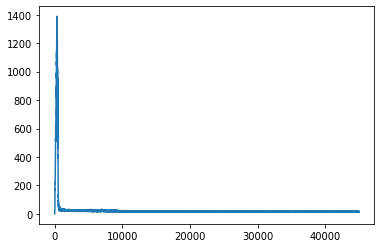

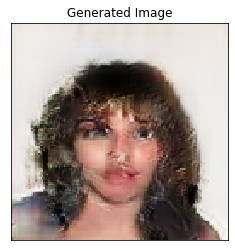

Iteration [45001/50000]......1.051(s) gen: 1011.8079 - disc_fake: -1004.9714 - disc_real: -989.3555 - neg_critic: 15.6159 - gp: 0.1737
Iteration [45002/50000]......1.032(s) gen: 1012.0260 - disc_fake: -1009.7526 - disc_real: -995.2602 - neg_critic: 14.4924 - gp: 0.2179
Iteration [45003/50000]......1.048(s) gen: 1012.8522 - disc_fake: -1012.4749 - disc_real: -997.7490 - neg_critic: 14.7259 - gp: 0.1502
Iteration [45004/50000]......1.036(s) gen: 1013.3381 - disc_fake: -1013.5856 - disc_real: -999.5390 - neg_critic: 14.0466 - gp: 0.1725
Iteration [45005/50000]......1.048(s) gen: 1011.9517 - disc_fake: -1010.7276 - disc_real: -996.7506 - neg_critic: 13.9770 - gp: 0.1371
Iteration [45006/50000]......1.033(s) gen: 1009.7139 - disc_fake: -1009.3151 - disc_real: -994.3299 - neg_critic: 14.9851 - gp: 0.1914
Iteration [45007/50000]......1.050(s) gen: 1010.3624 - disc_fake: -1009.3458 - disc_real: -994.4109 - neg_critic: 14.9349 - gp: 0.1722
Iteration [45008/50000]......1.032(s) gen: 1010.2279 - 

Iteration [45062/50000]......1.032(s) gen: 1012.4454 - disc_fake: -1011.1167 - disc_real: -996.0992 - neg_critic: 15.0175 - gp: 0.1778
Iteration [45063/50000]......1.050(s) gen: 1011.6527 - disc_fake: -1011.1695 - disc_real: -997.2670 - neg_critic: 13.9024 - gp: 0.1542
Iteration [45064/50000]......1.032(s) gen: 1008.5231 - disc_fake: -1007.6997 - disc_real: -991.1401 - neg_critic: 16.5596 - gp: 0.1843
Iteration [45065/50000]......1.049(s) gen: 1011.1010 - disc_fake: -1010.3030 - disc_real: -996.5612 - neg_critic: 13.7418 - gp: 0.1457
Iteration [45066/50000]......1.034(s) gen: 1011.5217 - disc_fake: -1010.9336 - disc_real: -997.2069 - neg_critic: 13.7267 - gp: 0.1331
Iteration [45067/50000]......1.050(s) gen: 1003.4674 - disc_fake: -1006.7106 - disc_real: -990.2386 - neg_critic: 16.4720 - gp: 0.1802
Iteration [45068/50000]......1.049(s) gen: 1007.8431 - disc_fake: -1007.8411 - disc_real: -993.0956 - neg_critic: 14.7455 - gp: 0.1934
Iteration [45069/50000]......1.034(s) gen: 1014.7465 - 

Iteration [45123/50000]......1.049(s) gen: 1013.8057 - disc_fake: -1014.0159 - disc_real: -1000.9346 - neg_critic: 13.0813 - gp: 0.1546
Iteration [45124/50000]......1.034(s) gen: 1012.5212 - disc_fake: -1011.9114 - disc_real: -998.7442 - neg_critic: 13.1672 - gp: 0.1559
Iteration [45125/50000]......1.049(s) gen: 1011.3496 - disc_fake: -1012.2343 - disc_real: -998.0211 - neg_critic: 14.2131 - gp: 0.1492
Iteration [45126/50000]......1.034(s) gen: 1013.0140 - disc_fake: -1006.4947 - disc_real: -990.4435 - neg_critic: 16.0512 - gp: 0.1594
Iteration [45127/50000]......1.049(s) gen: 1014.4167 - disc_fake: -1013.1604 - disc_real: -998.9547 - neg_critic: 14.2056 - gp: 0.1550
Iteration [45128/50000]......1.034(s) gen: 1014.9048 - disc_fake: -1014.8645 - disc_real: -1002.0781 - neg_critic: 12.7864 - gp: 0.1363
Iteration [45129/50000]......1.049(s) gen: 1013.3267 - disc_fake: -1013.3455 - disc_real: -997.5408 - neg_critic: 15.8046 - gp: 0.1698
Iteration [45130/50000]......1.034(s) gen: 1011.4191 

Iteration [45184/50000]......1.033(s) gen: 1011.8950 - disc_fake: -1014.9563 - disc_real: -1000.0629 - neg_critic: 14.8933 - gp: 0.2005
Iteration [45185/50000]......1.050(s) gen: 1005.3734 - disc_fake: -1009.4147 - disc_real: -994.4791 - neg_critic: 14.9356 - gp: 0.1129
Iteration [45186/50000]......1.033(s) gen: 1013.1812 - disc_fake: -1007.4416 - disc_real: -993.2395 - neg_critic: 14.2021 - gp: 0.2076
Iteration [45187/50000]......1.049(s) gen: 1012.6943 - disc_fake: -1012.2027 - disc_real: -998.9148 - neg_critic: 13.2879 - gp: 0.1282
Iteration [45188/50000]......1.034(s) gen: 1017.6865 - disc_fake: -1013.4738 - disc_real: -998.8638 - neg_critic: 14.6100 - gp: 0.1525
Iteration [45189/50000]......1.049(s) gen: 1019.5962 - disc_fake: -1016.6687 - disc_real: -1001.7380 - neg_critic: 14.9307 - gp: 0.1574
Iteration [45190/50000]......1.034(s) gen: 1014.7034 - disc_fake: -1015.8075 - disc_real: -1000.2827 - neg_critic: 15.5248 - gp: 0.1741
Iteration [45191/50000]......1.049(s) gen: 1009.9537

Iteration [45245/50000]......1.034(s) gen: 1012.4777 - disc_fake: -1015.4181 - disc_real: -1000.5874 - neg_critic: 14.8307 - gp: 0.1380
Iteration [45246/50000]......1.050(s) gen: 1016.7177 - disc_fake: -1015.1027 - disc_real: -1001.1106 - neg_critic: 13.9921 - gp: 0.1907
Iteration [45247/50000]......1.034(s) gen: 1016.4547 - disc_fake: -1014.0618 - disc_real: -1000.1902 - neg_critic: 13.8716 - gp: 0.1252
Iteration [45248/50000]......1.047(s) gen: 1021.8611 - disc_fake: -1017.6070 - disc_real: -1003.8458 - neg_critic: 13.7612 - gp: 0.1096
Iteration [45249/50000]......1.051(s) gen: 1019.8796 - disc_fake: -1019.0369 - disc_real: -1004.4310 - neg_critic: 14.6059 - gp: 0.2031
Iteration [45250/50000]......1.033(s) gen: 1016.7544 - disc_fake: -1017.0458 - disc_real: -1001.6244 - neg_critic: 15.4214 - gp: 0.1717
Iteration [45251/50000]......1.049(s) gen: 1020.3522 - disc_fake: -1016.4304 - disc_real: -1002.1735 - neg_critic: 14.2569 - gp: 0.1338
Iteration [45252/50000]......1.034(s) gen: 1015.

Iteration [45306/50000]......1.048(s) gen: 1015.2339 - disc_fake: -1012.1408 - disc_real: -995.7840 - neg_critic: 16.3568 - gp: 0.1898
Iteration [45307/50000]......1.035(s) gen: 1019.0898 - disc_fake: -1017.4292 - disc_real: -1001.6319 - neg_critic: 15.7974 - gp: 0.1367
Iteration [45308/50000]......1.048(s) gen: 1020.9702 - disc_fake: -1019.4099 - disc_real: -1003.5814 - neg_critic: 15.8284 - gp: 0.1850
Iteration [45309/50000]......1.034(s) gen: 1019.6902 - disc_fake: -1022.0842 - disc_real: -1007.4625 - neg_critic: 14.6217 - gp: 0.1722
Iteration [45310/50000]......1.048(s) gen: 1016.2987 - disc_fake: -1018.3637 - disc_real: -1004.3495 - neg_critic: 14.0142 - gp: 0.1667
Iteration [45311/50000]......1.034(s) gen: 1020.4657 - disc_fake: -1017.2912 - disc_real: -1002.6481 - neg_critic: 14.6431 - gp: 0.1359
Iteration [45312/50000]......1.049(s) gen: 1014.2048 - disc_fake: -1015.5306 - disc_real: -999.3609 - neg_critic: 16.1697 - gp: 0.2110
Iteration [45313/50000]......1.034(s) gen: 1018.44

Iteration [45367/50000]......1.036(s) gen: 1014.0178 - disc_fake: -1017.2558 - disc_real: -1003.4874 - neg_critic: 13.7684 - gp: 0.1436
Iteration [45368/50000]......1.047(s) gen: 1014.4120 - disc_fake: -1012.3934 - disc_real: -998.5592 - neg_critic: 13.8342 - gp: 0.1396
Iteration [45369/50000]......1.033(s) gen: 1016.8371 - disc_fake: -1014.9925 - disc_real: -1001.9353 - neg_critic: 13.0572 - gp: 0.1462
Iteration [45370/50000]......1.049(s) gen: 1016.2897 - disc_fake: -1015.3487 - disc_real: -999.3017 - neg_critic: 16.0470 - gp: 0.1676
Iteration [45371/50000]......1.034(s) gen: 1014.8815 - disc_fake: -1016.5474 - disc_real: -1000.5443 - neg_critic: 16.0031 - gp: 0.1588
Iteration [45372/50000]......1.049(s) gen: 1015.7685 - disc_fake: -1015.7123 - disc_real: -1000.5562 - neg_critic: 15.1561 - gp: 0.1730
Iteration [45373/50000]......1.049(s) gen: 1018.3224 - disc_fake: -1016.6192 - disc_real: -1002.5478 - neg_critic: 14.0713 - gp: 0.1468
Iteration [45374/50000]......1.035(s) gen: 1018.27

Iteration [45428/50000]......1.033(s) gen: 1017.9315 - disc_fake: -1012.4679 - disc_real: -997.9488 - neg_critic: 14.5191 - gp: 0.1911
Iteration [45429/50000]......1.050(s) gen: 1021.8093 - disc_fake: -1020.6563 - disc_real: -1005.8999 - neg_critic: 14.7564 - gp: 0.1132
Iteration [45430/50000]......1.033(s) gen: 1022.1897 - disc_fake: -1019.3017 - disc_real: -1003.6689 - neg_critic: 15.6328 - gp: 0.1997
Iteration [45431/50000]......1.049(s) gen: 1011.6930 - disc_fake: -1017.8537 - disc_real: -1001.6686 - neg_critic: 16.1851 - gp: 0.1463
Iteration [45432/50000]......1.050(s) gen: 1018.9730 - disc_fake: -1015.9163 - disc_real: -1001.2137 - neg_critic: 14.7026 - gp: 0.1629
Iteration [45433/50000]......1.034(s) gen: 1017.2964 - disc_fake: -1019.5561 - disc_real: -1002.8483 - neg_critic: 16.7078 - gp: 0.1805
Iteration [45434/50000]......1.033(s) gen: 1018.3915 - disc_fake: -1020.3589 - disc_real: -1005.5376 - neg_critic: 14.8213 - gp: 0.1476
Iteration [45435/50000]......1.034(s) gen: 1018.5

Iteration [45489/50000]......1.047(s) gen: 1022.4528 - disc_fake: -1022.6546 - disc_real: -1009.0870 - neg_critic: 13.5676 - gp: 0.1268
Iteration [45490/50000]......1.046(s) gen: 1022.1080 - disc_fake: -1023.4653 - disc_real: -1007.4007 - neg_critic: 16.0646 - gp: 0.1830
Iteration [45491/50000]......1.037(s) gen: 1025.7134 - disc_fake: -1021.1656 - disc_real: -1007.9572 - neg_critic: 13.2084 - gp: 0.1520
Iteration [45492/50000]......1.050(s) gen: 1018.2435 - disc_fake: -1021.8455 - disc_real: -1007.2037 - neg_critic: 14.6418 - gp: 0.1350
Iteration [45493/50000]......1.049(s) gen: 1015.1316 - disc_fake: -1017.3888 - disc_real: -1001.0646 - neg_critic: 16.3242 - gp: 0.1559
Iteration [45494/50000]......1.033(s) gen: 1020.7348 - disc_fake: -1016.4572 - disc_real: -1001.2570 - neg_critic: 15.2002 - gp: 0.1770
Iteration [45495/50000]......1.049(s) gen: 1017.5854 - disc_fake: -1018.8763 - disc_real: -1002.5570 - neg_critic: 16.3194 - gp: 0.1750
Iteration [45496/50000]......1.034(s) gen: 1023.

Iteration [45550/50000]......1.034(s) gen: 1018.7893 - disc_fake: -1015.7198 - disc_real: -999.7170 - neg_critic: 16.0029 - gp: 0.2110
Iteration [45551/50000]......1.049(s) gen: 1017.9485 - disc_fake: -1018.5866 - disc_real: -1004.3578 - neg_critic: 14.2288 - gp: 0.1446
Iteration [45552/50000]......1.050(s) gen: 1023.0286 - disc_fake: -1019.9903 - disc_real: -1005.5827 - neg_critic: 14.4076 - gp: 0.1378
Iteration [45553/50000]......1.034(s) gen: 1020.5580 - disc_fake: -1020.5603 - disc_real: -1006.4172 - neg_critic: 14.1432 - gp: 0.1514
Iteration [45554/50000]......1.049(s) gen: 1021.4454 - disc_fake: -1020.7085 - disc_real: -1006.4042 - neg_critic: 14.3043 - gp: 0.1729
Iteration [45555/50000]......1.034(s) gen: 1023.4195 - disc_fake: -1019.3951 - disc_real: -1004.8113 - neg_critic: 14.5837 - gp: 0.1374
Iteration [45556/50000]......1.049(s) gen: 1019.2688 - disc_fake: -1021.2194 - disc_real: -1004.9346 - neg_critic: 16.2848 - gp: 0.1686
Iteration [45557/50000]......1.034(s) gen: 1020.8

Iteration [45611/50000]......1.049(s) gen: 1021.7729 - disc_fake: -1022.0084 - disc_real: -1006.7543 - neg_critic: 15.2541 - gp: 0.1502
Iteration [45612/50000]......1.034(s) gen: 1018.3206 - disc_fake: -1021.8642 - disc_real: -1006.7625 - neg_critic: 15.1017 - gp: 0.1672
Iteration [45613/50000]......1.049(s) gen: 1021.2616 - disc_fake: -1017.0538 - disc_real: -1001.6930 - neg_critic: 15.3608 - gp: 0.2171
Iteration [45614/50000]......1.034(s) gen: 1021.7383 - disc_fake: -1020.8535 - disc_real: -1007.8010 - neg_critic: 13.0525 - gp: 0.1349
Iteration [45615/50000]......1.049(s) gen: 1023.5183 - disc_fake: -1022.1864 - disc_real: -1009.0856 - neg_critic: 13.1007 - gp: 0.1070
Iteration [45616/50000]......1.034(s) gen: 1022.7223 - disc_fake: -1023.3507 - disc_real: -1008.1080 - neg_critic: 15.2427 - gp: 0.1709
Iteration [45617/50000]......1.049(s) gen: 1020.6777 - disc_fake: -1020.4127 - disc_real: -1005.9822 - neg_critic: 14.4305 - gp: 0.1443
Iteration [45618/50000]......1.034(s) gen: 1020.

Iteration [45672/50000]......1.049(s) gen: 1019.4302 - disc_fake: -1020.5937 - disc_real: -1004.2701 - neg_critic: 16.3236 - gp: 0.1981
Iteration [45673/50000]......1.035(s) gen: 1023.7900 - disc_fake: -1021.1382 - disc_real: -1007.0709 - neg_critic: 14.0673 - gp: 0.1697
Iteration [45674/50000]......1.050(s) gen: 1022.8479 - disc_fake: -1020.9024 - disc_real: -1005.4420 - neg_critic: 15.4604 - gp: 0.1616
Iteration [45675/50000]......1.048(s) gen: 1024.1754 - disc_fake: -1022.4258 - disc_real: -1007.9018 - neg_critic: 14.5241 - gp: 0.1492
Iteration [45676/50000]......1.034(s) gen: 1023.8754 - disc_fake: -1024.4920 - disc_real: -1009.9934 - neg_critic: 14.4986 - gp: 0.1379
Iteration [45677/50000]......1.049(s) gen: 1027.2321 - disc_fake: -1023.8018 - disc_real: -1009.3913 - neg_critic: 14.4106 - gp: 0.1587
Iteration [45678/50000]......1.034(s) gen: 1021.0278 - disc_fake: -1026.2021 - disc_real: -1012.3133 - neg_critic: 13.8888 - gp: 0.1239
Iteration [45679/50000]......1.049(s) gen: 1021.

Iteration [45733/50000]......1.050(s) gen: 1017.5781 - disc_fake: -1018.5575 - disc_real: -1001.3343 - neg_critic: 17.2232 - gp: 0.1537
Iteration [45734/50000]......1.035(s) gen: 1024.2163 - disc_fake: -1023.5007 - disc_real: -1008.5508 - neg_critic: 14.9498 - gp: 0.1867
Iteration [45735/50000]......1.048(s) gen: 1027.9102 - disc_fake: -1026.0724 - disc_real: -1010.1684 - neg_critic: 15.9040 - gp: 0.2055
Iteration [45736/50000]......1.035(s) gen: 1021.8140 - disc_fake: -1022.6966 - disc_real: -1009.1475 - neg_critic: 13.5491 - gp: 0.1654
Iteration [45737/50000]......1.047(s) gen: 1019.7593 - disc_fake: -1019.2469 - disc_real: -1006.5403 - neg_critic: 12.7066 - gp: 0.1524
Iteration [45738/50000]......1.051(s) gen: 1016.0671 - disc_fake: -1018.4477 - disc_real: -1004.5959 - neg_critic: 13.8519 - gp: 0.1245
Iteration [45739/50000]......1.035(s) gen: 1018.5537 - disc_fake: -1016.0894 - disc_real: -1000.2058 - neg_critic: 15.8835 - gp: 0.1843
Iteration [45740/50000]......1.048(s) gen: 1022.

Iteration [45794/50000]......1.050(s) gen: 1022.6821 - disc_fake: -1023.1484 - disc_real: -1009.0527 - neg_critic: 14.0957 - gp: 0.1524
Iteration [45795/50000]......1.036(s) gen: 1019.2489 - disc_fake: -1020.9052 - disc_real: -1005.6324 - neg_critic: 15.2728 - gp: 0.1512
Iteration [45796/50000]......1.032(s) gen: 1018.8011 - disc_fake: -1018.9197 - disc_real: -1003.0034 - neg_critic: 15.9163 - gp: 0.1874
Iteration [45797/50000]......1.048(s) gen: 1016.5939 - disc_fake: -1019.9970 - disc_real: -1005.1628 - neg_critic: 14.8342 - gp: 0.1680
Iteration [45798/50000]......1.050(s) gen: 1018.7529 - disc_fake: -1019.3792 - disc_real: -1004.2706 - neg_critic: 15.1086 - gp: 0.2029
Iteration [45799/50000]......1.034(s) gen: 1021.5881 - disc_fake: -1020.7586 - disc_real: -1007.0568 - neg_critic: 13.7018 - gp: 0.1511
Iteration [45800/50000]......1.033(s) gen: 1023.8784 - disc_fake: -1022.4854 - disc_real: -1005.9796 - neg_critic: 16.5058 - gp: 0.1704
Iteration [45801/50000]......1.049(s) gen: 1020.

Iteration [45855/50000]......1.034(s) gen: 1020.7910 - disc_fake: -1017.5432 - disc_real: -1002.9161 - neg_critic: 14.6271 - gp: 0.1682
Iteration [45856/50000]......1.050(s) gen: 1022.8923 - disc_fake: -1019.5066 - disc_real: -1005.3368 - neg_critic: 14.1698 - gp: 0.1447
Iteration [45857/50000]......1.033(s) gen: 1024.5791 - disc_fake: -1021.9029 - disc_real: -1004.5458 - neg_critic: 17.3572 - gp: 0.2536
Iteration [45858/50000]......1.049(s) gen: 1024.4077 - disc_fake: -1022.6748 - disc_real: -1008.0210 - neg_critic: 14.6538 - gp: 0.1371
Iteration [45859/50000]......1.035(s) gen: 1019.7970 - disc_fake: -1021.1312 - disc_real: -1006.5821 - neg_critic: 14.5490 - gp: 0.1639
Iteration [45860/50000]......1.048(s) gen: 1021.4840 - disc_fake: -1019.2049 - disc_real: -1004.6824 - neg_critic: 14.5225 - gp: 0.1632
Iteration [45861/50000]......1.050(s) gen: 1019.4833 - disc_fake: -1021.5690 - disc_real: -1005.4010 - neg_critic: 16.1680 - gp: 0.1718
Iteration [45862/50000]......1.034(s) gen: 1020.

Iteration [45916/50000]......1.033(s) gen: 1023.2787 - disc_fake: -1022.6979 - disc_real: -1006.8829 - neg_critic: 15.8150 - gp: 0.1626
Iteration [45917/50000]......1.049(s) gen: 1022.4686 - disc_fake: -1022.0953 - disc_real: -1006.8536 - neg_critic: 15.2418 - gp: 0.2248
Iteration [45918/50000]......1.033(s) gen: 1027.9363 - disc_fake: -1022.6448 - disc_real: -1008.8709 - neg_critic: 13.7738 - gp: 0.1511
Iteration [45919/50000]......1.049(s) gen: 1030.2251 - disc_fake: -1025.9689 - disc_real: -1009.4237 - neg_critic: 16.5452 - gp: 0.1698
Iteration [45920/50000]......1.034(s) gen: 1024.4292 - disc_fake: -1025.0646 - disc_real: -1011.4022 - neg_critic: 13.6624 - gp: 0.1443
Iteration [45921/50000]......1.049(s) gen: 1026.0247 - disc_fake: -1024.5316 - disc_real: -1010.2468 - neg_critic: 14.2848 - gp: 0.1553
Iteration [45922/50000]......1.050(s) gen: 1022.5443 - disc_fake: -1025.9789 - disc_real: -1010.9061 - neg_critic: 15.0727 - gp: 0.1383
Iteration [45923/50000]......1.034(s) gen: 1023.

Iteration [45977/50000]......1.033(s) gen: 1030.4098 - disc_fake: -1027.3786 - disc_real: -1013.6732 - neg_critic: 13.7054 - gp: 0.1496
Iteration [45978/50000]......1.050(s) gen: 1025.9341 - disc_fake: -1026.6037 - disc_real: -1013.3490 - neg_critic: 13.2547 - gp: 0.1437
Iteration [45979/50000]......1.049(s) gen: 1022.7199 - disc_fake: -1025.1036 - disc_real: -1010.5831 - neg_critic: 14.5205 - gp: 0.1606
Iteration [45980/50000]......1.034(s) gen: 1022.5310 - disc_fake: -1022.6152 - disc_real: -1007.1177 - neg_critic: 15.4975 - gp: 0.1531
Iteration [45981/50000]......1.033(s) gen: 1021.9252 - disc_fake: -1023.9830 - disc_real: -1008.3210 - neg_critic: 15.6620 - gp: 0.1736
Iteration [45982/50000]......1.049(s) gen: 1023.6228 - disc_fake: -1024.7418 - disc_real: -1009.8589 - neg_critic: 14.8830 - gp: 0.1606
Iteration [45983/50000]......1.033(s) gen: 1024.8350 - disc_fake: -1024.2443 - disc_real: -1010.0992 - neg_critic: 14.1452 - gp: 0.1819
Iteration [45984/50000]......1.049(s) gen: 1023.

Iteration [46038/50000]......1.049(s) gen: 1026.1084 - disc_fake: -1021.6948 - disc_real: -1006.2430 - neg_critic: 15.4518 - gp: 0.2134
Iteration [46039/50000]......1.035(s) gen: 1020.8315 - disc_fake: -1022.8145 - disc_real: -1005.9276 - neg_critic: 16.8868 - gp: 0.1715
Iteration [46040/50000]......1.050(s) gen: 1026.3693 - disc_fake: -1021.4429 - disc_real: -1008.2153 - neg_critic: 13.2276 - gp: 0.1641
Iteration [46041/50000]......1.048(s) gen: 1024.8867 - disc_fake: -1025.9228 - disc_real: -1009.7228 - neg_critic: 16.2000 - gp: 0.1588
Iteration [46042/50000]......1.034(s) gen: 1026.6230 - disc_fake: -1024.4392 - disc_real: -1010.7225 - neg_critic: 13.7167 - gp: 0.1719
Iteration [46043/50000]......1.049(s) gen: 1025.3944 - disc_fake: -1025.0451 - disc_real: -1009.8440 - neg_critic: 15.2011 - gp: 0.1392
Iteration [46044/50000]......1.034(s) gen: 1020.1465 - disc_fake: -1023.8673 - disc_real: -1008.1673 - neg_critic: 15.7000 - gp: 0.1715
Iteration [46045/50000]......1.049(s) gen: 1033.

Iteration [46099/50000]......1.034(s) gen: 1021.1520 - disc_fake: -1020.0471 - disc_real: -1004.6176 - neg_critic: 15.4296 - gp: 0.1821
Iteration [46100/50000]......1.049(s) gen: 1023.5391 - disc_fake: -1022.0710 - disc_real: -1007.0154 - neg_critic: 15.0556 - gp: 0.1418
Iteration [46101/50000]......1.033(s) gen: 1023.9351 - disc_fake: -1022.0295 - disc_real: -1003.6807 - neg_critic: 18.3488 - gp: 0.2507
Iteration [46102/50000]......1.049(s) gen: 1027.7355 - disc_fake: -1025.0242 - disc_real: -1010.8693 - neg_critic: 14.1549 - gp: 0.1318
Iteration [46103/50000]......1.034(s) gen: 1022.7385 - disc_fake: -1025.2334 - disc_real: -1009.7445 - neg_critic: 15.4889 - gp: 0.2079
Iteration [46104/50000]......1.049(s) gen: 1028.4043 - disc_fake: -1024.9888 - disc_real: -1011.5591 - neg_critic: 13.4297 - gp: 0.1097
Iteration [46105/50000]......1.034(s) gen: 1026.7102 - disc_fake: -1026.7541 - disc_real: -1011.6522 - neg_critic: 15.1019 - gp: 0.1575
Iteration [46106/50000]......1.049(s) gen: 1025.

Iteration [46160/50000]......1.048(s) gen: 1020.5480 - disc_fake: -1022.6988 - disc_real: -1005.8616 - neg_critic: 16.8372 - gp: 0.1536
Iteration [46161/50000]......1.035(s) gen: 1024.3796 - disc_fake: -1020.7035 - disc_real: -1004.6975 - neg_critic: 16.0060 - gp: 0.1855
Iteration [46162/50000]......1.048(s) gen: 1028.9248 - disc_fake: -1027.8973 - disc_real: -1012.4572 - neg_critic: 15.4401 - gp: 0.1656
Iteration [46163/50000]......1.033(s) gen: 1021.4954 - disc_fake: -1024.3708 - disc_real: -1008.6033 - neg_critic: 15.7675 - gp: 0.2025
Iteration [46164/50000]......1.049(s) gen: 1028.3157 - disc_fake: -1023.2172 - disc_real: -1009.4538 - neg_critic: 13.7634 - gp: 0.1364
Iteration [46165/50000]......1.034(s) gen: 1024.4148 - disc_fake: -1025.1763 - disc_real: -1011.5801 - neg_critic: 13.5962 - gp: 0.1795
Iteration [46166/50000]......1.049(s) gen: 1023.2570 - disc_fake: -1023.6439 - disc_real: -1008.7252 - neg_critic: 14.9187 - gp: 0.1766
Iteration [46167/50000]......1.034(s) gen: 1023.

Iteration [46221/50000]......1.033(s) gen: 1023.7809 - disc_fake: -1025.3315 - disc_real: -1011.4955 - neg_critic: 13.8361 - gp: 0.1598
Iteration [46222/50000]......1.049(s) gen: 1027.3535 - disc_fake: -1024.0826 - disc_real: -1010.1476 - neg_critic: 13.9350 - gp: 0.1618
Iteration [46223/50000]......1.037(s) gen: 1029.6257 - disc_fake: -1028.2122 - disc_real: -1012.1302 - neg_critic: 16.0821 - gp: 0.1657
Iteration [46224/50000]......1.047(s) gen: 1032.4934 - disc_fake: -1030.5550 - disc_real: -1015.7761 - neg_critic: 14.7790 - gp: 0.1574
Iteration [46225/50000]......1.049(s) gen: 1027.3369 - disc_fake: -1029.5507 - disc_real: -1013.2185 - neg_critic: 16.3323 - gp: 0.1542
Iteration [46226/50000]......1.034(s) gen: 1025.1609 - disc_fake: -1025.9997 - disc_real: -1010.0973 - neg_critic: 15.9024 - gp: 0.1910
Iteration [46227/50000]......1.049(s) gen: 1025.2667 - disc_fake: -1026.1076 - disc_real: -1010.9433 - neg_critic: 15.1643 - gp: 0.1916
Iteration [46228/50000]......1.034(s) gen: 1026.

Iteration [46282/50000]......1.033(s) gen: 1029.8771 - disc_fake: -1028.9332 - disc_real: -1014.7562 - neg_critic: 14.1770 - gp: 0.1361
Iteration [46283/50000]......1.035(s) gen: 1029.3733 - disc_fake: -1031.3462 - disc_real: -1016.3807 - neg_critic: 14.9655 - gp: 0.2115
Iteration [46284/50000]......1.048(s) gen: 1025.2629 - disc_fake: -1031.5953 - disc_real: -1015.3869 - neg_critic: 16.2084 - gp: 0.1471
Iteration [46285/50000]......1.050(s) gen: 1027.6263 - disc_fake: -1028.1717 - disc_real: -1012.8599 - neg_critic: 15.3117 - gp: 0.1739
Iteration [46286/50000]......1.033(s) gen: 1028.9020 - disc_fake: -1028.8016 - disc_real: -1014.4907 - neg_critic: 14.3109 - gp: 0.1599
Iteration [46287/50000]......1.049(s) gen: 1030.7336 - disc_fake: -1030.2276 - disc_real: -1015.1308 - neg_critic: 15.0969 - gp: 0.1360
Iteration [46288/50000]......1.034(s) gen: 1032.3307 - disc_fake: -1032.2285 - disc_real: -1016.7963 - neg_critic: 15.4322 - gp: 0.1882
Iteration [46289/50000]......1.049(s) gen: 1031.

Iteration [46343/50000]......1.049(s) gen: 1026.7092 - disc_fake: -1027.1537 - disc_real: -1013.6780 - neg_critic: 13.4757 - gp: 0.1292
Iteration [46344/50000]......1.035(s) gen: 1032.9374 - disc_fake: -1029.6081 - disc_real: -1014.6851 - neg_critic: 14.9231 - gp: 0.1741
Iteration [46345/50000]......1.048(s) gen: 1028.6130 - disc_fake: -1030.1355 - disc_real: -1014.9559 - neg_critic: 15.1796 - gp: 0.1429
Iteration [46346/50000]......1.034(s) gen: 1030.1504 - disc_fake: -1030.9715 - disc_real: -1015.9060 - neg_critic: 15.0655 - gp: 0.1787
Iteration [46347/50000]......1.049(s) gen: 1032.9050 - disc_fake: -1032.0396 - disc_real: -1018.1862 - neg_critic: 13.8535 - gp: 0.1472
Iteration [46348/50000]......1.034(s) gen: 1028.9055 - disc_fake: -1031.2939 - disc_real: -1015.4157 - neg_critic: 15.8782 - gp: 0.1707
Iteration [46349/50000]......1.049(s) gen: 1031.9153 - disc_fake: -1029.8848 - disc_real: -1013.3769 - neg_critic: 16.5079 - gp: 0.1725
Iteration [46350/50000]......1.034(s) gen: 1029.

Iteration [46404/50000]......1.034(s) gen: 1028.5381 - disc_fake: -1029.8054 - disc_real: -1014.3277 - neg_critic: 15.4777 - gp: 0.1660
Iteration [46405/50000]......1.050(s) gen: 1026.5624 - disc_fake: -1025.6956 - disc_real: -1008.4489 - neg_critic: 17.2466 - gp: 0.2273
Iteration [46406/50000]......1.035(s) gen: 1029.6082 - disc_fake: -1028.6339 - disc_real: -1014.8753 - neg_critic: 13.7586 - gp: 0.1415
Iteration [46407/50000]......1.055(s) gen: 1031.8438 - disc_fake: -1029.9609 - disc_real: -1015.4016 - neg_critic: 14.5593 - gp: 0.1558
Iteration [46408/50000]......1.029(s) gen: 1031.3136 - disc_fake: -1029.9799 - disc_real: -1017.2057 - neg_critic: 12.7742 - gp: 0.1573
Iteration [46409/50000]......1.055(s) gen: 1031.5532 - disc_fake: -1032.5418 - disc_real: -1017.5643 - neg_critic: 14.9775 - gp: 0.1739
Iteration [46410/50000]......1.043(s) gen: 1029.4832 - disc_fake: -1029.2686 - disc_real: -1014.6882 - neg_critic: 14.5804 - gp: 0.1214
Iteration [46411/50000]......1.049(s) gen: 1030.

Iteration [46465/50000]......1.033(s) gen: 1032.6122 - disc_fake: -1031.6165 - disc_real: -1016.9249 - neg_critic: 14.6916 - gp: 0.1468
Iteration [46466/50000]......1.049(s) gen: 1034.8212 - disc_fake: -1033.7058 - disc_real: -1018.4932 - neg_critic: 15.2126 - gp: 0.1437
Iteration [46467/50000]......1.034(s) gen: 1035.1597 - disc_fake: -1036.1245 - disc_real: -1021.1745 - neg_critic: 14.9500 - gp: 0.1504
Iteration [46468/50000]......1.049(s) gen: 1030.8179 - disc_fake: -1033.6936 - disc_real: -1016.5774 - neg_critic: 17.1162 - gp: 0.2103
Iteration [46469/50000]......1.034(s) gen: 1019.5555 - disc_fake: -1032.3800 - disc_real: -1009.7165 - neg_critic: 22.6635 - gp: 0.2168
Iteration [46470/50000]......1.049(s) gen: 1038.6038 - disc_fake: -1031.4975 - disc_real: -1016.7317 - neg_critic: 14.7658 - gp: 0.1618
Iteration [46471/50000]......1.034(s) gen: 1037.7847 - disc_fake: -1040.8101 - disc_real: -1026.5275 - neg_critic: 14.2825 - gp: 0.1702
Iteration [46472/50000]......1.049(s) gen: 1038.

Iteration [46526/50000]......1.044(s) gen: 1031.9081 - disc_fake: -1029.7750 - disc_real: -1014.8474 - neg_critic: 14.9275 - gp: 0.1677
Iteration [46527/50000]......1.038(s) gen: 1032.7103 - disc_fake: -1032.9095 - disc_real: -1017.0460 - neg_critic: 15.8635 - gp: 0.2149
Iteration [46528/50000]......1.049(s) gen: 1033.5178 - disc_fake: -1032.0894 - disc_real: -1019.6820 - neg_critic: 12.4075 - gp: 0.1306
Iteration [46529/50000]......1.034(s) gen: 1026.9573 - disc_fake: -1032.5963 - disc_real: -1018.0926 - neg_critic: 14.5037 - gp: 0.1657
Iteration [46530/50000]......1.049(s) gen: 1031.9696 - disc_fake: -1030.3151 - disc_real: -1015.3705 - neg_critic: 14.9445 - gp: 0.1337
Iteration [46531/50000]......1.034(s) gen: 1030.3188 - disc_fake: -1030.2753 - disc_real: -1015.0032 - neg_critic: 15.2721 - gp: 0.1616
Iteration [46532/50000]......1.049(s) gen: 1031.3170 - disc_fake: -1029.4513 - disc_real: -1012.7613 - neg_critic: 16.6900 - gp: 0.2172
Iteration [46533/50000]......1.034(s) gen: 1030.

Iteration [46587/50000]......1.049(s) gen: 1029.2164 - disc_fake: -1028.8966 - disc_real: -1015.5269 - neg_critic: 13.3697 - gp: 0.1359
Iteration [46588/50000]......1.034(s) gen: 1033.9253 - disc_fake: -1031.6935 - disc_real: -1018.8555 - neg_critic: 12.8380 - gp: 0.1568
Iteration [46589/50000]......1.048(s) gen: 1035.0389 - disc_fake: -1032.7751 - disc_real: -1017.9838 - neg_critic: 14.7913 - gp: 0.1345
Iteration [46590/50000]......1.036(s) gen: 1034.4238 - disc_fake: -1031.2533 - disc_real: -1016.9818 - neg_critic: 14.2714 - gp: 0.1778
Iteration [46591/50000]......1.048(s) gen: 1028.3607 - disc_fake: -1030.3933 - disc_real: -1015.6370 - neg_critic: 14.7563 - gp: 0.1602
Iteration [46592/50000]......1.034(s) gen: 1029.4492 - disc_fake: -1029.0132 - disc_real: -1013.8816 - neg_critic: 15.1317 - gp: 0.1679
Iteration [46593/50000]......1.048(s) gen: 1028.7158 - disc_fake: -1029.8482 - disc_real: -1015.1895 - neg_critic: 14.6588 - gp: 0.1530
Iteration [46594/50000]......1.050(s) gen: 1029.

Iteration [46648/50000]......1.049(s) gen: 1034.1309 - disc_fake: -1033.6608 - disc_real: -1018.7414 - neg_critic: 14.9194 - gp: 0.1594
Iteration [46649/50000]......1.034(s) gen: 1034.3167 - disc_fake: -1031.1512 - disc_real: -1018.0166 - neg_critic: 13.1346 - gp: 0.1285
Iteration [46650/50000]......1.048(s) gen: 1037.6543 - disc_fake: -1036.9593 - disc_real: -1021.9834 - neg_critic: 14.9759 - gp: 0.2007
Iteration [46651/50000]......1.034(s) gen: 1037.3943 - disc_fake: -1036.1512 - disc_real: -1022.6872 - neg_critic: 13.4640 - gp: 0.1285
Iteration [46652/50000]......1.050(s) gen: 1034.8899 - disc_fake: -1037.3569 - disc_real: -1022.8357 - neg_critic: 14.5212 - gp: 0.1518
Iteration [46653/50000]......1.033(s) gen: 1036.0107 - disc_fake: -1035.5239 - disc_real: -1020.3141 - neg_critic: 15.2098 - gp: 0.1761
Iteration [46654/50000]......1.049(s) gen: 1034.0732 - disc_fake: -1036.6935 - disc_real: -1021.4694 - neg_critic: 15.2241 - gp: 0.2065
Iteration [46655/50000]......1.034(s) gen: 1035.

Iteration [46709/50000]......1.034(s) gen: 1032.4602 - disc_fake: -1033.7632 - disc_real: -1018.9272 - neg_critic: 14.8359 - gp: 0.1661
Iteration [46710/50000]......1.050(s) gen: 1032.1478 - disc_fake: -1032.6025 - disc_real: -1019.2015 - neg_critic: 13.4010 - gp: 0.1375
Iteration [46711/50000]......1.033(s) gen: 1029.4299 - disc_fake: -1031.3003 - disc_real: -1013.6125 - neg_critic: 17.6879 - gp: 0.1709
Iteration [46712/50000]......1.048(s) gen: 1032.7700 - disc_fake: -1029.9480 - disc_real: -1013.5274 - neg_critic: 16.4206 - gp: 0.2420
Iteration [46713/50000]......1.034(s) gen: 1037.8960 - disc_fake: -1034.2760 - disc_real: -1021.2686 - neg_critic: 13.0074 - gp: 0.1500
Iteration [46714/50000]......1.049(s) gen: 1036.2465 - disc_fake: -1033.7418 - disc_real: -1019.6254 - neg_critic: 14.1164 - gp: 0.1388
Iteration [46715/50000]......1.034(s) gen: 1032.5253 - disc_fake: -1034.1300 - disc_real: -1020.4518 - neg_critic: 13.6782 - gp: 0.1767
Iteration [46716/50000]......1.049(s) gen: 1030.

Iteration [46770/50000]......1.050(s) gen: 1038.9578 - disc_fake: -1040.4591 - disc_real: -1027.4736 - neg_critic: 12.9856 - gp: 0.1580
Iteration [46771/50000]......1.036(s) gen: 1033.9814 - disc_fake: -1036.6819 - disc_real: -1021.9543 - neg_critic: 14.7276 - gp: 0.1328
Iteration [46772/50000]......1.047(s) gen: 1032.8289 - disc_fake: -1032.6365 - disc_real: -1017.3856 - neg_critic: 15.2509 - gp: 0.1597
Iteration [46773/50000]......1.033(s) gen: 1038.2656 - disc_fake: -1034.1541 - disc_real: -1019.1066 - neg_critic: 15.0475 - gp: 0.1512
Iteration [46774/50000]......1.050(s) gen: 1039.4861 - disc_fake: -1039.7396 - disc_real: -1024.1450 - neg_critic: 15.5945 - gp: 0.1501
Iteration [46775/50000]......1.033(s) gen: 1036.8840 - disc_fake: -1036.9164 - disc_real: -1025.1954 - neg_critic: 11.7210 - gp: 0.1452
Iteration [46776/50000]......1.049(s) gen: 1037.3710 - disc_fake: -1036.5689 - disc_real: -1023.6183 - neg_critic: 12.9507 - gp: 0.1661
Iteration [46777/50000]......1.050(s) gen: 1033.

Iteration [46831/50000]......1.034(s) gen: 1039.7241 - disc_fake: -1039.7608 - disc_real: -1025.2634 - neg_critic: 14.4974 - gp: 0.1435
Iteration [46832/50000]......1.049(s) gen: 1035.2689 - disc_fake: -1036.5243 - disc_real: -1019.7792 - neg_critic: 16.7451 - gp: 0.1477
Iteration [46833/50000]......1.035(s) gen: 1035.3757 - disc_fake: -1034.4562 - disc_real: -1019.4357 - neg_critic: 15.0204 - gp: 0.2149
Iteration [46834/50000]......1.047(s) gen: 1035.3474 - disc_fake: -1034.9952 - disc_real: -1017.8258 - neg_critic: 17.1693 - gp: 0.1923
Iteration [46835/50000]......1.033(s) gen: 1040.4773 - disc_fake: -1036.6422 - disc_real: -1023.3665 - neg_critic: 13.2758 - gp: 0.1494
Iteration [46836/50000]......1.049(s) gen: 1040.8237 - disc_fake: -1038.5237 - disc_real: -1021.9923 - neg_critic: 16.5314 - gp: 0.1940
Iteration [46837/50000]......1.034(s) gen: 1042.4453 - disc_fake: -1042.4867 - disc_real: -1029.3093 - neg_critic: 13.1774 - gp: 0.1451
Iteration [46838/50000]......1.049(s) gen: 1038.

Iteration [46892/50000]......1.035(s) gen: 1039.9659 - disc_fake: -1039.0198 - disc_real: -1025.8575 - neg_critic: 13.1623 - gp: 0.1351
Iteration [46893/50000]......1.048(s) gen: 1041.6949 - disc_fake: -1039.0932 - disc_real: -1024.0714 - neg_critic: 15.0218 - gp: 0.1618
Iteration [46894/50000]......1.034(s) gen: 1035.7037 - disc_fake: -1037.7310 - disc_real: -1022.9310 - neg_critic: 14.8000 - gp: 0.1851
Iteration [46895/50000]......1.049(s) gen: 1041.7964 - disc_fake: -1035.8971 - disc_real: -1021.6450 - neg_critic: 14.2521 - gp: 0.1343
Iteration [46896/50000]......1.034(s) gen: 1037.1919 - disc_fake: -1038.7026 - disc_real: -1025.4289 - neg_critic: 13.2737 - gp: 0.1419
Iteration [46897/50000]......1.049(s) gen: 1038.4480 - disc_fake: -1035.6177 - disc_real: -1019.6021 - neg_critic: 16.0156 - gp: 0.1452
Iteration [46898/50000]......1.049(s) gen: 1045.6390 - disc_fake: -1041.6065 - disc_real: -1027.6159 - neg_critic: 13.9907 - gp: 0.2112
Iteration [46899/50000]......1.034(s) gen: 1041.

Iteration [46953/50000]......1.033(s) gen: 1041.4211 - disc_fake: -1040.4510 - disc_real: -1025.6359 - neg_critic: 14.8152 - gp: 0.1660
Iteration [46954/50000]......1.050(s) gen: 1044.8096 - disc_fake: -1039.7149 - disc_real: -1025.7049 - neg_critic: 14.0100 - gp: 0.1420
Iteration [46955/50000]......1.033(s) gen: 1042.7454 - disc_fake: -1040.6627 - disc_real: -1025.4405 - neg_critic: 15.2223 - gp: 0.1643
Iteration [46956/50000]......1.049(s) gen: 1042.8679 - disc_fake: -1041.4718 - disc_real: -1027.5207 - neg_critic: 13.9511 - gp: 0.1495
Iteration [46957/50000]......1.050(s) gen: 1042.8081 - disc_fake: -1040.3223 - disc_real: -1025.3182 - neg_critic: 15.0041 - gp: 0.1492
Iteration [46958/50000]......1.052(s) gen: 1043.0593 - disc_fake: -1038.9791 - disc_real: -1022.5143 - neg_critic: 16.4648 - gp: 0.1773
Iteration [46959/50000]......1.033(s) gen: 1040.7599 - disc_fake: -1039.8032 - disc_real: -1025.1134 - neg_critic: 14.6897 - gp: 0.1456
Iteration [46960/50000]......1.048(s) gen: 1042.

Iteration [47014/50000]......1.048(s) gen: 1039.6316 - disc_fake: -1041.3077 - disc_real: -1024.9378 - neg_critic: 16.3699 - gp: 0.2297
Iteration [47015/50000]......1.035(s) gen: 1039.9022 - disc_fake: -1038.3718 - disc_real: -1024.1529 - neg_critic: 14.2189 - gp: 0.1413
Iteration [47016/50000]......1.047(s) gen: 1039.3350 - disc_fake: -1037.8623 - disc_real: -1024.3540 - neg_critic: 13.5083 - gp: 0.1577
Iteration [47017/50000]......1.050(s) gen: 1040.8193 - disc_fake: -1038.8031 - disc_real: -1024.7389 - neg_critic: 14.0642 - gp: 0.1432
Iteration [47018/50000]......1.034(s) gen: 1042.0564 - disc_fake: -1040.7556 - disc_real: -1025.5382 - neg_critic: 15.2174 - gp: 0.1564
Iteration [47019/50000]......1.049(s) gen: 1037.4318 - disc_fake: -1039.1786 - disc_real: -1024.2977 - neg_critic: 14.8809 - gp: 0.2053
Iteration [47020/50000]......1.034(s) gen: 1040.7268 - disc_fake: -1040.0253 - disc_real: -1025.2515 - neg_critic: 14.7738 - gp: 0.1397
Iteration [47021/50000]......1.049(s) gen: 1040.

Iteration [47075/50000]......1.035(s) gen: 1050.6121 - disc_fake: -1045.9271 - disc_real: -1032.2823 - neg_critic: 13.6448 - gp: 0.1269
Iteration [47076/50000]......1.048(s) gen: 1044.1205 - disc_fake: -1045.9035 - disc_real: -1030.4298 - neg_critic: 15.4737 - gp: 0.1642
Iteration [47077/50000]......1.033(s) gen: 1034.4399 - disc_fake: -1043.2084 - disc_real: -1028.7375 - neg_critic: 14.4708 - gp: 0.1416
Iteration [47078/50000]......1.034(s) gen: 1041.4399 - disc_fake: -1041.9920 - disc_real: -1026.7593 - neg_critic: 15.2327 - gp: 0.1719
Iteration [47079/50000]......1.049(s) gen: 1047.9858 - disc_fake: -1044.3955 - disc_real: -1030.1728 - neg_critic: 14.2227 - gp: 0.1546
Iteration [47080/50000]......1.034(s) gen: 1041.7146 - disc_fake: -1044.1142 - disc_real: -1028.2526 - neg_critic: 15.8616 - gp: 0.1645
Iteration [47081/50000]......1.049(s) gen: 1044.7333 - disc_fake: -1043.7104 - disc_real: -1029.4017 - neg_critic: 14.3086 - gp: 0.1707
Iteration [47082/50000]......1.034(s) gen: 1051.

Iteration [47136/50000]......1.050(s) gen: 1037.3137 - disc_fake: -1038.5149 - disc_real: -1024.2864 - neg_critic: 14.2285 - gp: 0.2007
Iteration [47137/50000]......1.034(s) gen: 1039.4784 - disc_fake: -1036.1422 - disc_real: -1021.0777 - neg_critic: 15.0644 - gp: 0.1439
Iteration [47138/50000]......1.048(s) gen: 1039.7598 - disc_fake: -1037.9410 - disc_real: -1023.6197 - neg_critic: 14.3213 - gp: 0.1519
Iteration [47139/50000]......1.034(s) gen: 1044.7024 - disc_fake: -1042.7961 - disc_real: -1029.0488 - neg_critic: 13.7474 - gp: 0.1439
Iteration [47140/50000]......1.052(s) gen: 1042.0347 - disc_fake: -1045.8738 - disc_real: -1032.1399 - neg_critic: 13.7339 - gp: 0.1820
Iteration [47141/50000]......1.048(s) gen: 1041.2390 - disc_fake: -1042.5590 - disc_real: -1029.3089 - neg_critic: 13.2501 - gp: 0.1395
Iteration [47142/50000]......1.032(s) gen: 1041.7974 - disc_fake: -1040.6474 - disc_real: -1024.7346 - neg_critic: 15.9127 - gp: 0.1754
Iteration [47143/50000]......1.034(s) gen: 1042.

Iteration [47197/50000]......1.034(s) gen: 1047.1521 - disc_fake: -1044.9716 - disc_real: -1030.7274 - neg_critic: 14.2442 - gp: 0.1441
Iteration [47198/50000]......1.049(s) gen: 1038.6171 - disc_fake: -1041.5447 - disc_real: -1026.7146 - neg_critic: 14.8301 - gp: 0.1719
Iteration [47199/50000]......1.033(s) gen: 1042.8822 - disc_fake: -1039.9868 - disc_real: -1023.7173 - neg_critic: 16.2695 - gp: 0.1860
Iteration [47200/50000]......1.049(s) gen: 1046.5492 - disc_fake: -1043.3794 - disc_real: -1028.7061 - neg_critic: 14.6733 - gp: 0.1633
Iteration [47201/50000]......1.050(s) gen: 1041.9829 - disc_fake: -1043.4102 - disc_real: -1029.2229 - neg_critic: 14.1872 - gp: 0.1590
Iteration [47202/50000]......1.034(s) gen: 1038.0487 - disc_fake: -1038.8918 - disc_real: -1022.8881 - neg_critic: 16.0037 - gp: 0.2020
Iteration [47203/50000]......1.048(s) gen: 1038.3472 - disc_fake: -1038.3758 - disc_real: -1024.4670 - neg_critic: 13.9088 - gp: 0.1682
Iteration [47204/50000]......1.034(s) gen: 1038.

Iteration [47258/50000]......1.034(s) gen: 1046.0259 - disc_fake: -1042.5072 - disc_real: -1028.6378 - neg_critic: 13.8694 - gp: 0.1609
Iteration [47259/50000]......1.049(s) gen: 1039.9910 - disc_fake: -1041.9081 - disc_real: -1026.4225 - neg_critic: 15.4855 - gp: 0.1676
Iteration [47260/50000]......1.033(s) gen: 1040.2358 - disc_fake: -1039.4673 - disc_real: -1025.9692 - neg_critic: 13.4980 - gp: 0.1543
Iteration [47261/50000]......1.049(s) gen: 1048.9492 - disc_fake: -1041.2917 - disc_real: -1027.5280 - neg_critic: 13.7637 - gp: 0.1356
Iteration [47262/50000]......1.034(s) gen: 1048.0126 - disc_fake: -1045.8740 - disc_real: -1032.4781 - neg_critic: 13.3959 - gp: 0.1507
Iteration [47263/50000]......1.049(s) gen: 1048.7450 - disc_fake: -1047.5664 - disc_real: -1032.6237 - neg_critic: 14.9427 - gp: 0.1801
Iteration [47264/50000]......1.034(s) gen: 1046.6726 - disc_fake: -1048.0859 - disc_real: -1034.0038 - neg_critic: 14.0821 - gp: 0.1655
Iteration [47265/50000]......1.049(s) gen: 1045.

Iteration [47319/50000]......1.034(s) gen: 1046.0908 - disc_fake: -1045.2530 - disc_real: -1031.6312 - neg_critic: 13.6218 - gp: 0.1167
Iteration [47320/50000]......1.050(s) gen: 1046.1956 - disc_fake: -1045.4688 - disc_real: -1030.2518 - neg_critic: 15.2170 - gp: 0.1839
Iteration [47321/50000]......1.033(s) gen: 1048.3435 - disc_fake: -1046.7124 - disc_real: -1031.3490 - neg_critic: 15.3634 - gp: 0.1726
Iteration [47322/50000]......1.049(s) gen: 1044.7053 - disc_fake: -1045.1825 - disc_real: -1029.7069 - neg_critic: 15.4756 - gp: 0.1737
Iteration [47323/50000]......1.034(s) gen: 1047.3901 - disc_fake: -1046.3502 - disc_real: -1031.2001 - neg_critic: 15.1500 - gp: 0.1711
Iteration [47324/50000]......1.050(s) gen: 1046.9048 - disc_fake: -1046.5892 - disc_real: -1031.9832 - neg_critic: 14.6059 - gp: 0.1395
Iteration [47325/50000]......1.049(s) gen: 1043.8914 - disc_fake: -1045.3021 - disc_real: -1030.5404 - neg_critic: 14.7617 - gp: 0.1450
Iteration [47326/50000]......1.034(s) gen: 1044.

Iteration [47380/50000]......1.049(s) gen: 1045.6910 - disc_fake: -1042.6112 - disc_real: -1028.2425 - neg_critic: 14.3687 - gp: 0.1369
Iteration [47381/50000]......1.051(s) gen: 1048.0859 - disc_fake: -1046.5191 - disc_real: -1030.5963 - neg_critic: 15.9228 - gp: 0.1874
Iteration [47382/50000]......1.032(s) gen: 1043.7148 - disc_fake: -1045.7327 - disc_real: -1030.9029 - neg_critic: 14.8297 - gp: 0.1284
Iteration [47383/50000]......1.049(s) gen: 1045.4512 - disc_fake: -1045.1022 - disc_real: -1027.9304 - neg_critic: 17.1718 - gp: 0.2087
Iteration [47384/50000]......1.034(s) gen: 1040.9865 - disc_fake: -1046.0366 - disc_real: -1029.7972 - neg_critic: 16.2394 - gp: 0.1795
Iteration [47385/50000]......1.049(s) gen: 1046.2361 - disc_fake: -1043.9882 - disc_real: -1029.4959 - neg_critic: 14.4922 - gp: 0.1750
Iteration [47386/50000]......1.034(s) gen: 1046.2419 - disc_fake: -1044.8819 - disc_real: -1027.4492 - neg_critic: 17.4327 - gp: 0.2410
Iteration [47387/50000]......1.049(s) gen: 1046.

Iteration [47441/50000]......1.049(s) gen: 1045.9307 - disc_fake: -1044.6780 - disc_real: -1030.7141 - neg_critic: 13.9639 - gp: 0.1624
Iteration [47442/50000]......1.033(s) gen: 1043.3755 - disc_fake: -1044.6161 - disc_real: -1029.6166 - neg_critic: 14.9995 - gp: 0.1555
Iteration [47443/50000]......1.049(s) gen: 1044.5049 - disc_fake: -1045.2828 - disc_real: -1028.8619 - neg_critic: 16.4209 - gp: 0.2099
Iteration [47444/50000]......1.034(s) gen: 1049.4561 - disc_fake: -1045.0467 - disc_real: -1030.0822 - neg_critic: 14.9645 - gp: 0.1789
Iteration [47445/50000]......1.052(s) gen: 1046.9655 - disc_fake: -1048.5597 - disc_real: -1034.8757 - neg_critic: 13.6840 - gp: 0.1337
Iteration [47446/50000]......1.048(s) gen: 1048.6006 - disc_fake: -1046.4148 - disc_real: -1031.2701 - neg_critic: 15.1447 - gp: 0.1689
Iteration [47447/50000]......1.045(s) gen: 1048.1880 - disc_fake: -1047.7468 - disc_real: -1032.8115 - neg_critic: 14.9353 - gp: 0.1349
Iteration [47448/50000]......1.038(s) gen: 1039.

Iteration [47502/50000]......1.033(s) gen: 1049.4701 - disc_fake: -1052.6097 - disc_real: -1035.9904 - neg_critic: 16.6193 - gp: 0.1977
Iteration [47503/50000]......1.036(s) gen: 1045.7681 - disc_fake: -1049.0684 - disc_real: -1034.7589 - neg_critic: 14.3095 - gp: 0.1408
Iteration [47504/50000]......1.047(s) gen: 1052.1127 - disc_fake: -1049.8374 - disc_real: -1034.7562 - neg_critic: 15.0812 - gp: 0.1996
Iteration [47505/50000]......1.034(s) gen: 1050.1113 - disc_fake: -1052.6862 - disc_real: -1038.1228 - neg_critic: 14.5635 - gp: 0.1439
Iteration [47506/50000]......1.049(s) gen: 1056.3462 - disc_fake: -1052.1638 - disc_real: -1038.8932 - neg_critic: 13.2706 - gp: 0.1526
Iteration [47507/50000]......1.034(s) gen: 1055.1498 - disc_fake: -1055.8283 - disc_real: -1042.3267 - neg_critic: 13.5016 - gp: 0.1416
Iteration [47508/50000]......1.049(s) gen: 1051.8545 - disc_fake: -1054.6134 - disc_real: -1039.8563 - neg_critic: 14.7571 - gp: 0.1443
Iteration [47509/50000]......1.034(s) gen: 1048.

Iteration [47563/50000]......1.041(s) gen: 1046.4941 - disc_fake: -1046.6942 - disc_real: -1032.1919 - neg_critic: 14.5023 - gp: 0.1265
Iteration [47564/50000]......1.033(s) gen: 1046.8071 - disc_fake: -1043.8677 - disc_real: -1028.3925 - neg_critic: 15.4752 - gp: 0.1943
Iteration [47565/50000]......1.048(s) gen: 1046.1359 - disc_fake: -1045.3367 - disc_real: -1029.2597 - neg_critic: 16.0770 - gp: 0.1670
Iteration [47566/50000]......1.034(s) gen: 1047.1902 - disc_fake: -1046.4087 - disc_real: -1031.2279 - neg_critic: 15.1809 - gp: 0.1373
Iteration [47567/50000]......1.065(s) gen: 1046.5812 - disc_fake: -1048.1234 - disc_real: -1032.1173 - neg_critic: 16.0061 - gp: 0.1776
Iteration [47568/50000]......1.035(s) gen: 1048.8420 - disc_fake: -1048.8321 - disc_real: -1033.5627 - neg_critic: 15.2694 - gp: 0.1623
Iteration [47569/50000]......1.049(s) gen: 1048.0322 - disc_fake: -1048.5074 - disc_real: -1033.9849 - neg_critic: 14.5226 - gp: 0.1881
Iteration [47570/50000]......1.050(s) gen: 1048.

Iteration [47624/50000]......1.048(s) gen: 1052.4326 - disc_fake: -1050.0758 - disc_real: -1035.5426 - neg_critic: 14.5332 - gp: 0.1709
Iteration [47625/50000]......1.035(s) gen: 1050.6521 - disc_fake: -1050.6287 - disc_real: -1036.5220 - neg_critic: 14.1067 - gp: 0.1806
Iteration [47626/50000]......1.048(s) gen: 1052.3207 - disc_fake: -1051.1304 - disc_real: -1036.7048 - neg_critic: 14.4256 - gp: 0.1512
Iteration [47627/50000]......1.050(s) gen: 1050.6680 - disc_fake: -1049.1178 - disc_real: -1034.0002 - neg_critic: 15.1176 - gp: 0.1522
Iteration [47628/50000]......1.034(s) gen: 1050.9580 - disc_fake: -1050.7880 - disc_real: -1037.0046 - neg_critic: 13.7833 - gp: 0.1967
Iteration [47629/50000]......1.049(s) gen: 1049.6372 - disc_fake: -1049.3791 - disc_real: -1035.3957 - neg_critic: 13.9834 - gp: 0.1684
Iteration [47630/50000]......1.034(s) gen: 1045.6626 - disc_fake: -1047.3317 - disc_real: -1031.9834 - neg_critic: 15.3483 - gp: 0.1504
Iteration [47631/50000]......1.048(s) gen: 1046.

Iteration [47685/50000]......1.049(s) gen: 1049.9795 - disc_fake: -1050.4439 - disc_real: -1037.2836 - neg_critic: 13.1603 - gp: 0.1437
Iteration [47686/50000]......1.035(s) gen: 1051.8726 - disc_fake: -1049.8094 - disc_real: -1035.9333 - neg_critic: 13.8761 - gp: 0.1556
Iteration [47687/50000]......1.048(s) gen: 1051.2257 - disc_fake: -1050.0617 - disc_real: -1035.9351 - neg_critic: 14.1267 - gp: 0.1445
Iteration [47688/50000]......1.033(s) gen: 1054.6174 - disc_fake: -1051.0027 - disc_real: -1036.8871 - neg_critic: 14.1156 - gp: 0.1453
Iteration [47689/50000]......1.049(s) gen: 1048.2446 - disc_fake: -1053.0420 - disc_real: -1037.9261 - neg_critic: 15.1159 - gp: 0.1700
Iteration [47690/50000]......1.034(s) gen: 1052.6849 - disc_fake: -1049.9114 - disc_real: -1035.4732 - neg_critic: 14.4381 - gp: 0.1665
Iteration [47691/50000]......1.049(s) gen: 1051.4617 - disc_fake: -1049.7255 - disc_real: -1034.5511 - neg_critic: 15.1743 - gp: 0.1784
Iteration [47692/50000]......1.036(s) gen: 1051.

Iteration [47746/50000]......1.033(s) gen: 1051.7275 - disc_fake: -1050.4018 - disc_real: -1035.8226 - neg_critic: 14.5792 - gp: 0.1684
Iteration [47747/50000]......1.050(s) gen: 1056.0269 - disc_fake: -1053.1462 - disc_real: -1036.5313 - neg_critic: 16.6149 - gp: 0.1718
Iteration [47748/50000]......1.033(s) gen: 1051.8712 - disc_fake: -1054.4650 - disc_real: -1040.1372 - neg_critic: 14.3278 - gp: 0.1695
Iteration [47749/50000]......1.048(s) gen: 1052.6521 - disc_fake: -1052.7128 - disc_real: -1038.5708 - neg_critic: 14.1419 - gp: 0.1597
Iteration [47750/50000]......1.034(s) gen: 1047.9984 - disc_fake: -1050.6535 - disc_real: -1036.9604 - neg_critic: 13.6931 - gp: 0.1486
Iteration [47751/50000]......1.049(s) gen: 1048.0515 - disc_fake: -1048.4275 - disc_real: -1033.1521 - neg_critic: 15.2755 - gp: 0.1462
Iteration [47752/50000]......1.034(s) gen: 1047.3828 - disc_fake: -1048.6238 - disc_real: -1033.2737 - neg_critic: 15.3501 - gp: 0.1850
Iteration [47753/50000]......1.049(s) gen: 1052.

Iteration [47807/50000]......1.048(s) gen: 1052.4280 - disc_fake: -1048.5926 - disc_real: -1033.6747 - neg_critic: 14.9179 - gp: 0.1715
Iteration [47808/50000]......1.035(s) gen: 1051.6121 - disc_fake: -1052.7482 - disc_real: -1035.9092 - neg_critic: 16.8390 - gp: 0.1872
Iteration [47809/50000]......1.048(s) gen: 1049.7371 - disc_fake: -1050.4791 - disc_real: -1036.9153 - neg_critic: 13.5638 - gp: 0.1599
Iteration [47810/50000]......1.049(s) gen: 1048.9453 - disc_fake: -1049.1469 - disc_real: -1034.8457 - neg_critic: 14.3013 - gp: 0.1650
Iteration [47811/50000]......1.036(s) gen: 1049.9188 - disc_fake: -1047.6300 - disc_real: -1033.6946 - neg_critic: 13.9354 - gp: 0.1604
Iteration [47812/50000]......1.048(s) gen: 1046.6292 - disc_fake: -1047.5408 - disc_real: -1030.3451 - neg_critic: 17.1957 - gp: 0.1606
Iteration [47813/50000]......1.033(s) gen: 1048.0967 - disc_fake: -1046.6764 - disc_real: -1031.0713 - neg_critic: 15.6051 - gp: 0.2046
Iteration [47814/50000]......1.050(s) gen: 1043.

Iteration [47868/50000]......1.050(s) gen: 1051.0999 - disc_fake: -1052.0099 - disc_real: -1037.3606 - neg_critic: 14.6493 - gp: 0.1469
Iteration [47869/50000]......1.035(s) gen: 1053.3788 - disc_fake: -1052.9187 - disc_real: -1038.4330 - neg_critic: 14.4856 - gp: 0.1570
Iteration [47870/50000]......1.048(s) gen: 1053.8354 - disc_fake: -1052.7794 - disc_real: -1037.1802 - neg_critic: 15.5992 - gp: 0.1956
Iteration [47871/50000]......1.049(s) gen: 1051.8606 - disc_fake: -1052.9958 - disc_real: -1037.0687 - neg_critic: 15.9271 - gp: 0.1976
Iteration [47872/50000]......1.034(s) gen: 1054.8311 - disc_fake: -1051.7498 - disc_real: -1038.2857 - neg_critic: 13.4641 - gp: 0.1725
Iteration [47873/50000]......1.049(s) gen: 1056.2717 - disc_fake: -1053.6729 - disc_real: -1038.7442 - neg_critic: 14.9287 - gp: 0.1712
Iteration [47874/50000]......1.034(s) gen: 1054.6741 - disc_fake: -1055.0299 - disc_real: -1042.0076 - neg_critic: 13.0223 - gp: 0.1199
Iteration [47875/50000]......1.049(s) gen: 1052.

Iteration [47929/50000]......1.048(s) gen: 1055.4171 - disc_fake: -1051.9747 - disc_real: -1035.7949 - neg_critic: 16.1798 - gp: 0.1793
Iteration [47930/50000]......1.035(s) gen: 1055.1160 - disc_fake: -1055.6048 - disc_real: -1041.5702 - neg_critic: 14.0346 - gp: 0.1443
Iteration [47931/50000]......1.033(s) gen: 1054.4548 - disc_fake: -1053.6816 - disc_real: -1037.1671 - neg_critic: 16.5145 - gp: 0.2218
Iteration [47932/50000]......1.034(s) gen: 1055.0588 - disc_fake: -1055.8114 - disc_real: -1041.8019 - neg_critic: 14.0095 - gp: 0.1501
Iteration [47933/50000]......1.048(s) gen: 1059.6215 - disc_fake: -1055.1706 - disc_real: -1040.4107 - neg_critic: 14.7599 - gp: 0.1558
Iteration [47934/50000]......1.034(s) gen: 1055.8051 - disc_fake: -1056.7423 - disc_real: -1041.3729 - neg_critic: 15.3694 - gp: 0.1801
Iteration [47935/50000]......1.049(s) gen: 1051.3491 - disc_fake: -1052.7722 - disc_real: -1037.2209 - neg_critic: 15.5512 - gp: 0.1786
Iteration [47936/50000]......1.050(s) gen: 1058.

Iteration [47990/50000]......1.050(s) gen: 1051.9751 - disc_fake: -1052.8115 - disc_real: -1038.3492 - neg_critic: 14.4623 - gp: 0.2136
Iteration [47991/50000]......1.034(s) gen: 1055.3998 - disc_fake: -1052.1727 - disc_real: -1038.4398 - neg_critic: 13.7329 - gp: 0.1208
Iteration [47992/50000]......1.048(s) gen: 1056.9614 - disc_fake: -1055.2737 - disc_real: -1040.1321 - neg_critic: 15.1416 - gp: 0.1836
Iteration [47993/50000]......1.050(s) gen: 1054.0435 - disc_fake: -1054.7759 - disc_real: -1038.7917 - neg_critic: 15.9841 - gp: 0.1415
Iteration [47994/50000]......1.034(s) gen: 1053.5409 - disc_fake: -1054.1188 - disc_real: -1038.5378 - neg_critic: 15.5809 - gp: 0.1708
Iteration [47995/50000]......1.049(s) gen: 1056.4803 - disc_fake: -1056.8702 - disc_real: -1043.2746 - neg_critic: 13.5957 - gp: 0.1668
Iteration [47996/50000]......1.034(s) gen: 1053.7139 - disc_fake: -1055.9521 - disc_real: -1039.6387 - neg_critic: 16.3134 - gp: 0.1426
Iteration [47997/50000]......1.048(s) gen: 1059.

Iteration [48051/50000]......1.049(s) gen: 1052.6147 - disc_fake: -1051.8609 - disc_real: -1036.6782 - neg_critic: 15.1827 - gp: 0.1930
Iteration [48052/50000]......1.034(s) gen: 1057.4125 - disc_fake: -1052.1655 - disc_real: -1038.3317 - neg_critic: 13.8338 - gp: 0.2148
Iteration [48053/50000]......1.048(s) gen: 1054.8486 - disc_fake: -1055.8873 - disc_real: -1041.6136 - neg_critic: 14.2737 - gp: 0.1251
Iteration [48054/50000]......1.034(s) gen: 1053.2693 - disc_fake: -1053.6425 - disc_real: -1040.8412 - neg_critic: 12.8013 - gp: 0.1491
Iteration [48055/50000]......1.050(s) gen: 1056.1097 - disc_fake: -1054.2644 - disc_real: -1041.2170 - neg_critic: 13.0474 - gp: 0.1498
Iteration [48056/50000]......1.033(s) gen: 1057.3196 - disc_fake: -1056.4609 - disc_real: -1041.5117 - neg_critic: 14.9492 - gp: 0.1383
Iteration [48057/50000]......1.049(s) gen: 1053.6520 - disc_fake: -1055.8305 - disc_real: -1039.1866 - neg_critic: 16.6439 - gp: 0.2073
Iteration [48058/50000]......1.050(s) gen: 1051.

Iteration [48112/50000]......1.050(s) gen: 1052.5435 - disc_fake: -1055.1781 - disc_real: -1040.4126 - neg_critic: 14.7655 - gp: 0.1512
Iteration [48113/50000]......1.035(s) gen: 1053.2271 - disc_fake: -1052.5798 - disc_real: -1036.8339 - neg_critic: 15.7459 - gp: 0.1754
Iteration [48114/50000]......1.048(s) gen: 1058.1110 - disc_fake: -1055.4465 - disc_real: -1040.7858 - neg_critic: 14.6607 - gp: 0.1595
Iteration [48115/50000]......1.049(s) gen: 1061.3165 - disc_fake: -1059.2864 - disc_real: -1045.7623 - neg_critic: 13.5241 - gp: 0.1469
Iteration [48116/50000]......1.034(s) gen: 1058.2977 - disc_fake: -1060.2098 - disc_real: -1045.1859 - neg_critic: 15.0240 - gp: 0.1466
Iteration [48117/50000]......1.049(s) gen: 1054.8713 - disc_fake: -1056.8671 - disc_real: -1039.3347 - neg_critic: 17.5323 - gp: 0.2295
Iteration [48118/50000]......1.034(s) gen: 1054.5045 - disc_fake: -1055.9795 - disc_real: -1041.6634 - neg_critic: 14.3161 - gp: 0.1405
Iteration [48119/50000]......1.049(s) gen: 1056.

Iteration [48173/50000]......1.034(s) gen: 1058.8093 - disc_fake: -1055.8718 - disc_real: -1041.9133 - neg_critic: 13.9585 - gp: 0.1569
Iteration [48174/50000]......1.049(s) gen: 1056.5690 - disc_fake: -1056.8615 - disc_real: -1042.5050 - neg_critic: 14.3565 - gp: 0.1810
Iteration [48175/50000]......1.033(s) gen: 1057.0286 - disc_fake: -1057.1221 - disc_real: -1043.0499 - neg_critic: 14.0722 - gp: 0.1540
Iteration [48176/50000]......1.049(s) gen: 1056.0765 - disc_fake: -1055.8662 - disc_real: -1040.5398 - neg_critic: 15.3264 - gp: 0.1533
Iteration [48177/50000]......1.034(s) gen: 1057.3333 - disc_fake: -1056.7625 - disc_real: -1041.6802 - neg_critic: 15.0823 - gp: 0.1604
Iteration [48178/50000]......1.049(s) gen: 1055.1442 - disc_fake: -1054.9683 - disc_real: -1039.4222 - neg_critic: 15.5461 - gp: 0.1670
Iteration [48179/50000]......1.034(s) gen: 1057.5796 - disc_fake: -1057.1585 - disc_real: -1043.4075 - neg_critic: 13.7511 - gp: 0.1778
Iteration [48180/50000]......1.049(s) gen: 1054.

Iteration [48234/50000]......1.049(s) gen: 1051.7283 - disc_fake: -1052.1681 - disc_real: -1037.5030 - neg_critic: 14.6652 - gp: 0.1450
Iteration [48235/50000]......1.035(s) gen: 1050.6169 - disc_fake: -1052.5042 - disc_real: -1038.5553 - neg_critic: 13.9490 - gp: 0.1594
Iteration [48236/50000]......1.047(s) gen: 1054.7991 - disc_fake: -1052.6411 - disc_real: -1038.4911 - neg_critic: 14.1500 - gp: 0.1470
Iteration [48237/50000]......1.034(s) gen: 1058.1448 - disc_fake: -1057.3357 - disc_real: -1043.0137 - neg_critic: 14.3220 - gp: 0.1867
Iteration [48238/50000]......1.049(s) gen: 1054.9260 - disc_fake: -1057.1294 - disc_real: -1043.5147 - neg_critic: 13.6146 - gp: 0.1265
Iteration [48239/50000]......1.034(s) gen: 1057.8569 - disc_fake: -1058.3566 - disc_real: -1043.6067 - neg_critic: 14.7499 - gp: 0.2028
Iteration [48240/50000]......1.049(s) gen: 1060.8076 - disc_fake: -1057.2820 - disc_real: -1044.8641 - neg_critic: 12.4179 - gp: 0.1270
Iteration [48241/50000]......1.034(s) gen: 1057.

Iteration [48295/50000]......1.049(s) gen: 1056.9452 - disc_fake: -1057.1757 - disc_real: -1041.3707 - neg_critic: 15.8050 - gp: 0.1879
Iteration [48296/50000]......1.034(s) gen: 1053.6738 - disc_fake: -1054.3356 - disc_real: -1039.5804 - neg_critic: 14.7552 - gp: 0.1730
Iteration [48297/50000]......1.033(s) gen: 1055.3707 - disc_fake: -1056.2446 - disc_real: -1041.2793 - neg_critic: 14.9653 - gp: 0.1469
Iteration [48298/50000]......1.049(s) gen: 1055.3408 - disc_fake: -1055.2922 - disc_real: -1041.5090 - neg_critic: 13.7832 - gp: 0.1338
Iteration [48299/50000]......1.034(s) gen: 1054.0724 - disc_fake: -1054.2854 - disc_real: -1041.1171 - neg_critic: 13.1683 - gp: 0.1496
Iteration [48300/50000]......1.049(s) gen: 1056.4431 - disc_fake: -1056.4047 - disc_real: -1041.3370 - neg_critic: 15.0677 - gp: 0.1518
Iteration [48301/50000]......0.863(s) gen: 1056.8083 - disc_fake: -846.2432 - disc_real: -834.5047 - neg_critic: 11.7385 - gp: 0.1494
Iteration [48302/50000]......1.053(s) gen: 1060.63

Iteration [48356/50000]......1.049(s) gen: 1055.2340 - disc_fake: -1056.4581 - disc_real: -1039.0688 - neg_critic: 17.3893 - gp: 0.2113
Iteration [48357/50000]......1.034(s) gen: 1057.0511 - disc_fake: -1056.6012 - disc_real: -1040.9562 - neg_critic: 15.6450 - gp: 0.1981
Iteration [48358/50000]......1.048(s) gen: 1063.6184 - disc_fake: -1058.7186 - disc_real: -1042.7028 - neg_critic: 16.0158 - gp: 0.2067
Iteration [48359/50000]......1.034(s) gen: 1065.1708 - disc_fake: -1064.6986 - disc_real: -1048.8366 - neg_critic: 15.8620 - gp: 0.1658
Iteration [48360/50000]......1.050(s) gen: 1059.6909 - disc_fake: -1062.6477 - disc_real: -1048.1733 - neg_critic: 14.4743 - gp: 0.1482
Iteration [48361/50000]......1.049(s) gen: 1058.2954 - disc_fake: -1058.8936 - disc_real: -1043.5028 - neg_critic: 15.3907 - gp: 0.1942
Iteration [48362/50000]......1.034(s) gen: 1056.0912 - disc_fake: -1058.5589 - disc_real: -1045.9618 - neg_critic: 12.5971 - gp: 0.1103
Iteration [48363/50000]......1.048(s) gen: 1053.

Iteration [48417/50000]......1.048(s) gen: 1060.7764 - disc_fake: -1057.3579 - disc_real: -1042.5574 - neg_critic: 14.8006 - gp: 0.1594
Iteration [48418/50000]......1.050(s) gen: 1060.4612 - disc_fake: -1060.1479 - disc_real: -1044.9190 - neg_critic: 15.2289 - gp: 0.1866
Iteration [48419/50000]......1.033(s) gen: 1058.8193 - disc_fake: -1060.3717 - disc_real: -1045.3134 - neg_critic: 15.0583 - gp: 0.1559
Iteration [48420/50000]......1.049(s) gen: 1056.7279 - disc_fake: -1058.4477 - disc_real: -1042.5971 - neg_critic: 15.8506 - gp: 0.1603
Iteration [48421/50000]......1.050(s) gen: 1063.1465 - disc_fake: -1060.8076 - disc_real: -1046.4695 - neg_critic: 14.3382 - gp: 0.1838
Iteration [48422/50000]......1.034(s) gen: 1064.2125 - disc_fake: -1061.8353 - disc_real: -1047.3142 - neg_critic: 14.5211 - gp: 0.1686
Iteration [48423/50000]......1.049(s) gen: 1065.6208 - disc_fake: -1064.5319 - disc_real: -1051.3447 - neg_critic: 13.1872 - gp: 0.1429
Iteration [48424/50000]......1.034(s) gen: 1061.

Iteration [48478/50000]......1.049(s) gen: 1062.6326 - disc_fake: -1061.9507 - disc_real: -1046.8354 - neg_critic: 15.1154 - gp: 0.1368
Iteration [48479/50000]......1.049(s) gen: 1063.8882 - disc_fake: -1064.0722 - disc_real: -1049.5038 - neg_critic: 14.5684 - gp: 0.1542
Iteration [48480/50000]......1.033(s) gen: 1059.6958 - disc_fake: -1062.0531 - disc_real: -1045.2596 - neg_critic: 16.7935 - gp: 0.1754
Iteration [48481/50000]......1.049(s) gen: 1063.3673 - disc_fake: -1062.9145 - disc_real: -1049.9086 - neg_critic: 13.0059 - gp: 0.1998
Iteration [48482/50000]......1.056(s) gen: 1064.4810 - disc_fake: -1063.7787 - disc_real: -1049.3201 - neg_critic: 14.4587 - gp: 0.0947
Iteration [48483/50000]......1.030(s) gen: 1061.7430 - disc_fake: -1061.4961 - disc_real: -1045.2118 - neg_critic: 16.2844 - gp: 0.2086
Iteration [48484/50000]......1.048(s) gen: 1061.0425 - disc_fake: -1062.3242 - disc_real: -1047.1760 - neg_critic: 15.1482 - gp: 0.1816
Iteration [48485/50000]......1.050(s) gen: 1060.

Iteration [48539/50000]......1.033(s) gen: 1061.5330 - disc_fake: -1060.4863 - disc_real: -1046.1083 - neg_critic: 14.3781 - gp: 0.1537
Iteration [48540/50000]......1.049(s) gen: 1067.7012 - disc_fake: -1063.8695 - disc_real: -1050.3571 - neg_critic: 13.5125 - gp: 0.1693
Iteration [48541/50000]......1.050(s) gen: 1064.0160 - disc_fake: -1064.4911 - disc_real: -1050.8961 - neg_critic: 13.5950 - gp: 0.1209
Iteration [48542/50000]......1.033(s) gen: 1058.4508 - disc_fake: -1061.3616 - disc_real: -1046.7965 - neg_critic: 14.5651 - gp: 0.1504
Iteration [48543/50000]......1.049(s) gen: 1057.1355 - disc_fake: -1056.9214 - disc_real: -1039.6494 - neg_critic: 17.2720 - gp: 0.2058
Iteration [48544/50000]......1.034(s) gen: 1059.3362 - disc_fake: -1057.8651 - disc_real: -1042.0464 - neg_critic: 15.8187 - gp: 0.1651
Iteration [48545/50000]......1.049(s) gen: 1061.1199 - disc_fake: -1058.8811 - disc_real: -1043.9543 - neg_critic: 14.9268 - gp: 0.1367
Iteration [48546/50000]......1.034(s) gen: 1062.

Iteration [48600/50000]......1.042(s) gen: 1063.9646 - disc_fake: -1062.5505 - disc_real: -1048.8281 - neg_critic: 13.7223 - gp: 0.1553
Iteration [48601/50000]......1.035(s) gen: 1059.8679 - disc_fake: -1062.1106 - disc_real: -1049.1730 - neg_critic: 12.9376 - gp: 0.1426
Iteration [48602/50000]......1.043(s) gen: 1060.4045 - disc_fake: -1060.3746 - disc_real: -1045.6447 - neg_critic: 14.7300 - gp: 0.1510
Iteration [48603/50000]......1.039(s) gen: 1062.2107 - disc_fake: -1061.2380 - disc_real: -1044.8592 - neg_critic: 16.3788 - gp: 0.1885
Iteration [48604/50000]......1.049(s) gen: 1068.5132 - disc_fake: -1063.0708 - disc_real: -1049.3194 - neg_critic: 13.7515 - gp: 0.1996
Iteration [48605/50000]......1.049(s) gen: 1067.7850 - disc_fake: -1067.0568 - disc_real: -1051.9338 - neg_critic: 15.1230 - gp: 0.1526
Iteration [48606/50000]......1.034(s) gen: 1062.7341 - disc_fake: -1064.9945 - disc_real: -1050.2708 - neg_critic: 14.7238 - gp: 0.1563
Iteration [48607/50000]......1.049(s) gen: 1064.

Iteration [48661/50000]......1.048(s) gen: 1056.3008 - disc_fake: -1059.6537 - disc_real: -1045.7770 - neg_critic: 13.8767 - gp: 0.2065
Iteration [48662/50000]......1.035(s) gen: 1058.4807 - disc_fake: -1058.9730 - disc_real: -1046.2532 - neg_critic: 12.7198 - gp: 0.1148
Iteration [48663/50000]......1.048(s) gen: 1059.3713 - disc_fake: -1058.7821 - disc_real: -1044.5899 - neg_critic: 14.1922 - gp: 0.1675
Iteration [48664/50000]......1.033(s) gen: 1062.8008 - disc_fake: -1060.2365 - disc_real: -1046.3441 - neg_critic: 13.8925 - gp: 0.1912
Iteration [48665/50000]......1.049(s) gen: 1061.1682 - disc_fake: -1061.2947 - disc_real: -1046.5879 - neg_critic: 14.7067 - gp: 0.1387
Iteration [48666/50000]......1.034(s) gen: 1060.3552 - disc_fake: -1060.5560 - disc_real: -1045.5149 - neg_critic: 15.0411 - gp: 0.1854
Iteration [48667/50000]......1.049(s) gen: 1060.7780 - disc_fake: -1061.4003 - disc_real: -1047.6666 - neg_critic: 13.7337 - gp: 0.1173
Iteration [48668/50000]......1.034(s) gen: 1059.

Iteration [48722/50000]......1.035(s) gen: 1068.2898 - disc_fake: -1063.3028 - disc_real: -1049.4183 - neg_critic: 13.8845 - gp: 0.1662
Iteration [48723/50000]......1.048(s) gen: 1067.8108 - disc_fake: -1064.1122 - disc_real: -1048.6301 - neg_critic: 15.4822 - gp: 0.1422
Iteration [48724/50000]......1.050(s) gen: 1062.7686 - disc_fake: -1065.8126 - disc_real: -1051.6211 - neg_critic: 14.1915 - gp: 0.1893
Iteration [48725/50000]......1.033(s) gen: 1062.2826 - disc_fake: -1061.2052 - disc_real: -1047.1131 - neg_critic: 14.0921 - gp: 0.1353
Iteration [48726/50000]......1.049(s) gen: 1058.6268 - disc_fake: -1060.0330 - disc_real: -1045.2275 - neg_critic: 14.8055 - gp: 0.1713
Iteration [48727/50000]......1.034(s) gen: 1056.2021 - disc_fake: -1059.7668 - disc_real: -1044.2275 - neg_critic: 15.5393 - gp: 0.1321
Iteration [48728/50000]......1.048(s) gen: 1060.4014 - disc_fake: -1058.5167 - disc_real: -1042.4648 - neg_critic: 16.0520 - gp: 0.2483
Iteration [48729/50000]......1.034(s) gen: 1062.

Iteration [48783/50000]......1.033(s) gen: 1068.0559 - disc_fake: -1065.8812 - disc_real: -1050.4341 - neg_critic: 15.4471 - gp: 0.1831
Iteration [48784/50000]......1.048(s) gen: 1058.2516 - disc_fake: -1064.8554 - disc_real: -1050.6161 - neg_critic: 14.2393 - gp: 0.1303
Iteration [48785/50000]......1.033(s) gen: 1063.4009 - disc_fake: -1060.6698 - disc_real: -1046.2999 - neg_critic: 14.3699 - gp: 0.1638
Iteration [48786/50000]......1.049(s) gen: 1060.1538 - disc_fake: -1062.3917 - disc_real: -1046.5399 - neg_critic: 15.8519 - gp: 0.1421
Iteration [48787/50000]......1.034(s) gen: 1063.3010 - disc_fake: -1061.7125 - disc_real: -1047.8551 - neg_critic: 13.8574 - gp: 0.1614
Iteration [48788/50000]......1.049(s) gen: 1064.8679 - disc_fake: -1062.1857 - disc_real: -1047.1377 - neg_critic: 15.0480 - gp: 0.1537
Iteration [48789/50000]......1.034(s) gen: 1065.6470 - disc_fake: -1065.5035 - disc_real: -1051.7242 - neg_critic: 13.7792 - gp: 0.1666
Iteration [48790/50000]......1.049(s) gen: 1065.

Iteration [48844/50000]......1.035(s) gen: 1068.2638 - disc_fake: -1067.5988 - disc_real: -1053.9476 - neg_critic: 13.6512 - gp: 0.1511
Iteration [48845/50000]......1.050(s) gen: 1065.9003 - disc_fake: -1064.7613 - disc_real: -1050.9305 - neg_critic: 13.8308 - gp: 0.1581
Iteration [48846/50000]......1.032(s) gen: 1066.4177 - disc_fake: -1065.7635 - disc_real: -1049.7543 - neg_critic: 16.0093 - gp: 0.1911
Iteration [48847/50000]......1.035(s) gen: 1064.7985 - disc_fake: -1065.3173 - disc_real: -1048.9131 - neg_critic: 16.4041 - gp: 0.1996
Iteration [48848/50000]......1.034(s) gen: 1064.1555 - disc_fake: -1062.8536 - disc_real: -1047.7592 - neg_critic: 15.0943 - gp: 0.1533
Iteration [48849/50000]......1.048(s) gen: 1066.4552 - disc_fake: -1064.5407 - disc_real: -1049.9620 - neg_critic: 14.5787 - gp: 0.2044
Iteration [48850/50000]......1.049(s) gen: 1065.2825 - disc_fake: -1064.7436 - disc_real: -1049.0632 - neg_critic: 15.6803 - gp: 0.1563
Iteration [48851/50000]......1.034(s) gen: 1062.

Iteration [48905/50000]......1.050(s) gen: 1064.4561 - disc_fake: -1064.3469 - disc_real: -1049.8107 - neg_critic: 14.5362 - gp: 0.1817
Iteration [48906/50000]......1.034(s) gen: 1067.2910 - disc_fake: -1064.0034 - disc_real: -1049.1601 - neg_critic: 14.8433 - gp: 0.2008
Iteration [48907/50000]......1.048(s) gen: 1064.7878 - disc_fake: -1066.3525 - disc_real: -1051.4938 - neg_critic: 14.8587 - gp: 0.1125
Iteration [48908/50000]......1.050(s) gen: 1062.7782 - disc_fake: -1064.5042 - disc_real: -1048.4880 - neg_critic: 16.0162 - gp: 0.1757
Iteration [48909/50000]......1.036(s) gen: 1064.9707 - disc_fake: -1063.7506 - disc_real: -1048.3564 - neg_critic: 15.3942 - gp: 0.1919
Iteration [48910/50000]......1.048(s) gen: 1062.9373 - disc_fake: -1064.0769 - disc_real: -1049.3913 - neg_critic: 14.6856 - gp: 0.1391
Iteration [48911/50000]......1.034(s) gen: 1061.4891 - disc_fake: -1062.1957 - disc_real: -1046.6095 - neg_critic: 15.5862 - gp: 0.1361
Iteration [48912/50000]......1.049(s) gen: 1065.

Iteration [48966/50000]......1.048(s) gen: 1064.5940 - disc_fake: -1065.1409 - disc_real: -1050.2697 - neg_critic: 14.8713 - gp: 0.1478
Iteration [48967/50000]......1.035(s) gen: 1063.9438 - disc_fake: -1064.3715 - disc_real: -1049.5566 - neg_critic: 14.8149 - gp: 0.1357
Iteration [48968/50000]......1.048(s) gen: 1064.0117 - disc_fake: -1062.6589 - disc_real: -1049.4731 - neg_critic: 13.1859 - gp: 0.1419
Iteration [48969/50000]......1.034(s) gen: 1063.8037 - disc_fake: -1064.1201 - disc_real: -1048.7912 - neg_critic: 15.3289 - gp: 0.1738
Iteration [48970/50000]......1.049(s) gen: 1065.1033 - disc_fake: -1063.3080 - disc_real: -1048.2891 - neg_critic: 15.0189 - gp: 0.2145
Iteration [48971/50000]......1.034(s) gen: 1062.5973 - disc_fake: -1063.8642 - disc_real: -1049.8720 - neg_critic: 13.9922 - gp: 0.1362
Iteration [48972/50000]......1.034(s) gen: 1066.0798 - disc_fake: -1062.4298 - disc_real: -1046.8964 - neg_critic: 15.5334 - gp: 0.1792
Iteration [48973/50000]......1.052(s) gen: 1065.

Iteration [49027/50000]......1.050(s) gen: 1060.8728 - disc_fake: -1062.7196 - disc_real: -1049.0791 - neg_critic: 13.6405 - gp: 0.1419
Iteration [49028/50000]......1.034(s) gen: 1060.1050 - disc_fake: -1061.1134 - disc_real: -1046.2959 - neg_critic: 14.8175 - gp: 0.1536
Iteration [49029/50000]......1.049(s) gen: 1065.2947 - disc_fake: -1062.0026 - disc_real: -1047.8847 - neg_critic: 14.1179 - gp: 0.1687
Iteration [49030/50000]......1.032(s) gen: 1067.6111 - disc_fake: -1065.6012 - disc_real: -1051.0579 - neg_critic: 14.5433 - gp: 0.1701
Iteration [49031/50000]......1.050(s) gen: 1069.1353 - disc_fake: -1067.5006 - disc_real: -1052.4449 - neg_critic: 15.0557 - gp: 0.1749
Iteration [49032/50000]......1.033(s) gen: 1067.8784 - disc_fake: -1067.3548 - disc_real: -1053.1798 - neg_critic: 14.1751 - gp: 0.1369
Iteration [49033/50000]......1.049(s) gen: 1066.0693 - disc_fake: -1066.9038 - disc_real: -1051.9022 - neg_critic: 15.0015 - gp: 0.1607
Iteration [49034/50000]......1.034(s) gen: 1065.

Iteration [49088/50000]......1.034(s) gen: 1065.4065 - disc_fake: -1065.9039 - disc_real: -1053.6660 - neg_critic: 12.2378 - gp: 0.1350
Iteration [49089/50000]......1.049(s) gen: 1064.9509 - disc_fake: -1065.3839 - disc_real: -1051.3787 - neg_critic: 14.0052 - gp: 0.1326
Iteration [49090/50000]......1.033(s) gen: 1068.1671 - disc_fake: -1065.5474 - disc_real: -1052.0151 - neg_critic: 13.5323 - gp: 0.1774
Iteration [49091/50000]......1.049(s) gen: 1068.2197 - disc_fake: -1064.2351 - disc_real: -1049.8352 - neg_critic: 14.3999 - gp: 0.1767
Iteration [49092/50000]......1.049(s) gen: 1068.4711 - disc_fake: -1067.0970 - disc_real: -1052.7072 - neg_critic: 14.3899 - gp: 0.1490
Iteration [49093/50000]......1.034(s) gen: 1068.1307 - disc_fake: -1067.1712 - disc_real: -1052.7182 - neg_critic: 14.4530 - gp: 0.1340
Iteration [49094/50000]......1.034(s) gen: 1068.2063 - disc_fake: -1068.7008 - disc_real: -1053.2229 - neg_critic: 15.4779 - gp: 0.1585
Iteration [49095/50000]......1.049(s) gen: 1069.

Iteration [49149/50000]......1.049(s) gen: 1060.0537 - disc_fake: -1062.9658 - disc_real: -1047.7091 - neg_critic: 15.2568 - gp: 0.1773
Iteration [49150/50000]......1.035(s) gen: 1063.2828 - disc_fake: -1062.3560 - disc_real: -1046.3952 - neg_critic: 15.9608 - gp: 0.1705
Iteration [49151/50000]......1.048(s) gen: 1063.5007 - disc_fake: -1065.7965 - disc_real: -1049.3640 - neg_critic: 16.4324 - gp: 0.1592
Iteration [49152/50000]......1.049(s) gen: 1060.7422 - disc_fake: -1061.7784 - disc_real: -1046.3871 - neg_critic: 15.3914 - gp: 0.1685
Iteration [49153/50000]......1.034(s) gen: 1066.1696 - disc_fake: -1061.3945 - disc_real: -1046.5706 - neg_critic: 14.8239 - gp: 0.1931
Iteration [49154/50000]......1.049(s) gen: 1069.7388 - disc_fake: -1066.7143 - disc_real: -1053.2779 - neg_critic: 13.4364 - gp: 0.1450
Iteration [49155/50000]......1.034(s) gen: 1065.1704 - disc_fake: -1066.1356 - disc_real: -1050.3716 - neg_critic: 15.7640 - gp: 0.1526
Iteration [49156/50000]......1.049(s) gen: 1068.

Iteration [49210/50000]......1.050(s) gen: 1068.0388 - disc_fake: -1069.6835 - disc_real: -1054.6404 - neg_critic: 15.0431 - gp: 0.1676
Iteration [49211/50000]......1.035(s) gen: 1070.9570 - disc_fake: -1071.1266 - disc_real: -1056.8844 - neg_critic: 14.2423 - gp: 0.1787
Iteration [49212/50000]......1.048(s) gen: 1068.4038 - disc_fake: -1069.4285 - disc_real: -1055.2715 - neg_critic: 14.1570 - gp: 0.1799
Iteration [49213/50000]......1.034(s) gen: 1062.0519 - disc_fake: -1067.0453 - disc_real: -1051.3398 - neg_critic: 15.7055 - gp: 0.1683
Iteration [49214/50000]......1.049(s) gen: 1066.8462 - disc_fake: -1066.5303 - disc_real: -1051.5341 - neg_critic: 14.9962 - gp: 0.1579
Iteration [49215/50000]......1.034(s) gen: 1071.9772 - disc_fake: -1069.5268 - disc_real: -1053.7548 - neg_critic: 15.7720 - gp: 0.1651
Iteration [49216/50000]......1.049(s) gen: 1073.7939 - disc_fake: -1070.9659 - disc_real: -1056.6783 - neg_critic: 14.2876 - gp: 0.1417
Iteration [49217/50000]......1.034(s) gen: 1073.

Iteration [49271/50000]......1.050(s) gen: 1068.1550 - disc_fake: -1068.7889 - disc_real: -1054.1940 - neg_critic: 14.5948 - gp: 0.1581
Iteration [49272/50000]......1.049(s) gen: 1067.9293 - disc_fake: -1067.7211 - disc_real: -1052.3740 - neg_critic: 15.3471 - gp: 0.1767
Iteration [49273/50000]......1.034(s) gen: 1070.3580 - disc_fake: -1068.2020 - disc_real: -1055.4264 - neg_critic: 12.7756 - gp: 0.1543
Iteration [49274/50000]......1.048(s) gen: 1069.5215 - disc_fake: -1067.9012 - disc_real: -1053.0219 - neg_critic: 14.8792 - gp: 0.1400
Iteration [49275/50000]......1.033(s) gen: 1068.7130 - disc_fake: -1067.9224 - disc_real: -1054.2983 - neg_critic: 13.6241 - gp: 0.1762
Iteration [49276/50000]......1.049(s) gen: 1071.9956 - disc_fake: -1071.0989 - disc_real: -1058.1306 - neg_critic: 12.9683 - gp: 0.1322
Iteration [49277/50000]......1.034(s) gen: 1069.8567 - disc_fake: -1070.2157 - disc_real: -1051.8047 - neg_critic: 18.4111 - gp: 0.1880
Iteration [49278/50000]......1.049(s) gen: 1072.

Iteration [49332/50000]......1.049(s) gen: 1071.0339 - disc_fake: -1068.9433 - disc_real: -1053.1949 - neg_critic: 15.7484 - gp: 0.2108
Iteration [49333/50000]......1.034(s) gen: 1072.5543 - disc_fake: -1070.2841 - disc_real: -1055.7015 - neg_critic: 14.5825 - gp: 0.1478
Iteration [49334/50000]......1.049(s) gen: 1075.1985 - disc_fake: -1071.4250 - disc_real: -1055.9539 - neg_critic: 15.4710 - gp: 0.1521
Iteration [49335/50000]......1.049(s) gen: 1071.0769 - disc_fake: -1069.7932 - disc_real: -1054.9793 - neg_critic: 14.8139 - gp: 0.1613
Iteration [49336/50000]......1.034(s) gen: 1064.1246 - disc_fake: -1067.5840 - disc_real: -1051.0829 - neg_critic: 16.5011 - gp: 0.2157
Iteration [49337/50000]......1.049(s) gen: 1068.5706 - disc_fake: -1065.2017 - disc_real: -1050.8665 - neg_critic: 14.3352 - gp: 0.1374
Iteration [49338/50000]......1.034(s) gen: 1071.5151 - disc_fake: -1067.1308 - disc_real: -1051.9262 - neg_critic: 15.2046 - gp: 0.1776
Iteration [49339/50000]......1.048(s) gen: 1071.

Iteration [49393/50000]......1.049(s) gen: 1075.4993 - disc_fake: -1074.3657 - disc_real: -1060.7046 - neg_critic: 13.6612 - gp: 0.1642
Iteration [49394/50000]......1.035(s) gen: 1072.7676 - disc_fake: -1073.2322 - disc_real: -1059.3095 - neg_critic: 13.9227 - gp: 0.1833
Iteration [49395/50000]......1.050(s) gen: 1070.5741 - disc_fake: -1072.4447 - disc_real: -1057.4897 - neg_critic: 14.9550 - gp: 0.1543
Iteration [49396/50000]......1.033(s) gen: 1069.9210 - disc_fake: -1068.7346 - disc_real: -1052.5726 - neg_critic: 16.1620 - gp: 0.1806
Iteration [49397/50000]......1.048(s) gen: 1068.3346 - disc_fake: -1069.4738 - disc_real: -1054.5360 - neg_critic: 14.9377 - gp: 0.1519
Iteration [49398/50000]......1.033(s) gen: 1070.5420 - disc_fake: -1069.0620 - disc_real: -1053.6677 - neg_critic: 15.3942 - gp: 0.2148
Iteration [49399/50000]......1.049(s) gen: 1073.8838 - disc_fake: -1070.8550 - disc_real: -1056.0538 - neg_critic: 14.8012 - gp: 0.1511
Iteration [49400/50000]......1.034(s) gen: 1073.

Iteration [49454/50000]......1.035(s) gen: 1068.4724 - disc_fake: -1067.4973 - disc_real: -1051.7031 - neg_critic: 15.7941 - gp: 0.1903
Iteration [49455/50000]......1.048(s) gen: 1068.9895 - disc_fake: -1068.7255 - disc_real: -1053.8232 - neg_critic: 14.9023 - gp: 0.1571
Iteration [49456/50000]......1.033(s) gen: 1070.7341 - disc_fake: -1068.7173 - disc_real: -1055.0180 - neg_critic: 13.6992 - gp: 0.1381
Iteration [49457/50000]......1.049(s) gen: 1061.9121 - disc_fake: -1067.9833 - disc_real: -1053.5955 - neg_critic: 14.3878 - gp: 0.1502
Iteration [49458/50000]......1.034(s) gen: 1074.0608 - disc_fake: -1067.9156 - disc_real: -1053.9272 - neg_critic: 13.9883 - gp: 0.1589
Iteration [49459/50000]......1.049(s) gen: 1069.6741 - disc_fake: -1071.1951 - disc_real: -1055.7340 - neg_critic: 15.4612 - gp: 0.1504
Iteration [49460/50000]......1.034(s) gen: 1064.9680 - disc_fake: -1067.1339 - disc_real: -1051.7639 - neg_critic: 15.3700 - gp: 0.1950
Iteration [49461/50000]......1.049(s) gen: 1064.

Iteration [49515/50000]......1.033(s) gen: 1068.2515 - disc_fake: -1067.8535 - disc_real: -1052.0719 - neg_critic: 15.7816 - gp: 0.1864
Iteration [49516/50000]......1.050(s) gen: 1067.4030 - disc_fake: -1068.0494 - disc_real: -1053.4295 - neg_critic: 14.6198 - gp: 0.1606
Iteration [49517/50000]......1.049(s) gen: 1067.9080 - disc_fake: -1067.9076 - disc_real: -1052.5969 - neg_critic: 15.3107 - gp: 0.1896
Iteration [49518/50000]......1.048(s) gen: 1067.9097 - disc_fake: -1065.7948 - disc_real: -1050.8396 - neg_critic: 14.9552 - gp: 0.1505
Iteration [49519/50000]......1.036(s) gen: 1071.5774 - disc_fake: -1071.0222 - disc_real: -1057.5622 - neg_critic: 13.4600 - gp: 0.1237
Iteration [49520/50000]......1.057(s) gen: 1075.5728 - disc_fake: -1072.7106 - disc_real: -1056.2387 - neg_critic: 16.4719 - gp: 0.1577
Iteration [49521/50000]......1.042(s) gen: 1074.2561 - disc_fake: -1074.2192 - disc_real: -1059.5879 - neg_critic: 14.6313 - gp: 0.1849
Iteration [49522/50000]......1.033(s) gen: 1071.

Iteration [49576/50000]......1.048(s) gen: 1068.6639 - disc_fake: -1066.6292 - disc_real: -1053.1071 - neg_critic: 13.5222 - gp: 0.1585
Iteration [49577/50000]......1.035(s) gen: 1071.5156 - disc_fake: -1069.1569 - disc_real: -1054.7883 - neg_critic: 14.3686 - gp: 0.1233
Iteration [49578/50000]......1.048(s) gen: 1070.1060 - disc_fake: -1069.6544 - disc_real: -1055.5506 - neg_critic: 14.1038 - gp: 0.1620
Iteration [49579/50000]......1.033(s) gen: 1067.3135 - disc_fake: -1069.6519 - disc_real: -1054.7500 - neg_critic: 14.9019 - gp: 0.1734
Iteration [49580/50000]......1.049(s) gen: 1069.9242 - disc_fake: -1069.1468 - disc_real: -1054.6224 - neg_critic: 14.5244 - gp: 0.1510
Iteration [49581/50000]......1.034(s) gen: 1066.8230 - disc_fake: -1067.3816 - disc_real: -1053.2402 - neg_critic: 14.1414 - gp: 0.1497
Iteration [49582/50000]......1.049(s) gen: 1065.8156 - disc_fake: -1066.9582 - disc_real: -1051.2766 - neg_critic: 15.6816 - gp: 0.1711
Iteration [49583/50000]......1.050(s) gen: 1071.

Iteration [49637/50000]......1.035(s) gen: 1067.6279 - disc_fake: -1069.9687 - disc_real: -1054.9216 - neg_critic: 15.0471 - gp: 0.2007
Iteration [49638/50000]......1.034(s) gen: 1073.9297 - disc_fake: -1070.1167 - disc_real: -1056.0313 - neg_critic: 14.0854 - gp: 0.1290
Iteration [49639/50000]......1.048(s) gen: 1075.1818 - disc_fake: -1075.2191 - disc_real: -1061.8381 - neg_critic: 13.3809 - gp: 0.1374
Iteration [49640/50000]......1.049(s) gen: 1071.5784 - disc_fake: -1072.8958 - disc_real: -1058.4328 - neg_critic: 14.4629 - gp: 0.1977
Iteration [49641/50000]......1.034(s) gen: 1070.9575 - disc_fake: -1070.4616 - disc_real: -1057.3886 - neg_critic: 13.0730 - gp: 0.1347
Iteration [49642/50000]......1.049(s) gen: 1072.9429 - disc_fake: -1070.4692 - disc_real: -1054.7930 - neg_critic: 15.6762 - gp: 0.1889
Iteration [49643/50000]......1.033(s) gen: 1072.2087 - disc_fake: -1073.8058 - disc_real: -1059.2631 - neg_critic: 14.5427 - gp: 0.1521
Iteration [49644/50000]......1.049(s) gen: 1069.

Iteration [49698/50000]......1.049(s) gen: 1069.2944 - disc_fake: -1069.2494 - disc_real: -1053.6426 - neg_critic: 15.6068 - gp: 0.1653
Iteration [49699/50000]......1.034(s) gen: 1074.2585 - disc_fake: -1071.5974 - disc_real: -1058.6325 - neg_critic: 12.9649 - gp: 0.1666
Iteration [49700/50000]......1.048(s) gen: 1071.7993 - disc_fake: -1072.8672 - disc_real: -1057.7804 - neg_critic: 15.0867 - gp: 0.1366
Iteration [49701/50000]......1.034(s) gen: 1072.1660 - disc_fake: -1071.6941 - disc_real: -1057.8772 - neg_critic: 13.8169 - gp: 0.1478
Iteration [49702/50000]......1.049(s) gen: 1074.1758 - disc_fake: -1073.4524 - disc_real: -1057.3883 - neg_critic: 16.0641 - gp: 0.1689
Iteration [49703/50000]......1.034(s) gen: 1073.1653 - disc_fake: -1072.4970 - disc_real: -1056.7396 - neg_critic: 15.7574 - gp: 0.1948
Iteration [49704/50000]......1.049(s) gen: 1074.2390 - disc_fake: -1072.2796 - disc_real: -1056.2181 - neg_critic: 16.0615 - gp: 0.1771
Iteration [49705/50000]......1.034(s) gen: 1073.

Iteration [49759/50000]......1.050(s) gen: 1071.9756 - disc_fake: -1072.4479 - disc_real: -1058.6203 - neg_critic: 13.8276 - gp: 0.1569
Iteration [49760/50000]......1.034(s) gen: 1073.0291 - disc_fake: -1071.8463 - disc_real: -1057.5850 - neg_critic: 14.2613 - gp: 0.1619
Iteration [49761/50000]......1.048(s) gen: 1079.1335 - disc_fake: -1074.1607 - disc_real: -1061.6474 - neg_critic: 12.5133 - gp: 0.1451
Iteration [49762/50000]......1.034(s) gen: 1072.7898 - disc_fake: -1076.5747 - disc_real: -1061.5335 - neg_critic: 15.0412 - gp: 0.1267
Iteration [49763/50000]......1.049(s) gen: 1077.4924 - disc_fake: -1074.5572 - disc_real: -1059.5247 - neg_critic: 15.0325 - gp: 0.2033
Iteration [49764/50000]......1.034(s) gen: 1072.6724 - disc_fake: -1074.9930 - disc_real: -1060.1217 - neg_critic: 14.8713 - gp: 0.1519
Iteration [49765/50000]......1.049(s) gen: 1074.8269 - disc_fake: -1073.2307 - disc_real: -1059.6642 - neg_critic: 13.5665 - gp: 0.1516
Iteration [49766/50000]......1.034(s) gen: 1074.

Iteration [49820/50000]......1.035(s) gen: 1076.3950 - disc_fake: -1076.0814 - disc_real: -1062.3573 - neg_critic: 13.7241 - gp: 0.1735
Iteration [49821/50000]......0.877(s) gen: 1072.3365 - disc_fake: -859.6205 - disc_real: -847.8976 - neg_critic: 11.7229 - gp: 0.1147
Iteration [49822/50000]......1.038(s) gen: 1077.4390 - disc_fake: -1074.6946 - disc_real: -1059.9230 - neg_critic: 14.7716 - gp: 0.1523
Iteration [49823/50000]......1.033(s) gen: 1072.1720 - disc_fake: -1071.8648 - disc_real: -1057.4650 - neg_critic: 14.3999 - gp: 0.1739
Iteration [49824/50000]......1.049(s) gen: 1074.5360 - disc_fake: -1073.2842 - disc_real: -1059.6438 - neg_critic: 13.6404 - gp: 0.1322
Iteration [49825/50000]......1.034(s) gen: 1072.5648 - disc_fake: -1072.6105 - disc_real: -1057.3064 - neg_critic: 15.3041 - gp: 0.1486
Iteration [49826/50000]......1.049(s) gen: 1073.9021 - disc_fake: -1071.9665 - disc_real: -1055.8082 - neg_critic: 16.1583 - gp: 0.1946
Iteration [49827/50000]......1.050(s) gen: 1071.02

Iteration [49881/50000]......1.052(s) gen: 1068.3945 - disc_fake: -1074.2448 - disc_real: -1058.5848 - neg_critic: 15.6600 - gp: 0.1652
Iteration [49882/50000]......1.033(s) gen: 1072.7341 - disc_fake: -1073.9063 - disc_real: -1060.0751 - neg_critic: 13.8312 - gp: 0.1360
Iteration [49883/50000]......1.049(s) gen: 1075.7537 - disc_fake: -1073.9025 - disc_real: -1060.1011 - neg_critic: 13.8014 - gp: 0.1953
Iteration [49884/50000]......1.033(s) gen: 1074.0776 - disc_fake: -1073.4260 - disc_real: -1058.9897 - neg_critic: 14.4363 - gp: 0.1563
Iteration [49885/50000]......1.049(s) gen: 1073.5342 - disc_fake: -1071.1310 - disc_real: -1056.8323 - neg_critic: 14.2987 - gp: 0.1881
Iteration [49886/50000]......1.034(s) gen: 1072.5562 - disc_fake: -1070.8305 - disc_real: -1056.5101 - neg_critic: 14.3204 - gp: 0.1445
Iteration [49887/50000]......1.049(s) gen: 1076.0195 - disc_fake: -1072.6250 - disc_real: -1058.0732 - neg_critic: 14.5518 - gp: 0.1447
Iteration [49888/50000]......1.032(s) gen: 1077.

Iteration [49942/50000]......1.035(s) gen: 1075.2197 - disc_fake: -1074.5975 - disc_real: -1059.4874 - neg_critic: 15.1101 - gp: 0.1654
Iteration [49943/50000]......1.033(s) gen: 1070.6816 - disc_fake: -1074.9645 - disc_real: -1059.1771 - neg_critic: 15.7874 - gp: 0.1954
Iteration [49944/50000]......1.048(s) gen: 1073.5913 - disc_fake: -1072.3697 - disc_real: -1058.2648 - neg_critic: 14.1048 - gp: 0.1433
Iteration [49945/50000]......1.050(s) gen: 1073.7888 - disc_fake: -1074.2203 - disc_real: -1060.0773 - neg_critic: 14.1430 - gp: 0.1694
Iteration [49946/50000]......1.034(s) gen: 1076.7190 - disc_fake: -1074.3222 - disc_real: -1059.6751 - neg_critic: 14.6471 - gp: 0.1762
Iteration [49947/50000]......1.033(s) gen: 1075.2896 - disc_fake: -1075.5311 - disc_real: -1061.2860 - neg_critic: 14.2451 - gp: 0.1727
Iteration [49948/50000]......1.049(s) gen: 1073.0095 - disc_fake: -1075.0186 - disc_real: -1060.4294 - neg_critic: 14.5892 - gp: 0.1703
Iteration [49949/50000]......1.050(s) gen: 1076.

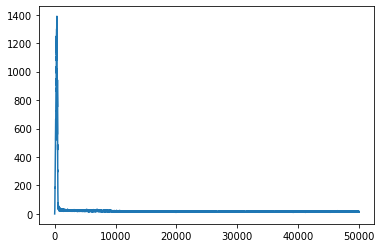

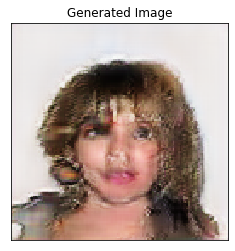

checkpointing at epoch: 50000


In [100]:
import time
from pathlib import Path

start_epoch = 50000
epochs = 100000
batch_size = 64
checkpoint_every_n_epochs = 10000
figure_every_n_epochs = 5000
n_critic = 5



plt.ioff()

model_type = f'wgan-gp-128-faster-stronger-D'
data_name = f'celeba'

#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
#         training_imgs = np.cast['float32'](training_data)
        num_batches = training_generator.n // batch_size
        # losses
        gp_list = []
        gen_loss_list = []
        disc_real_list = []
        disc_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1,latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(start_epoch,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 

        
        disc_real_sum = 0
        disc_fake_sum = 0
        gp_sum = 0
        for _ in range(n_critic):
#             idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_generator.next()
            if len(img_batch) != batch_size:
                continue
            disc_real, disc_fake, gp = train_step_discriminator(img_batch)
            disc_real_sum += K.get_value(disc_real)
            disc_fake_sum += K.get_value(disc_fake)
            gp_sum += K.get_value(gp)
        
        
        gen_loss = train_step_generator()
        
        
        
        disc_real = disc_real_sum/n_critic
        disc_fake = disc_fake_sum/n_critic
        gp = gp_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        disc_real_list.append(disc_real)
        disc_fake_list.append(disc_fake)
        gen_loss_list.append(gen_loss)
        gp_list.append(gp)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.4f} - ', end='')
        print(f'disc_fake: {disc_fake:.4f} - ', end='')
        print(f'disc_real: {disc_real:.4f} - ', end='')
        print(f'neg_critic: {disc_real - disc_fake:.4f} - ', end='')
        print(f'gp: {gp:.4f}')


        

        if epoch % figure_every_n_epochs == 0:
            
             # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(disc_real_list)-np.array(disc_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(height,width,3))
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
            generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            discriminator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator-weights.h5').as_posix())
            discriminator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator.h5').as_posix())
            

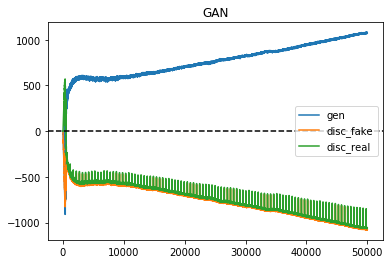

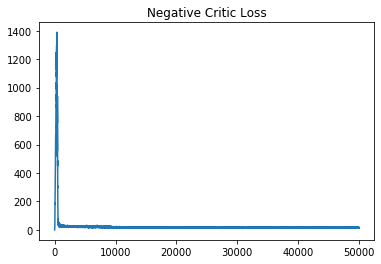

In [101]:


plt.plot(gen_loss_list, label="gen")
plt.plot(disc_fake_list, label="disc_fake")
plt.plot(disc_real_list, label="disc_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss  = np.array(disc_real_list)-np.array(disc_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()

In [56]:
gp_gradients_l2_norm 

NameError: name 'gp_gradients_l2_norm' is not defined

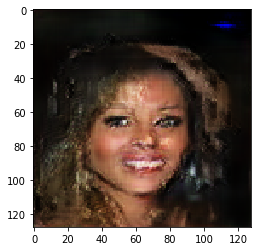

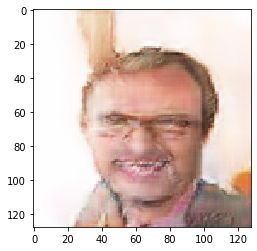

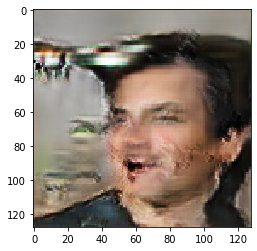

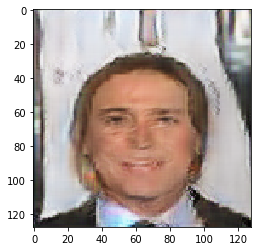

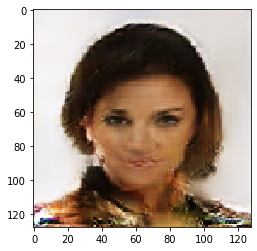

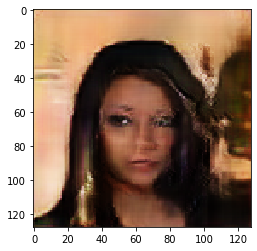

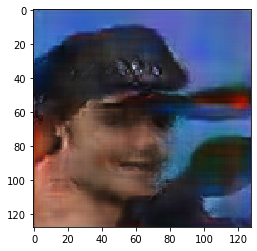

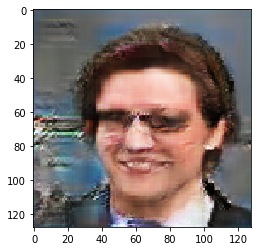

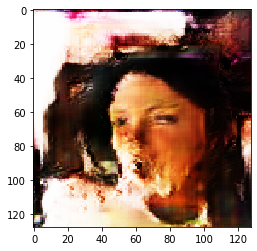

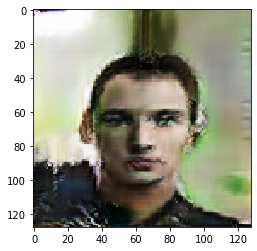

In [112]:
# Some sample generated faces
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(height,width,3))
    plt.show()

In [105]:
validation_generator = training_data_generator.flow_from_directory(
    '../celeba/',
    target_size=(128, 128),
    subset='validation',
    shuffle=True,
    batch_size=64,
    class_mode=None)

Found 40519 images belonging to 1 classes.


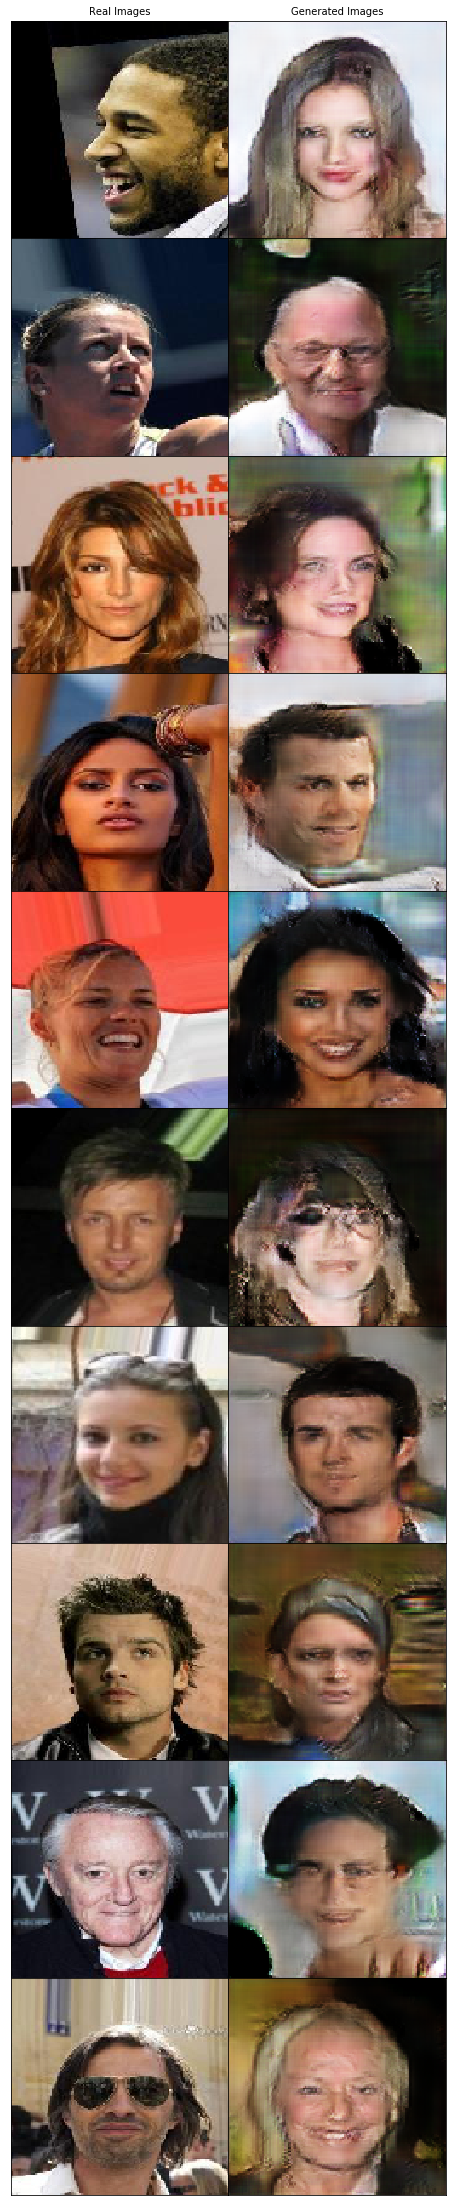

In [111]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(200., 40.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 2),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )

val_data = validation_generator.next()
for i in range(20):
    if i % 2 == 0:
        grid[i].imshow(unnormalize_tanh(val_data[i]))
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    
    else:
        noise = np.random.normal(0,1, (1,100))
        gen_img = unnormalize_tanh( generator.predict(noise)[0])  
        grid[i].imshow(gen_img)
        grid[i].set_xticks([])
        grid[i].set_yticks([])
grid[0].set_title('Real Images', fontsize=10.)
grid[1].set_title('Generated Images', fontsize=10.)
plt.show()